In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

3


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy,categorical_feature=[0])
        d_valid = lgb.Dataset(validX, label=validy,categorical_feature=[0])
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('3001_lgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)
(5803, 1, 18) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 242) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/lightgbm/basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/lightgbm/basic.py:668: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's rmse: 0.776565
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.758007


[3]	valid_0's rmse: 0.740095


[4]	valid_0's rmse: 0.723694


[5]	valid_0's rmse: 0.708911


[6]	valid_0's rmse: 0.695152


[7]	valid_0's rmse: 0.681548


[8]	valid_0's rmse: 0.669058


[9]	valid_0's rmse: 0.658218


[10]	valid_0's rmse: 0.647341


[11]	valid_0's rmse: 0.637639


[12]	valid_0's rmse: 0.62912


[13]	valid_0's rmse: 0.621148


[14]	valid_0's rmse: 0.614026


[15]	valid_0's rmse: 0.607374


[16]	valid_0's rmse: 0.601216


[17]	valid_0's rmse: 0.595456


[18]	valid_0's rmse: 0.58967


[19]	valid_0's rmse: 0.584439


[20]	valid_0's rmse: 0.57964


[21]	valid_0's rmse: 0.575208


[22]	valid_0's rmse: 0.571278


[23]	valid_0's rmse: 0.567504


[24]	valid_0's rmse: 0.564312


[25]	valid_0's rmse: 0.561284


[26]	valid_0's rmse: 0.558652


[27]	valid_0's rmse: 0.556168


[28]	valid_0's rmse: 0.553752


[29]	valid_0's rmse: 0.551498


[30]	valid_0's rmse: 0.549325


[31]	valid_0's rmse: 0.547378


[32]	valid_0's rmse: 0.545536


[33]	valid_0's rmse: 0.544023


[34]	valid_0's rmse: 0.542629


[35]	valid_0's rmse: 0.541348


[36]	valid_0's rmse: 0.540174


[37]	valid_0's rmse: 0.538897


[38]	valid_0's rmse: 0.537803


[39]	valid_0's rmse: 0.536707


[40]	valid_0's rmse: 0.535627


[41]	valid_0's rmse: 0.534695


[42]	valid_0's rmse: 0.533873


[43]	valid_0's rmse: 0.533038


[44]	valid_0's rmse: 0.532385


[45]	valid_0's rmse: 0.531605


[46]	valid_0's rmse: 0.531045
[47]	valid_0's rmse: 0.530449


[48]	valid_0's rmse: 0.529911


[49]	valid_0's rmse: 0.529401
[50]	valid_0's rmse: 0.528957


[51]	valid_0's rmse: 0.528466


[52]	valid_0's rmse: 0.528007
[53]	valid_0's rmse: 0.527652


[54]	valid_0's rmse: 0.52724


[55]	valid_0's rmse: 0.526857
[56]	valid_0's rmse: 0.526475


[57]	valid_0's rmse: 0.526175
[58]	valid_0's rmse: 0.525874


[59]	valid_0's rmse: 0.525619
[60]	valid_0's rmse: 0.525246


[61]	valid_0's rmse: 0.524952
[62]	valid_0's rmse: 0.524698


[63]	valid_0's rmse: 0.524455
[64]	valid_0's rmse: 0.524202


[65]	valid_0's rmse: 0.523967


[66]	valid_0's rmse: 0.523724
[67]	valid_0's rmse: 0.523484


[68]	valid_0's rmse: 0.523315


[69]	valid_0's rmse: 0.523079
[70]	valid_0's rmse: 0.522876


[71]	valid_0's rmse: 0.522641
[72]	valid_0's rmse: 0.522497


[73]	valid_0's rmse: 0.522353


[74]	valid_0's rmse: 0.522226
[75]	valid_0's rmse: 0.522084


[76]	valid_0's rmse: 0.521908
[77]	valid_0's rmse: 0.521722


[78]	valid_0's rmse: 0.521582
[79]	valid_0's rmse: 0.521481


[80]	valid_0's rmse: 0.521293
[81]	valid_0's rmse: 0.521195


[82]	valid_0's rmse: 0.520959
[83]	valid_0's rmse: 0.520878


[84]	valid_0's rmse: 0.520752
[85]	valid_0's rmse: 0.520651


[86]	valid_0's rmse: 0.520469
[87]	valid_0's rmse: 0.52036


[88]	valid_0's rmse: 0.520187
[89]	valid_0's rmse: 0.520042


[90]	valid_0's rmse: 0.519895
[91]	valid_0's rmse: 0.519807


[92]	valid_0's rmse: 0.519741
[93]	valid_0's rmse: 0.519667


[94]	valid_0's rmse: 0.519584
[95]	valid_0's rmse: 0.519524


[96]	valid_0's rmse: 0.519402
[97]	valid_0's rmse: 0.519285


[98]	valid_0's rmse: 0.519205
[99]	valid_0's rmse: 0.519139


[100]	valid_0's rmse: 0.519124
[101]	valid_0's rmse: 0.519054


[102]	valid_0's rmse: 0.518969
[103]	valid_0's rmse: 0.518886


[104]	valid_0's rmse: 0.518823
[105]	valid_0's rmse: 0.518818


[106]	valid_0's rmse: 0.518743
[107]	valid_0's rmse: 0.518624


[108]	valid_0's rmse: 0.518569
[109]	valid_0's rmse: 0.518569


[110]	valid_0's rmse: 0.518481
[111]	valid_0's rmse: 0.518423


[112]	valid_0's rmse: 0.518393
[113]	valid_0's rmse: 0.518306


[114]	valid_0's rmse: 0.518222
[115]	valid_0's rmse: 0.518144


[116]	valid_0's rmse: 0.518123
[117]	valid_0's rmse: 0.518016


[118]	valid_0's rmse: 0.517944
[119]	valid_0's rmse: 0.517882


[120]	valid_0's rmse: 0.51778
[121]	valid_0's rmse: 0.517706


[122]	valid_0's rmse: 0.517678
[123]	valid_0's rmse: 0.517648


[124]	valid_0's rmse: 0.517627
[125]	valid_0's rmse: 0.517615


[126]	valid_0's rmse: 0.517593


[127]	valid_0's rmse: 0.517471
[128]	valid_0's rmse: 0.517446


[129]	valid_0's rmse: 0.517388
[130]	valid_0's rmse: 0.517364


[131]	valid_0's rmse: 0.517305
[132]	valid_0's rmse: 0.517294


[133]	valid_0's rmse: 0.517284
[134]	valid_0's rmse: 0.517287


[135]	valid_0's rmse: 0.517252
[136]	valid_0's rmse: 0.517236


[137]	valid_0's rmse: 0.517198
[138]	valid_0's rmse: 0.517148


[139]	valid_0's rmse: 0.517156
[140]	valid_0's rmse: 0.517078


[141]	valid_0's rmse: 0.517038
[142]	valid_0's rmse: 0.516991


[143]	valid_0's rmse: 0.51691
[144]	valid_0's rmse: 0.516899


[145]	valid_0's rmse: 0.516893
[146]	valid_0's rmse: 0.516833


[147]	valid_0's rmse: 0.516795
[148]	valid_0's rmse: 0.51674


[149]	valid_0's rmse: 0.516738
[150]	valid_0's rmse: 0.516677


[151]	valid_0's rmse: 0.51667
[152]	valid_0's rmse: 0.516651


[153]	valid_0's rmse: 0.516697
[154]	valid_0's rmse: 0.516704


[155]	valid_0's rmse: 0.516689
[156]	valid_0's rmse: 0.516638


[157]	valid_0's rmse: 0.51661
[158]	valid_0's rmse: 0.516589


[159]	valid_0's rmse: 0.516583
[160]	valid_0's rmse: 0.516569


[161]	valid_0's rmse: 0.516528
[162]	valid_0's rmse: 0.516504


[163]	valid_0's rmse: 0.516469
[164]	valid_0's rmse: 0.516489


[165]	valid_0's rmse: 0.516423
[166]	valid_0's rmse: 0.516433


[167]	valid_0's rmse: 0.516376
[168]	valid_0's rmse: 0.516343


[169]	valid_0's rmse: 0.516301
[170]	valid_0's rmse: 0.516291


[171]	valid_0's rmse: 0.516256
[172]	valid_0's rmse: 0.51624


[173]	valid_0's rmse: 0.51622
[174]	valid_0's rmse: 0.516215


[175]	valid_0's rmse: 0.516209
[176]	valid_0's rmse: 0.516174


[177]	valid_0's rmse: 0.516163
[178]	valid_0's rmse: 0.516128


[179]	valid_0's rmse: 0.516114
[180]	valid_0's rmse: 0.51605


[181]	valid_0's rmse: 0.516021
[182]	valid_0's rmse: 0.515997


[183]	valid_0's rmse: 0.515981
[184]	valid_0's rmse: 0.515975


[185]	valid_0's rmse: 0.515978
[186]	valid_0's rmse: 0.515966


[187]	valid_0's rmse: 0.515969
[188]	valid_0's rmse: 0.515944


[189]	valid_0's rmse: 0.515946
[190]	valid_0's rmse: 0.515957


[191]	valid_0's rmse: 0.515957
[192]	valid_0's rmse: 0.515892


[193]	valid_0's rmse: 0.515856
[194]	valid_0's rmse: 0.515853


[195]	valid_0's rmse: 0.515837
[196]	valid_0's rmse: 0.515819


[197]	valid_0's rmse: 0.515782
[198]	valid_0's rmse: 0.515769


[199]	valid_0's rmse: 0.515756
[200]	valid_0's rmse: 0.515739


[201]	valid_0's rmse: 0.515736
[202]	valid_0's rmse: 0.515764


[203]	valid_0's rmse: 0.515751
[204]	valid_0's rmse: 0.515791


[205]	valid_0's rmse: 0.515757
[206]	valid_0's rmse: 0.515754


[207]	valid_0's rmse: 0.515758
[208]	valid_0's rmse: 0.515752


[209]	valid_0's rmse: 0.515734
[210]	valid_0's rmse: 0.515721


[211]	valid_0's rmse: 0.515704
[212]	valid_0's rmse: 0.515718


[213]	valid_0's rmse: 0.515742
[214]	valid_0's rmse: 0.515731


[215]	valid_0's rmse: 0.515718
[216]	valid_0's rmse: 0.515713


[217]	valid_0's rmse: 0.515691
[218]	valid_0's rmse: 0.515716


[219]	valid_0's rmse: 0.515714
[220]	valid_0's rmse: 0.515694


[221]	valid_0's rmse: 0.515686
[222]	valid_0's rmse: 0.515677


[223]	valid_0's rmse: 0.515651
[224]	valid_0's rmse: 0.515631


[225]	valid_0's rmse: 0.515619
[226]	valid_0's rmse: 0.515629


[227]	valid_0's rmse: 0.51564
[228]	valid_0's rmse: 0.515632


[229]	valid_0's rmse: 0.515653
[230]	valid_0's rmse: 0.515631


[231]	valid_0's rmse: 0.515607
[232]	valid_0's rmse: 0.515614


[233]	valid_0's rmse: 0.515599
[234]	valid_0's rmse: 0.515555


[235]	valid_0's rmse: 0.515548
[236]	valid_0's rmse: 0.515565


[237]	valid_0's rmse: 0.515558
[238]	valid_0's rmse: 0.515569


[239]	valid_0's rmse: 0.515572
[240]	valid_0's rmse: 0.515584


[241]	valid_0's rmse: 0.515559
[242]	valid_0's rmse: 0.515543


[243]	valid_0's rmse: 0.515528
[244]	valid_0's rmse: 0.515509


[245]	valid_0's rmse: 0.515499
[246]	valid_0's rmse: 0.515512


[247]	valid_0's rmse: 0.515473
[248]	valid_0's rmse: 0.515465


[249]	valid_0's rmse: 0.51545
[250]	valid_0's rmse: 0.515418


[251]	valid_0's rmse: 0.515402
[252]	valid_0's rmse: 0.515403


[253]	valid_0's rmse: 0.515379
[254]	valid_0's rmse: 0.515369


[255]	valid_0's rmse: 0.51537
[256]	valid_0's rmse: 0.515341


[257]	valid_0's rmse: 0.515341
[258]	valid_0's rmse: 0.515337


[259]	valid_0's rmse: 0.515315
[260]	valid_0's rmse: 0.515323


[261]	valid_0's rmse: 0.515322
[262]	valid_0's rmse: 0.515318


[263]	valid_0's rmse: 0.515337
[264]	valid_0's rmse: 0.51532


[265]	valid_0's rmse: 0.515331
[266]	valid_0's rmse: 0.51534


[267]	valid_0's rmse: 0.51535
[268]	valid_0's rmse: 0.515332


[269]	valid_0's rmse: 0.515316
[270]	valid_0's rmse: 0.515323


[271]	valid_0's rmse: 0.515329
[272]	valid_0's rmse: 0.515335


[273]	valid_0's rmse: 0.515328
[274]	valid_0's rmse: 0.515335


[275]	valid_0's rmse: 0.515319
[276]	valid_0's rmse: 0.515308


[277]	valid_0's rmse: 0.515324
[278]	valid_0's rmse: 0.51534


[279]	valid_0's rmse: 0.515332
[280]	valid_0's rmse: 0.515326
[281]	valid_0's rmse: 0.515315


[282]	valid_0's rmse: 0.515314
[283]	valid_0's rmse: 0.515292


[284]	valid_0's rmse: 0.515279
[285]	valid_0's rmse: 0.515291


[286]	valid_0's rmse: 0.515345
[287]	valid_0's rmse: 0.515349


[288]	valid_0's rmse: 0.515364
[289]	valid_0's rmse: 0.515377


[290]	valid_0's rmse: 0.515378
[291]	valid_0's rmse: 0.515373


[292]	valid_0's rmse: 0.515366
[293]	valid_0's rmse: 0.515378
[294]	valid_0's rmse: 0.515387


[295]	valid_0's rmse: 0.515404
[296]	valid_0's rmse: 0.515391


[297]	valid_0's rmse: 0.51538
[298]	valid_0's rmse: 0.515376


[299]	valid_0's rmse: 0.515355
[300]	valid_0's rmse: 0.515357


[301]	valid_0's rmse: 0.51535
[302]	valid_0's rmse: 0.515341


[303]	valid_0's rmse: 0.515348
[304]	valid_0's rmse: 0.515353


[305]	valid_0's rmse: 0.515355
[306]	valid_0's rmse: 0.515365


[307]	valid_0's rmse: 0.515326
[308]	valid_0's rmse: 0.515334


[309]	valid_0's rmse: 0.515329
[310]	valid_0's rmse: 0.515328


[311]	valid_0's rmse: 0.51532
[312]	valid_0's rmse: 0.515314
[313]	valid_0's rmse: 0.515315


[314]	valid_0's rmse: 0.515299
[315]	valid_0's rmse: 0.515308


[316]	valid_0's rmse: 0.515316
[317]	valid_0's rmse: 0.515326


[318]	valid_0's rmse: 0.515327
[319]	valid_0's rmse: 0.515354


[320]	valid_0's rmse: 0.515345
[321]	valid_0's rmse: 0.515342


[322]	valid_0's rmse: 0.515355
[323]	valid_0's rmse: 0.515365


[324]	valid_0's rmse: 0.51537
[325]	valid_0's rmse: 0.515366


[326]	valid_0's rmse: 0.515336
[327]	valid_0's rmse: 0.515325


[328]	valid_0's rmse: 0.515314
[329]	valid_0's rmse: 0.515302


[330]	valid_0's rmse: 0.515292
[331]	valid_0's rmse: 0.515312


[332]	valid_0's rmse: 0.515309
[333]	valid_0's rmse: 0.515289


[334]	valid_0's rmse: 0.515281
Early stopping, best iteration is:
[284]	valid_0's rmse: 0.515279


0.194224249942 0.265511940405
[0.2655119404049584]
-1 mean score 0.265511940405


0.18174246273


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905113  0.023997  0.188971    7  2017-04-16
472     2.507290  2.533167 -0.025877  0.189382    1  2017-04-17
473     2.661330  2.647569  0.013761  0.217379    2  2017-04-18
474     2.754815  2.735550  0.019264  0.180591    3  2017-04-19
475     2.713762  2.685586  0.028176  0.197250    4  2017-04-20
476     2.999000  2.992503  0.006497  0.138481    5  2017-04-21
477     3.075529  3.087512 -0.011983  0.160143    6  2017-04-22

0.18174246273


pred         y     error    error2  day        date
dayidx                                                         
471     2.905113  2.929110  0.023997  0.188971    7  2017-04-16
472     2.533167  2.507290 -0.025877  0.189382    1  2017-04-17
473     2.647569  2.661330  0.013761  0.217379    2  2017-04-18
474     2.735550  2.754815  0.019264  0.180591    3  2017-04-19
475     2.685586  2.713762  0.028176  0.197250    4  2017-04-20
476     2.992503  2.999000  0.006497  0.138481    5  2017-04-21
477     3.087512  3.075529 -0.011983  0.160143    6  2017-04-22

(829, 242)




2


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)
(6632, 1, 18) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 242) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.771725
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.752467


[3]	valid_0's rmse: 0.734431


[4]	valid_0's rmse: 0.717631


[5]	valid_0's rmse: 0.702255


[6]	valid_0's rmse: 0.688599


[7]	valid_0's rmse: 0.675893


[8]	valid_0's rmse: 0.663596


[9]	valid_0's rmse: 0.652159


[10]	valid_0's rmse: 0.641516


[11]	valid_0's rmse: 0.6323


[12]	valid_0's rmse: 0.623658


[13]	valid_0's rmse: 0.615157


[14]	valid_0's rmse: 0.607576


[15]	valid_0's rmse: 0.600805


[16]	valid_0's rmse: 0.594585


[17]	valid_0's rmse: 0.588625


[18]	valid_0's rmse: 0.583052


[19]	valid_0's rmse: 0.577944


[20]	valid_0's rmse: 0.573529


[21]	valid_0's rmse: 0.56931


[22]	valid_0's rmse: 0.565588


[23]	valid_0's rmse: 0.56197


[24]	valid_0's rmse: 0.558903


[25]	valid_0's rmse: 0.556045


[26]	valid_0's rmse: 0.553465


[27]	valid_0's rmse: 0.550923


[28]	valid_0's rmse: 0.548515


[29]	valid_0's rmse: 0.546179


[30]	valid_0's rmse: 0.544088


[31]	valid_0's rmse: 0.54213


[32]	valid_0's rmse: 0.540374


[33]	valid_0's rmse: 0.538863
[34]	valid_0's rmse: 0.537438


[35]	valid_0's rmse: 0.536069


[36]	valid_0's rmse: 0.534913


[37]	valid_0's rmse: 0.533712


[38]	valid_0's rmse: 0.532643
[39]	valid_0's rmse: 0.531617


[40]	valid_0's rmse: 0.530582


[41]	valid_0's rmse: 0.52968
[42]	valid_0's rmse: 0.528912


[43]	valid_0's rmse: 0.528193
[44]	valid_0's rmse: 0.527385


[45]	valid_0's rmse: 0.526754


[46]	valid_0's rmse: 0.526217
[47]	valid_0's rmse: 0.525696


[48]	valid_0's rmse: 0.525081
[49]	valid_0's rmse: 0.524601


[50]	valid_0's rmse: 0.524078


[51]	valid_0's rmse: 0.523565
[52]	valid_0's rmse: 0.523065


[53]	valid_0's rmse: 0.522717
[54]	valid_0's rmse: 0.522261


[55]	valid_0's rmse: 0.521896
[56]	valid_0's rmse: 0.521457


[57]	valid_0's rmse: 0.521123


[58]	valid_0's rmse: 0.520793
[59]	valid_0's rmse: 0.520586


[60]	valid_0's rmse: 0.520218


[61]	valid_0's rmse: 0.519883
[62]	valid_0's rmse: 0.51963


[63]	valid_0's rmse: 0.519385
[64]	valid_0's rmse: 0.519099


[65]	valid_0's rmse: 0.51887
[66]	valid_0's rmse: 0.518616


[67]	valid_0's rmse: 0.518404
[68]	valid_0's rmse: 0.518164


[69]	valid_0's rmse: 0.518004
[70]	valid_0's rmse: 0.517874


[71]	valid_0's rmse: 0.517649
[72]	valid_0's rmse: 0.517451


[73]	valid_0's rmse: 0.517234
[74]	valid_0's rmse: 0.517058


[75]	valid_0's rmse: 0.516893
[76]	valid_0's rmse: 0.51669


[77]	valid_0's rmse: 0.516559
[78]	valid_0's rmse: 0.516474


[79]	valid_0's rmse: 0.516366
[80]	valid_0's rmse: 0.516219


[81]	valid_0's rmse: 0.516094
[82]	valid_0's rmse: 0.515874


[83]	valid_0's rmse: 0.515783
[84]	valid_0's rmse: 0.515677


[85]	valid_0's rmse: 0.515568
[86]	valid_0's rmse: 0.515439


[87]	valid_0's rmse: 0.515337
[88]	valid_0's rmse: 0.515089


[89]	valid_0's rmse: 0.514953
[90]	valid_0's rmse: 0.514759


[91]	valid_0's rmse: 0.514617
[92]	valid_0's rmse: 0.514519


[93]	valid_0's rmse: 0.514446
[94]	valid_0's rmse: 0.514376


[95]	valid_0's rmse: 0.514305
[96]	valid_0's rmse: 0.514192


[97]	valid_0's rmse: 0.514097
[98]	valid_0's rmse: 0.514024


[99]	valid_0's rmse: 0.513999
[100]	valid_0's rmse: 0.513856


[101]	valid_0's rmse: 0.513799
[102]	valid_0's rmse: 0.513707


[103]	valid_0's rmse: 0.513517
[104]	valid_0's rmse: 0.513444


[105]	valid_0's rmse: 0.513384
[106]	valid_0's rmse: 0.513307


[107]	valid_0's rmse: 0.513243
[108]	valid_0's rmse: 0.513088


[109]	valid_0's rmse: 0.512991
[110]	valid_0's rmse: 0.512881


[111]	valid_0's rmse: 0.512808
[112]	valid_0's rmse: 0.512758


[113]	valid_0's rmse: 0.512725
[114]	valid_0's rmse: 0.512634


[115]	valid_0's rmse: 0.512563
[116]	valid_0's rmse: 0.512588


[117]	valid_0's rmse: 0.512507
[118]	valid_0's rmse: 0.512494


[119]	valid_0's rmse: 0.512469
[120]	valid_0's rmse: 0.512431


[121]	valid_0's rmse: 0.512444
[122]	valid_0's rmse: 0.512424


[123]	valid_0's rmse: 0.512324
[124]	valid_0's rmse: 0.512272


[125]	valid_0's rmse: 0.512224
[126]	valid_0's rmse: 0.512237


[127]	valid_0's rmse: 0.512197
[128]	valid_0's rmse: 0.512174


[129]	valid_0's rmse: 0.512115
[130]	valid_0's rmse: 0.51206


[131]	valid_0's rmse: 0.511957
[132]	valid_0's rmse: 0.511912


[133]	valid_0's rmse: 0.51189
[134]	valid_0's rmse: 0.511853


[135]	valid_0's rmse: 0.51185
[136]	valid_0's rmse: 0.511821


[137]	valid_0's rmse: 0.511809
[138]	valid_0's rmse: 0.511772


[139]	valid_0's rmse: 0.511755
[140]	valid_0's rmse: 0.511674


[141]	valid_0's rmse: 0.511631
[142]	valid_0's rmse: 0.511572


[143]	valid_0's rmse: 0.511484
[144]	valid_0's rmse: 0.511448


[145]	valid_0's rmse: 0.511475
[146]	valid_0's rmse: 0.511438


[147]	valid_0's rmse: 0.511405
[148]	valid_0's rmse: 0.511305


[149]	valid_0's rmse: 0.511259
[150]	valid_0's rmse: 0.511222


[151]	valid_0's rmse: 0.511167
[152]	valid_0's rmse: 0.511136


[153]	valid_0's rmse: 0.511131
[154]	valid_0's rmse: 0.511097


[155]	valid_0's rmse: 0.51099
[156]	valid_0's rmse: 0.510979


[157]	valid_0's rmse: 0.510893
[158]	valid_0's rmse: 0.510889


[159]	valid_0's rmse: 0.510888
[160]	valid_0's rmse: 0.510818


[161]	valid_0's rmse: 0.510781
[162]	valid_0's rmse: 0.510768


[163]	valid_0's rmse: 0.510769
[164]	valid_0's rmse: 0.510745


[165]	valid_0's rmse: 0.510708
[166]	valid_0's rmse: 0.51069


[167]	valid_0's rmse: 0.510782
[168]	valid_0's rmse: 0.51074


[169]	valid_0's rmse: 0.510763
[170]	valid_0's rmse: 0.510804


[171]	valid_0's rmse: 0.510724
[172]	valid_0's rmse: 0.510708


[173]	valid_0's rmse: 0.510695
[174]	valid_0's rmse: 0.51068


[175]	valid_0's rmse: 0.510671
[176]	valid_0's rmse: 0.510636


[177]	valid_0's rmse: 0.510624
[178]	valid_0's rmse: 0.510627


[179]	valid_0's rmse: 0.510605
[180]	valid_0's rmse: 0.510564


[181]	valid_0's rmse: 0.51056
[182]	valid_0's rmse: 0.510586


[183]	valid_0's rmse: 0.51055
[184]	valid_0's rmse: 0.510533


[185]	valid_0's rmse: 0.510531
[186]	valid_0's rmse: 0.510512


[187]	valid_0's rmse: 0.510528
[188]	valid_0's rmse: 0.510506


[189]	valid_0's rmse: 0.510523
[190]	valid_0's rmse: 0.510507


[191]	valid_0's rmse: 0.510502
[192]	valid_0's rmse: 0.510464


[193]	valid_0's rmse: 0.510398
[194]	valid_0's rmse: 0.510408


[195]	valid_0's rmse: 0.510395
[196]	valid_0's rmse: 0.510368


[197]	valid_0's rmse: 0.510362
[198]	valid_0's rmse: 0.510346


[199]	valid_0's rmse: 0.510353
[200]	valid_0's rmse: 0.510344


[201]	valid_0's rmse: 0.510323
[202]	valid_0's rmse: 0.510292


[203]	valid_0's rmse: 0.510332
[204]	valid_0's rmse: 0.510314


[205]	valid_0's rmse: 0.510318
[206]	valid_0's rmse: 0.510276


[207]	valid_0's rmse: 0.510241
[208]	valid_0's rmse: 0.510234


[209]	valid_0's rmse: 0.510242
[210]	valid_0's rmse: 0.510216


[211]	valid_0's rmse: 0.510219
[212]	valid_0's rmse: 0.510196


[213]	valid_0's rmse: 0.51018
[214]	valid_0's rmse: 0.510189


[215]	valid_0's rmse: 0.510159
[216]	valid_0's rmse: 0.51015


[217]	valid_0's rmse: 0.510144
[218]	valid_0's rmse: 0.510104


[219]	valid_0's rmse: 0.510067
[220]	valid_0's rmse: 0.510075


[221]	valid_0's rmse: 0.510066
[222]	valid_0's rmse: 0.510084


[223]	valid_0's rmse: 0.510097
[224]	valid_0's rmse: 0.510113


[225]	valid_0's rmse: 0.510096
[226]	valid_0's rmse: 0.510062


[227]	valid_0's rmse: 0.510057
[228]	valid_0's rmse: 0.510065


[229]	valid_0's rmse: 0.510039
[230]	valid_0's rmse: 0.510047


[231]	valid_0's rmse: 0.510054
[232]	valid_0's rmse: 0.510053


[233]	valid_0's rmse: 0.510051
[234]	valid_0's rmse: 0.510024
[235]	valid_0's rmse: 0.510021


[236]	valid_0's rmse: 0.51
[237]	valid_0's rmse: 0.509974


[238]	valid_0's rmse: 0.509953
[239]	valid_0's rmse: 0.509952


[240]	valid_0's rmse: 0.509949
[241]	valid_0's rmse: 0.509942


[242]	valid_0's rmse: 0.509958
[243]	valid_0's rmse: 0.50996


[244]	valid_0's rmse: 0.509955
[245]	valid_0's rmse: 0.50994


[246]	valid_0's rmse: 0.509919
[247]	valid_0's rmse: 0.509913


[248]	valid_0's rmse: 0.509918
[249]	valid_0's rmse: 0.509917


[250]	valid_0's rmse: 0.509887
[251]	valid_0's rmse: 0.509887


[252]	valid_0's rmse: 0.509873
[253]	valid_0's rmse: 0.509894


[254]	valid_0's rmse: 0.509909
[255]	valid_0's rmse: 0.509908


[256]	valid_0's rmse: 0.509892
[257]	valid_0's rmse: 0.509895


[258]	valid_0's rmse: 0.509882
[259]	valid_0's rmse: 0.509889


[260]	valid_0's rmse: 0.509889
[261]	valid_0's rmse: 0.509884


[262]	valid_0's rmse: 0.509902
[263]	valid_0's rmse: 0.509903


[264]	valid_0's rmse: 0.509901
[265]	valid_0's rmse: 0.509917


[266]	valid_0's rmse: 0.509921
[267]	valid_0's rmse: 0.509912


[268]	valid_0's rmse: 0.509927
[269]	valid_0's rmse: 0.509953


[270]	valid_0's rmse: 0.509953
[271]	valid_0's rmse: 0.509949


[272]	valid_0's rmse: 0.509926
[273]	valid_0's rmse: 0.50992
[274]	valid_0's rmse: 0.509917


[275]	valid_0's rmse: 0.509938
[276]	valid_0's rmse: 0.509962


[277]	valid_0's rmse: 0.50994
[278]	valid_0's rmse: 0.509953


[279]	valid_0's rmse: 0.509966
[280]	valid_0's rmse: 0.509959


[281]	valid_0's rmse: 0.509989
[282]	valid_0's rmse: 0.50995


[283]	valid_0's rmse: 0.509918
[284]	valid_0's rmse: 0.509921


[285]	valid_0's rmse: 0.50992
[286]	valid_0's rmse: 0.509922


[287]	valid_0's rmse: 0.509937
[288]	valid_0's rmse: 0.509946


[289]	valid_0's rmse: 0.509971
[290]	valid_0's rmse: 0.509971


[291]	valid_0's rmse: 0.50996
[292]	valid_0's rmse: 0.509964


[293]	valid_0's rmse: 0.50995
[294]	valid_0's rmse: 0.509935


[295]	valid_0's rmse: 0.509927
[296]	valid_0's rmse: 0.50993


[297]	valid_0's rmse: 0.50992
[298]	valid_0's rmse: 0.509925


[299]	valid_0's rmse: 0.509909
[300]	valid_0's rmse: 0.509905


[301]	valid_0's rmse: 0.509903
[302]	valid_0's rmse: 0.509908
Early stopping, best iteration is:
[252]	valid_0's rmse: 0.509873


0.190602432714 0.259970615134
[0.25997061513376912]
-1 mean score 0.259970615134
0.18918367921


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897488  0.031622  0.193453    7  2017-04-16
472     2.507290  2.527978 -0.020688  0.206791    1  2017-04-17
473     2.661330  2.645985  0.015345  0.228546    2  2017-04-18
474     2.754815  2.725859  0.028956  0.185496    3  2017-04-19
475     2.713762  2.695624  0.018138  0.205557    4  2017-04-20
476     2.999000  2.993533  0.005467  0.140663    5  2017-04-21
477     3.075529  3.086232 -0.010703  0.163779    6  2017-04-22

0.18918367921


pred         y     error    error2  day        date
dayidx                                                         
471     2.897488  2.929110  0.031622  0.193453    7  2017-04-16
472     2.527978  2.507290 -0.020688  0.206791    1  2017-04-17
473     2.645985  2.661330  0.015345  0.228546    2  2017-04-18
474     2.725859  2.754815  0.028956  0.185496    3  2017-04-19
475     2.695624  2.713762  0.018138  0.205557    4  2017-04-20
476     2.993533  2.999000  0.005467  0.140663    5  2017-04-21
477     3.086232  3.075529 -0.010703  0.163779    6  2017-04-22

(829, 242)




3


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)
(7461, 1, 18) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 242) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.775201
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.755753


[3]	valid_0's rmse: 0.73842


[4]	valid_0's rmse: 0.722261


[5]	valid_0's rmse: 0.707284


[6]	valid_0's rmse: 0.692594


[7]	valid_0's rmse: 0.679946


[8]	valid_0's rmse: 0.667487


[9]	valid_0's rmse: 0.656468


[10]	valid_0's rmse: 0.646245


[11]	valid_0's rmse: 0.636294


[12]	valid_0's rmse: 0.627156


[13]	valid_0's rmse: 0.618636


[14]	valid_0's rmse: 0.611306


[15]	valid_0's rmse: 0.604434


[16]	valid_0's rmse: 0.598184


[17]	valid_0's rmse: 0.592083


[18]	valid_0's rmse: 0.586396


[19]	valid_0's rmse: 0.581497


[20]	valid_0's rmse: 0.577091


[21]	valid_0's rmse: 0.572717


[22]	valid_0's rmse: 0.568926


[23]	valid_0's rmse: 0.565071


[24]	valid_0's rmse: 0.561595


[25]	valid_0's rmse: 0.558457


[26]	valid_0's rmse: 0.555826


[27]	valid_0's rmse: 0.553183


[28]	valid_0's rmse: 0.550647


[29]	valid_0's rmse: 0.548326


[30]	valid_0's rmse: 0.546244


[31]	valid_0's rmse: 0.544393


[32]	valid_0's rmse: 0.542642


[33]	valid_0's rmse: 0.541077
[34]	valid_0's rmse: 0.539546


[35]	valid_0's rmse: 0.538233


[36]	valid_0's rmse: 0.536983
[37]	valid_0's rmse: 0.535738


[38]	valid_0's rmse: 0.534598
[39]	valid_0's rmse: 0.533622


[40]	valid_0's rmse: 0.532553


[41]	valid_0's rmse: 0.531687
[42]	valid_0's rmse: 0.530884


[43]	valid_0's rmse: 0.530118
[44]	valid_0's rmse: 0.52936


[45]	valid_0's rmse: 0.528715
[46]	valid_0's rmse: 0.528093


[47]	valid_0's rmse: 0.52755
[48]	valid_0's rmse: 0.526978


[49]	valid_0's rmse: 0.526486
[50]	valid_0's rmse: 0.525969


[51]	valid_0's rmse: 0.525472
[52]	valid_0's rmse: 0.525025


[53]	valid_0's rmse: 0.52465
[54]	valid_0's rmse: 0.524258


[55]	valid_0's rmse: 0.523859
[56]	valid_0's rmse: 0.52345


[57]	valid_0's rmse: 0.523076
[58]	valid_0's rmse: 0.522751


[59]	valid_0's rmse: 0.522524
[60]	valid_0's rmse: 0.522253


[61]	valid_0's rmse: 0.521976
[62]	valid_0's rmse: 0.521741


[63]	valid_0's rmse: 0.521515
[64]	valid_0's rmse: 0.521231


[65]	valid_0's rmse: 0.52105
[66]	valid_0's rmse: 0.520847


[67]	valid_0's rmse: 0.520601
[68]	valid_0's rmse: 0.520369


[69]	valid_0's rmse: 0.520199
[70]	valid_0's rmse: 0.520001


[71]	valid_0's rmse: 0.519803
[72]	valid_0's rmse: 0.519614


[73]	valid_0's rmse: 0.519441
[74]	valid_0's rmse: 0.519299


[75]	valid_0's rmse: 0.519154
[76]	valid_0's rmse: 0.518925


[77]	valid_0's rmse: 0.518679
[78]	valid_0's rmse: 0.518566


[79]	valid_0's rmse: 0.518366
[80]	valid_0's rmse: 0.518175


[81]	valid_0's rmse: 0.518065
[82]	valid_0's rmse: 0.517802


[83]	valid_0's rmse: 0.517721
[84]	valid_0's rmse: 0.517592


[85]	valid_0's rmse: 0.517453
[86]	valid_0's rmse: 0.517259


[87]	valid_0's rmse: 0.517116
[88]	valid_0's rmse: 0.517007


[89]	valid_0's rmse: 0.516984
[90]	valid_0's rmse: 0.516758


[91]	valid_0's rmse: 0.5166
[92]	valid_0's rmse: 0.51647


[93]	valid_0's rmse: 0.516228
[94]	valid_0's rmse: 0.516183


[95]	valid_0's rmse: 0.516064
[96]	valid_0's rmse: 0.515986


[97]	valid_0's rmse: 0.515933
[98]	valid_0's rmse: 0.515798


[99]	valid_0's rmse: 0.515718
[100]	valid_0's rmse: 0.515658


[101]	valid_0's rmse: 0.515643
[102]	valid_0's rmse: 0.515499


[103]	valid_0's rmse: 0.515395
[104]	valid_0's rmse: 0.515361


[105]	valid_0's rmse: 0.515309
[106]	valid_0's rmse: 0.515218


[107]	valid_0's rmse: 0.515216
[108]	valid_0's rmse: 0.515221


[109]	valid_0's rmse: 0.515165
[110]	valid_0's rmse: 0.515073


[111]	valid_0's rmse: 0.51505
[112]	valid_0's rmse: 0.515035


[113]	valid_0's rmse: 0.515023
[114]	valid_0's rmse: 0.515013


[115]	valid_0's rmse: 0.514926
[116]	valid_0's rmse: 0.514902


[117]	valid_0's rmse: 0.514869
[118]	valid_0's rmse: 0.514816


[119]	valid_0's rmse: 0.51479
[120]	valid_0's rmse: 0.514783


[121]	valid_0's rmse: 0.514748
[122]	valid_0's rmse: 0.514699


[123]	valid_0's rmse: 0.514682
[124]	valid_0's rmse: 0.514673


[125]	valid_0's rmse: 0.514673
[126]	valid_0's rmse: 0.514631


[127]	valid_0's rmse: 0.514578
[128]	valid_0's rmse: 0.514582


[129]	valid_0's rmse: 0.51454
[130]	valid_0's rmse: 0.51448


[131]	valid_0's rmse: 0.514418
[132]	valid_0's rmse: 0.514361


[133]	valid_0's rmse: 0.514319
[134]	valid_0's rmse: 0.514364


[135]	valid_0's rmse: 0.514294
[136]	valid_0's rmse: 0.514296


[137]	valid_0's rmse: 0.514259
[138]	valid_0's rmse: 0.514249


[139]	valid_0's rmse: 0.514189
[140]	valid_0's rmse: 0.514133


[141]	valid_0's rmse: 0.514129
[142]	valid_0's rmse: 0.514118


[143]	valid_0's rmse: 0.514126
[144]	valid_0's rmse: 0.514142


[145]	valid_0's rmse: 0.514131
[146]	valid_0's rmse: 0.514136


[147]	valid_0's rmse: 0.514135
[148]	valid_0's rmse: 0.514113


[149]	valid_0's rmse: 0.514062
[150]	valid_0's rmse: 0.514074


[151]	valid_0's rmse: 0.514019
[152]	valid_0's rmse: 0.514024


[153]	valid_0's rmse: 0.513998
[154]	valid_0's rmse: 0.513923


[155]	valid_0's rmse: 0.513905
[156]	valid_0's rmse: 0.513854


[157]	valid_0's rmse: 0.513841
[158]	valid_0's rmse: 0.513817


[159]	valid_0's rmse: 0.513793
[160]	valid_0's rmse: 0.513757


[161]	valid_0's rmse: 0.513744
[162]	valid_0's rmse: 0.513738


[163]	valid_0's rmse: 0.513758
[164]	valid_0's rmse: 0.513763


[165]	valid_0's rmse: 0.513765
[166]	valid_0's rmse: 0.513716


[167]	valid_0's rmse: 0.513677
[168]	valid_0's rmse: 0.513669


[169]	valid_0's rmse: 0.513605
[170]	valid_0's rmse: 0.513612


[171]	valid_0's rmse: 0.513631
[172]	valid_0's rmse: 0.513608


[173]	valid_0's rmse: 0.513653
[174]	valid_0's rmse: 0.513634


[175]	valid_0's rmse: 0.513626
[176]	valid_0's rmse: 0.513598


[177]	valid_0's rmse: 0.513616
[178]	valid_0's rmse: 0.513508


[179]	valid_0's rmse: 0.513538
[180]	valid_0's rmse: 0.513539


[181]	valid_0's rmse: 0.513492
[182]	valid_0's rmse: 0.513484


[183]	valid_0's rmse: 0.513494
[184]	valid_0's rmse: 0.513489


[185]	valid_0's rmse: 0.513498
[186]	valid_0's rmse: 0.513465


[187]	valid_0's rmse: 0.513481
[188]	valid_0's rmse: 0.513471


[189]	valid_0's rmse: 0.513449
[190]	valid_0's rmse: 0.513437


[191]	valid_0's rmse: 0.513391
[192]	valid_0's rmse: 0.513384


[193]	valid_0's rmse: 0.513378
[194]	valid_0's rmse: 0.513388


[195]	valid_0's rmse: 0.513352
[196]	valid_0's rmse: 0.513312


[197]	valid_0's rmse: 0.513299
[198]	valid_0's rmse: 0.513299


[199]	valid_0's rmse: 0.513305
[200]	valid_0's rmse: 0.5133


[201]	valid_0's rmse: 0.513287
[202]	valid_0's rmse: 0.513227


[203]	valid_0's rmse: 0.513214
[204]	valid_0's rmse: 0.513231


[205]	valid_0's rmse: 0.513233
[206]	valid_0's rmse: 0.513245


[207]	valid_0's rmse: 0.51323
[208]	valid_0's rmse: 0.513221


[209]	valid_0's rmse: 0.513199
[210]	valid_0's rmse: 0.513201


[211]	valid_0's rmse: 0.513186
[212]	valid_0's rmse: 0.513164


[213]	valid_0's rmse: 0.513144
[214]	valid_0's rmse: 0.513092


[215]	valid_0's rmse: 0.513076
[216]	valid_0's rmse: 0.513074


[217]	valid_0's rmse: 0.513064
[218]	valid_0's rmse: 0.513043
[219]	valid_0's rmse: 0.513061


[220]	valid_0's rmse: 0.51305
[221]	valid_0's rmse: 0.513052


[222]	valid_0's rmse: 0.513029
[223]	valid_0's rmse: 0.513011


[224]	valid_0's rmse: 0.512999
[225]	valid_0's rmse: 0.513007


[226]	valid_0's rmse: 0.512985
[227]	valid_0's rmse: 0.512962


[228]	valid_0's rmse: 0.512967
[229]	valid_0's rmse: 0.512943


[230]	valid_0's rmse: 0.512955
[231]	valid_0's rmse: 0.512965


[232]	valid_0's rmse: 0.512949
[233]	valid_0's rmse: 0.512954


[234]	valid_0's rmse: 0.512926
[235]	valid_0's rmse: 0.512953


[236]	valid_0's rmse: 0.512929
[237]	valid_0's rmse: 0.512918


[238]	valid_0's rmse: 0.512925
[239]	valid_0's rmse: 0.512911


[240]	valid_0's rmse: 0.512864
[241]	valid_0's rmse: 0.512835


[242]	valid_0's rmse: 0.51284
[243]	valid_0's rmse: 0.512844


[244]	valid_0's rmse: 0.512822
[245]	valid_0's rmse: 0.51284


[246]	valid_0's rmse: 0.512834
[247]	valid_0's rmse: 0.512829


[248]	valid_0's rmse: 0.512827
[249]	valid_0's rmse: 0.512787


[250]	valid_0's rmse: 0.512774
[251]	valid_0's rmse: 0.512784


[252]	valid_0's rmse: 0.51278
[253]	valid_0's rmse: 0.512766


[254]	valid_0's rmse: 0.512764
[255]	valid_0's rmse: 0.512753


[256]	valid_0's rmse: 0.512764
[257]	valid_0's rmse: 0.512772


[258]	valid_0's rmse: 0.512764
[259]	valid_0's rmse: 0.512772
[260]	valid_0's rmse: 0.512763


[261]	valid_0's rmse: 0.512777
[262]	valid_0's rmse: 0.512756
[263]	valid_0's rmse: 0.512755


[264]	valid_0's rmse: 0.512741
[265]	valid_0's rmse: 0.51274
[266]	valid_0's rmse: 0.512753


[267]	valid_0's rmse: 0.512746
[268]	valid_0's rmse: 0.512734


[269]	valid_0's rmse: 0.512712
[270]	valid_0's rmse: 0.512705


[271]	valid_0's rmse: 0.51271
[272]	valid_0's rmse: 0.512717


[273]	valid_0's rmse: 0.51272
[274]	valid_0's rmse: 0.512719


[275]	valid_0's rmse: 0.512736
[276]	valid_0's rmse: 0.512718


[277]	valid_0's rmse: 0.512716
[278]	valid_0's rmse: 0.512711


[279]	valid_0's rmse: 0.51272
[280]	valid_0's rmse: 0.512728


[281]	valid_0's rmse: 0.512728
[282]	valid_0's rmse: 0.512717


[283]	valid_0's rmse: 0.512716
[284]	valid_0's rmse: 0.512736


[285]	valid_0's rmse: 0.512754
[286]	valid_0's rmse: 0.51276


[287]	valid_0's rmse: 0.512747
[288]	valid_0's rmse: 0.512716


[289]	valid_0's rmse: 0.512711
[290]	valid_0's rmse: 0.512714


[291]	valid_0's rmse: 0.512717
[292]	valid_0's rmse: 0.512696


[293]	valid_0's rmse: 0.512679
[294]	valid_0's rmse: 0.512671
[295]	valid_0's rmse: 0.512682


[296]	valid_0's rmse: 0.512681
[297]	valid_0's rmse: 0.512684


[298]	valid_0's rmse: 0.51267
[299]	valid_0's rmse: 0.51268
[300]	valid_0's rmse: 0.512692


[301]	valid_0's rmse: 0.512673
[302]	valid_0's rmse: 0.512657


[303]	valid_0's rmse: 0.512648
[304]	valid_0's rmse: 0.512653


[305]	valid_0's rmse: 0.512651
[306]	valid_0's rmse: 0.512642


[307]	valid_0's rmse: 0.512659
[308]	valid_0's rmse: 0.512642
[309]	valid_0's rmse: 0.51263


[310]	valid_0's rmse: 0.512613
[311]	valid_0's rmse: 0.51261


[312]	valid_0's rmse: 0.512615
[313]	valid_0's rmse: 0.512649


[314]	valid_0's rmse: 0.512672
[315]	valid_0's rmse: 0.512682


[316]	valid_0's rmse: 0.5127
[317]	valid_0's rmse: 0.512697


[318]	valid_0's rmse: 0.512694
[319]	valid_0's rmse: 0.51271


[320]	valid_0's rmse: 0.512686
[321]	valid_0's rmse: 0.512656


[322]	valid_0's rmse: 0.512652
[323]	valid_0's rmse: 0.512657
[324]	valid_0's rmse: 0.512666


[325]	valid_0's rmse: 0.512674
[326]	valid_0's rmse: 0.512671


[327]	valid_0's rmse: 0.512662
[328]	valid_0's rmse: 0.512665
[329]	valid_0's rmse: 0.512664


[330]	valid_0's rmse: 0.512668
[331]	valid_0's rmse: 0.51268


[332]	valid_0's rmse: 0.512675
[333]	valid_0's rmse: 0.512687


[334]	valid_0's rmse: 0.512682
[335]	valid_0's rmse: 0.512681


[336]	valid_0's rmse: 0.512664
[337]	valid_0's rmse: 0.51267


[338]	valid_0's rmse: 0.512671
[339]	valid_0's rmse: 0.512673


[340]	valid_0's rmse: 0.512673
[341]	valid_0's rmse: 0.512666


[342]	valid_0's rmse: 0.512673
[343]	valid_0's rmse: 0.512676


[344]	valid_0's rmse: 0.512663
[345]	valid_0's rmse: 0.512635


[346]	valid_0's rmse: 0.512633
[347]	valid_0's rmse: 0.512645


[348]	valid_0's rmse: 0.512651
[349]	valid_0's rmse: 0.512661


[350]	valid_0's rmse: 0.512666
[351]	valid_0's rmse: 0.512669


[352]	valid_0's rmse: 0.512676
[353]	valid_0's rmse: 0.51266


[354]	valid_0's rmse: 0.512667
[355]	valid_0's rmse: 0.51268


[356]	valid_0's rmse: 0.512669
[357]	valid_0's rmse: 0.512677


[358]	valid_0's rmse: 0.512681
[359]	valid_0's rmse: 0.512699
[360]	valid_0's rmse: 0.51271


[361]	valid_0's rmse: 0.512714
Early stopping, best iteration is:
[311]	valid_0's rmse: 0.51261


0.182924829357 0.262768718685
[0.262768718685083]
-1 mean score 0.262768718685
0.184424626608


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888516  0.040594  0.184821    7  2017-04-16
472     2.507290  2.528228 -0.020938  0.189683    1  2017-04-17
473     2.661330  2.644596  0.016733  0.225021    2  2017-04-18
474     2.754815  2.758227 -0.003413  0.193045    3  2017-04-19
475     2.713762  2.694029  0.019733  0.201336    4  2017-04-20
476     2.999000  2.990687  0.008312  0.140486    5  2017-04-21
477     3.075529  3.084973 -0.009444  0.156580    6  2017-04-22

0.184424626608


pred         y     error    error2  day        date
dayidx                                                         
471     2.888516  2.929110  0.040594  0.184821    7  2017-04-16
472     2.528228  2.507290 -0.020938  0.189683    1  2017-04-17
473     2.644596  2.661330  0.016733  0.225021    2  2017-04-18
474     2.758227  2.754815 -0.003413  0.193045    3  2017-04-19
475     2.694029  2.713762  0.019733  0.201336    4  2017-04-20
476     2.990687  2.999000  0.008312  0.140486    5  2017-04-21
477     3.084973  3.075529 -0.009444  0.156580    6  2017-04-22

(829, 242)




4


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)
(8290, 1, 18) (8290, 7, 32) (8290, 1) (8290, 1)


(8290, 242) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.776809
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.758087


[3]	valid_0's rmse: 0.739921


[4]	valid_0's rmse: 0.723307


[5]	valid_0's rmse: 0.708374


[6]	valid_0's rmse: 0.694137


[7]	valid_0's rmse: 0.681496


[8]	valid_0's rmse: 0.669719


[9]	valid_0's rmse: 0.658448


[10]	valid_0's rmse: 0.64763


[11]	valid_0's rmse: 0.638274


[12]	valid_0's rmse: 0.629558


[13]	valid_0's rmse: 0.621668


[14]	valid_0's rmse: 0.614254


[15]	valid_0's rmse: 0.606976


[16]	valid_0's rmse: 0.600783


[17]	valid_0's rmse: 0.594934


[18]	valid_0's rmse: 0.589078
[19]	valid_0's rmse: 0.583827


[20]	valid_0's rmse: 0.579296


[21]	valid_0's rmse: 0.575177


[22]	valid_0's rmse: 0.571437


[23]	valid_0's rmse: 0.567755


[24]	valid_0's rmse: 0.564381


[25]	valid_0's rmse: 0.561241


[26]	valid_0's rmse: 0.55856


[27]	valid_0's rmse: 0.556201
[28]	valid_0's rmse: 0.553634


[29]	valid_0's rmse: 0.551378
[30]	valid_0's rmse: 0.549199


[31]	valid_0's rmse: 0.547343
[32]	valid_0's rmse: 0.545531


[33]	valid_0's rmse: 0.543849


[34]	valid_0's rmse: 0.542373


[35]	valid_0's rmse: 0.541177


[36]	valid_0's rmse: 0.540016
[37]	valid_0's rmse: 0.538843


[38]	valid_0's rmse: 0.537672
[39]	valid_0's rmse: 0.536721


[40]	valid_0's rmse: 0.535748
[41]	valid_0's rmse: 0.534813


[42]	valid_0's rmse: 0.533955
[43]	valid_0's rmse: 0.533102


[44]	valid_0's rmse: 0.532431
[45]	valid_0's rmse: 0.531789


[46]	valid_0's rmse: 0.531214
[47]	valid_0's rmse: 0.530757


[48]	valid_0's rmse: 0.530277
[49]	valid_0's rmse: 0.529737


[50]	valid_0's rmse: 0.529128
[51]	valid_0's rmse: 0.528636


[52]	valid_0's rmse: 0.528185
[53]	valid_0's rmse: 0.527858


[54]	valid_0's rmse: 0.527467
[55]	valid_0's rmse: 0.527101


[56]	valid_0's rmse: 0.526749
[57]	valid_0's rmse: 0.526473


[58]	valid_0's rmse: 0.526126
[59]	valid_0's rmse: 0.525809


[60]	valid_0's rmse: 0.525509
[61]	valid_0's rmse: 0.525203


[62]	valid_0's rmse: 0.52499
[63]	valid_0's rmse: 0.524757


[64]	valid_0's rmse: 0.524486
[65]	valid_0's rmse: 0.524208


[66]	valid_0's rmse: 0.523994
[67]	valid_0's rmse: 0.523813


[68]	valid_0's rmse: 0.523599
[69]	valid_0's rmse: 0.523418


[70]	valid_0's rmse: 0.523236
[71]	valid_0's rmse: 0.522966


[72]	valid_0's rmse: 0.522704
[73]	valid_0's rmse: 0.522533


[74]	valid_0's rmse: 0.522293
[75]	valid_0's rmse: 0.522042


[76]	valid_0's rmse: 0.521864
[77]	valid_0's rmse: 0.521675


[78]	valid_0's rmse: 0.521557
[79]	valid_0's rmse: 0.521379


[80]	valid_0's rmse: 0.52117
[81]	valid_0's rmse: 0.521034


[82]	valid_0's rmse: 0.520861
[83]	valid_0's rmse: 0.520772


[84]	valid_0's rmse: 0.52065
[85]	valid_0's rmse: 0.520593


[86]	valid_0's rmse: 0.520542
[87]	valid_0's rmse: 0.52041


[88]	valid_0's rmse: 0.520291
[89]	valid_0's rmse: 0.520195


[90]	valid_0's rmse: 0.520116
[91]	valid_0's rmse: 0.520009


[92]	valid_0's rmse: 0.519802
[93]	valid_0's rmse: 0.519629


[94]	valid_0's rmse: 0.519533
[95]	valid_0's rmse: 0.519459


[96]	valid_0's rmse: 0.519379
[97]	valid_0's rmse: 0.519298


[98]	valid_0's rmse: 0.519195
[99]	valid_0's rmse: 0.5191


[100]	valid_0's rmse: 0.519003
[101]	valid_0's rmse: 0.518933


[102]	valid_0's rmse: 0.51886
[103]	valid_0's rmse: 0.518643


[104]	valid_0's rmse: 0.518576
[105]	valid_0's rmse: 0.518525


[106]	valid_0's rmse: 0.518385
[107]	valid_0's rmse: 0.518293


[108]	valid_0's rmse: 0.518244
[109]	valid_0's rmse: 0.518145


[110]	valid_0's rmse: 0.51813
[111]	valid_0's rmse: 0.518108


[112]	valid_0's rmse: 0.518025
[113]	valid_0's rmse: 0.517917


[114]	valid_0's rmse: 0.517857
[115]	valid_0's rmse: 0.517772


[116]	valid_0's rmse: 0.517677
[117]	valid_0's rmse: 0.517667


[118]	valid_0's rmse: 0.517603
[119]	valid_0's rmse: 0.517529


[120]	valid_0's rmse: 0.517501
[121]	valid_0's rmse: 0.517468


[122]	valid_0's rmse: 0.517461
[123]	valid_0's rmse: 0.517419


[124]	valid_0's rmse: 0.517362
[125]	valid_0's rmse: 0.517319


[126]	valid_0's rmse: 0.517216
[127]	valid_0's rmse: 0.517183


[128]	valid_0's rmse: 0.51716
[129]	valid_0's rmse: 0.51715


[130]	valid_0's rmse: 0.517133
[131]	valid_0's rmse: 0.517066


[132]	valid_0's rmse: 0.517038
[133]	valid_0's rmse: 0.517019


[134]	valid_0's rmse: 0.517054
[135]	valid_0's rmse: 0.517049


[136]	valid_0's rmse: 0.517048
[137]	valid_0's rmse: 0.517045


[138]	valid_0's rmse: 0.517004
[139]	valid_0's rmse: 0.516972


[140]	valid_0's rmse: 0.516941
[141]	valid_0's rmse: 0.516936


[142]	valid_0's rmse: 0.516923
[143]	valid_0's rmse: 0.516916


[144]	valid_0's rmse: 0.516866
[145]	valid_0's rmse: 0.516889


[146]	valid_0's rmse: 0.516879
[147]	valid_0's rmse: 0.516828


[148]	valid_0's rmse: 0.5168
[149]	valid_0's rmse: 0.516775


[150]	valid_0's rmse: 0.516749
[151]	valid_0's rmse: 0.516742


[152]	valid_0's rmse: 0.516759
[153]	valid_0's rmse: 0.516752


[154]	valid_0's rmse: 0.516741
[155]	valid_0's rmse: 0.51673


[156]	valid_0's rmse: 0.516709
[157]	valid_0's rmse: 0.516723


[158]	valid_0's rmse: 0.516701
[159]	valid_0's rmse: 0.516692


[160]	valid_0's rmse: 0.516707
[161]	valid_0's rmse: 0.516707


[162]	valid_0's rmse: 0.516631
[163]	valid_0's rmse: 0.516652


[164]	valid_0's rmse: 0.516627
[165]	valid_0's rmse: 0.516619


[166]	valid_0's rmse: 0.516586
[167]	valid_0's rmse: 0.516578


[168]	valid_0's rmse: 0.516583
[169]	valid_0's rmse: 0.516575


[170]	valid_0's rmse: 0.516539
[171]	valid_0's rmse: 0.516519


[172]	valid_0's rmse: 0.516515
[173]	valid_0's rmse: 0.516508


[174]	valid_0's rmse: 0.516516
[175]	valid_0's rmse: 0.51652


[176]	valid_0's rmse: 0.51651
[177]	valid_0's rmse: 0.51652


[178]	valid_0's rmse: 0.51651
[179]	valid_0's rmse: 0.516498


[180]	valid_0's rmse: 0.516551
[181]	valid_0's rmse: 0.516584


[182]	valid_0's rmse: 0.516548
[183]	valid_0's rmse: 0.516538


[184]	valid_0's rmse: 0.516537
[185]	valid_0's rmse: 0.516525


[186]	valid_0's rmse: 0.516494
[187]	valid_0's rmse: 0.516464


[188]	valid_0's rmse: 0.516403
[189]	valid_0's rmse: 0.516352


[190]	valid_0's rmse: 0.516334
[191]	valid_0's rmse: 0.516314


[192]	valid_0's rmse: 0.516302
[193]	valid_0's rmse: 0.516302


[194]	valid_0's rmse: 0.516285
[195]	valid_0's rmse: 0.516302


[196]	valid_0's rmse: 0.516292
[197]	valid_0's rmse: 0.516246


[198]	valid_0's rmse: 0.516175
[199]	valid_0's rmse: 0.516157


[200]	valid_0's rmse: 0.51612
[201]	valid_0's rmse: 0.516104


[202]	valid_0's rmse: 0.516101
[203]	valid_0's rmse: 0.516093


[204]	valid_0's rmse: 0.516091
[205]	valid_0's rmse: 0.516079


[206]	valid_0's rmse: 0.516088
[207]	valid_0's rmse: 0.516071


[208]	valid_0's rmse: 0.516075
[209]	valid_0's rmse: 0.516063


[210]	valid_0's rmse: 0.516101
[211]	valid_0's rmse: 0.516081


[212]	valid_0's rmse: 0.516081
[213]	valid_0's rmse: 0.516071
[214]	valid_0's rmse: 0.516077


[215]	valid_0's rmse: 0.51608
[216]	valid_0's rmse: 0.516068


[217]	valid_0's rmse: 0.516063
[218]	valid_0's rmse: 0.516051


[219]	valid_0's rmse: 0.516038
[220]	valid_0's rmse: 0.516045


[221]	valid_0's rmse: 0.515992
[222]	valid_0's rmse: 0.515933


[223]	valid_0's rmse: 0.515891
[224]	valid_0's rmse: 0.515867


[225]	valid_0's rmse: 0.515817
[226]	valid_0's rmse: 0.515831


[227]	valid_0's rmse: 0.515828
[228]	valid_0's rmse: 0.51583


[229]	valid_0's rmse: 0.515783
[230]	valid_0's rmse: 0.515775


[231]	valid_0's rmse: 0.515776
[232]	valid_0's rmse: 0.515732


[233]	valid_0's rmse: 0.515741
[234]	valid_0's rmse: 0.515752


[235]	valid_0's rmse: 0.515759
[236]	valid_0's rmse: 0.515765


[237]	valid_0's rmse: 0.515759
[238]	valid_0's rmse: 0.515743


[239]	valid_0's rmse: 0.515772
[240]	valid_0's rmse: 0.515773


[241]	valid_0's rmse: 0.515766
[242]	valid_0's rmse: 0.515788


[243]	valid_0's rmse: 0.515772
[244]	valid_0's rmse: 0.515757


[245]	valid_0's rmse: 0.515737
[246]	valid_0's rmse: 0.515767


[247]	valid_0's rmse: 0.515741
[248]	valid_0's rmse: 0.51576
[249]	valid_0's rmse: 0.515752


[250]	valid_0's rmse: 0.515743
[251]	valid_0's rmse: 0.515757


[252]	valid_0's rmse: 0.515777
[253]	valid_0's rmse: 0.515796


[254]	valid_0's rmse: 0.515801
[255]	valid_0's rmse: 0.515803


[256]	valid_0's rmse: 0.515817
[257]	valid_0's rmse: 0.51582


[258]	valid_0's rmse: 0.51583
[259]	valid_0's rmse: 0.515833


[260]	valid_0's rmse: 0.515828
[261]	valid_0's rmse: 0.515848


[262]	valid_0's rmse: 0.515838
[263]	valid_0's rmse: 0.515825
[264]	valid_0's rmse: 0.515836


[265]	valid_0's rmse: 0.515834
[266]	valid_0's rmse: 0.515816


[267]	valid_0's rmse: 0.515805
[268]	valid_0's rmse: 0.515827


[269]	valid_0's rmse: 0.515811
[270]	valid_0's rmse: 0.51579


[271]	valid_0's rmse: 0.515798
[272]	valid_0's rmse: 0.515813
[273]	valid_0's rmse: 0.515809


[274]	valid_0's rmse: 0.515808
[275]	valid_0's rmse: 0.515787


[276]	valid_0's rmse: 0.51578
[277]	valid_0's rmse: 0.515776


[278]	valid_0's rmse: 0.515767
[279]	valid_0's rmse: 0.515773


[280]	valid_0's rmse: 0.515763
[281]	valid_0's rmse: 0.515742


[282]	valid_0's rmse: 0.515718
[283]	valid_0's rmse: 0.515681


[284]	valid_0's rmse: 0.515708
[285]	valid_0's rmse: 0.515697
[286]	valid_0's rmse: 0.515734


[287]	valid_0's rmse: 0.515754
[288]	valid_0's rmse: 0.515725
[289]	valid_0's rmse: 0.515752


[290]	valid_0's rmse: 0.515768
[291]	valid_0's rmse: 0.515775


[292]	valid_0's rmse: 0.515786
[293]	valid_0's rmse: 0.515787


[294]	valid_0's rmse: 0.515786
[295]	valid_0's rmse: 0.515785


[296]	valid_0's rmse: 0.515791
[297]	valid_0's rmse: 0.515762


[298]	valid_0's rmse: 0.515783
[299]	valid_0's rmse: 0.515788


[300]	valid_0's rmse: 0.515761
[301]	valid_0's rmse: 0.515739


[302]	valid_0's rmse: 0.515764
[303]	valid_0's rmse: 0.51576


[304]	valid_0's rmse: 0.515776
[305]	valid_0's rmse: 0.515768


[306]	valid_0's rmse: 0.515777
[307]	valid_0's rmse: 0.515782


[308]	valid_0's rmse: 0.515778
[309]	valid_0's rmse: 0.515758


[310]	valid_0's rmse: 0.515763
[311]	valid_0's rmse: 0.515766


[312]	valid_0's rmse: 0.515742
[313]	valid_0's rmse: 0.515723


[314]	valid_0's rmse: 0.515709
[315]	valid_0's rmse: 0.515704


[316]	valid_0's rmse: 0.515714
[317]	valid_0's rmse: 0.515684
[318]	valid_0's rmse: 0.515681


[319]	valid_0's rmse: 0.515675
[320]	valid_0's rmse: 0.515677
[321]	valid_0's rmse: 0.515697


[322]	valid_0's rmse: 0.515717
[323]	valid_0's rmse: 0.515706


[324]	valid_0's rmse: 0.515709
[325]	valid_0's rmse: 0.515714


[326]	valid_0's rmse: 0.515714
[327]	valid_0's rmse: 0.515748


[328]	valid_0's rmse: 0.515743
[329]	valid_0's rmse: 0.515744


[330]	valid_0's rmse: 0.515748
[331]	valid_0's rmse: 0.515739
[332]	valid_0's rmse: 0.515754


[333]	valid_0's rmse: 0.515761
[334]	valid_0's rmse: 0.515753
[335]	valid_0's rmse: 0.515766


[336]	valid_0's rmse: 0.515765
[337]	valid_0's rmse: 0.515774


[338]	valid_0's rmse: 0.515763
[339]	valid_0's rmse: 0.515735


[340]	valid_0's rmse: 0.51574
[341]	valid_0's rmse: 0.515719


[342]	valid_0's rmse: 0.515727
[343]	valid_0's rmse: 0.515705


[344]	valid_0's rmse: 0.515697
[345]	valid_0's rmse: 0.515714


[346]	valid_0's rmse: 0.515721
[347]	valid_0's rmse: 0.515707


[348]	valid_0's rmse: 0.515675
[349]	valid_0's rmse: 0.515666
[350]	valid_0's rmse: 0.515663


[351]	valid_0's rmse: 0.515646
[352]	valid_0's rmse: 0.515652


[353]	valid_0's rmse: 0.515671
[354]	valid_0's rmse: 0.515664


[355]	valid_0's rmse: 0.515687
[356]	valid_0's rmse: 0.515678
[357]	valid_0's rmse: 0.515681


[358]	valid_0's rmse: 0.515708
[359]	valid_0's rmse: 0.51572
[360]	valid_0's rmse: 0.515733


[361]	valid_0's rmse: 0.515733
[362]	valid_0's rmse: 0.515736


[363]	valid_0's rmse: 0.515727
[364]	valid_0's rmse: 0.515736
[365]	valid_0's rmse: 0.515723


[366]	valid_0's rmse: 0.515727
[367]	valid_0's rmse: 0.515712


[368]	valid_0's rmse: 0.515709
[369]	valid_0's rmse: 0.51572
[370]	valid_0's rmse: 0.51575


[371]	valid_0's rmse: 0.515752
[372]	valid_0's rmse: 0.515737


[373]	valid_0's rmse: 0.515741
[374]	valid_0's rmse: 0.515728
[375]	valid_0's rmse: 0.515712


[376]	valid_0's rmse: 0.515704
[377]	valid_0's rmse: 0.515709


[378]	valid_0's rmse: 0.515708
[379]	valid_0's rmse: 0.515703
[380]	valid_0's rmse: 0.515707


[381]	valid_0's rmse: 0.515708
[382]	valid_0's rmse: 0.515716


[383]	valid_0's rmse: 0.515706
[384]	valid_0's rmse: 0.515708


[385]	valid_0's rmse: 0.515697
[386]	valid_0's rmse: 0.515713


[387]	valid_0's rmse: 0.515703
[388]	valid_0's rmse: 0.515698


[389]	valid_0's rmse: 0.515686
[390]	valid_0's rmse: 0.515695


[391]	valid_0's rmse: 0.515691
[392]	valid_0's rmse: 0.5157
[393]	valid_0's rmse: 0.515708


[394]	valid_0's rmse: 0.515717
[395]	valid_0's rmse: 0.515707


[396]	valid_0's rmse: 0.515701
[397]	valid_0's rmse: 0.515692


[398]	valid_0's rmse: 0.515693
[399]	valid_0's rmse: 0.515689


[400]	valid_0's rmse: 0.515694
[401]	valid_0's rmse: 0.515702
Early stopping, best iteration is:
[351]	valid_0's rmse: 0.515646


0.176660592907 0.265890489106
[0.26589048910592045]
-1 mean score 0.265890489106
0.17986712262


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885402  0.043708  0.191132    7  2017-04-16
472     2.507290  2.519405 -0.012114  0.183491    1  2017-04-17
473     2.661330  2.641315  0.020015  0.207079    2  2017-04-18
474     2.754815  2.738917  0.015898  0.173744    3  2017-04-19
475     2.713762  2.718151 -0.004389  0.214093    4  2017-04-20
476     2.999000  2.977462  0.021538  0.136815    5  2017-04-21
477     3.075529  3.075694 -0.000165  0.152716    6  2017-04-22

0.17986712262


pred         y     error    error2  day        date
dayidx                                                         
471     2.885402  2.929110  0.043708  0.191132    7  2017-04-16
472     2.519405  2.507290 -0.012114  0.183491    1  2017-04-17
473     2.641315  2.661330  0.020015  0.207079    2  2017-04-18
474     2.738917  2.754815  0.015898  0.173744    3  2017-04-19
475     2.718151  2.713762 -0.004389  0.214093    4  2017-04-20
476     2.977462  2.999000  0.021538  0.136815    5  2017-04-21
477     3.075694  3.075529 -0.000165  0.152716    6  2017-04-22

(829, 242)




5


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(9119, 1, 18) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 242) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.77304
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.754699


[3]	valid_0's rmse: 0.737407


[4]	valid_0's rmse: 0.720702


[5]	valid_0's rmse: 0.705998


[6]	valid_0's rmse: 0.692196


[7]	valid_0's rmse: 0.67944


[8]	valid_0's rmse: 0.667194


[9]	valid_0's rmse: 0.655779


[10]	valid_0's rmse: 0.645743


[11]	valid_0's rmse: 0.636523


[12]	valid_0's rmse: 0.628092


[13]	valid_0's rmse: 0.619646


[14]	valid_0's rmse: 0.61206


[15]	valid_0's rmse: 0.604971


[16]	valid_0's rmse: 0.598516


[17]	valid_0's rmse: 0.592926


[18]	valid_0's rmse: 0.587314


[19]	valid_0's rmse: 0.582153


[20]	valid_0's rmse: 0.57779


[21]	valid_0's rmse: 0.573864


[22]	valid_0's rmse: 0.57005


[23]	valid_0's rmse: 0.566694


[24]	valid_0's rmse: 0.563621


[25]	valid_0's rmse: 0.560629


[26]	valid_0's rmse: 0.558051
[27]	valid_0's rmse: 0.555472


[28]	valid_0's rmse: 0.553063


[29]	valid_0's rmse: 0.550809


[30]	valid_0's rmse: 0.548817


[31]	valid_0's rmse: 0.546829
[32]	valid_0's rmse: 0.545255


[33]	valid_0's rmse: 0.543661
[34]	valid_0's rmse: 0.542233


[35]	valid_0's rmse: 0.540975


[36]	valid_0's rmse: 0.539901
[37]	valid_0's rmse: 0.538722


[38]	valid_0's rmse: 0.537691
[39]	valid_0's rmse: 0.536667


[40]	valid_0's rmse: 0.535693
[41]	valid_0's rmse: 0.534864


[42]	valid_0's rmse: 0.534167
[43]	valid_0's rmse: 0.533504


[44]	valid_0's rmse: 0.532859
[45]	valid_0's rmse: 0.532253


[46]	valid_0's rmse: 0.531778
[47]	valid_0's rmse: 0.531307


[48]	valid_0's rmse: 0.530742
[49]	valid_0's rmse: 0.530222


[50]	valid_0's rmse: 0.529693
[51]	valid_0's rmse: 0.529271


[52]	valid_0's rmse: 0.528878
[53]	valid_0's rmse: 0.528522


[54]	valid_0's rmse: 0.528173
[55]	valid_0's rmse: 0.527783


[56]	valid_0's rmse: 0.527509
[57]	valid_0's rmse: 0.527266


[58]	valid_0's rmse: 0.527008
[59]	valid_0's rmse: 0.526747


[60]	valid_0's rmse: 0.526467
[61]	valid_0's rmse: 0.526241


[62]	valid_0's rmse: 0.526066
[63]	valid_0's rmse: 0.525817


[64]	valid_0's rmse: 0.525553
[65]	valid_0's rmse: 0.525313


[66]	valid_0's rmse: 0.525151
[67]	valid_0's rmse: 0.52491


[68]	valid_0's rmse: 0.524742
[69]	valid_0's rmse: 0.524598


[70]	valid_0's rmse: 0.524428
[71]	valid_0's rmse: 0.524133


[72]	valid_0's rmse: 0.523929
[73]	valid_0's rmse: 0.523733


[74]	valid_0's rmse: 0.523529
[75]	valid_0's rmse: 0.523294


[76]	valid_0's rmse: 0.52311
[77]	valid_0's rmse: 0.522887


[78]	valid_0's rmse: 0.522684
[79]	valid_0's rmse: 0.522521


[80]	valid_0's rmse: 0.522301
[81]	valid_0's rmse: 0.522212


[82]	valid_0's rmse: 0.522039
[83]	valid_0's rmse: 0.521868


[84]	valid_0's rmse: 0.521758
[85]	valid_0's rmse: 0.521615


[86]	valid_0's rmse: 0.521557
[87]	valid_0's rmse: 0.521441


[88]	valid_0's rmse: 0.521249
[89]	valid_0's rmse: 0.521209


[90]	valid_0's rmse: 0.521104
[91]	valid_0's rmse: 0.520959


[92]	valid_0's rmse: 0.520841
[93]	valid_0's rmse: 0.520786


[94]	valid_0's rmse: 0.520741
[95]	valid_0's rmse: 0.520567


[96]	valid_0's rmse: 0.520468
[97]	valid_0's rmse: 0.520362


[98]	valid_0's rmse: 0.520271
[99]	valid_0's rmse: 0.520189


[100]	valid_0's rmse: 0.520124
[101]	valid_0's rmse: 0.520097


[102]	valid_0's rmse: 0.519986
[103]	valid_0's rmse: 0.519876


[104]	valid_0's rmse: 0.519767
[105]	valid_0's rmse: 0.519742


[106]	valid_0's rmse: 0.519599
[107]	valid_0's rmse: 0.519554


[108]	valid_0's rmse: 0.519481
[109]	valid_0's rmse: 0.519406


[110]	valid_0's rmse: 0.519352
[111]	valid_0's rmse: 0.519176


[112]	valid_0's rmse: 0.519165


[113]	valid_0's rmse: 0.519028
[114]	valid_0's rmse: 0.518971


[115]	valid_0's rmse: 0.51885
[116]	valid_0's rmse: 0.518818


[117]	valid_0's rmse: 0.5188
[118]	valid_0's rmse: 0.518709


[119]	valid_0's rmse: 0.518661
[120]	valid_0's rmse: 0.518539


[121]	valid_0's rmse: 0.518515
[122]	valid_0's rmse: 0.518531


[123]	valid_0's rmse: 0.518448
[124]	valid_0's rmse: 0.518475


[125]	valid_0's rmse: 0.518489
[126]	valid_0's rmse: 0.518438


[127]	valid_0's rmse: 0.518435
[128]	valid_0's rmse: 0.518419


[129]	valid_0's rmse: 0.518406
[130]	valid_0's rmse: 0.518393


[131]	valid_0's rmse: 0.51836
[132]	valid_0's rmse: 0.51835


[133]	valid_0's rmse: 0.518346
[134]	valid_0's rmse: 0.518312


[135]	valid_0's rmse: 0.518249
[136]	valid_0's rmse: 0.51823


[137]	valid_0's rmse: 0.518219
[138]	valid_0's rmse: 0.518227


[139]	valid_0's rmse: 0.518229
[140]	valid_0's rmse: 0.518222


[141]	valid_0's rmse: 0.518103
[142]	valid_0's rmse: 0.51803


[143]	valid_0's rmse: 0.517997
[144]	valid_0's rmse: 0.517924


[145]	valid_0's rmse: 0.517941
[146]	valid_0's rmse: 0.517952


[147]	valid_0's rmse: 0.517936
[148]	valid_0's rmse: 0.517869


[149]	valid_0's rmse: 0.517853
[150]	valid_0's rmse: 0.517852


[151]	valid_0's rmse: 0.517845
[152]	valid_0's rmse: 0.517886


[153]	valid_0's rmse: 0.517878
[154]	valid_0's rmse: 0.517878


[155]	valid_0's rmse: 0.517869
[156]	valid_0's rmse: 0.51789


[157]	valid_0's rmse: 0.517882
[158]	valid_0's rmse: 0.517878


[159]	valid_0's rmse: 0.517871
[160]	valid_0's rmse: 0.517851


[161]	valid_0's rmse: 0.517837
[162]	valid_0's rmse: 0.517825


[163]	valid_0's rmse: 0.517824
[164]	valid_0's rmse: 0.517826


[165]	valid_0's rmse: 0.517796
[166]	valid_0's rmse: 0.51773


[167]	valid_0's rmse: 0.517721
[168]	valid_0's rmse: 0.51771


[169]	valid_0's rmse: 0.517671
[170]	valid_0's rmse: 0.517647


[171]	valid_0's rmse: 0.517629
[172]	valid_0's rmse: 0.517608


[173]	valid_0's rmse: 0.517581
[174]	valid_0's rmse: 0.517581


[175]	valid_0's rmse: 0.517581
[176]	valid_0's rmse: 0.517529


[177]	valid_0's rmse: 0.517544
[178]	valid_0's rmse: 0.517582


[179]	valid_0's rmse: 0.51759
[180]	valid_0's rmse: 0.517576


[181]	valid_0's rmse: 0.517555
[182]	valid_0's rmse: 0.517572


[183]	valid_0's rmse: 0.51753
[184]	valid_0's rmse: 0.51752


[185]	valid_0's rmse: 0.517524
[186]	valid_0's rmse: 0.517514
[187]	valid_0's rmse: 0.517516


[188]	valid_0's rmse: 0.517526
[189]	valid_0's rmse: 0.517518


[190]	valid_0's rmse: 0.517494
[191]	valid_0's rmse: 0.517483


[192]	valid_0's rmse: 0.517428
[193]	valid_0's rmse: 0.517395


[194]	valid_0's rmse: 0.517372
[195]	valid_0's rmse: 0.517374


[196]	valid_0's rmse: 0.517368
[197]	valid_0's rmse: 0.517352


[198]	valid_0's rmse: 0.517298
[199]	valid_0's rmse: 0.517315


[200]	valid_0's rmse: 0.517345
[201]	valid_0's rmse: 0.517327


[202]	valid_0's rmse: 0.517326
[203]	valid_0's rmse: 0.517374


[204]	valid_0's rmse: 0.517334
[205]	valid_0's rmse: 0.517296


[206]	valid_0's rmse: 0.517292
[207]	valid_0's rmse: 0.517266


[208]	valid_0's rmse: 0.517272
[209]	valid_0's rmse: 0.517254


[210]	valid_0's rmse: 0.517265
[211]	valid_0's rmse: 0.517245


[212]	valid_0's rmse: 0.517235
[213]	valid_0's rmse: 0.517236
[214]	valid_0's rmse: 0.517246


[215]	valid_0's rmse: 0.517213
[216]	valid_0's rmse: 0.517189


[217]	valid_0's rmse: 0.517187
[218]	valid_0's rmse: 0.517167


[219]	valid_0's rmse: 0.517183
[220]	valid_0's rmse: 0.517211


[221]	valid_0's rmse: 0.517179
[222]	valid_0's rmse: 0.517182
[223]	valid_0's rmse: 0.517203


[224]	valid_0's rmse: 0.517228
[225]	valid_0's rmse: 0.517217


[226]	valid_0's rmse: 0.517212
[227]	valid_0's rmse: 0.517201


[228]	valid_0's rmse: 0.517183
[229]	valid_0's rmse: 0.517134


[230]	valid_0's rmse: 0.517131
[231]	valid_0's rmse: 0.517115


[232]	valid_0's rmse: 0.517103
[233]	valid_0's rmse: 0.517093
[234]	valid_0's rmse: 0.517096


[235]	valid_0's rmse: 0.517077
[236]	valid_0's rmse: 0.517101


[237]	valid_0's rmse: 0.517068
[238]	valid_0's rmse: 0.517072


[239]	valid_0's rmse: 0.517084
[240]	valid_0's rmse: 0.517081


[241]	valid_0's rmse: 0.517051
[242]	valid_0's rmse: 0.517051
[243]	valid_0's rmse: 0.51706


[244]	valid_0's rmse: 0.517044
[245]	valid_0's rmse: 0.517048


[246]	valid_0's rmse: 0.517054
[247]	valid_0's rmse: 0.517047


[248]	valid_0's rmse: 0.517044
[249]	valid_0's rmse: 0.517029


[250]	valid_0's rmse: 0.517031
[251]	valid_0's rmse: 0.517


[252]	valid_0's rmse: 0.516988
[253]	valid_0's rmse: 0.516996


[254]	valid_0's rmse: 0.516991
[255]	valid_0's rmse: 0.51698


[256]	valid_0's rmse: 0.516957
[257]	valid_0's rmse: 0.516933


[258]	valid_0's rmse: 0.516889
[259]	valid_0's rmse: 0.5169


[260]	valid_0's rmse: 0.516888
[261]	valid_0's rmse: 0.516862


[262]	valid_0's rmse: 0.516841
[263]	valid_0's rmse: 0.51685


[264]	valid_0's rmse: 0.516845
[265]	valid_0's rmse: 0.516841


[266]	valid_0's rmse: 0.516823
[267]	valid_0's rmse: 0.516832


[268]	valid_0's rmse: 0.516817
[269]	valid_0's rmse: 0.516816
[270]	valid_0's rmse: 0.516822


[271]	valid_0's rmse: 0.516845
[272]	valid_0's rmse: 0.516849


[273]	valid_0's rmse: 0.51686
[274]	valid_0's rmse: 0.516875


[275]	valid_0's rmse: 0.516857
[276]	valid_0's rmse: 0.516838


[277]	valid_0's rmse: 0.516832
[278]	valid_0's rmse: 0.516828


[279]	valid_0's rmse: 0.516813
[280]	valid_0's rmse: 0.516836


[281]	valid_0's rmse: 0.516841
[282]	valid_0's rmse: 0.516829


[283]	valid_0's rmse: 0.516817
[284]	valid_0's rmse: 0.516797


[285]	valid_0's rmse: 0.516831
[286]	valid_0's rmse: 0.516859
[287]	valid_0's rmse: 0.516855


[288]	valid_0's rmse: 0.516846
[289]	valid_0's rmse: 0.516853


[290]	valid_0's rmse: 0.516875
[291]	valid_0's rmse: 0.516874


[292]	valid_0's rmse: 0.516888
[293]	valid_0's rmse: 0.516872


[294]	valid_0's rmse: 0.516856
[295]	valid_0's rmse: 0.516847


[296]	valid_0's rmse: 0.516809
[297]	valid_0's rmse: 0.516805


[298]	valid_0's rmse: 0.51682
[299]	valid_0's rmse: 0.516821


[300]	valid_0's rmse: 0.51683
[301]	valid_0's rmse: 0.516845


[302]	valid_0's rmse: 0.516853
[303]	valid_0's rmse: 0.516848
[304]	valid_0's rmse: 0.516856


[305]	valid_0's rmse: 0.516861
[306]	valid_0's rmse: 0.516838


[307]	valid_0's rmse: 0.51684
[308]	valid_0's rmse: 0.516832


[309]	valid_0's rmse: 0.516816
[310]	valid_0's rmse: 0.516818


[311]	valid_0's rmse: 0.516848
[312]	valid_0's rmse: 0.516838


[313]	valid_0's rmse: 0.516833
[314]	valid_0's rmse: 0.516856


[315]	valid_0's rmse: 0.516834
[316]	valid_0's rmse: 0.51683


[317]	valid_0's rmse: 0.51682
[318]	valid_0's rmse: 0.516846
[319]	valid_0's rmse: 0.516864


[320]	valid_0's rmse: 0.516875
[321]	valid_0's rmse: 0.516846


[322]	valid_0's rmse: 0.516857
[323]	valid_0's rmse: 0.516876


[324]	valid_0's rmse: 0.516909
[325]	valid_0's rmse: 0.516901


[326]	valid_0's rmse: 0.516864
[327]	valid_0's rmse: 0.51683


[328]	valid_0's rmse: 0.516816
[329]	valid_0's rmse: 0.516804


[330]	valid_0's rmse: 0.516787
[331]	valid_0's rmse: 0.516772


[332]	valid_0's rmse: 0.516779
[333]	valid_0's rmse: 0.516804


[334]	valid_0's rmse: 0.516798
[335]	valid_0's rmse: 0.516809


[336]	valid_0's rmse: 0.516794
[337]	valid_0's rmse: 0.516824


[338]	valid_0's rmse: 0.51681
[339]	valid_0's rmse: 0.516839


[340]	valid_0's rmse: 0.516867
[341]	valid_0's rmse: 0.516887


[342]	valid_0's rmse: 0.516904
[343]	valid_0's rmse: 0.516907


[344]	valid_0's rmse: 0.516922
[345]	valid_0's rmse: 0.516921


[346]	valid_0's rmse: 0.516909
[347]	valid_0's rmse: 0.516909


[348]	valid_0's rmse: 0.516906
[349]	valid_0's rmse: 0.516929
[350]	valid_0's rmse: 0.516904


[351]	valid_0's rmse: 0.5169
[352]	valid_0's rmse: 0.516902


[353]	valid_0's rmse: 0.516921
[354]	valid_0's rmse: 0.516919
[355]	valid_0's rmse: 0.516907


[356]	valid_0's rmse: 0.516918
[357]	valid_0's rmse: 0.516936


[358]	valid_0's rmse: 0.516936
[359]	valid_0's rmse: 0.516927
[360]	valid_0's rmse: 0.516938


[361]	valid_0's rmse: 0.51693
[362]	valid_0's rmse: 0.516947


[363]	valid_0's rmse: 0.516933
[364]	valid_0's rmse: 0.516928


[365]	valid_0's rmse: 0.516923
[366]	valid_0's rmse: 0.516915


[367]	valid_0's rmse: 0.516925
[368]	valid_0's rmse: 0.51693
[369]	valid_0's rmse: 0.516934


[370]	valid_0's rmse: 0.516934
[371]	valid_0's rmse: 0.516937


[372]	valid_0's rmse: 0.516949
[373]	valid_0's rmse: 0.516927


[374]	valid_0's rmse: 0.516934
[375]	valid_0's rmse: 0.516953


[376]	valid_0's rmse: 0.516951
[377]	valid_0's rmse: 0.516949
[378]	valid_0's rmse: 0.516959


[379]	valid_0's rmse: 0.516946
[380]	valid_0's rmse: 0.516923


[381]	valid_0's rmse: 0.516936
Early stopping, best iteration is:
[331]	valid_0's rmse: 0.516772


0.180425932791 0.267053646405
[0.26705364640517215]
-1 mean score 0.267053646405
0.182702185254


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894452  0.034658  0.186480    7  2017-04-16
472     2.507290  2.522854 -0.015563  0.195289    1  2017-04-17
473     2.661330  2.637510  0.023820  0.209602    2  2017-04-18
474     2.754815  2.741534  0.013281  0.175651    3  2017-04-19
475     2.713762  2.723026 -0.009264  0.207415    4  2017-04-20
476     2.999000  2.986019  0.012981  0.144040    5  2017-04-21
477     3.075529  3.086558 -0.011029  0.160438    6  2017-04-22

0.182702185254


pred         y     error    error2  day        date
dayidx                                                         
471     2.894452  2.929110  0.034658  0.186480    7  2017-04-16
472     2.522854  2.507290 -0.015563  0.195289    1  2017-04-17
473     2.637510  2.661330  0.023820  0.209602    2  2017-04-18
474     2.741534  2.754815  0.013281  0.175651    3  2017-04-19
475     2.723026  2.713762 -0.009264  0.207415    4  2017-04-20
476     2.986019  2.999000  0.012981  0.144040    5  2017-04-21
477     3.086558  3.075529 -0.011029  0.160438    6  2017-04-22

(829, 242)




6


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 15.1334


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(9948, 1, 18) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 242) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.770814
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.751858


[3]	valid_0's rmse: 0.734851


[4]	valid_0's rmse: 0.719126


[5]	valid_0's rmse: 0.704632


[6]	valid_0's rmse: 0.690502


[7]	valid_0's rmse: 0.677377


[8]	valid_0's rmse: 0.666006


[9]	valid_0's rmse: 0.655225


[10]	valid_0's rmse: 0.645451


[11]	valid_0's rmse: 0.635797


[12]	valid_0's rmse: 0.62705


[13]	valid_0's rmse: 0.618881


[14]	valid_0's rmse: 0.611477


[15]	valid_0's rmse: 0.605051


[16]	valid_0's rmse: 0.599048


[17]	valid_0's rmse: 0.593557


[18]	valid_0's rmse: 0.588529


[19]	valid_0's rmse: 0.583816


[20]	valid_0's rmse: 0.579492


[21]	valid_0's rmse: 0.575275


[22]	valid_0's rmse: 0.571588


[23]	valid_0's rmse: 0.568389


[24]	valid_0's rmse: 0.565247


[25]	valid_0's rmse: 0.562343


[26]	valid_0's rmse: 0.559956


[27]	valid_0's rmse: 0.557705


[28]	valid_0's rmse: 0.555339


[29]	valid_0's rmse: 0.55318


[30]	valid_0's rmse: 0.551218


[31]	valid_0's rmse: 0.549382
[32]	valid_0's rmse: 0.547876


[33]	valid_0's rmse: 0.546297
[34]	valid_0's rmse: 0.544888


[35]	valid_0's rmse: 0.543583


[36]	valid_0's rmse: 0.542542


[37]	valid_0's rmse: 0.541501
[38]	valid_0's rmse: 0.540492


[39]	valid_0's rmse: 0.539505
[40]	valid_0's rmse: 0.538658


[41]	valid_0's rmse: 0.53784
[42]	valid_0's rmse: 0.537165


[43]	valid_0's rmse: 0.536488
[44]	valid_0's rmse: 0.535862


[45]	valid_0's rmse: 0.535209
[46]	valid_0's rmse: 0.534706


[47]	valid_0's rmse: 0.534188
[48]	valid_0's rmse: 0.533695


[49]	valid_0's rmse: 0.533113
[50]	valid_0's rmse: 0.532621


[51]	valid_0's rmse: 0.532165
[52]	valid_0's rmse: 0.531757


[53]	valid_0's rmse: 0.531369
[54]	valid_0's rmse: 0.531035


[55]	valid_0's rmse: 0.530668
[56]	valid_0's rmse: 0.530381


[57]	valid_0's rmse: 0.530086
[58]	valid_0's rmse: 0.529829


[59]	valid_0's rmse: 0.529661
[60]	valid_0's rmse: 0.52937


[61]	valid_0's rmse: 0.529078
[62]	valid_0's rmse: 0.528866


[63]	valid_0's rmse: 0.528602
[64]	valid_0's rmse: 0.528328


[65]	valid_0's rmse: 0.528134
[66]	valid_0's rmse: 0.527824


[67]	valid_0's rmse: 0.527657
[68]	valid_0's rmse: 0.527387


[69]	valid_0's rmse: 0.527166
[70]	valid_0's rmse: 0.527027


[71]	valid_0's rmse: 0.526779
[72]	valid_0's rmse: 0.526524


[73]	valid_0's rmse: 0.526422
[74]	valid_0's rmse: 0.526241


[75]	valid_0's rmse: 0.526118
[76]	valid_0's rmse: 0.525937


[77]	valid_0's rmse: 0.525762
[78]	valid_0's rmse: 0.525638


[79]	valid_0's rmse: 0.525498
[80]	valid_0's rmse: 0.525326


[81]	valid_0's rmse: 0.525164
[82]	valid_0's rmse: 0.524987


[83]	valid_0's rmse: 0.524882
[84]	valid_0's rmse: 0.524766


[85]	valid_0's rmse: 0.524673
[86]	valid_0's rmse: 0.524534


[87]	valid_0's rmse: 0.524414
[88]	valid_0's rmse: 0.524246


[89]	valid_0's rmse: 0.524128
[90]	valid_0's rmse: 0.524005


[91]	valid_0's rmse: 0.523865
[92]	valid_0's rmse: 0.523743


[93]	valid_0's rmse: 0.523696
[94]	valid_0's rmse: 0.523636


[95]	valid_0's rmse: 0.523601
[96]	valid_0's rmse: 0.523451


[97]	valid_0's rmse: 0.523284


[98]	valid_0's rmse: 0.52307
[99]	valid_0's rmse: 0.522948


[100]	valid_0's rmse: 0.52278
[101]	valid_0's rmse: 0.522673


[102]	valid_0's rmse: 0.522664
[103]	valid_0's rmse: 0.522479


[104]	valid_0's rmse: 0.522371
[105]	valid_0's rmse: 0.522321


[106]	valid_0's rmse: 0.522286
[107]	valid_0's rmse: 0.522248


[108]	valid_0's rmse: 0.522225
[109]	valid_0's rmse: 0.522115


[110]	valid_0's rmse: 0.521984
[111]	valid_0's rmse: 0.521945


[112]	valid_0's rmse: 0.521844
[113]	valid_0's rmse: 0.521762


[114]	valid_0's rmse: 0.521678
[115]	valid_0's rmse: 0.521608


[116]	valid_0's rmse: 0.521593
[117]	valid_0's rmse: 0.521552


[118]	valid_0's rmse: 0.521481
[119]	valid_0's rmse: 0.521479


[120]	valid_0's rmse: 0.521419
[121]	valid_0's rmse: 0.521374


[122]	valid_0's rmse: 0.521356
[123]	valid_0's rmse: 0.521311


[124]	valid_0's rmse: 0.52125
[125]	valid_0's rmse: 0.521225


[126]	valid_0's rmse: 0.521216
[127]	valid_0's rmse: 0.521203


[128]	valid_0's rmse: 0.521199
[129]	valid_0's rmse: 0.521149


[130]	valid_0's rmse: 0.521145
[131]	valid_0's rmse: 0.52111


[132]	valid_0's rmse: 0.521108
[133]	valid_0's rmse: 0.521092


[134]	valid_0's rmse: 0.521106
[135]	valid_0's rmse: 0.521093


[136]	valid_0's rmse: 0.521049
[137]	valid_0's rmse: 0.521016


[138]	valid_0's rmse: 0.520995
[139]	valid_0's rmse: 0.520992


[140]	valid_0's rmse: 0.520964
[141]	valid_0's rmse: 0.520922


[142]	valid_0's rmse: 0.520925
[143]	valid_0's rmse: 0.520917


[144]	valid_0's rmse: 0.52079
[145]	valid_0's rmse: 0.520799


[146]	valid_0's rmse: 0.520797
[147]	valid_0's rmse: 0.520784


[148]	valid_0's rmse: 0.52081
[149]	valid_0's rmse: 0.520792


[150]	valid_0's rmse: 0.520751
[151]	valid_0's rmse: 0.520712


[152]	valid_0's rmse: 0.520697
[153]	valid_0's rmse: 0.520652


[154]	valid_0's rmse: 0.520629
[155]	valid_0's rmse: 0.520612


[156]	valid_0's rmse: 0.52057
[157]	valid_0's rmse: 0.520587


[158]	valid_0's rmse: 0.520595
[159]	valid_0's rmse: 0.520536


[160]	valid_0's rmse: 0.520506
[161]	valid_0's rmse: 0.520465


[162]	valid_0's rmse: 0.520422
[163]	valid_0's rmse: 0.520412


[164]	valid_0's rmse: 0.520403
[165]	valid_0's rmse: 0.520394


[166]	valid_0's rmse: 0.520387
[167]	valid_0's rmse: 0.520393


[168]	valid_0's rmse: 0.520367
[169]	valid_0's rmse: 0.520377


[170]	valid_0's rmse: 0.520383
[171]	valid_0's rmse: 0.520394
[172]	valid_0's rmse: 0.520442


[173]	valid_0's rmse: 0.520433
[174]	valid_0's rmse: 0.520458
[175]	valid_0's rmse: 0.520476


[176]	valid_0's rmse: 0.520452
[177]	valid_0's rmse: 0.520432


[178]	valid_0's rmse: 0.5204
[179]	valid_0's rmse: 0.52037


[180]	valid_0's rmse: 0.520349
[181]	valid_0's rmse: 0.52036


[182]	valid_0's rmse: 0.520358
[183]	valid_0's rmse: 0.520351


[184]	valid_0's rmse: 0.520343
[185]	valid_0's rmse: 0.520374


[186]	valid_0's rmse: 0.52035
[187]	valid_0's rmse: 0.520343


[188]	valid_0's rmse: 0.520293
[189]	valid_0's rmse: 0.520251


[190]	valid_0's rmse: 0.520208
[191]	valid_0's rmse: 0.520208


[192]	valid_0's rmse: 0.520214
[193]	valid_0's rmse: 0.520198


[194]	valid_0's rmse: 0.520183
[195]	valid_0's rmse: 0.520157


[196]	valid_0's rmse: 0.520151
[197]	valid_0's rmse: 0.520141


[198]	valid_0's rmse: 0.520134
[199]	valid_0's rmse: 0.520131


[200]	valid_0's rmse: 0.52013
[201]	valid_0's rmse: 0.520106


[202]	valid_0's rmse: 0.520104
[203]	valid_0's rmse: 0.520118


[204]	valid_0's rmse: 0.520142
[205]	valid_0's rmse: 0.520137


[206]	valid_0's rmse: 0.520123
[207]	valid_0's rmse: 0.52014


[208]	valid_0's rmse: 0.520138
[209]	valid_0's rmse: 0.520135


[210]	valid_0's rmse: 0.520137
[211]	valid_0's rmse: 0.520131


[212]	valid_0's rmse: 0.520132
[213]	valid_0's rmse: 0.520127


[214]	valid_0's rmse: 0.520109
[215]	valid_0's rmse: 0.520083


[216]	valid_0's rmse: 0.520081
[217]	valid_0's rmse: 0.520066


[218]	valid_0's rmse: 0.520047
[219]	valid_0's rmse: 0.52004


[220]	valid_0's rmse: 0.520033
[221]	valid_0's rmse: 0.520007


[222]	valid_0's rmse: 0.520008
[223]	valid_0's rmse: 0.519986


[224]	valid_0's rmse: 0.519988
[225]	valid_0's rmse: 0.51996


[226]	valid_0's rmse: 0.519951
[227]	valid_0's rmse: 0.519909


[228]	valid_0's rmse: 0.51988
[229]	valid_0's rmse: 0.519873


[230]	valid_0's rmse: 0.519915
[231]	valid_0's rmse: 0.519904


[232]	valid_0's rmse: 0.5199
[233]	valid_0's rmse: 0.519897


[234]	valid_0's rmse: 0.51988
[235]	valid_0's rmse: 0.519847


[236]	valid_0's rmse: 0.519844
[237]	valid_0's rmse: 0.519821


[238]	valid_0's rmse: 0.519799
[239]	valid_0's rmse: 0.519813
[240]	valid_0's rmse: 0.519825


[241]	valid_0's rmse: 0.519826
[242]	valid_0's rmse: 0.519827


[243]	valid_0's rmse: 0.519826
[244]	valid_0's rmse: 0.519821


[245]	valid_0's rmse: 0.51979
[246]	valid_0's rmse: 0.519785


[247]	valid_0's rmse: 0.519779
[248]	valid_0's rmse: 0.519764


[249]	valid_0's rmse: 0.519775
[250]	valid_0's rmse: 0.519754


[251]	valid_0's rmse: 0.519761
[252]	valid_0's rmse: 0.519759


[253]	valid_0's rmse: 0.519755
[254]	valid_0's rmse: 0.519752


[255]	valid_0's rmse: 0.519741
[256]	valid_0's rmse: 0.519755


[257]	valid_0's rmse: 0.51974
[258]	valid_0's rmse: 0.519708
[259]	valid_0's rmse: 0.519729


[260]	valid_0's rmse: 0.519746
[261]	valid_0's rmse: 0.519706


[262]	valid_0's rmse: 0.519705
[263]	valid_0's rmse: 0.519652


[264]	valid_0's rmse: 0.519635
[265]	valid_0's rmse: 0.519622


[266]	valid_0's rmse: 0.519616
[267]	valid_0's rmse: 0.519581


[268]	valid_0's rmse: 0.519584
[269]	valid_0's rmse: 0.519597


[270]	valid_0's rmse: 0.51956
[271]	valid_0's rmse: 0.519558


[272]	valid_0's rmse: 0.51956
[273]	valid_0's rmse: 0.519575


[274]	valid_0's rmse: 0.519596
[275]	valid_0's rmse: 0.519592


[276]	valid_0's rmse: 0.519592
[277]	valid_0's rmse: 0.519585
[278]	valid_0's rmse: 0.519569


[279]	valid_0's rmse: 0.519561
[280]	valid_0's rmse: 0.519537


[281]	valid_0's rmse: 0.519535
[282]	valid_0's rmse: 0.519519


[283]	valid_0's rmse: 0.519509
[284]	valid_0's rmse: 0.519515


[285]	valid_0's rmse: 0.519531
[286]	valid_0's rmse: 0.519514


[287]	valid_0's rmse: 0.519516
[288]	valid_0's rmse: 0.519531


[289]	valid_0's rmse: 0.519556
[290]	valid_0's rmse: 0.519524


[291]	valid_0's rmse: 0.519518
[292]	valid_0's rmse: 0.519537


[293]	valid_0's rmse: 0.519545
[294]	valid_0's rmse: 0.519539
[295]	valid_0's rmse: 0.519534


[296]	valid_0's rmse: 0.519545
[297]	valid_0's rmse: 0.51952


[298]	valid_0's rmse: 0.519519
[299]	valid_0's rmse: 0.519522


[300]	valid_0's rmse: 0.519531
[301]	valid_0's rmse: 0.519546


[302]	valid_0's rmse: 0.519519
[303]	valid_0's rmse: 0.519492


[304]	valid_0's rmse: 0.519515
[305]	valid_0's rmse: 0.519539


[306]	valid_0's rmse: 0.519519
[307]	valid_0's rmse: 0.519538


[308]	valid_0's rmse: 0.519523
[309]	valid_0's rmse: 0.519561


[310]	valid_0's rmse: 0.519568
[311]	valid_0's rmse: 0.519558


[312]	valid_0's rmse: 0.519571
[313]	valid_0's rmse: 0.519581


[314]	valid_0's rmse: 0.519555
[315]	valid_0's rmse: 0.519553


[316]	valid_0's rmse: 0.519554
[317]	valid_0's rmse: 0.519545


[318]	valid_0's rmse: 0.519537
[319]	valid_0's rmse: 0.519506


[320]	valid_0's rmse: 0.519494
[321]	valid_0's rmse: 0.519502


[322]	valid_0's rmse: 0.519507
[323]	valid_0's rmse: 0.519498


[324]	valid_0's rmse: 0.519501
[325]	valid_0's rmse: 0.519485


[326]	valid_0's rmse: 0.519478
[327]	valid_0's rmse: 0.519474


[328]	valid_0's rmse: 0.519468
[329]	valid_0's rmse: 0.519489


[330]	valid_0's rmse: 0.519484
[331]	valid_0's rmse: 0.519482


[332]	valid_0's rmse: 0.519494
[333]	valid_0's rmse: 0.519503


[334]	valid_0's rmse: 0.519493
[335]	valid_0's rmse: 0.519468


[336]	valid_0's rmse: 0.519443
[337]	valid_0's rmse: 0.51946
[338]	valid_0's rmse: 0.519452


[339]	valid_0's rmse: 0.519471
[340]	valid_0's rmse: 0.519476
[341]	valid_0's rmse: 0.519484


[342]	valid_0's rmse: 0.51947
[343]	valid_0's rmse: 0.519485


[344]	valid_0's rmse: 0.519472
[345]	valid_0's rmse: 0.519471


[346]	valid_0's rmse: 0.519499
[347]	valid_0's rmse: 0.519492


[348]	valid_0's rmse: 0.519506
[349]	valid_0's rmse: 0.519501
[350]	valid_0's rmse: 0.519495


[351]	valid_0's rmse: 0.519491
[352]	valid_0's rmse: 0.519475


[353]	valid_0's rmse: 0.519466
[354]	valid_0's rmse: 0.519468


[355]	valid_0's rmse: 0.519468
[356]	valid_0's rmse: 0.51944


[357]	valid_0's rmse: 0.519462
[358]	valid_0's rmse: 0.519469


[359]	valid_0's rmse: 0.519433
[360]	valid_0's rmse: 0.519409


[361]	valid_0's rmse: 0.5194
[362]	valid_0's rmse: 0.519395
[363]	valid_0's rmse: 0.519387


[364]	valid_0's rmse: 0.519391
[365]	valid_0's rmse: 0.519396


[366]	valid_0's rmse: 0.519405
[367]	valid_0's rmse: 0.519418
[368]	valid_0's rmse: 0.519431


[369]	valid_0's rmse: 0.519401
[370]	valid_0's rmse: 0.519411


[371]	valid_0's rmse: 0.519396
[372]	valid_0's rmse: 0.519396


[373]	valid_0's rmse: 0.519387
[374]	valid_0's rmse: 0.519377


[375]	valid_0's rmse: 0.519385
[376]	valid_0's rmse: 0.519373


[377]	valid_0's rmse: 0.519379
[378]	valid_0's rmse: 0.519387
[379]	valid_0's rmse: 0.519395


[380]	valid_0's rmse: 0.519399
[381]	valid_0's rmse: 0.519394


[382]	valid_0's rmse: 0.519392
[383]	valid_0's rmse: 0.519393


[384]	valid_0's rmse: 0.519379
[385]	valid_0's rmse: 0.519397


[386]	valid_0's rmse: 0.519401
[387]	valid_0's rmse: 0.519393


[388]	valid_0's rmse: 0.519389
[389]	valid_0's rmse: 0.519386


[390]	valid_0's rmse: 0.519384
[391]	valid_0's rmse: 0.519399


[392]	valid_0's rmse: 0.519416
[393]	valid_0's rmse: 0.519413


[394]	valid_0's rmse: 0.519383
[395]	valid_0's rmse: 0.519371


[396]	valid_0's rmse: 0.519379
[397]	valid_0's rmse: 0.519379


[398]	valid_0's rmse: 0.519382
[399]	valid_0's rmse: 0.519382
[400]	valid_0's rmse: 0.519387


[401]	valid_0's rmse: 0.519381
[402]	valid_0's rmse: 0.519389


[403]	valid_0's rmse: 0.519384
[404]	valid_0's rmse: 0.519362


[405]	valid_0's rmse: 0.519345
[406]	valid_0's rmse: 0.519356


[407]	valid_0's rmse: 0.519343
[408]	valid_0's rmse: 0.519336


[409]	valid_0's rmse: 0.5193
[410]	valid_0's rmse: 0.519296


[411]	valid_0's rmse: 0.519306
[412]	valid_0's rmse: 0.5193
[413]	valid_0's rmse: 0.519312


[414]	valid_0's rmse: 0.519312
[415]	valid_0's rmse: 0.51932
[416]	valid_0's rmse: 0.51933


[417]	valid_0's rmse: 0.519346
[418]	valid_0's rmse: 0.519334


[419]	valid_0's rmse: 0.519336
[420]	valid_0's rmse: 0.51935
[421]	valid_0's rmse: 0.519348


[422]	valid_0's rmse: 0.519351
[423]	valid_0's rmse: 0.519352


[424]	valid_0's rmse: 0.519348
[425]	valid_0's rmse: 0.519345


[426]	valid_0's rmse: 0.519345
[427]	valid_0's rmse: 0.519346
[428]	valid_0's rmse: 0.519325


[429]	valid_0's rmse: 0.519339
[430]	valid_0's rmse: 0.519354


[431]	valid_0's rmse: 0.519355
[432]	valid_0's rmse: 0.519323


[433]	valid_0's rmse: 0.519322
[434]	valid_0's rmse: 0.519307


[435]	valid_0's rmse: 0.519303
[436]	valid_0's rmse: 0.519297


[437]	valid_0's rmse: 0.519285
[438]	valid_0's rmse: 0.51927
[439]	valid_0's rmse: 0.519269


[440]	valid_0's rmse: 0.519269
[441]	valid_0's rmse: 0.519275


[442]	valid_0's rmse: 0.51928
[443]	valid_0's rmse: 0.519268


[444]	valid_0's rmse: 0.519258
[445]	valid_0's rmse: 0.519278
[446]	valid_0's rmse: 0.519278


[447]	valid_0's rmse: 0.519269
[448]	valid_0's rmse: 0.519269
[449]	valid_0's rmse: 0.519267


[450]	valid_0's rmse: 0.519288
[451]	valid_0's rmse: 0.519275


[452]	valid_0's rmse: 0.519274
[453]	valid_0's rmse: 0.519252


[454]	valid_0's rmse: 0.519255
[455]	valid_0's rmse: 0.519258


[456]	valid_0's rmse: 0.519257
[457]	valid_0's rmse: 0.519257
[458]	valid_0's rmse: 0.519264


[459]	valid_0's rmse: 0.519265
[460]	valid_0's rmse: 0.519265


[461]	valid_0's rmse: 0.519249
[462]	valid_0's rmse: 0.519223


[463]	valid_0's rmse: 0.519242
[464]	valid_0's rmse: 0.519244


[465]	valid_0's rmse: 0.519244
[466]	valid_0's rmse: 0.519247
[467]	valid_0's rmse: 0.519251


[468]	valid_0's rmse: 0.519253
[469]	valid_0's rmse: 0.519254
[470]	valid_0's rmse: 0.519236


[471]	valid_0's rmse: 0.519256
[472]	valid_0's rmse: 0.519267


[473]	valid_0's rmse: 0.519265
[474]	valid_0's rmse: 0.519269


[475]	valid_0's rmse: 0.519286
[476]	valid_0's rmse: 0.519287


[477]	valid_0's rmse: 0.519292
[478]	valid_0's rmse: 0.5193


[479]	valid_0's rmse: 0.519301
[480]	valid_0's rmse: 0.519303


[481]	valid_0's rmse: 0.519307
[482]	valid_0's rmse: 0.519322
[483]	valid_0's rmse: 0.519355


[484]	valid_0's rmse: 0.519359
[485]	valid_0's rmse: 0.519365


[486]	valid_0's rmse: 0.519368
[487]	valid_0's rmse: 0.519356
[488]	valid_0's rmse: 0.519338


[489]	valid_0's rmse: 0.519317
[490]	valid_0's rmse: 0.519316
[491]	valid_0's rmse: 0.51933


[492]	valid_0's rmse: 0.519326
[493]	valid_0's rmse: 0.519349


[494]	valid_0's rmse: 0.519328
[495]	valid_0's rmse: 0.519344


[496]	valid_0's rmse: 0.519344
[497]	valid_0's rmse: 0.519358


[498]	valid_0's rmse: 0.519358
[499]	valid_0's rmse: 0.519359
[500]	valid_0's rmse: 0.519373


[501]	valid_0's rmse: 0.519365
[502]	valid_0's rmse: 0.519354


[503]	valid_0's rmse: 0.519355
[504]	valid_0's rmse: 0.519342
[505]	valid_0's rmse: 0.519349


[506]	valid_0's rmse: 0.519344
[507]	valid_0's rmse: 0.519343


[508]	valid_0's rmse: 0.519348
[509]	valid_0's rmse: 0.519352
[510]	valid_0's rmse: 0.519343


[511]	valid_0's rmse: 0.519337
[512]	valid_0's rmse: 0.51932
Early stopping, best iteration is:
[462]	valid_0's rmse: 0.519223


0.162604820066 0.26959252849
[0.26959252848968079]
-1 mean score 0.26959252849
0.171859179312


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912940  0.016170  0.182275    7  2017-04-16
472     2.507290  2.527033 -0.019743  0.183549    1  2017-04-17
473     2.661330  2.643613  0.017717  0.204254    2  2017-04-18
474     2.754815  2.739012  0.015803  0.160065    3  2017-04-19
475     2.713762  2.711558  0.002204  0.184926    4  2017-04-20
476     2.999000  2.980104  0.018896  0.134951    5  2017-04-21
477     3.075529  3.088713 -0.013184  0.152995    6  2017-04-22

0.171859179312


pred         y     error    error2  day        date
dayidx                                                         
471     2.912940  2.929110  0.016170  0.182275    7  2017-04-16
472     2.527033  2.507290 -0.019743  0.183549    1  2017-04-17
473     2.643613  2.661330  0.017717  0.204254    2  2017-04-18
474     2.739012  2.754815  0.015803  0.160065    3  2017-04-19
475     2.711558  2.713762  0.002204  0.184926    4  2017-04-20
476     2.980104  2.999000  0.018896  0.134951    5  2017-04-21
477     3.088713  3.075529 -0.013184  0.152995    6  2017-04-22

(829, 242)




7


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 16.3101


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(10777, 1, 18) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 242) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.769068
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.750418


[3]	valid_0's rmse: 0.732898


[4]	valid_0's rmse: 0.716428


[5]	valid_0's rmse: 0.701757


[6]	valid_0's rmse: 0.688138


[7]	valid_0's rmse: 0.675061


[8]	valid_0's rmse: 0.662935


[9]	valid_0's rmse: 0.651701


[10]	valid_0's rmse: 0.641712


[11]	valid_0's rmse: 0.632349


[12]	valid_0's rmse: 0.623767


[13]	valid_0's rmse: 0.615794


[14]	valid_0's rmse: 0.608346


[15]	valid_0's rmse: 0.601818


[16]	valid_0's rmse: 0.595798


[17]	valid_0's rmse: 0.590201


[18]	valid_0's rmse: 0.585004
[19]	valid_0's rmse: 0.579968


[20]	valid_0's rmse: 0.575371


[21]	valid_0's rmse: 0.571277


[22]	valid_0's rmse: 0.56757


[23]	valid_0's rmse: 0.564167


[24]	valid_0's rmse: 0.561106


[25]	valid_0's rmse: 0.558318


[26]	valid_0's rmse: 0.555725


[27]	valid_0's rmse: 0.553293


[28]	valid_0's rmse: 0.551036
[29]	valid_0's rmse: 0.548797


[30]	valid_0's rmse: 0.546752


[31]	valid_0's rmse: 0.544912
[32]	valid_0's rmse: 0.543215


[33]	valid_0's rmse: 0.54172
[34]	valid_0's rmse: 0.540289


[35]	valid_0's rmse: 0.539173


[36]	valid_0's rmse: 0.53799
[37]	valid_0's rmse: 0.536827


[38]	valid_0's rmse: 0.535682
[39]	valid_0's rmse: 0.534728


[40]	valid_0's rmse: 0.533949


[41]	valid_0's rmse: 0.533218
[42]	valid_0's rmse: 0.532594


[43]	valid_0's rmse: 0.531868
[44]	valid_0's rmse: 0.531161


[45]	valid_0's rmse: 0.530548
[46]	valid_0's rmse: 0.530031


[47]	valid_0's rmse: 0.529609
[48]	valid_0's rmse: 0.52904


[49]	valid_0's rmse: 0.528533
[50]	valid_0's rmse: 0.528038


[51]	valid_0's rmse: 0.527673
[52]	valid_0's rmse: 0.527271


[53]	valid_0's rmse: 0.526894
[54]	valid_0's rmse: 0.526493


[55]	valid_0's rmse: 0.52612
[56]	valid_0's rmse: 0.525782


[57]	valid_0's rmse: 0.525312
[58]	valid_0's rmse: 0.525024


[59]	valid_0's rmse: 0.524843
[60]	valid_0's rmse: 0.524534


[61]	valid_0's rmse: 0.52412
[62]	valid_0's rmse: 0.523925


[63]	valid_0's rmse: 0.523757
[64]	valid_0's rmse: 0.523564


[65]	valid_0's rmse: 0.523338
[66]	valid_0's rmse: 0.523101


[67]	valid_0's rmse: 0.52294
[68]	valid_0's rmse: 0.522744


[69]	valid_0's rmse: 0.522554
[70]	valid_0's rmse: 0.522399


[71]	valid_0's rmse: 0.522256
[72]	valid_0's rmse: 0.522005


[73]	valid_0's rmse: 0.521837
[74]	valid_0's rmse: 0.521665


[75]	valid_0's rmse: 0.521513
[76]	valid_0's rmse: 0.521408


[77]	valid_0's rmse: 0.521212
[78]	valid_0's rmse: 0.521019


[79]	valid_0's rmse: 0.520918
[80]	valid_0's rmse: 0.520756


[81]	valid_0's rmse: 0.520673
[82]	valid_0's rmse: 0.520528


[83]	valid_0's rmse: 0.520494
[84]	valid_0's rmse: 0.520382


[85]	valid_0's rmse: 0.520373
[86]	valid_0's rmse: 0.520213


[87]	valid_0's rmse: 0.52011
[88]	valid_0's rmse: 0.519823


[89]	valid_0's rmse: 0.519725
[90]	valid_0's rmse: 0.519607


[91]	valid_0's rmse: 0.519513
[92]	valid_0's rmse: 0.519385


[93]	valid_0's rmse: 0.519214
[94]	valid_0's rmse: 0.519121


[95]	valid_0's rmse: 0.519064


[96]	valid_0's rmse: 0.518846
[97]	valid_0's rmse: 0.518771


[98]	valid_0's rmse: 0.518565
[99]	valid_0's rmse: 0.518475


[100]	valid_0's rmse: 0.518429
[101]	valid_0's rmse: 0.518388


[102]	valid_0's rmse: 0.518264
[103]	valid_0's rmse: 0.518085


[104]	valid_0's rmse: 0.517887
[105]	valid_0's rmse: 0.517813


[106]	valid_0's rmse: 0.517762
[107]	valid_0's rmse: 0.517702


[108]	valid_0's rmse: 0.517724
[109]	valid_0's rmse: 0.517692


[110]	valid_0's rmse: 0.517599
[111]	valid_0's rmse: 0.517449


[112]	valid_0's rmse: 0.51737
[113]	valid_0's rmse: 0.517336


[114]	valid_0's rmse: 0.517254
[115]	valid_0's rmse: 0.517168


[116]	valid_0's rmse: 0.517106
[117]	valid_0's rmse: 0.51709


[118]	valid_0's rmse: 0.517028
[119]	valid_0's rmse: 0.517011


[120]	valid_0's rmse: 0.516966
[121]	valid_0's rmse: 0.516923


[122]	valid_0's rmse: 0.516897
[123]	valid_0's rmse: 0.516811


[124]	valid_0's rmse: 0.516725
[125]	valid_0's rmse: 0.516735


[126]	valid_0's rmse: 0.516645
[127]	valid_0's rmse: 0.516579


[128]	valid_0's rmse: 0.516535
[129]	valid_0's rmse: 0.51653


[130]	valid_0's rmse: 0.516518
[131]	valid_0's rmse: 0.516428


[132]	valid_0's rmse: 0.516366
[133]	valid_0's rmse: 0.516344


[134]	valid_0's rmse: 0.516262
[135]	valid_0's rmse: 0.516257


[136]	valid_0's rmse: 0.516204
[137]	valid_0's rmse: 0.516158


[138]	valid_0's rmse: 0.51613
[139]	valid_0's rmse: 0.516098


[140]	valid_0's rmse: 0.516099
[141]	valid_0's rmse: 0.516061


[142]	valid_0's rmse: 0.516051
[143]	valid_0's rmse: 0.516031


[144]	valid_0's rmse: 0.51596
[145]	valid_0's rmse: 0.515974


[146]	valid_0's rmse: 0.515908
[147]	valid_0's rmse: 0.515884


[148]	valid_0's rmse: 0.515876
[149]	valid_0's rmse: 0.515861


[150]	valid_0's rmse: 0.515866
[151]	valid_0's rmse: 0.515858


[152]	valid_0's rmse: 0.515852
[153]	valid_0's rmse: 0.515805


[154]	valid_0's rmse: 0.515819
[155]	valid_0's rmse: 0.515775


[156]	valid_0's rmse: 0.515738
[157]	valid_0's rmse: 0.515706


[158]	valid_0's rmse: 0.515679
[159]	valid_0's rmse: 0.515691


[160]	valid_0's rmse: 0.515662
[161]	valid_0's rmse: 0.515636


[162]	valid_0's rmse: 0.515651
[163]	valid_0's rmse: 0.515644


[164]	valid_0's rmse: 0.515627
[165]	valid_0's rmse: 0.515597


[166]	valid_0's rmse: 0.515568
[167]	valid_0's rmse: 0.515599


[168]	valid_0's rmse: 0.515576
[169]	valid_0's rmse: 0.515551


[170]	valid_0's rmse: 0.515555
[171]	valid_0's rmse: 0.51554


[172]	valid_0's rmse: 0.515573
[173]	valid_0's rmse: 0.515557


[174]	valid_0's rmse: 0.515538
[175]	valid_0's rmse: 0.515511


[176]	valid_0's rmse: 0.515505
[177]	valid_0's rmse: 0.515497


[178]	valid_0's rmse: 0.515535
[179]	valid_0's rmse: 0.515512


[180]	valid_0's rmse: 0.515501
[181]	valid_0's rmse: 0.515513


[182]	valid_0's rmse: 0.515529
[183]	valid_0's rmse: 0.515548


[184]	valid_0's rmse: 0.515533
[185]	valid_0's rmse: 0.515548


[186]	valid_0's rmse: 0.51553
[187]	valid_0's rmse: 0.515546


[188]	valid_0's rmse: 0.515548
[189]	valid_0's rmse: 0.515538


[190]	valid_0's rmse: 0.515518
[191]	valid_0's rmse: 0.515526


[192]	valid_0's rmse: 0.515514
[193]	valid_0's rmse: 0.515493


[194]	valid_0's rmse: 0.515474
[195]	valid_0's rmse: 0.515452


[196]	valid_0's rmse: 0.515479
[197]	valid_0's rmse: 0.515467


[198]	valid_0's rmse: 0.515458
[199]	valid_0's rmse: 0.515474


[200]	valid_0's rmse: 0.515492
[201]	valid_0's rmse: 0.515425


[202]	valid_0's rmse: 0.515434
[203]	valid_0's rmse: 0.515479


[204]	valid_0's rmse: 0.515471
[205]	valid_0's rmse: 0.515456


[206]	valid_0's rmse: 0.515392
[207]	valid_0's rmse: 0.515397


[208]	valid_0's rmse: 0.515382
[209]	valid_0's rmse: 0.515366


[210]	valid_0's rmse: 0.515381
[211]	valid_0's rmse: 0.5154
[212]	valid_0's rmse: 0.515401


[213]	valid_0's rmse: 0.515385
[214]	valid_0's rmse: 0.515387
[215]	valid_0's rmse: 0.515388


[216]	valid_0's rmse: 0.515376
[217]	valid_0's rmse: 0.51536


[218]	valid_0's rmse: 0.51534
[219]	valid_0's rmse: 0.515333


[220]	valid_0's rmse: 0.515327
[221]	valid_0's rmse: 0.51533


[222]	valid_0's rmse: 0.515343
[223]	valid_0's rmse: 0.515357


[224]	valid_0's rmse: 0.515377
[225]	valid_0's rmse: 0.515379


[226]	valid_0's rmse: 0.515384
[227]	valid_0's rmse: 0.515379


[228]	valid_0's rmse: 0.515373
[229]	valid_0's rmse: 0.51538
[230]	valid_0's rmse: 0.515376


[231]	valid_0's rmse: 0.515356
[232]	valid_0's rmse: 0.515351


[233]	valid_0's rmse: 0.51536
[234]	valid_0's rmse: 0.515346


[235]	valid_0's rmse: 0.515372
[236]	valid_0's rmse: 0.515334


[237]	valid_0's rmse: 0.515322
[238]	valid_0's rmse: 0.5153


[239]	valid_0's rmse: 0.515273
[240]	valid_0's rmse: 0.515246


[241]	valid_0's rmse: 0.515246
[242]	valid_0's rmse: 0.515236


[243]	valid_0's rmse: 0.515226
[244]	valid_0's rmse: 0.515224


[245]	valid_0's rmse: 0.515226
[246]	valid_0's rmse: 0.515239


[247]	valid_0's rmse: 0.515226
[248]	valid_0's rmse: 0.515243


[249]	valid_0's rmse: 0.515256
[250]	valid_0's rmse: 0.515279


[251]	valid_0's rmse: 0.515276
[252]	valid_0's rmse: 0.515271


[253]	valid_0's rmse: 0.515262
[254]	valid_0's rmse: 0.515281


[255]	valid_0's rmse: 0.515284
[256]	valid_0's rmse: 0.515294
[257]	valid_0's rmse: 0.515295


[258]	valid_0's rmse: 0.5153
[259]	valid_0's rmse: 0.515328


[260]	valid_0's rmse: 0.515338
[261]	valid_0's rmse: 0.515343


[262]	valid_0's rmse: 0.515358
[263]	valid_0's rmse: 0.515347


[264]	valid_0's rmse: 0.515323
[265]	valid_0's rmse: 0.515325


[266]	valid_0's rmse: 0.515296
[267]	valid_0's rmse: 0.515286
[268]	valid_0's rmse: 0.515286


[269]	valid_0's rmse: 0.515279
[270]	valid_0's rmse: 0.515286


[271]	valid_0's rmse: 0.515284
[272]	valid_0's rmse: 0.515278
[273]	valid_0's rmse: 0.515263


[274]	valid_0's rmse: 0.515277
[275]	valid_0's rmse: 0.515234


[276]	valid_0's rmse: 0.515218
[277]	valid_0's rmse: 0.515226


[278]	valid_0's rmse: 0.515221
[279]	valid_0's rmse: 0.515252


[280]	valid_0's rmse: 0.515256
[281]	valid_0's rmse: 0.515257


[282]	valid_0's rmse: 0.515251
[283]	valid_0's rmse: 0.515252


[284]	valid_0's rmse: 0.515264
[285]	valid_0's rmse: 0.515264


[286]	valid_0's rmse: 0.515274
[287]	valid_0's rmse: 0.515258


[288]	valid_0's rmse: 0.515262
[289]	valid_0's rmse: 0.515262


[290]	valid_0's rmse: 0.515281
[291]	valid_0's rmse: 0.515283


[292]	valid_0's rmse: 0.515257
[293]	valid_0's rmse: 0.515263


[294]	valid_0's rmse: 0.51527
[295]	valid_0's rmse: 0.515284


[296]	valid_0's rmse: 0.515294
[297]	valid_0's rmse: 0.51528
[298]	valid_0's rmse: 0.515268


[299]	valid_0's rmse: 0.515266
[300]	valid_0's rmse: 0.515257


[301]	valid_0's rmse: 0.515274
[302]	valid_0's rmse: 0.515278


[303]	valid_0's rmse: 0.515274
[304]	valid_0's rmse: 0.5153


[305]	valid_0's rmse: 0.515288
[306]	valid_0's rmse: 0.515275


[307]	valid_0's rmse: 0.515298
[308]	valid_0's rmse: 0.515311
[309]	valid_0's rmse: 0.515299


[310]	valid_0's rmse: 0.51524
[311]	valid_0's rmse: 0.515247


[312]	valid_0's rmse: 0.515268
[313]	valid_0's rmse: 0.51526


[314]	valid_0's rmse: 0.515274
[315]	valid_0's rmse: 0.515287


[316]	valid_0's rmse: 0.515288
[317]	valid_0's rmse: 0.515298
[318]	valid_0's rmse: 0.515292


[319]	valid_0's rmse: 0.515305
[320]	valid_0's rmse: 0.515317
[321]	valid_0's rmse: 0.51532


[322]	valid_0's rmse: 0.515321
[323]	valid_0's rmse: 0.515338


[324]	valid_0's rmse: 0.51533
[325]	valid_0's rmse: 0.515332


[326]	valid_0's rmse: 0.515332
Early stopping, best iteration is:
[276]	valid_0's rmse: 0.515218


0.18934391244 0.265449772746
[0.26544977274594411]
-1 mean score 0.265449772746
0.195470192695


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914525  0.014585  0.208190    7  2017-04-16
472     2.507290  2.549216 -0.041926  0.208267    1  2017-04-17
473     2.661330  2.636966  0.024364  0.231381    2  2017-04-18
474     2.754815  2.732847  0.021968  0.193871    3  2017-04-19
475     2.713762  2.705097  0.008665  0.206868    4  2017-04-20
476     2.999000  2.975970  0.023030  0.138943    5  2017-04-21
477     3.075529  3.119614 -0.044085  0.180772    6  2017-04-22

0.195470192695


pred         y     error    error2  day        date
dayidx                                                         
471     2.914525  2.929110  0.014585  0.208190    7  2017-04-16
472     2.549216  2.507290 -0.041926  0.208267    1  2017-04-17
473     2.636966  2.661330  0.024364  0.231381    2  2017-04-18
474     2.732847  2.754815  0.021968  0.193871    3  2017-04-19
475     2.705097  2.713762  0.008665  0.206868    4  2017-04-20
476     2.975970  2.999000  0.023030  0.138943    5  2017-04-21
477     3.119614  3.075529 -0.044085  0.180772    6  2017-04-22

(829, 242)




8


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 17.5743


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(11606, 1, 18) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 242) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.757999
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.740271


[3]	valid_0's rmse: 0.723134


[4]	valid_0's rmse: 0.70764


[5]	valid_0's rmse: 0.693361


[6]	valid_0's rmse: 0.680471


[7]	valid_0's rmse: 0.667584


[8]	valid_0's rmse: 0.655737


[9]	valid_0's rmse: 0.645516


[10]	valid_0's rmse: 0.635313


[11]	valid_0's rmse: 0.626096


[12]	valid_0's rmse: 0.617955


[13]	valid_0's rmse: 0.610451


[14]	valid_0's rmse: 0.603561


[15]	valid_0's rmse: 0.597261


[16]	valid_0's rmse: 0.591586


[17]	valid_0's rmse: 0.586221


[18]	valid_0's rmse: 0.580865


[19]	valid_0's rmse: 0.576005


[20]	valid_0's rmse: 0.571529


[21]	valid_0's rmse: 0.567426


[22]	valid_0's rmse: 0.563709


[23]	valid_0's rmse: 0.560256


[24]	valid_0's rmse: 0.557249


[25]	valid_0's rmse: 0.554371


[26]	valid_0's rmse: 0.551938


[27]	valid_0's rmse: 0.549651


[28]	valid_0's rmse: 0.54735


[29]	valid_0's rmse: 0.545335


[30]	valid_0's rmse: 0.543371


[31]	valid_0's rmse: 0.541678


[32]	valid_0's rmse: 0.540056


[33]	valid_0's rmse: 0.538587


[34]	valid_0's rmse: 0.537222


[35]	valid_0's rmse: 0.536038


[36]	valid_0's rmse: 0.534995


[37]	valid_0's rmse: 0.533875


[38]	valid_0's rmse: 0.532864


[39]	valid_0's rmse: 0.531996


[40]	valid_0's rmse: 0.531058


[41]	valid_0's rmse: 0.530191


[42]	valid_0's rmse: 0.529495


[43]	valid_0's rmse: 0.528745
[44]	valid_0's rmse: 0.528123


[45]	valid_0's rmse: 0.527375


[46]	valid_0's rmse: 0.526816
[47]	valid_0's rmse: 0.526248


[48]	valid_0's rmse: 0.52576


[49]	valid_0's rmse: 0.525349


[50]	valid_0's rmse: 0.524867


[51]	valid_0's rmse: 0.524407
[52]	valid_0's rmse: 0.523933


[53]	valid_0's rmse: 0.523573
[54]	valid_0's rmse: 0.523149


[55]	valid_0's rmse: 0.522731
[56]	valid_0's rmse: 0.522336


[57]	valid_0's rmse: 0.522007
[58]	valid_0's rmse: 0.521774


[59]	valid_0's rmse: 0.521515
[60]	valid_0's rmse: 0.521182


[61]	valid_0's rmse: 0.520921
[62]	valid_0's rmse: 0.520661


[63]	valid_0's rmse: 0.520444
[64]	valid_0's rmse: 0.520151


[65]	valid_0's rmse: 0.519986


[66]	valid_0's rmse: 0.51973


[67]	valid_0's rmse: 0.519422
[68]	valid_0's rmse: 0.519164


[69]	valid_0's rmse: 0.51889
[70]	valid_0's rmse: 0.518744


[71]	valid_0's rmse: 0.518478
[72]	valid_0's rmse: 0.518351


[73]	valid_0's rmse: 0.518168
[74]	valid_0's rmse: 0.517897


[75]	valid_0's rmse: 0.517688
[76]	valid_0's rmse: 0.517547


[77]	valid_0's rmse: 0.517367


[78]	valid_0's rmse: 0.517138
[79]	valid_0's rmse: 0.516958


[80]	valid_0's rmse: 0.516788
[81]	valid_0's rmse: 0.516716


[82]	valid_0's rmse: 0.516592
[83]	valid_0's rmse: 0.516423


[84]	valid_0's rmse: 0.516286
[85]	valid_0's rmse: 0.516208


[86]	valid_0's rmse: 0.51599
[87]	valid_0's rmse: 0.515834


[88]	valid_0's rmse: 0.515655
[89]	valid_0's rmse: 0.51552


[90]	valid_0's rmse: 0.51541


[91]	valid_0's rmse: 0.515196
[92]	valid_0's rmse: 0.515092


[93]	valid_0's rmse: 0.515072
[94]	valid_0's rmse: 0.515054


[95]	valid_0's rmse: 0.514952
[96]	valid_0's rmse: 0.514866


[97]	valid_0's rmse: 0.514798
[98]	valid_0's rmse: 0.514709


[99]	valid_0's rmse: 0.514568
[100]	valid_0's rmse: 0.514414


[101]	valid_0's rmse: 0.514373
[102]	valid_0's rmse: 0.514304


[103]	valid_0's rmse: 0.514163
[104]	valid_0's rmse: 0.513987


[105]	valid_0's rmse: 0.513898
[106]	valid_0's rmse: 0.513839


[107]	valid_0's rmse: 0.513806
[108]	valid_0's rmse: 0.513734


[109]	valid_0's rmse: 0.513622
[110]	valid_0's rmse: 0.513532


[111]	valid_0's rmse: 0.513395
[112]	valid_0's rmse: 0.513387


[113]	valid_0's rmse: 0.51336
[114]	valid_0's rmse: 0.513336


[115]	valid_0's rmse: 0.5133
[116]	valid_0's rmse: 0.513172


[117]	valid_0's rmse: 0.513054
[118]	valid_0's rmse: 0.512967


[119]	valid_0's rmse: 0.512903
[120]	valid_0's rmse: 0.512849


[121]	valid_0's rmse: 0.512832
[122]	valid_0's rmse: 0.512835


[123]	valid_0's rmse: 0.51277
[124]	valid_0's rmse: 0.512721


[125]	valid_0's rmse: 0.512726
[126]	valid_0's rmse: 0.512713


[127]	valid_0's rmse: 0.512743
[128]	valid_0's rmse: 0.512734


[129]	valid_0's rmse: 0.512712
[130]	valid_0's rmse: 0.51269


[131]	valid_0's rmse: 0.512657
[132]	valid_0's rmse: 0.512705


[133]	valid_0's rmse: 0.512703
[134]	valid_0's rmse: 0.512702


[135]	valid_0's rmse: 0.512689
[136]	valid_0's rmse: 0.512668


[137]	valid_0's rmse: 0.512585
[138]	valid_0's rmse: 0.512548


[139]	valid_0's rmse: 0.512503
[140]	valid_0's rmse: 0.512478


[141]	valid_0's rmse: 0.512409
[142]	valid_0's rmse: 0.512435


[143]	valid_0's rmse: 0.512438
[144]	valid_0's rmse: 0.512427


[145]	valid_0's rmse: 0.512432
[146]	valid_0's rmse: 0.51241


[147]	valid_0's rmse: 0.512399
[148]	valid_0's rmse: 0.512402


[149]	valid_0's rmse: 0.512358
[150]	valid_0's rmse: 0.512322


[151]	valid_0's rmse: 0.512349
[152]	valid_0's rmse: 0.512362


[153]	valid_0's rmse: 0.512315
[154]	valid_0's rmse: 0.512302


[155]	valid_0's rmse: 0.512279
[156]	valid_0's rmse: 0.512234


[157]	valid_0's rmse: 0.512205
[158]	valid_0's rmse: 0.512119


[159]	valid_0's rmse: 0.512056
[160]	valid_0's rmse: 0.51204


[161]	valid_0's rmse: 0.512028
[162]	valid_0's rmse: 0.51205


[163]	valid_0's rmse: 0.512032
[164]	valid_0's rmse: 0.512041


[165]	valid_0's rmse: 0.511998
[166]	valid_0's rmse: 0.511975


[167]	valid_0's rmse: 0.511959
[168]	valid_0's rmse: 0.511915


[169]	valid_0's rmse: 0.511918
[170]	valid_0's rmse: 0.5119


[171]	valid_0's rmse: 0.511895
[172]	valid_0's rmse: 0.511837


[173]	valid_0's rmse: 0.511833
[174]	valid_0's rmse: 0.511846


[175]	valid_0's rmse: 0.511847
[176]	valid_0's rmse: 0.511891


[177]	valid_0's rmse: 0.511876
[178]	valid_0's rmse: 0.511878
[179]	valid_0's rmse: 0.511879


[180]	valid_0's rmse: 0.511878
[181]	valid_0's rmse: 0.511862


[182]	valid_0's rmse: 0.511868
[183]	valid_0's rmse: 0.511839


[184]	valid_0's rmse: 0.511886
[185]	valid_0's rmse: 0.511887


[186]	valid_0's rmse: 0.511772
[187]	valid_0's rmse: 0.511769


[188]	valid_0's rmse: 0.511759
[189]	valid_0's rmse: 0.511726


[190]	valid_0's rmse: 0.511671
[191]	valid_0's rmse: 0.51169


[192]	valid_0's rmse: 0.511675
[193]	valid_0's rmse: 0.511674
[194]	valid_0's rmse: 0.511687


[195]	valid_0's rmse: 0.511649
[196]	valid_0's rmse: 0.511661


[197]	valid_0's rmse: 0.511643
[198]	valid_0's rmse: 0.511672


[199]	valid_0's rmse: 0.511686
[200]	valid_0's rmse: 0.511673


[201]	valid_0's rmse: 0.511659
[202]	valid_0's rmse: 0.511668


[203]	valid_0's rmse: 0.511668
[204]	valid_0's rmse: 0.511678


[205]	valid_0's rmse: 0.511655
[206]	valid_0's rmse: 0.511625


[207]	valid_0's rmse: 0.511624
[208]	valid_0's rmse: 0.511629


[209]	valid_0's rmse: 0.511627
[210]	valid_0's rmse: 0.511618


[211]	valid_0's rmse: 0.511588
[212]	valid_0's rmse: 0.511604


[213]	valid_0's rmse: 0.511549
[214]	valid_0's rmse: 0.511522


[215]	valid_0's rmse: 0.511492
[216]	valid_0's rmse: 0.511503


[217]	valid_0's rmse: 0.511502
[218]	valid_0's rmse: 0.5115


[219]	valid_0's rmse: 0.511453
[220]	valid_0's rmse: 0.511459


[221]	valid_0's rmse: 0.511458
[222]	valid_0's rmse: 0.511419


[223]	valid_0's rmse: 0.511397
[224]	valid_0's rmse: 0.511411
[225]	valid_0's rmse: 0.511413


[226]	valid_0's rmse: 0.511389
[227]	valid_0's rmse: 0.511379


[228]	valid_0's rmse: 0.511408
[229]	valid_0's rmse: 0.511415


[230]	valid_0's rmse: 0.511444
[231]	valid_0's rmse: 0.51146


[232]	valid_0's rmse: 0.511456
[233]	valid_0's rmse: 0.511454


[234]	valid_0's rmse: 0.511437
[235]	valid_0's rmse: 0.511442


[236]	valid_0's rmse: 0.511417
[237]	valid_0's rmse: 0.511408


[238]	valid_0's rmse: 0.511353
[239]	valid_0's rmse: 0.511376


[240]	valid_0's rmse: 0.511408
[241]	valid_0's rmse: 0.511397


[242]	valid_0's rmse: 0.511414
[243]	valid_0's rmse: 0.511425
[244]	valid_0's rmse: 0.511436


[245]	valid_0's rmse: 0.511435
[246]	valid_0's rmse: 0.511437


[247]	valid_0's rmse: 0.511408
[248]	valid_0's rmse: 0.511402


[249]	valid_0's rmse: 0.5114
[250]	valid_0's rmse: 0.511384


[251]	valid_0's rmse: 0.511411
[252]	valid_0's rmse: 0.511411


[253]	valid_0's rmse: 0.51144
[254]	valid_0's rmse: 0.511453


[255]	valid_0's rmse: 0.511408
[256]	valid_0's rmse: 0.511403


[257]	valid_0's rmse: 0.511422
[258]	valid_0's rmse: 0.511425


[259]	valid_0's rmse: 0.5114
[260]	valid_0's rmse: 0.511408


[261]	valid_0's rmse: 0.511406
[262]	valid_0's rmse: 0.511383


[263]	valid_0's rmse: 0.511394
[264]	valid_0's rmse: 0.511361


[265]	valid_0's rmse: 0.511359
[266]	valid_0's rmse: 0.511342


[267]	valid_0's rmse: 0.511334
[268]	valid_0's rmse: 0.511345
[269]	valid_0's rmse: 0.511345


[270]	valid_0's rmse: 0.511334
[271]	valid_0's rmse: 0.511332


[272]	valid_0's rmse: 0.511313
[273]	valid_0's rmse: 0.511308


[274]	valid_0's rmse: 0.511304
[275]	valid_0's rmse: 0.511304


[276]	valid_0's rmse: 0.511282
[277]	valid_0's rmse: 0.5113


[278]	valid_0's rmse: 0.511304
[279]	valid_0's rmse: 0.511292


[280]	valid_0's rmse: 0.511288
[281]	valid_0's rmse: 0.511284


[282]	valid_0's rmse: 0.511295
[283]	valid_0's rmse: 0.511299


[284]	valid_0's rmse: 0.511283
[285]	valid_0's rmse: 0.511271


[286]	valid_0's rmse: 0.511319
[287]	valid_0's rmse: 0.511317


[288]	valid_0's rmse: 0.511296
[289]	valid_0's rmse: 0.511275


[290]	valid_0's rmse: 0.511287
[291]	valid_0's rmse: 0.511291


[292]	valid_0's rmse: 0.511309
[293]	valid_0's rmse: 0.511296


[294]	valid_0's rmse: 0.511297
[295]	valid_0's rmse: 0.511327


[296]	valid_0's rmse: 0.511316
[297]	valid_0's rmse: 0.511301


[298]	valid_0's rmse: 0.511293
[299]	valid_0's rmse: 0.511293


[300]	valid_0's rmse: 0.511292
[301]	valid_0's rmse: 0.511282


[302]	valid_0's rmse: 0.511283
[303]	valid_0's rmse: 0.511282


[304]	valid_0's rmse: 0.511268
[305]	valid_0's rmse: 0.511275


[306]	valid_0's rmse: 0.511287
[307]	valid_0's rmse: 0.511305


[308]	valid_0's rmse: 0.511285
[309]	valid_0's rmse: 0.511298
[310]	valid_0's rmse: 0.511312


[311]	valid_0's rmse: 0.511341
[312]	valid_0's rmse: 0.511336


[313]	valid_0's rmse: 0.511345
[314]	valid_0's rmse: 0.511316


[315]	valid_0's rmse: 0.511311
[316]	valid_0's rmse: 0.511307


[317]	valid_0's rmse: 0.511293
[318]	valid_0's rmse: 0.511294


[319]	valid_0's rmse: 0.511306
[320]	valid_0's rmse: 0.511316


[321]	valid_0's rmse: 0.5113
[322]	valid_0's rmse: 0.511333


[323]	valid_0's rmse: 0.511333
[324]	valid_0's rmse: 0.511328


[325]	valid_0's rmse: 0.511365
[326]	valid_0's rmse: 0.511376


[327]	valid_0's rmse: 0.511382
[328]	valid_0's rmse: 0.511383
[329]	valid_0's rmse: 0.511401


[330]	valid_0's rmse: 0.511375
[331]	valid_0's rmse: 0.511347


[332]	valid_0's rmse: 0.511338
[333]	valid_0's rmse: 0.511341


[334]	valid_0's rmse: 0.511336
[335]	valid_0's rmse: 0.511327


[336]	valid_0's rmse: 0.511304
[337]	valid_0's rmse: 0.511329


[338]	valid_0's rmse: 0.511348
[339]	valid_0's rmse: 0.511349


[340]	valid_0's rmse: 0.51136
[341]	valid_0's rmse: 0.511345


[342]	valid_0's rmse: 0.511362
[343]	valid_0's rmse: 0.511376


[344]	valid_0's rmse: 0.511385
[345]	valid_0's rmse: 0.511388


[346]	valid_0's rmse: 0.511399
[347]	valid_0's rmse: 0.511393


[348]	valid_0's rmse: 0.511391
[349]	valid_0's rmse: 0.511418


[350]	valid_0's rmse: 0.51142
[351]	valid_0's rmse: 0.511418


[352]	valid_0's rmse: 0.511418
[353]	valid_0's rmse: 0.511425


[354]	valid_0's rmse: 0.511393
Early stopping, best iteration is:
[304]	valid_0's rmse: 0.511268


0.18559399026 0.261395105068
[0.26139510506810715]
-1 mean score 0.261395105068
0.194590948384


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.933453 -0.004343  0.214577    7  2017-04-16
472     2.507290  2.545932 -0.038642  0.209790    1  2017-04-17
473     2.661330  2.638761  0.022569  0.226925    2  2017-04-18
474     2.754815  2.734144  0.020670  0.193855    3  2017-04-19
475     2.713762  2.704877  0.008885  0.209949    4  2017-04-20
476     2.999000  2.961027  0.037972  0.144252    5  2017-04-21
477     3.075529  3.092242 -0.016712  0.162789    6  2017-04-22

0.194590948384


pred         y     error    error2  day        date
dayidx                                                         
471     2.933453  2.929110 -0.004343  0.214577    7  2017-04-16
472     2.545932  2.507290 -0.038642  0.209790    1  2017-04-17
473     2.638761  2.661330  0.022569  0.226925    2  2017-04-18
474     2.734144  2.754815  0.020670  0.193855    3  2017-04-19
475     2.704877  2.713762  0.008885  0.209949    4  2017-04-20
476     2.961027  2.999000  0.037972  0.144252    5  2017-04-21
477     3.092242  3.075529 -0.016712  0.162789    6  2017-04-22

(829, 242)




9


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 18.8065


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(12435, 1, 18) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 242) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.773185
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.754321


[3]	valid_0's rmse: 0.736979


[4]	valid_0's rmse: 0.720786


[5]	valid_0's rmse: 0.705971


[6]	valid_0's rmse: 0.692827


[7]	valid_0's rmse: 0.680529


[8]	valid_0's rmse: 0.668591


[9]	valid_0's rmse: 0.657361


[10]	valid_0's rmse: 0.647101


[11]	valid_0's rmse: 0.638173


[12]	valid_0's rmse: 0.62985


[13]	valid_0's rmse: 0.621804


[14]	valid_0's rmse: 0.61448


[15]	valid_0's rmse: 0.608045


[16]	valid_0's rmse: 0.60203


[17]	valid_0's rmse: 0.596312


[18]	valid_0's rmse: 0.590901


[19]	valid_0's rmse: 0.585979


[20]	valid_0's rmse: 0.581767


[21]	valid_0's rmse: 0.577672


[22]	valid_0's rmse: 0.574181


[23]	valid_0's rmse: 0.570749


[24]	valid_0's rmse: 0.567866


[25]	valid_0's rmse: 0.564981


[26]	valid_0's rmse: 0.562543


[27]	valid_0's rmse: 0.560038


[28]	valid_0's rmse: 0.557685


[29]	valid_0's rmse: 0.555556


[30]	valid_0's rmse: 0.553572


[31]	valid_0's rmse: 0.551665
[32]	valid_0's rmse: 0.550023


[33]	valid_0's rmse: 0.548418


[34]	valid_0's rmse: 0.547078
[35]	valid_0's rmse: 0.5458


[36]	valid_0's rmse: 0.544707
[37]	valid_0's rmse: 0.543535


[38]	valid_0's rmse: 0.542535
[39]	valid_0's rmse: 0.541486


[40]	valid_0's rmse: 0.540445


[41]	valid_0's rmse: 0.539633
[42]	valid_0's rmse: 0.538888


[43]	valid_0's rmse: 0.538182
[44]	valid_0's rmse: 0.537468


[45]	valid_0's rmse: 0.536734


[46]	valid_0's rmse: 0.536209
[47]	valid_0's rmse: 0.535638


[48]	valid_0's rmse: 0.53511
[49]	valid_0's rmse: 0.534579


[50]	valid_0's rmse: 0.534116
[51]	valid_0's rmse: 0.533593


[52]	valid_0's rmse: 0.533206
[53]	valid_0's rmse: 0.532891


[54]	valid_0's rmse: 0.532515
[55]	valid_0's rmse: 0.532135


[56]	valid_0's rmse: 0.531749
[57]	valid_0's rmse: 0.53138


[58]	valid_0's rmse: 0.531056
[59]	valid_0's rmse: 0.530797


[60]	valid_0's rmse: 0.530424
[61]	valid_0's rmse: 0.530036


[62]	valid_0's rmse: 0.529778
[63]	valid_0's rmse: 0.529536


[64]	valid_0's rmse: 0.529172
[65]	valid_0's rmse: 0.528906


[66]	valid_0's rmse: 0.528581
[67]	valid_0's rmse: 0.528336


[68]	valid_0's rmse: 0.528184
[69]	valid_0's rmse: 0.527945


[70]	valid_0's rmse: 0.527658
[71]	valid_0's rmse: 0.527407


[72]	valid_0's rmse: 0.527181
[73]	valid_0's rmse: 0.527076


[74]	valid_0's rmse: 0.52691
[75]	valid_0's rmse: 0.526645


[76]	valid_0's rmse: 0.526483
[77]	valid_0's rmse: 0.526301


[78]	valid_0's rmse: 0.526083
[79]	valid_0's rmse: 0.525831


[80]	valid_0's rmse: 0.525592
[81]	valid_0's rmse: 0.525482


[82]	valid_0's rmse: 0.525308
[83]	valid_0's rmse: 0.525176


[84]	valid_0's rmse: 0.525018
[85]	valid_0's rmse: 0.524923


[86]	valid_0's rmse: 0.524767
[87]	valid_0's rmse: 0.524556


[88]	valid_0's rmse: 0.524433
[89]	valid_0's rmse: 0.524263


[90]	valid_0's rmse: 0.524194
[91]	valid_0's rmse: 0.524034


[92]	valid_0's rmse: 0.523928
[93]	valid_0's rmse: 0.523778


[94]	valid_0's rmse: 0.523744
[95]	valid_0's rmse: 0.523587


[96]	valid_0's rmse: 0.523488
[97]	valid_0's rmse: 0.523349


[98]	valid_0's rmse: 0.52324
[99]	valid_0's rmse: 0.523198


[100]	valid_0's rmse: 0.523146
[101]	valid_0's rmse: 0.523038


[102]	valid_0's rmse: 0.522906
[103]	valid_0's rmse: 0.522813


[104]	valid_0's rmse: 0.522633
[105]	valid_0's rmse: 0.522549


[106]	valid_0's rmse: 0.522399
[107]	valid_0's rmse: 0.522309


[108]	valid_0's rmse: 0.522146
[109]	valid_0's rmse: 0.522134


[110]	valid_0's rmse: 0.52206
[111]	valid_0's rmse: 0.521898


[112]	valid_0's rmse: 0.521814
[113]	valid_0's rmse: 0.521778


[114]	valid_0's rmse: 0.521744
[115]	valid_0's rmse: 0.521677


[116]	valid_0's rmse: 0.521584
[117]	valid_0's rmse: 0.521519


[118]	valid_0's rmse: 0.52149
[119]	valid_0's rmse: 0.521466


[120]	valid_0's rmse: 0.521398
[121]	valid_0's rmse: 0.521391


[122]	valid_0's rmse: 0.52139
[123]	valid_0's rmse: 0.521353


[124]	valid_0's rmse: 0.521314
[125]	valid_0's rmse: 0.521301


[126]	valid_0's rmse: 0.521276
[127]	valid_0's rmse: 0.521224


[128]	valid_0's rmse: 0.521227
[129]	valid_0's rmse: 0.521196


[130]	valid_0's rmse: 0.521174
[131]	valid_0's rmse: 0.521153


[132]	valid_0's rmse: 0.521106
[133]	valid_0's rmse: 0.521093


[134]	valid_0's rmse: 0.521046
[135]	valid_0's rmse: 0.521052


[136]	valid_0's rmse: 0.521004
[137]	valid_0's rmse: 0.52096


[138]	valid_0's rmse: 0.520979
[139]	valid_0's rmse: 0.520996


[140]	valid_0's rmse: 0.520991
[141]	valid_0's rmse: 0.520957


[142]	valid_0's rmse: 0.520992
[143]	valid_0's rmse: 0.520983


[144]	valid_0's rmse: 0.520964
[145]	valid_0's rmse: 0.520955


[146]	valid_0's rmse: 0.520939
[147]	valid_0's rmse: 0.520933


[148]	valid_0's rmse: 0.520919
[149]	valid_0's rmse: 0.520906


[150]	valid_0's rmse: 0.520915
[151]	valid_0's rmse: 0.520875


[152]	valid_0's rmse: 0.520852
[153]	valid_0's rmse: 0.520831


[154]	valid_0's rmse: 0.520806
[155]	valid_0's rmse: 0.520726


[156]	valid_0's rmse: 0.520696
[157]	valid_0's rmse: 0.520606


[158]	valid_0's rmse: 0.520549
[159]	valid_0's rmse: 0.520508


[160]	valid_0's rmse: 0.5205
[161]	valid_0's rmse: 0.520518


[162]	valid_0's rmse: 0.520482
[163]	valid_0's rmse: 0.520468


[164]	valid_0's rmse: 0.520453
[165]	valid_0's rmse: 0.520462


[166]	valid_0's rmse: 0.520477
[167]	valid_0's rmse: 0.520438


[168]	valid_0's rmse: 0.520437
[169]	valid_0's rmse: 0.520393


[170]	valid_0's rmse: 0.520416
[171]	valid_0's rmse: 0.520373


[172]	valid_0's rmse: 0.520335
[173]	valid_0's rmse: 0.520307


[174]	valid_0's rmse: 0.52025
[175]	valid_0's rmse: 0.520224


[176]	valid_0's rmse: 0.520203
[177]	valid_0's rmse: 0.520205


[178]	valid_0's rmse: 0.520198
[179]	valid_0's rmse: 0.520184


[180]	valid_0's rmse: 0.52017
[181]	valid_0's rmse: 0.520188


[182]	valid_0's rmse: 0.520203
[183]	valid_0's rmse: 0.520149


[184]	valid_0's rmse: 0.520207
[185]	valid_0's rmse: 0.52024


[186]	valid_0's rmse: 0.520225
[187]	valid_0's rmse: 0.520225


[188]	valid_0's rmse: 0.520149
[189]	valid_0's rmse: 0.520157


[190]	valid_0's rmse: 0.520147
[191]	valid_0's rmse: 0.52016


[192]	valid_0's rmse: 0.520159
[193]	valid_0's rmse: 0.520147


[194]	valid_0's rmse: 0.520123
[195]	valid_0's rmse: 0.520135


[196]	valid_0's rmse: 0.520168
[197]	valid_0's rmse: 0.520152


[198]	valid_0's rmse: 0.520132
[199]	valid_0's rmse: 0.520122


[200]	valid_0's rmse: 0.520124
[201]	valid_0's rmse: 0.520128


[202]	valid_0's rmse: 0.52008
[203]	valid_0's rmse: 0.520089
[204]	valid_0's rmse: 0.520095


[205]	valid_0's rmse: 0.52007
[206]	valid_0's rmse: 0.520039


[207]	valid_0's rmse: 0.520038
[208]	valid_0's rmse: 0.519994


[209]	valid_0's rmse: 0.519975
[210]	valid_0's rmse: 0.519981


[211]	valid_0's rmse: 0.519978
[212]	valid_0's rmse: 0.519978


[213]	valid_0's rmse: 0.519988
[214]	valid_0's rmse: 0.519975


[215]	valid_0's rmse: 0.519975
[216]	valid_0's rmse: 0.51995


[217]	valid_0's rmse: 0.519967
[218]	valid_0's rmse: 0.519969


[219]	valid_0's rmse: 0.519967
[220]	valid_0's rmse: 0.519943


[221]	valid_0's rmse: 0.519944
[222]	valid_0's rmse: 0.519943


[223]	valid_0's rmse: 0.519975
[224]	valid_0's rmse: 0.519992


[225]	valid_0's rmse: 0.519974
[226]	valid_0's rmse: 0.519968


[227]	valid_0's rmse: 0.519972
[228]	valid_0's rmse: 0.519972


[229]	valid_0's rmse: 0.519982
[230]	valid_0's rmse: 0.519996


[231]	valid_0's rmse: 0.52
[232]	valid_0's rmse: 0.51999


[233]	valid_0's rmse: 0.519988
[234]	valid_0's rmse: 0.519966


[235]	valid_0's rmse: 0.51996
[236]	valid_0's rmse: 0.519956


[237]	valid_0's rmse: 0.51993
[238]	valid_0's rmse: 0.519929


[239]	valid_0's rmse: 0.519953
[240]	valid_0's rmse: 0.519923


[241]	valid_0's rmse: 0.519937
[242]	valid_0's rmse: 0.519942


[243]	valid_0's rmse: 0.519942
[244]	valid_0's rmse: 0.519931


[245]	valid_0's rmse: 0.51993
[246]	valid_0's rmse: 0.519954


[247]	valid_0's rmse: 0.519974
[248]	valid_0's rmse: 0.519966


[249]	valid_0's rmse: 0.519925
[250]	valid_0's rmse: 0.519911


[251]	valid_0's rmse: 0.519915
[252]	valid_0's rmse: 0.519907


[253]	valid_0's rmse: 0.519893
[254]	valid_0's rmse: 0.519868


[255]	valid_0's rmse: 0.519885
[256]	valid_0's rmse: 0.519889


[257]	valid_0's rmse: 0.519882
[258]	valid_0's rmse: 0.519875


[259]	valid_0's rmse: 0.519889
[260]	valid_0's rmse: 0.519877


[261]	valid_0's rmse: 0.519872
[262]	valid_0's rmse: 0.519866


[263]	valid_0's rmse: 0.519855
[264]	valid_0's rmse: 0.519853
[265]	valid_0's rmse: 0.519853


[266]	valid_0's rmse: 0.519862
[267]	valid_0's rmse: 0.519841


[268]	valid_0's rmse: 0.519834
[269]	valid_0's rmse: 0.519825


[270]	valid_0's rmse: 0.519827
[271]	valid_0's rmse: 0.519846


[272]	valid_0's rmse: 0.519839
[273]	valid_0's rmse: 0.519828


[274]	valid_0's rmse: 0.519831
[275]	valid_0's rmse: 0.519823


[276]	valid_0's rmse: 0.519835
[277]	valid_0's rmse: 0.519811


[278]	valid_0's rmse: 0.519799
[279]	valid_0's rmse: 0.519802
[280]	valid_0's rmse: 0.519801


[281]	valid_0's rmse: 0.519783
[282]	valid_0's rmse: 0.519785
[283]	valid_0's rmse: 0.519801


[284]	valid_0's rmse: 0.519809
[285]	valid_0's rmse: 0.519813


[286]	valid_0's rmse: 0.519798
[287]	valid_0's rmse: 0.519811


[288]	valid_0's rmse: 0.51982
[289]	valid_0's rmse: 0.519831


[290]	valid_0's rmse: 0.519846
[291]	valid_0's rmse: 0.519832


[292]	valid_0's rmse: 0.519833
[293]	valid_0's rmse: 0.519848
[294]	valid_0's rmse: 0.519851


[295]	valid_0's rmse: 0.519855
[296]	valid_0's rmse: 0.519858


[297]	valid_0's rmse: 0.519835
[298]	valid_0's rmse: 0.519851


[299]	valid_0's rmse: 0.519827
[300]	valid_0's rmse: 0.519813


[301]	valid_0's rmse: 0.519823
[302]	valid_0's rmse: 0.519816


[303]	valid_0's rmse: 0.519825
[304]	valid_0's rmse: 0.519831
[305]	valid_0's rmse: 0.519837


[306]	valid_0's rmse: 0.519849
[307]	valid_0's rmse: 0.519836


[308]	valid_0's rmse: 0.519829
[309]	valid_0's rmse: 0.519822


[310]	valid_0's rmse: 0.519823
[311]	valid_0's rmse: 0.519832


[312]	valid_0's rmse: 0.519817
[313]	valid_0's rmse: 0.5198


[314]	valid_0's rmse: 0.519793
[315]	valid_0's rmse: 0.519791


[316]	valid_0's rmse: 0.519809
[317]	valid_0's rmse: 0.519795


[318]	valid_0's rmse: 0.519785
[319]	valid_0's rmse: 0.519776
[320]	valid_0's rmse: 0.519793


[321]	valid_0's rmse: 0.519791
[322]	valid_0's rmse: 0.519764
[323]	valid_0's rmse: 0.519773


[324]	valid_0's rmse: 0.519791
[325]	valid_0's rmse: 0.519812


[326]	valid_0's rmse: 0.51981
[327]	valid_0's rmse: 0.519813


[328]	valid_0's rmse: 0.519804
[329]	valid_0's rmse: 0.519791


[330]	valid_0's rmse: 0.519784
[331]	valid_0's rmse: 0.519773


[332]	valid_0's rmse: 0.519784
[333]	valid_0's rmse: 0.519803


[334]	valid_0's rmse: 0.519787
[335]	valid_0's rmse: 0.519774


[336]	valid_0's rmse: 0.519776
[337]	valid_0's rmse: 0.519795
[338]	valid_0's rmse: 0.519812


[339]	valid_0's rmse: 0.519823
[340]	valid_0's rmse: 0.51982


[341]	valid_0's rmse: 0.519832
[342]	valid_0's rmse: 0.519822


[343]	valid_0's rmse: 0.519796
[344]	valid_0's rmse: 0.519756
[345]	valid_0's rmse: 0.519762


[346]	valid_0's rmse: 0.519768
[347]	valid_0's rmse: 0.519804


[348]	valid_0's rmse: 0.519829
[349]	valid_0's rmse: 0.51985


[350]	valid_0's rmse: 0.519854
[351]	valid_0's rmse: 0.519862


[352]	valid_0's rmse: 0.519841
[353]	valid_0's rmse: 0.51986


[354]	valid_0's rmse: 0.519896
[355]	valid_0's rmse: 0.519917
[356]	valid_0's rmse: 0.519901


[357]	valid_0's rmse: 0.51989
[358]	valid_0's rmse: 0.519902


[359]	valid_0's rmse: 0.519906
[360]	valid_0's rmse: 0.519904
[361]	valid_0's rmse: 0.519893


[362]	valid_0's rmse: 0.519889
[363]	valid_0's rmse: 0.519873
[364]	valid_0's rmse: 0.519863


[365]	valid_0's rmse: 0.519872
[366]	valid_0's rmse: 0.519889


[367]	valid_0's rmse: 0.519888
[368]	valid_0's rmse: 0.519887


[369]	valid_0's rmse: 0.519901
[370]	valid_0's rmse: 0.519889


[371]	valid_0's rmse: 0.519877
[372]	valid_0's rmse: 0.519845


[373]	valid_0's rmse: 0.519858
[374]	valid_0's rmse: 0.519829
[375]	valid_0's rmse: 0.519822


[376]	valid_0's rmse: 0.51983
[377]	valid_0's rmse: 0.519798


[378]	valid_0's rmse: 0.519809
[379]	valid_0's rmse: 0.519801


[380]	valid_0's rmse: 0.519814
[381]	valid_0's rmse: 0.519801


[382]	valid_0's rmse: 0.519813
[383]	valid_0's rmse: 0.519825


[384]	valid_0's rmse: 0.519831
[385]	valid_0's rmse: 0.519822


[386]	valid_0's rmse: 0.51982
[387]	valid_0's rmse: 0.519811


[388]	valid_0's rmse: 0.519805
[389]	valid_0's rmse: 0.519818


[390]	valid_0's rmse: 0.519802
[391]	valid_0's rmse: 0.519804


[392]	valid_0's rmse: 0.519815
[393]	valid_0's rmse: 0.519814
[394]	valid_0's rmse: 0.519809
Early stopping, best iteration is:
[344]	valid_0's rmse: 0.519756


0.180650795617 0.270146540297
[0.27014654029735546]
-1 mean score 0.270146540297
0.189444157989


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.933549 -0.004440  0.195975    7  2017-04-16
472     2.507290  2.550664 -0.043374  0.213995    1  2017-04-17
473     2.661330  2.664374 -0.003044  0.229081    2  2017-04-18
474     2.754815  2.735582  0.019233  0.184071    3  2017-04-19
475     2.713762  2.700164  0.013597  0.202931    4  2017-04-20
476     2.999000  2.959570  0.039430  0.139723    5  2017-04-21
477     3.075529  3.084242 -0.008712  0.160334    6  2017-04-22

0.189444157989


pred         y     error    error2  day        date
dayidx                                                         
471     2.933549  2.929110 -0.004440  0.195975    7  2017-04-16
472     2.550664  2.507290 -0.043374  0.213995    1  2017-04-17
473     2.664374  2.661330 -0.003044  0.229081    2  2017-04-18
474     2.735582  2.754815  0.019233  0.184071    3  2017-04-19
475     2.700164  2.713762  0.013597  0.202931    4  2017-04-20
476     2.959570  2.999000  0.039430  0.139723    5  2017-04-21
477     3.084242  3.075529 -0.008712  0.160334    6  2017-04-22

(829, 242)




10


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 19.9265


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(13264, 1, 18) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 242) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.776806
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.757783


[3]	valid_0's rmse: 0.740974


[4]	valid_0's rmse: 0.725277


[5]	valid_0's rmse: 0.710645


[6]	valid_0's rmse: 0.696454


[7]	valid_0's rmse: 0.684223


[8]	valid_0's rmse: 0.672171


[9]	valid_0's rmse: 0.661715


[10]	valid_0's rmse: 0.65187


[11]	valid_0's rmse: 0.642225


[12]	valid_0's rmse: 0.633417


[13]	valid_0's rmse: 0.625209


[14]	valid_0's rmse: 0.618097


[15]	valid_0's rmse: 0.611438


[16]	valid_0's rmse: 0.605521


[17]	valid_0's rmse: 0.599696


[18]	valid_0's rmse: 0.594178


[19]	valid_0's rmse: 0.589545


[20]	valid_0's rmse: 0.585393


[21]	valid_0's rmse: 0.581218


[22]	valid_0's rmse: 0.57755


[23]	valid_0's rmse: 0.573921


[24]	valid_0's rmse: 0.570616


[25]	valid_0's rmse: 0.567613


[26]	valid_0's rmse: 0.565056


[27]	valid_0's rmse: 0.562561


[28]	valid_0's rmse: 0.560244
[29]	valid_0's rmse: 0.558038


[30]	valid_0's rmse: 0.556145


[31]	valid_0's rmse: 0.554343
[32]	valid_0's rmse: 0.552638


[33]	valid_0's rmse: 0.551163
[34]	valid_0's rmse: 0.549757


[35]	valid_0's rmse: 0.548527
[36]	valid_0's rmse: 0.547365


[37]	valid_0's rmse: 0.546164


[38]	valid_0's rmse: 0.545061
[39]	valid_0's rmse: 0.544036


[40]	valid_0's rmse: 0.543114


[41]	valid_0's rmse: 0.542194
[42]	valid_0's rmse: 0.541451


[43]	valid_0's rmse: 0.540742
[44]	valid_0's rmse: 0.540043


[45]	valid_0's rmse: 0.539356
[46]	valid_0's rmse: 0.538788


[47]	valid_0's rmse: 0.538288
[48]	valid_0's rmse: 0.537749


[49]	valid_0's rmse: 0.537207
[50]	valid_0's rmse: 0.536706


[51]	valid_0's rmse: 0.536251
[52]	valid_0's rmse: 0.535723


[53]	valid_0's rmse: 0.535254
[54]	valid_0's rmse: 0.53486


[55]	valid_0's rmse: 0.534484
[56]	valid_0's rmse: 0.534057


[57]	valid_0's rmse: 0.533666
[58]	valid_0's rmse: 0.533422


[59]	valid_0's rmse: 0.533161
[60]	valid_0's rmse: 0.532905


[61]	valid_0's rmse: 0.532635
[62]	valid_0's rmse: 0.532378


[63]	valid_0's rmse: 0.532151
[64]	valid_0's rmse: 0.531962


[65]	valid_0's rmse: 0.53177
[66]	valid_0's rmse: 0.531524


[67]	valid_0's rmse: 0.531327
[68]	valid_0's rmse: 0.531159


[69]	valid_0's rmse: 0.530955
[70]	valid_0's rmse: 0.53081


[71]	valid_0's rmse: 0.53058
[72]	valid_0's rmse: 0.530432


[73]	valid_0's rmse: 0.530206
[74]	valid_0's rmse: 0.529943


[75]	valid_0's rmse: 0.529683
[76]	valid_0's rmse: 0.529554


[77]	valid_0's rmse: 0.529323
[78]	valid_0's rmse: 0.529098


[79]	valid_0's rmse: 0.528886
[80]	valid_0's rmse: 0.528651


[81]	valid_0's rmse: 0.528524
[82]	valid_0's rmse: 0.528442


[83]	valid_0's rmse: 0.52823
[84]	valid_0's rmse: 0.528123


[85]	valid_0's rmse: 0.527965
[86]	valid_0's rmse: 0.527851


[87]	valid_0's rmse: 0.52767
[88]	valid_0's rmse: 0.527454


[89]	valid_0's rmse: 0.527387
[90]	valid_0's rmse: 0.527233


[91]	valid_0's rmse: 0.527013
[92]	valid_0's rmse: 0.526838


[93]	valid_0's rmse: 0.52679
[94]	valid_0's rmse: 0.526768


[95]	valid_0's rmse: 0.526677
[96]	valid_0's rmse: 0.52666


[97]	valid_0's rmse: 0.526525
[98]	valid_0's rmse: 0.526361


[99]	valid_0's rmse: 0.526273
[100]	valid_0's rmse: 0.526227


[101]	valid_0's rmse: 0.526149
[102]	valid_0's rmse: 0.526041


[103]	valid_0's rmse: 0.525954
[104]	valid_0's rmse: 0.525878


[105]	valid_0's rmse: 0.525809
[106]	valid_0's rmse: 0.525595


[107]	valid_0's rmse: 0.525559
[108]	valid_0's rmse: 0.52553


[109]	valid_0's rmse: 0.525514
[110]	valid_0's rmse: 0.525447


[111]	valid_0's rmse: 0.525434
[112]	valid_0's rmse: 0.525363


[113]	valid_0's rmse: 0.52531
[114]	valid_0's rmse: 0.525256


[115]	valid_0's rmse: 0.525121
[116]	valid_0's rmse: 0.525027


[117]	valid_0's rmse: 0.525025
[118]	valid_0's rmse: 0.524928


[119]	valid_0's rmse: 0.524893
[120]	valid_0's rmse: 0.524858


[121]	valid_0's rmse: 0.524801
[122]	valid_0's rmse: 0.524802


[123]	valid_0's rmse: 0.524764
[124]	valid_0's rmse: 0.524648


[125]	valid_0's rmse: 0.524671
[126]	valid_0's rmse: 0.524627


[127]	valid_0's rmse: 0.524611
[128]	valid_0's rmse: 0.524596


[129]	valid_0's rmse: 0.524623
[130]	valid_0's rmse: 0.52462


[131]	valid_0's rmse: 0.524609
[132]	valid_0's rmse: 0.52456


[133]	valid_0's rmse: 0.524571
[134]	valid_0's rmse: 0.524585


[135]	valid_0's rmse: 0.524555
[136]	valid_0's rmse: 0.524514


[137]	valid_0's rmse: 0.524477
[138]	valid_0's rmse: 0.524479


[139]	valid_0's rmse: 0.524494
[140]	valid_0's rmse: 0.524488


[141]	valid_0's rmse: 0.524442
[142]	valid_0's rmse: 0.524439


[143]	valid_0's rmse: 0.524431
[144]	valid_0's rmse: 0.524418


[145]	valid_0's rmse: 0.524407
[146]	valid_0's rmse: 0.524448


[147]	valid_0's rmse: 0.524457
[148]	valid_0's rmse: 0.52446


[149]	valid_0's rmse: 0.524429
[150]	valid_0's rmse: 0.524392


[151]	valid_0's rmse: 0.524384
[152]	valid_0's rmse: 0.524371


[153]	valid_0's rmse: 0.524359
[154]	valid_0's rmse: 0.524345


[155]	valid_0's rmse: 0.524349
[156]	valid_0's rmse: 0.524339


[157]	valid_0's rmse: 0.52432
[158]	valid_0's rmse: 0.524302


[159]	valid_0's rmse: 0.524293
[160]	valid_0's rmse: 0.524309


[161]	valid_0's rmse: 0.524321
[162]	valid_0's rmse: 0.524325


[163]	valid_0's rmse: 0.52428
[164]	valid_0's rmse: 0.524258


[165]	valid_0's rmse: 0.524201
[166]	valid_0's rmse: 0.524197


[167]	valid_0's rmse: 0.524192
[168]	valid_0's rmse: 0.524208


[169]	valid_0's rmse: 0.5242
[170]	valid_0's rmse: 0.524197


[171]	valid_0's rmse: 0.524197
[172]	valid_0's rmse: 0.52418


[173]	valid_0's rmse: 0.5242
[174]	valid_0's rmse: 0.524227


[175]	valid_0's rmse: 0.524247
[176]	valid_0's rmse: 0.524196


[177]	valid_0's rmse: 0.524169
[178]	valid_0's rmse: 0.524142


[179]	valid_0's rmse: 0.524132
[180]	valid_0's rmse: 0.52414


[181]	valid_0's rmse: 0.524154
[182]	valid_0's rmse: 0.524122


[183]	valid_0's rmse: 0.524132
[184]	valid_0's rmse: 0.524149


[185]	valid_0's rmse: 0.524168
[186]	valid_0's rmse: 0.524174


[187]	valid_0's rmse: 0.524173
[188]	valid_0's rmse: 0.524173


[189]	valid_0's rmse: 0.524209
[190]	valid_0's rmse: 0.524194


[191]	valid_0's rmse: 0.524204
[192]	valid_0's rmse: 0.52419


[193]	valid_0's rmse: 0.52417
[194]	valid_0's rmse: 0.524162


[195]	valid_0's rmse: 0.524171
[196]	valid_0's rmse: 0.52413


[197]	valid_0's rmse: 0.524083
[198]	valid_0's rmse: 0.524084


[199]	valid_0's rmse: 0.524078
[200]	valid_0's rmse: 0.524053


[201]	valid_0's rmse: 0.524059
[202]	valid_0's rmse: 0.52404


[203]	valid_0's rmse: 0.524032
[204]	valid_0's rmse: 0.524012


[205]	valid_0's rmse: 0.524018
[206]	valid_0's rmse: 0.524019


[207]	valid_0's rmse: 0.523993
[208]	valid_0's rmse: 0.523966
[209]	valid_0's rmse: 0.523989


[210]	valid_0's rmse: 0.523996
[211]	valid_0's rmse: 0.524018


[212]	valid_0's rmse: 0.524045
[213]	valid_0's rmse: 0.524072
[214]	valid_0's rmse: 0.524062


[215]	valid_0's rmse: 0.524056
[216]	valid_0's rmse: 0.524084


[217]	valid_0's rmse: 0.524069
[218]	valid_0's rmse: 0.524052


[219]	valid_0's rmse: 0.523995
[220]	valid_0's rmse: 0.523998


[221]	valid_0's rmse: 0.524043
[222]	valid_0's rmse: 0.524038
[223]	valid_0's rmse: 0.524072


[224]	valid_0's rmse: 0.524185
[225]	valid_0's rmse: 0.524183


[226]	valid_0's rmse: 0.524186
[227]	valid_0's rmse: 0.524158


[228]	valid_0's rmse: 0.524163
[229]	valid_0's rmse: 0.524144


[230]	valid_0's rmse: 0.524116
[231]	valid_0's rmse: 0.524145


[232]	valid_0's rmse: 0.524155
[233]	valid_0's rmse: 0.524154


[234]	valid_0's rmse: 0.524167
[235]	valid_0's rmse: 0.524156


[236]	valid_0's rmse: 0.52416
[237]	valid_0's rmse: 0.524142


[238]	valid_0's rmse: 0.524195
[239]	valid_0's rmse: 0.524167


[240]	valid_0's rmse: 0.524181
[241]	valid_0's rmse: 0.524151


[242]	valid_0's rmse: 0.524102
[243]	valid_0's rmse: 0.524108


[244]	valid_0's rmse: 0.524084
[245]	valid_0's rmse: 0.524082


[246]	valid_0's rmse: 0.524061
[247]	valid_0's rmse: 0.524033


[248]	valid_0's rmse: 0.524039
[249]	valid_0's rmse: 0.524067


[250]	valid_0's rmse: 0.524069
[251]	valid_0's rmse: 0.524084


[252]	valid_0's rmse: 0.524076
[253]	valid_0's rmse: 0.524077


[254]	valid_0's rmse: 0.524079
[255]	valid_0's rmse: 0.524074


[256]	valid_0's rmse: 0.524036
[257]	valid_0's rmse: 0.523999


[258]	valid_0's rmse: 0.523984
Early stopping, best iteration is:
[208]	valid_0's rmse: 0.523966


0.207025317463 0.274540609432
[0.27454060943162317]
-1 mean score 0.274540609432
0.205738058718


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919448  0.009662  0.221175    7  2017-04-16
472     2.507290  2.544706 -0.037415  0.214222    1  2017-04-17
473     2.661330  2.651061  0.010269  0.251005    2  2017-04-18
474     2.754815  2.744556  0.010258  0.210316    3  2017-04-19
475     2.713762  2.709257  0.004505  0.219822    4  2017-04-20
476     2.999000  2.958520  0.040480  0.153052    5  2017-04-21
477     3.075529  3.082926 -0.007397  0.170573    6  2017-04-22

0.205738058718


pred         y     error    error2  day        date
dayidx                                                         
471     2.919448  2.929110  0.009662  0.221175    7  2017-04-16
472     2.544706  2.507290 -0.037415  0.214222    1  2017-04-17
473     2.651061  2.661330  0.010269  0.251005    2  2017-04-18
474     2.744556  2.754815  0.010258  0.210316    3  2017-04-19
475     2.709257  2.713762  0.004505  0.219822    4  2017-04-20
476     2.958520  2.999000  0.040480  0.153052    5  2017-04-21
477     3.082926  3.075529 -0.007397  0.170573    6  2017-04-22

(829, 242)




11


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 21.0577


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(14093, 1, 18) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 242) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.777117
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.758963


[3]	valid_0's rmse: 0.741298


[4]	valid_0's rmse: 0.725234


[5]	valid_0's rmse: 0.710735


[6]	valid_0's rmse: 0.696839


[7]	valid_0's rmse: 0.684626
[8]	valid_0's rmse: 0.673326


[9]	valid_0's rmse: 0.662525


[10]	valid_0's rmse: 0.65201


[11]	valid_0's rmse: 0.642901


[12]	valid_0's rmse: 0.634562


[13]	valid_0's rmse: 0.626936


[14]	valid_0's rmse: 0.619827


[15]	valid_0's rmse: 0.612846


[16]	valid_0's rmse: 0.60686


[17]	valid_0's rmse: 0.601215


[18]	valid_0's rmse: 0.595649
[19]	valid_0's rmse: 0.59052


[20]	valid_0's rmse: 0.586113


[21]	valid_0's rmse: 0.58221


[22]	valid_0's rmse: 0.578569


[23]	valid_0's rmse: 0.575153
[24]	valid_0's rmse: 0.572067


[25]	valid_0's rmse: 0.569054


[26]	valid_0's rmse: 0.566533
[27]	valid_0's rmse: 0.564145


[28]	valid_0's rmse: 0.561626
[29]	valid_0's rmse: 0.559448


[30]	valid_0's rmse: 0.557276


[31]	valid_0's rmse: 0.555485
[32]	valid_0's rmse: 0.553688


[33]	valid_0's rmse: 0.552044
[34]	valid_0's rmse: 0.55073


[35]	valid_0's rmse: 0.549506
[36]	valid_0's rmse: 0.548425


[37]	valid_0's rmse: 0.547232
[38]	valid_0's rmse: 0.546055


[39]	valid_0's rmse: 0.545044
[40]	valid_0's rmse: 0.544128


[41]	valid_0's rmse: 0.543195
[42]	valid_0's rmse: 0.542373


[43]	valid_0's rmse: 0.541539
[44]	valid_0's rmse: 0.540851


[45]	valid_0's rmse: 0.540147
[46]	valid_0's rmse: 0.539515


[47]	valid_0's rmse: 0.538933
[48]	valid_0's rmse: 0.538419


[49]	valid_0's rmse: 0.537798
[50]	valid_0's rmse: 0.537211


[51]	valid_0's rmse: 0.53673
[52]	valid_0's rmse: 0.536305


[53]	valid_0's rmse: 0.535904
[54]	valid_0's rmse: 0.535476


[55]	valid_0's rmse: 0.53501
[56]	valid_0's rmse: 0.534565


[57]	valid_0's rmse: 0.534236
[58]	valid_0's rmse: 0.533884


[59]	valid_0's rmse: 0.533609
[60]	valid_0's rmse: 0.533256


[61]	valid_0's rmse: 0.532932
[62]	valid_0's rmse: 0.532666


[63]	valid_0's rmse: 0.532325
[64]	valid_0's rmse: 0.531987


[65]	valid_0's rmse: 0.531742
[66]	valid_0's rmse: 0.531512


[67]	valid_0's rmse: 0.531219
[68]	valid_0's rmse: 0.530938


[69]	valid_0's rmse: 0.530722
[70]	valid_0's rmse: 0.530552


[71]	valid_0's rmse: 0.53025
[72]	valid_0's rmse: 0.530044


[73]	valid_0's rmse: 0.529851
[74]	valid_0's rmse: 0.529643


[75]	valid_0's rmse: 0.52933
[76]	valid_0's rmse: 0.529136


[77]	valid_0's rmse: 0.528966
[78]	valid_0's rmse: 0.528744


[79]	valid_0's rmse: 0.528639
[80]	valid_0's rmse: 0.528452


[81]	valid_0's rmse: 0.528313
[82]	valid_0's rmse: 0.528028


[83]	valid_0's rmse: 0.527935
[84]	valid_0's rmse: 0.527759


[85]	valid_0's rmse: 0.5276
[86]	valid_0's rmse: 0.527551


[87]	valid_0's rmse: 0.527442
[88]	valid_0's rmse: 0.527322


[89]	valid_0's rmse: 0.527199
[90]	valid_0's rmse: 0.527046


[91]	valid_0's rmse: 0.526847
[92]	valid_0's rmse: 0.526671


[93]	valid_0's rmse: 0.526504
[94]	valid_0's rmse: 0.526398


[95]	valid_0's rmse: 0.52623
[96]	valid_0's rmse: 0.526162


[97]	valid_0's rmse: 0.52615
[98]	valid_0's rmse: 0.526044


[99]	valid_0's rmse: 0.525978
[100]	valid_0's rmse: 0.525888


[101]	valid_0's rmse: 0.525803
[102]	valid_0's rmse: 0.525632


[103]	valid_0's rmse: 0.525515
[104]	valid_0's rmse: 0.525301


[105]	valid_0's rmse: 0.525215
[106]	valid_0's rmse: 0.525137


[107]	valid_0's rmse: 0.525046
[108]	valid_0's rmse: 0.525002


[109]	valid_0's rmse: 0.524942
[110]	valid_0's rmse: 0.524869


[111]	valid_0's rmse: 0.524687
[112]	valid_0's rmse: 0.524597


[113]	valid_0's rmse: 0.524559
[114]	valid_0's rmse: 0.524491


[115]	valid_0's rmse: 0.524515
[116]	valid_0's rmse: 0.524516


[117]	valid_0's rmse: 0.524538
[118]	valid_0's rmse: 0.524423


[119]	valid_0's rmse: 0.524352
[120]	valid_0's rmse: 0.524312


[121]	valid_0's rmse: 0.524277
[122]	valid_0's rmse: 0.524276


[123]	valid_0's rmse: 0.524252
[124]	valid_0's rmse: 0.52421


[125]	valid_0's rmse: 0.524203
[126]	valid_0's rmse: 0.524182


[127]	valid_0's rmse: 0.524161
[128]	valid_0's rmse: 0.524162


[129]	valid_0's rmse: 0.524175
[130]	valid_0's rmse: 0.52418


[131]	valid_0's rmse: 0.52412
[132]	valid_0's rmse: 0.524068


[133]	valid_0's rmse: 0.524098
[134]	valid_0's rmse: 0.524031


[135]	valid_0's rmse: 0.524019
[136]	valid_0's rmse: 0.524011


[137]	valid_0's rmse: 0.523903
[138]	valid_0's rmse: 0.523865


[139]	valid_0's rmse: 0.523821
[140]	valid_0's rmse: 0.52373


[141]	valid_0's rmse: 0.523703
[142]	valid_0's rmse: 0.523719


[143]	valid_0's rmse: 0.523711
[144]	valid_0's rmse: 0.523704


[145]	valid_0's rmse: 0.523678
[146]	valid_0's rmse: 0.523672


[147]	valid_0's rmse: 0.523634
[148]	valid_0's rmse: 0.523644


[149]	valid_0's rmse: 0.523599
[150]	valid_0's rmse: 0.523612


[151]	valid_0's rmse: 0.523604
[152]	valid_0's rmse: 0.523627


[153]	valid_0's rmse: 0.523611
[154]	valid_0's rmse: 0.523628


[155]	valid_0's rmse: 0.523565
[156]	valid_0's rmse: 0.523585


[157]	valid_0's rmse: 0.523591
[158]	valid_0's rmse: 0.523583


[159]	valid_0's rmse: 0.523594
[160]	valid_0's rmse: 0.523608


[161]	valid_0's rmse: 0.523584
[162]	valid_0's rmse: 0.523537


[163]	valid_0's rmse: 0.523554
[164]	valid_0's rmse: 0.523535


[165]	valid_0's rmse: 0.523466
[166]	valid_0's rmse: 0.523485


[167]	valid_0's rmse: 0.523485
[168]	valid_0's rmse: 0.523538


[169]	valid_0's rmse: 0.523567
[170]	valid_0's rmse: 0.523583


[171]	valid_0's rmse: 0.523576
[172]	valid_0's rmse: 0.523566


[173]	valid_0's rmse: 0.523543
[174]	valid_0's rmse: 0.523553
[175]	valid_0's rmse: 0.523556


[176]	valid_0's rmse: 0.523564
[177]	valid_0's rmse: 0.523551
[178]	valid_0's rmse: 0.523553


[179]	valid_0's rmse: 0.523592
[180]	valid_0's rmse: 0.523522


[181]	valid_0's rmse: 0.52352
[182]	valid_0's rmse: 0.52349


[183]	valid_0's rmse: 0.523487
[184]	valid_0's rmse: 0.523445


[185]	valid_0's rmse: 0.523455
[186]	valid_0's rmse: 0.523462


[187]	valid_0's rmse: 0.523443
[188]	valid_0's rmse: 0.523434


[189]	valid_0's rmse: 0.523416
[190]	valid_0's rmse: 0.523409


[191]	valid_0's rmse: 0.523397
[192]	valid_0's rmse: 0.523363


[193]	valid_0's rmse: 0.523349
[194]	valid_0's rmse: 0.523369
[195]	valid_0's rmse: 0.52337


[196]	valid_0's rmse: 0.523355
[197]	valid_0's rmse: 0.523344


[198]	valid_0's rmse: 0.52328
[199]	valid_0's rmse: 0.523267


[200]	valid_0's rmse: 0.523293
[201]	valid_0's rmse: 0.52327


[202]	valid_0's rmse: 0.523275
[203]	valid_0's rmse: 0.523277
[204]	valid_0's rmse: 0.523306


[205]	valid_0's rmse: 0.523295
[206]	valid_0's rmse: 0.523276


[207]	valid_0's rmse: 0.523233
[208]	valid_0's rmse: 0.523263
[209]	valid_0's rmse: 0.523228


[210]	valid_0's rmse: 0.523236
[211]	valid_0's rmse: 0.523253


[212]	valid_0's rmse: 0.523244
[213]	valid_0's rmse: 0.523233


[214]	valid_0's rmse: 0.523201
[215]	valid_0's rmse: 0.523199


[216]	valid_0's rmse: 0.523197
[217]	valid_0's rmse: 0.523216
[218]	valid_0's rmse: 0.523231


[219]	valid_0's rmse: 0.523225
[220]	valid_0's rmse: 0.523218


[221]	valid_0's rmse: 0.5232
[222]	valid_0's rmse: 0.523194
[223]	valid_0's rmse: 0.523207


[224]	valid_0's rmse: 0.523202
[225]	valid_0's rmse: 0.523216


[226]	valid_0's rmse: 0.523225
[227]	valid_0's rmse: 0.523228


[228]	valid_0's rmse: 0.523197
[229]	valid_0's rmse: 0.523221


[230]	valid_0's rmse: 0.523227
[231]	valid_0's rmse: 0.523243


[232]	valid_0's rmse: 0.523242
[233]	valid_0's rmse: 0.523244


[234]	valid_0's rmse: 0.523251
[235]	valid_0's rmse: 0.52322


[236]	valid_0's rmse: 0.523219
[237]	valid_0's rmse: 0.523225


[238]	valid_0's rmse: 0.52323
[239]	valid_0's rmse: 0.523215
[240]	valid_0's rmse: 0.523225


[241]	valid_0's rmse: 0.52323
[242]	valid_0's rmse: 0.52325


[243]	valid_0's rmse: 0.523232
[244]	valid_0's rmse: 0.523258
[245]	valid_0's rmse: 0.523237


[246]	valid_0's rmse: 0.52324
[247]	valid_0's rmse: 0.52324


[248]	valid_0's rmse: 0.523248
[249]	valid_0's rmse: 0.523254
[250]	valid_0's rmse: 0.523263


[251]	valid_0's rmse: 0.523264
[252]	valid_0's rmse: 0.523265
[253]	valid_0's rmse: 0.523247


[254]	valid_0's rmse: 0.523248
[255]	valid_0's rmse: 0.523237
[256]	valid_0's rmse: 0.523199


[257]	valid_0's rmse: 0.523157
[258]	valid_0's rmse: 0.523161


[259]	valid_0's rmse: 0.523162
[260]	valid_0's rmse: 0.523148
[261]	valid_0's rmse: 0.523145


[262]	valid_0's rmse: 0.523113
[263]	valid_0's rmse: 0.523118
[264]	valid_0's rmse: 0.523116


[265]	valid_0's rmse: 0.523104
[266]	valid_0's rmse: 0.523104
[267]	valid_0's rmse: 0.523115


[268]	valid_0's rmse: 0.523103
[269]	valid_0's rmse: 0.523126
[270]	valid_0's rmse: 0.523123


[271]	valid_0's rmse: 0.523148
[272]	valid_0's rmse: 0.523131
[273]	valid_0's rmse: 0.523136


[274]	valid_0's rmse: 0.523155
[275]	valid_0's rmse: 0.523153


[276]	valid_0's rmse: 0.52311
[277]	valid_0's rmse: 0.523105
[278]	valid_0's rmse: 0.523104


[279]	valid_0's rmse: 0.523074
[280]	valid_0's rmse: 0.523044


[281]	valid_0's rmse: 0.523051
[282]	valid_0's rmse: 0.523077


[283]	valid_0's rmse: 0.523075
[284]	valid_0's rmse: 0.523075
[285]	valid_0's rmse: 0.523074


[286]	valid_0's rmse: 0.523079
[287]	valid_0's rmse: 0.523066
[288]	valid_0's rmse: 0.523063


[289]	valid_0's rmse: 0.523039
[290]	valid_0's rmse: 0.523037
[291]	valid_0's rmse: 0.523049


[292]	valid_0's rmse: 0.523012
[293]	valid_0's rmse: 0.52303
[294]	valid_0's rmse: 0.523019


[295]	valid_0's rmse: 0.523036
[296]	valid_0's rmse: 0.523041
[297]	valid_0's rmse: 0.523036


[298]	valid_0's rmse: 0.523018
[299]	valid_0's rmse: 0.523004


[300]	valid_0's rmse: 0.523017
[301]	valid_0's rmse: 0.523002


[302]	valid_0's rmse: 0.523002
[303]	valid_0's rmse: 0.522976


[304]	valid_0's rmse: 0.522989
[305]	valid_0's rmse: 0.523004
[306]	valid_0's rmse: 0.523023


[307]	valid_0's rmse: 0.523016
[308]	valid_0's rmse: 0.523019
[309]	valid_0's rmse: 0.523012


[310]	valid_0's rmse: 0.523011
[311]	valid_0's rmse: 0.523022


[312]	valid_0's rmse: 0.523038
[313]	valid_0's rmse: 0.523019


[314]	valid_0's rmse: 0.523002
[315]	valid_0's rmse: 0.522986


[316]	valid_0's rmse: 0.522974
[317]	valid_0's rmse: 0.522968
[318]	valid_0's rmse: 0.522953


[319]	valid_0's rmse: 0.522947
[320]	valid_0's rmse: 0.522939
[321]	valid_0's rmse: 0.522979


[322]	valid_0's rmse: 0.52297
[323]	valid_0's rmse: 0.522974
[324]	valid_0's rmse: 0.522989


[325]	valid_0's rmse: 0.523019
[326]	valid_0's rmse: 0.52303
[327]	valid_0's rmse: 0.523002


[328]	valid_0's rmse: 0.522994
[329]	valid_0's rmse: 0.523017
[330]	valid_0's rmse: 0.523028


[331]	valid_0's rmse: 0.523036
[332]	valid_0's rmse: 0.52305
[333]	valid_0's rmse: 0.523049


[334]	valid_0's rmse: 0.523044
[335]	valid_0's rmse: 0.523048


[336]	valid_0's rmse: 0.523054
[337]	valid_0's rmse: 0.523073
[338]	valid_0's rmse: 0.523073


[339]	valid_0's rmse: 0.523069
[340]	valid_0's rmse: 0.523069
[341]	valid_0's rmse: 0.523084


[342]	valid_0's rmse: 0.523087
[343]	valid_0's rmse: 0.523095


[344]	valid_0's rmse: 0.523111
[345]	valid_0's rmse: 0.523122


[346]	valid_0's rmse: 0.523141
[347]	valid_0's rmse: 0.523151
[348]	valid_0's rmse: 0.523149


[349]	valid_0's rmse: 0.523137
[350]	valid_0's rmse: 0.523121


[351]	valid_0's rmse: 0.52315
[352]	valid_0's rmse: 0.523155


[353]	valid_0's rmse: 0.523149
[354]	valid_0's rmse: 0.523137
[355]	valid_0's rmse: 0.523145


[356]	valid_0's rmse: 0.523153
[357]	valid_0's rmse: 0.523143
[358]	valid_0's rmse: 0.523176


[359]	valid_0's rmse: 0.523172
[360]	valid_0's rmse: 0.523162
[361]	valid_0's rmse: 0.523202


[362]	valid_0's rmse: 0.523212
[363]	valid_0's rmse: 0.523223
[364]	valid_0's rmse: 0.523258


[365]	valid_0's rmse: 0.523265
[366]	valid_0's rmse: 0.523267
[367]	valid_0's rmse: 0.523268


[368]	valid_0's rmse: 0.523249
[369]	valid_0's rmse: 0.523256


[370]	valid_0's rmse: 0.523249
Early stopping, best iteration is:
[320]	valid_0's rmse: 0.522939


0.186893722271 0.273465400649
[0.27346540064926822]
-1 mean score 0.273465400649
0.192660816045


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906542  0.022568  0.199612    7  2017-04-16
472     2.507290  2.545248 -0.037958  0.202787    1  2017-04-17
473     2.661330  2.646602  0.014728  0.229854    2  2017-04-18
474     2.754815  2.740802  0.014013  0.198794    3  2017-04-19
475     2.713762  2.729111 -0.015349  0.211838    4  2017-04-20
476     2.999000  2.968365  0.030635  0.144859    5  2017-04-21
477     3.075529  3.076963 -0.001434  0.160881    6  2017-04-22

0.192660816045


pred         y     error    error2  day        date
dayidx                                                         
471     2.906542  2.929110  0.022568  0.199612    7  2017-04-16
472     2.545248  2.507290 -0.037958  0.202787    1  2017-04-17
473     2.646602  2.661330  0.014728  0.229854    2  2017-04-18
474     2.740802  2.754815  0.014013  0.198794    3  2017-04-19
475     2.729111  2.713762 -0.015349  0.211838    4  2017-04-20
476     2.968365  2.999000  0.030635  0.144859    5  2017-04-21
477     3.076963  3.075529 -0.001434  0.160881    6  2017-04-22

(829, 242)




12


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 22.1151


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(14922, 1, 18) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 242) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.774035
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.756229


[3]	valid_0's rmse: 0.739528


[4]	valid_0's rmse: 0.723249


[5]	valid_0's rmse: 0.709053


[6]	valid_0's rmse: 0.695713


[7]	valid_0's rmse: 0.683387


[8]	valid_0's rmse: 0.671594
[9]	valid_0's rmse: 0.660534


[10]	valid_0's rmse: 0.650778


[11]	valid_0's rmse: 0.641855


[12]	valid_0's rmse: 0.633801
[13]	valid_0's rmse: 0.625718


[14]	valid_0's rmse: 0.618464
[15]	valid_0's rmse: 0.611773


[16]	valid_0's rmse: 0.605588
[17]	valid_0's rmse: 0.600233


[18]	valid_0's rmse: 0.594823
[19]	valid_0's rmse: 0.589932


[20]	valid_0's rmse: 0.585764


[21]	valid_0's rmse: 0.581955
[22]	valid_0's rmse: 0.578179


[23]	valid_0's rmse: 0.574824
[24]	valid_0's rmse: 0.57177


[25]	valid_0's rmse: 0.56888


[26]	valid_0's rmse: 0.566357
[27]	valid_0's rmse: 0.563914


[28]	valid_0's rmse: 0.561591
[29]	valid_0's rmse: 0.559407


[30]	valid_0's rmse: 0.557385
[31]	valid_0's rmse: 0.555592


[32]	valid_0's rmse: 0.553984
[33]	valid_0's rmse: 0.552459


[34]	valid_0's rmse: 0.551032
[35]	valid_0's rmse: 0.549779


[36]	valid_0's rmse: 0.548747
[37]	valid_0's rmse: 0.547611


[38]	valid_0's rmse: 0.546591
[39]	valid_0's rmse: 0.545624


[40]	valid_0's rmse: 0.544627
[41]	valid_0's rmse: 0.543827


[42]	valid_0's rmse: 0.543147
[43]	valid_0's rmse: 0.542485


[44]	valid_0's rmse: 0.541792
[45]	valid_0's rmse: 0.541104


[46]	valid_0's rmse: 0.540633
[47]	valid_0's rmse: 0.540119


[48]	valid_0's rmse: 0.539604
[49]	valid_0's rmse: 0.539089


[50]	valid_0's rmse: 0.538647
[51]	valid_0's rmse: 0.538183


[52]	valid_0's rmse: 0.537684
[53]	valid_0's rmse: 0.537403


[54]	valid_0's rmse: 0.537018
[55]	valid_0's rmse: 0.536543


[56]	valid_0's rmse: 0.53612
[57]	valid_0's rmse: 0.535842


[58]	valid_0's rmse: 0.535499
[59]	valid_0's rmse: 0.535261


[60]	valid_0's rmse: 0.534963
[61]	valid_0's rmse: 0.534723


[62]	valid_0's rmse: 0.534521
[63]	valid_0's rmse: 0.534336


[64]	valid_0's rmse: 0.534091
[65]	valid_0's rmse: 0.533865


[66]	valid_0's rmse: 0.533692
[67]	valid_0's rmse: 0.533441


[68]	valid_0's rmse: 0.533209
[69]	valid_0's rmse: 0.533029


[70]	valid_0's rmse: 0.532905
[71]	valid_0's rmse: 0.53259


[72]	valid_0's rmse: 0.532437
[73]	valid_0's rmse: 0.532199


[74]	valid_0's rmse: 0.532011
[75]	valid_0's rmse: 0.531782


[76]	valid_0's rmse: 0.531635
[77]	valid_0's rmse: 0.531397


[78]	valid_0's rmse: 0.531242
[79]	valid_0's rmse: 0.53108


[80]	valid_0's rmse: 0.530919
[81]	valid_0's rmse: 0.530761


[82]	valid_0's rmse: 0.530593
[83]	valid_0's rmse: 0.530518


[84]	valid_0's rmse: 0.530422
[85]	valid_0's rmse: 0.530204


[86]	valid_0's rmse: 0.530081
[87]	valid_0's rmse: 0.529979


[88]	valid_0's rmse: 0.52985
[89]	valid_0's rmse: 0.529631


[90]	valid_0's rmse: 0.529578
[91]	valid_0's rmse: 0.529455


[92]	valid_0's rmse: 0.529276
[93]	valid_0's rmse: 0.529096


[94]	valid_0's rmse: 0.528981
[95]	valid_0's rmse: 0.528808


[96]	valid_0's rmse: 0.528681
[97]	valid_0's rmse: 0.52862


[98]	valid_0's rmse: 0.528432
[99]	valid_0's rmse: 0.528302


[100]	valid_0's rmse: 0.528193
[101]	valid_0's rmse: 0.528218


[102]	valid_0's rmse: 0.528128
[103]	valid_0's rmse: 0.528045


[104]	valid_0's rmse: 0.528067
[105]	valid_0's rmse: 0.527965


[106]	valid_0's rmse: 0.527882
[107]	valid_0's rmse: 0.527848


[108]	valid_0's rmse: 0.527841
[109]	valid_0's rmse: 0.52775


[110]	valid_0's rmse: 0.527661
[111]	valid_0's rmse: 0.52761


[112]	valid_0's rmse: 0.52749
[113]	valid_0's rmse: 0.527485


[114]	valid_0's rmse: 0.52745
[115]	valid_0's rmse: 0.527301


[116]	valid_0's rmse: 0.527201
[117]	valid_0's rmse: 0.527082


[118]	valid_0's rmse: 0.526972
[119]	valid_0's rmse: 0.526932


[120]	valid_0's rmse: 0.526869
[121]	valid_0's rmse: 0.526794


[122]	valid_0's rmse: 0.526764
[123]	valid_0's rmse: 0.526783


[124]	valid_0's rmse: 0.526753
[125]	valid_0's rmse: 0.526727


[126]	valid_0's rmse: 0.526673
[127]	valid_0's rmse: 0.526676


[128]	valid_0's rmse: 0.526666
[129]	valid_0's rmse: 0.526649


[130]	valid_0's rmse: 0.526642
[131]	valid_0's rmse: 0.526607


[132]	valid_0's rmse: 0.526596
[133]	valid_0's rmse: 0.526604


[134]	valid_0's rmse: 0.526531
[135]	valid_0's rmse: 0.526519


[136]	valid_0's rmse: 0.526452
[137]	valid_0's rmse: 0.526363


[138]	valid_0's rmse: 0.526377
[139]	valid_0's rmse: 0.526373


[140]	valid_0's rmse: 0.526327
[141]	valid_0's rmse: 0.526291


[142]	valid_0's rmse: 0.526237
[143]	valid_0's rmse: 0.52621


[144]	valid_0's rmse: 0.526094
[145]	valid_0's rmse: 0.526114


[146]	valid_0's rmse: 0.526118
[147]	valid_0's rmse: 0.526075


[148]	valid_0's rmse: 0.52606
[149]	valid_0's rmse: 0.526068
[150]	valid_0's rmse: 0.526076


[151]	valid_0's rmse: 0.526052
[152]	valid_0's rmse: 0.526021


[153]	valid_0's rmse: 0.526009
[154]	valid_0's rmse: 0.526002


[155]	valid_0's rmse: 0.526009
[156]	valid_0's rmse: 0.525984


[157]	valid_0's rmse: 0.526039
[158]	valid_0's rmse: 0.526037


[159]	valid_0's rmse: 0.526053
[160]	valid_0's rmse: 0.526083


[161]	valid_0's rmse: 0.526069
[162]	valid_0's rmse: 0.526106


[163]	valid_0's rmse: 0.526076
[164]	valid_0's rmse: 0.526071


[165]	valid_0's rmse: 0.52603
[166]	valid_0's rmse: 0.525989


[167]	valid_0's rmse: 0.525986
[168]	valid_0's rmse: 0.525956


[169]	valid_0's rmse: 0.525952
[170]	valid_0's rmse: 0.52596


[171]	valid_0's rmse: 0.52592
[172]	valid_0's rmse: 0.525948


[173]	valid_0's rmse: 0.525943
[174]	valid_0's rmse: 0.525954


[175]	valid_0's rmse: 0.525937
[176]	valid_0's rmse: 0.525909


[177]	valid_0's rmse: 0.525903
[178]	valid_0's rmse: 0.525901
[179]	valid_0's rmse: 0.52592


[180]	valid_0's rmse: 0.525926
[181]	valid_0's rmse: 0.525914


[182]	valid_0's rmse: 0.525906
[183]	valid_0's rmse: 0.525901


[184]	valid_0's rmse: 0.525939
[185]	valid_0's rmse: 0.525948
[186]	valid_0's rmse: 0.525972


[187]	valid_0's rmse: 0.52595
[188]	valid_0's rmse: 0.52592


[189]	valid_0's rmse: 0.525858
[190]	valid_0's rmse: 0.525805


[191]	valid_0's rmse: 0.525784
[192]	valid_0's rmse: 0.525745


[193]	valid_0's rmse: 0.525726
[194]	valid_0's rmse: 0.525722


[195]	valid_0's rmse: 0.525721
[196]	valid_0's rmse: 0.525724
[197]	valid_0's rmse: 0.525723


[198]	valid_0's rmse: 0.52572
[199]	valid_0's rmse: 0.525712
[200]	valid_0's rmse: 0.525684


[201]	valid_0's rmse: 0.525672
[202]	valid_0's rmse: 0.525698


[203]	valid_0's rmse: 0.525688
[204]	valid_0's rmse: 0.525627


[205]	valid_0's rmse: 0.52559
[206]	valid_0's rmse: 0.525606


[207]	valid_0's rmse: 0.52561
[208]	valid_0's rmse: 0.525601


[209]	valid_0's rmse: 0.525617
[210]	valid_0's rmse: 0.525589


[211]	valid_0's rmse: 0.525581
[212]	valid_0's rmse: 0.52558


[213]	valid_0's rmse: 0.525559
[214]	valid_0's rmse: 0.525529
[215]	valid_0's rmse: 0.525532


[216]	valid_0's rmse: 0.525518
[217]	valid_0's rmse: 0.525508


[218]	valid_0's rmse: 0.525493
[219]	valid_0's rmse: 0.525488


[220]	valid_0's rmse: 0.525506
[221]	valid_0's rmse: 0.525497
[222]	valid_0's rmse: 0.525495


[223]	valid_0's rmse: 0.525477
[224]	valid_0's rmse: 0.525465
[225]	valid_0's rmse: 0.525433


[226]	valid_0's rmse: 0.525447
[227]	valid_0's rmse: 0.525504
[228]	valid_0's rmse: 0.525519


[229]	valid_0's rmse: 0.525521
[230]	valid_0's rmse: 0.525478


[231]	valid_0's rmse: 0.525489
[232]	valid_0's rmse: 0.525476


[233]	valid_0's rmse: 0.525473
[234]	valid_0's rmse: 0.525462


[235]	valid_0's rmse: 0.525489
[236]	valid_0's rmse: 0.525468
[237]	valid_0's rmse: 0.525501


[238]	valid_0's rmse: 0.525475
[239]	valid_0's rmse: 0.525454
[240]	valid_0's rmse: 0.525437


[241]	valid_0's rmse: 0.525428
[242]	valid_0's rmse: 0.525426


[243]	valid_0's rmse: 0.525393
[244]	valid_0's rmse: 0.525433
[245]	valid_0's rmse: 0.525429


[246]	valid_0's rmse: 0.52543
[247]	valid_0's rmse: 0.525448
[248]	valid_0's rmse: 0.525434


[249]	valid_0's rmse: 0.525415
[250]	valid_0's rmse: 0.525408


[251]	valid_0's rmse: 0.525416
[252]	valid_0's rmse: 0.525404
[253]	valid_0's rmse: 0.525432


[254]	valid_0's rmse: 0.525435
[255]	valid_0's rmse: 0.525431
[256]	valid_0's rmse: 0.525483


[257]	valid_0's rmse: 0.525475
[258]	valid_0's rmse: 0.525467


[259]	valid_0's rmse: 0.52546
[260]	valid_0's rmse: 0.525463


[261]	valid_0's rmse: 0.525474
[262]	valid_0's rmse: 0.525502
[263]	valid_0's rmse: 0.525493


[264]	valid_0's rmse: 0.525504
[265]	valid_0's rmse: 0.525506
[266]	valid_0's rmse: 0.525509


[267]	valid_0's rmse: 0.525524
[268]	valid_0's rmse: 0.525505
[269]	valid_0's rmse: 0.525533


[270]	valid_0's rmse: 0.525533
[271]	valid_0's rmse: 0.52553
[272]	valid_0's rmse: 0.52553


[273]	valid_0's rmse: 0.525535
[274]	valid_0's rmse: 0.525549
[275]	valid_0's rmse: 0.525561


[276]	valid_0's rmse: 0.525604
[277]	valid_0's rmse: 0.525626


[278]	valid_0's rmse: 0.525619
[279]	valid_0's rmse: 0.52563
[280]	valid_0's rmse: 0.525638


[281]	valid_0's rmse: 0.525645
[282]	valid_0's rmse: 0.525656
[283]	valid_0's rmse: 0.525657


[284]	valid_0's rmse: 0.525676
[285]	valid_0's rmse: 0.525668
[286]	valid_0's rmse: 0.525626


[287]	valid_0's rmse: 0.525621
[288]	valid_0's rmse: 0.525622


[289]	valid_0's rmse: 0.52561
[290]	valid_0's rmse: 0.525589
[291]	valid_0's rmse: 0.525595


[292]	valid_0's rmse: 0.525568
[293]	valid_0's rmse: 0.525528
Early stopping, best iteration is:
[243]	valid_0's rmse: 0.525393


0.201298735699 0.276037315863
[0.27603731586290103]
-1 mean score 0.276037315863
0.201565969312


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899400  0.029710  0.218548    7  2017-04-16
472     2.507290  2.539163 -0.031873  0.208151    1  2017-04-17
473     2.661330  2.649826  0.011504  0.236895    2  2017-04-18
474     2.754815  2.745465  0.009350  0.201128    3  2017-04-19
475     2.713762  2.729251 -0.015490  0.220872    4  2017-04-20
476     2.999000  2.961947  0.037053  0.155961    5  2017-04-21
477     3.075529  3.082806 -0.007277  0.169406    6  2017-04-22

0.201565969312


pred         y     error    error2  day        date
dayidx                                                         
471     2.899400  2.929110  0.029710  0.218548    7  2017-04-16
472     2.539163  2.507290 -0.031873  0.208151    1  2017-04-17
473     2.649826  2.661330  0.011504  0.236895    2  2017-04-18
474     2.745465  2.754815  0.009350  0.201128    3  2017-04-19
475     2.729251  2.713762 -0.015490  0.220872    4  2017-04-20
476     2.961947  2.999000  0.037053  0.155961    5  2017-04-21
477     3.082806  3.075529 -0.007277  0.169406    6  2017-04-22

(829, 242)




13


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 23.1552


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(15751, 1, 18) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 242) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.77125
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.752811


[3]	valid_0's rmse: 0.736168


[4]	valid_0's rmse: 0.720835


[5]	valid_0's rmse: 0.706814


[6]	valid_0's rmse: 0.69311
[7]	valid_0's rmse: 0.680447


[8]	valid_0's rmse: 0.669482


[9]	valid_0's rmse: 0.659092
[10]	valid_0's rmse: 0.649731


[11]	valid_0's rmse: 0.640308
[12]	valid_0's rmse: 0.63181


[13]	valid_0's rmse: 0.623831
[14]	valid_0's rmse: 0.616641


[15]	valid_0's rmse: 0.610371


[16]	valid_0's rmse: 0.604607
[17]	valid_0's rmse: 0.599257


[18]	valid_0's rmse: 0.594375
[19]	valid_0's rmse: 0.589735


[20]	valid_0's rmse: 0.585556


[21]	valid_0's rmse: 0.581502
[22]	valid_0's rmse: 0.577904


[23]	valid_0's rmse: 0.574807
[24]	valid_0's rmse: 0.571742


[25]	valid_0's rmse: 0.568953


[26]	valid_0's rmse: 0.566546
[27]	valid_0's rmse: 0.564311


[28]	valid_0's rmse: 0.561979
[29]	valid_0's rmse: 0.559878


[30]	valid_0's rmse: 0.558079


[31]	valid_0's rmse: 0.556364
[32]	valid_0's rmse: 0.5549


[33]	valid_0's rmse: 0.553339
[34]	valid_0's rmse: 0.551961


[35]	valid_0's rmse: 0.550671
[36]	valid_0's rmse: 0.549584


[37]	valid_0's rmse: 0.548573
[38]	valid_0's rmse: 0.547596


[39]	valid_0's rmse: 0.546537
[40]	valid_0's rmse: 0.545595


[41]	valid_0's rmse: 0.544741
[42]	valid_0's rmse: 0.544055


[43]	valid_0's rmse: 0.543343
[44]	valid_0's rmse: 0.542635


[45]	valid_0's rmse: 0.541969
[46]	valid_0's rmse: 0.541451


[47]	valid_0's rmse: 0.540852
[48]	valid_0's rmse: 0.540314


[49]	valid_0's rmse: 0.539886
[50]	valid_0's rmse: 0.539418


[51]	valid_0's rmse: 0.538917
[52]	valid_0's rmse: 0.538487


[53]	valid_0's rmse: 0.538103
[54]	valid_0's rmse: 0.537748


[55]	valid_0's rmse: 0.537359
[56]	valid_0's rmse: 0.536924


[57]	valid_0's rmse: 0.536608
[58]	valid_0's rmse: 0.536392


[59]	valid_0's rmse: 0.536223
[60]	valid_0's rmse: 0.535895


[61]	valid_0's rmse: 0.535576
[62]	valid_0's rmse: 0.53534


[63]	valid_0's rmse: 0.535085
[64]	valid_0's rmse: 0.534815


[65]	valid_0's rmse: 0.534665
[66]	valid_0's rmse: 0.534508


[67]	valid_0's rmse: 0.534236
[68]	valid_0's rmse: 0.534109


[69]	valid_0's rmse: 0.533882
[70]	valid_0's rmse: 0.533736


[71]	valid_0's rmse: 0.533539
[72]	valid_0's rmse: 0.533388


[73]	valid_0's rmse: 0.533153
[74]	valid_0's rmse: 0.532895


[75]	valid_0's rmse: 0.532722
[76]	valid_0's rmse: 0.532567


[77]	valid_0's rmse: 0.532225
[78]	valid_0's rmse: 0.532096


[79]	valid_0's rmse: 0.53186
[80]	valid_0's rmse: 0.531707


[81]	valid_0's rmse: 0.53157
[82]	valid_0's rmse: 0.53144


[83]	valid_0's rmse: 0.531284
[84]	valid_0's rmse: 0.531207


[85]	valid_0's rmse: 0.531005
[86]	valid_0's rmse: 0.530881


[87]	valid_0's rmse: 0.530739
[88]	valid_0's rmse: 0.530585


[89]	valid_0's rmse: 0.530455
[90]	valid_0's rmse: 0.530388


[91]	valid_0's rmse: 0.530255
[92]	valid_0's rmse: 0.5301


[93]	valid_0's rmse: 0.52992
[94]	valid_0's rmse: 0.529733


[95]	valid_0's rmse: 0.529552
[96]	valid_0's rmse: 0.529504


[97]	valid_0's rmse: 0.529347
[98]	valid_0's rmse: 0.529166


[99]	valid_0's rmse: 0.529067
[100]	valid_0's rmse: 0.528928


[101]	valid_0's rmse: 0.528826
[102]	valid_0's rmse: 0.528769


[103]	valid_0's rmse: 0.528613
[104]	valid_0's rmse: 0.528449


[105]	valid_0's rmse: 0.528365
[106]	valid_0's rmse: 0.528296


[107]	valid_0's rmse: 0.528253
[108]	valid_0's rmse: 0.528193


[109]	valid_0's rmse: 0.52813
[110]	valid_0's rmse: 0.528129


[111]	valid_0's rmse: 0.528085
[112]	valid_0's rmse: 0.527982


[113]	valid_0's rmse: 0.527932
[114]	valid_0's rmse: 0.52787


[115]	valid_0's rmse: 0.527808
[116]	valid_0's rmse: 0.527771


[117]	valid_0's rmse: 0.527725
[118]	valid_0's rmse: 0.52766


[119]	valid_0's rmse: 0.527617
[120]	valid_0's rmse: 0.52755


[121]	valid_0's rmse: 0.527509
[122]	valid_0's rmse: 0.527483


[123]	valid_0's rmse: 0.527453
[124]	valid_0's rmse: 0.527393


[125]	valid_0's rmse: 0.527427
[126]	valid_0's rmse: 0.527357


[127]	valid_0's rmse: 0.527342
[128]	valid_0's rmse: 0.527311


[129]	valid_0's rmse: 0.527275
[130]	valid_0's rmse: 0.52727


[131]	valid_0's rmse: 0.527234
[132]	valid_0's rmse: 0.527244


[133]	valid_0's rmse: 0.527232
[134]	valid_0's rmse: 0.527231


[135]	valid_0's rmse: 0.527188
[136]	valid_0's rmse: 0.527089


[137]	valid_0's rmse: 0.527085
[138]	valid_0's rmse: 0.527055


[139]	valid_0's rmse: 0.527065
[140]	valid_0's rmse: 0.527005


[141]	valid_0's rmse: 0.526985
[142]	valid_0's rmse: 0.526927


[143]	valid_0's rmse: 0.526937
[144]	valid_0's rmse: 0.526907


[145]	valid_0's rmse: 0.526864
[146]	valid_0's rmse: 0.526832


[147]	valid_0's rmse: 0.526788
[148]	valid_0's rmse: 0.526771


[149]	valid_0's rmse: 0.526751
[150]	valid_0's rmse: 0.526739


[151]	valid_0's rmse: 0.526677
[152]	valid_0's rmse: 0.526683


[153]	valid_0's rmse: 0.526669
[154]	valid_0's rmse: 0.526651


[155]	valid_0's rmse: 0.526584
[156]	valid_0's rmse: 0.526576


[157]	valid_0's rmse: 0.526581
[158]	valid_0's rmse: 0.526558


[159]	valid_0's rmse: 0.526547
[160]	valid_0's rmse: 0.526524


[161]	valid_0's rmse: 0.526486
[162]	valid_0's rmse: 0.526478


[163]	valid_0's rmse: 0.526478
[164]	valid_0's rmse: 0.5265


[165]	valid_0's rmse: 0.526481
[166]	valid_0's rmse: 0.526467


[167]	valid_0's rmse: 0.526458
[168]	valid_0's rmse: 0.526454


[169]	valid_0's rmse: 0.526398
[170]	valid_0's rmse: 0.526392


[171]	valid_0's rmse: 0.526382
[172]	valid_0's rmse: 0.526364


[173]	valid_0's rmse: 0.526283
[174]	valid_0's rmse: 0.526266


[175]	valid_0's rmse: 0.526299
[176]	valid_0's rmse: 0.526235


[177]	valid_0's rmse: 0.526207
[178]	valid_0's rmse: 0.526184


[179]	valid_0's rmse: 0.526134
[180]	valid_0's rmse: 0.526081


[181]	valid_0's rmse: 0.526046
[182]	valid_0's rmse: 0.526038


[183]	valid_0's rmse: 0.525985
[184]	valid_0's rmse: 0.525967


[185]	valid_0's rmse: 0.525922
[186]	valid_0's rmse: 0.525911


[187]	valid_0's rmse: 0.525928
[188]	valid_0's rmse: 0.525909
[189]	valid_0's rmse: 0.525883


[190]	valid_0's rmse: 0.525859
[191]	valid_0's rmse: 0.525858
[192]	valid_0's rmse: 0.525837


[193]	valid_0's rmse: 0.525795
[194]	valid_0's rmse: 0.525767
[195]	valid_0's rmse: 0.525773


[196]	valid_0's rmse: 0.525776
[197]	valid_0's rmse: 0.525787
[198]	valid_0's rmse: 0.525758


[199]	valid_0's rmse: 0.525733
[200]	valid_0's rmse: 0.525714


[201]	valid_0's rmse: 0.525692
[202]	valid_0's rmse: 0.525695
[203]	valid_0's rmse: 0.525673


[204]	valid_0's rmse: 0.525676
[205]	valid_0's rmse: 0.525685


[206]	valid_0's rmse: 0.525676
[207]	valid_0's rmse: 0.525653


[208]	valid_0's rmse: 0.525641
[209]	valid_0's rmse: 0.5256


[210]	valid_0's rmse: 0.525595
[211]	valid_0's rmse: 0.525621


[212]	valid_0's rmse: 0.525608
[213]	valid_0's rmse: 0.525611
[214]	valid_0's rmse: 0.525589


[215]	valid_0's rmse: 0.525595
[216]	valid_0's rmse: 0.525584


[217]	valid_0's rmse: 0.525577
[218]	valid_0's rmse: 0.525586


[219]	valid_0's rmse: 0.52559
[220]	valid_0's rmse: 0.525574


[221]	valid_0's rmse: 0.525568
[222]	valid_0's rmse: 0.525569


[223]	valid_0's rmse: 0.525541
[224]	valid_0's rmse: 0.52555


[225]	valid_0's rmse: 0.5255
[226]	valid_0's rmse: 0.525509


[227]	valid_0's rmse: 0.525496
[228]	valid_0's rmse: 0.525474


[229]	valid_0's rmse: 0.525492
[230]	valid_0's rmse: 0.525512


[231]	valid_0's rmse: 0.525509
[232]	valid_0's rmse: 0.525513
[233]	valid_0's rmse: 0.52551


[234]	valid_0's rmse: 0.525516
[235]	valid_0's rmse: 0.525512


[236]	valid_0's rmse: 0.525482
[237]	valid_0's rmse: 0.525506
[238]	valid_0's rmse: 0.525518


[239]	valid_0's rmse: 0.525521
[240]	valid_0's rmse: 0.525562


[241]	valid_0's rmse: 0.525525
[242]	valid_0's rmse: 0.525499


[243]	valid_0's rmse: 0.525499
[244]	valid_0's rmse: 0.525487


[245]	valid_0's rmse: 0.525468
[246]	valid_0's rmse: 0.525462


[247]	valid_0's rmse: 0.525462
[248]	valid_0's rmse: 0.525451
[249]	valid_0's rmse: 0.525442


[250]	valid_0's rmse: 0.525425
[251]	valid_0's rmse: 0.525412


[252]	valid_0's rmse: 0.525413
[253]	valid_0's rmse: 0.525409
[254]	valid_0's rmse: 0.525408


[255]	valid_0's rmse: 0.525406
[256]	valid_0's rmse: 0.525378
[257]	valid_0's rmse: 0.525394


[258]	valid_0's rmse: 0.525409
[259]	valid_0's rmse: 0.525421
[260]	valid_0's rmse: 0.525418


[261]	valid_0's rmse: 0.525422
[262]	valid_0's rmse: 0.525423
[263]	valid_0's rmse: 0.525427


[264]	valid_0's rmse: 0.525404
[265]	valid_0's rmse: 0.525417


[266]	valid_0's rmse: 0.525409
[267]	valid_0's rmse: 0.525434
[268]	valid_0's rmse: 0.525426


[269]	valid_0's rmse: 0.525422
[270]	valid_0's rmse: 0.525416


[271]	valid_0's rmse: 0.525427
[272]	valid_0's rmse: 0.525426
[273]	valid_0's rmse: 0.525439


[274]	valid_0's rmse: 0.525414
[275]	valid_0's rmse: 0.525419


[276]	valid_0's rmse: 0.525371
[277]	valid_0's rmse: 0.525381
[278]	valid_0's rmse: 0.525365


[279]	valid_0's rmse: 0.525372
[280]	valid_0's rmse: 0.525375
[281]	valid_0's rmse: 0.52537


[282]	valid_0's rmse: 0.525357
[283]	valid_0's rmse: 0.525363
[284]	valid_0's rmse: 0.525367


[285]	valid_0's rmse: 0.525345
[286]	valid_0's rmse: 0.525356
[287]	valid_0's rmse: 0.525378


[288]	valid_0's rmse: 0.525378
[289]	valid_0's rmse: 0.525394


[290]	valid_0's rmse: 0.525412
[291]	valid_0's rmse: 0.525386


[292]	valid_0's rmse: 0.525384
[293]	valid_0's rmse: 0.525374
[294]	valid_0's rmse: 0.525359


[295]	valid_0's rmse: 0.525333
[296]	valid_0's rmse: 0.525364
[297]	valid_0's rmse: 0.525369


[298]	valid_0's rmse: 0.525385
[299]	valid_0's rmse: 0.525404
[300]	valid_0's rmse: 0.525395


[301]	valid_0's rmse: 0.525389
[302]	valid_0's rmse: 0.52541


[303]	valid_0's rmse: 0.525426
[304]	valid_0's rmse: 0.525429
[305]	valid_0's rmse: 0.525456


[306]	valid_0's rmse: 0.525478
[307]	valid_0's rmse: 0.525469
[308]	valid_0's rmse: 0.525484


[309]	valid_0's rmse: 0.525471
[310]	valid_0's rmse: 0.525466
[311]	valid_0's rmse: 0.525454


[312]	valid_0's rmse: 0.52545
[313]	valid_0's rmse: 0.525428


[314]	valid_0's rmse: 0.525425
[315]	valid_0's rmse: 0.525401
[316]	valid_0's rmse: 0.525379


[317]	valid_0's rmse: 0.525386
[318]	valid_0's rmse: 0.525379
[319]	valid_0's rmse: 0.52538


[320]	valid_0's rmse: 0.525378
[321]	valid_0's rmse: 0.525374


[322]	valid_0's rmse: 0.525382
[323]	valid_0's rmse: 0.52538


[324]	valid_0's rmse: 0.525392
[325]	valid_0's rmse: 0.525394


[326]	valid_0's rmse: 0.52539
[327]	valid_0's rmse: 0.525391
[328]	valid_0's rmse: 0.525394


[329]	valid_0's rmse: 0.525412
[330]	valid_0's rmse: 0.525427
[331]	valid_0's rmse: 0.52547


[332]	valid_0's rmse: 0.525465
[333]	valid_0's rmse: 0.525469
[334]	valid_0's rmse: 0.525468


[335]	valid_0's rmse: 0.525475
[336]	valid_0's rmse: 0.525474
[337]	valid_0's rmse: 0.525489


[338]	valid_0's rmse: 0.525501
[339]	valid_0's rmse: 0.5255
[340]	valid_0's rmse: 0.525517


[341]	valid_0's rmse: 0.525517
[342]	valid_0's rmse: 0.525519
[343]	valid_0's rmse: 0.525517


[344]	valid_0's rmse: 0.525524
[345]	valid_0's rmse: 0.525528
Early stopping, best iteration is:
[295]	valid_0's rmse: 0.525333


0.192226043912 0.275974533326
[0.2759745333260501]
-1 mean score 0.275974533326
0.19471433859


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902619  0.026491  0.205062    7  2017-04-16
472     2.507290  2.544178 -0.036887  0.204047    1  2017-04-17
473     2.661330  2.648681  0.012649  0.232971    2  2017-04-18
474     2.754815  2.747990  0.006825  0.194285    3  2017-04-19
475     2.713762  2.732809 -0.019047  0.204949    4  2017-04-20
476     2.999000  2.979481  0.019518  0.152072    5  2017-04-21
477     3.075529  3.079216 -0.003687  0.169614    6  2017-04-22

0.19471433859


pred         y     error    error2  day        date
dayidx                                                         
471     2.902619  2.929110  0.026491  0.205062    7  2017-04-16
472     2.544178  2.507290 -0.036887  0.204047    1  2017-04-17
473     2.648681  2.661330  0.012649  0.232971    2  2017-04-18
474     2.747990  2.754815  0.006825  0.194285    3  2017-04-19
475     2.732809  2.713762 -0.019047  0.204949    4  2017-04-20
476     2.979481  2.999000  0.019518  0.152072    5  2017-04-21
477     3.079216  3.075529 -0.003687  0.169614    6  2017-04-22

(829, 242)




14


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 24.2264


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(16580, 1, 18) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 242) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.770698
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.752588


[3]	valid_0's rmse: 0.735544
[4]	valid_0's rmse: 0.719553

[5]	valid_0's rmse: 0.705235


[6]	valid_0's rmse: 0.691931


[7]	valid_0's rmse: 0.679308


[8]	valid_0's rmse: 0.667633
[9]	valid_0's rmse: 0.65666


[10]	valid_0's rmse: 0.646933


[11]	valid_0's rmse: 0.637852


[12]	valid_0's rmse: 0.629535


[13]	valid_0's rmse: 0.62188
[14]	valid_0's rmse: 0.61461


[15]	valid_0's rmse: 0.608193


[16]	valid_0's rmse: 0.602318
[17]	valid_0's rmse: 0.596856


[18]	valid_0's rmse: 0.591885
[19]	valid_0's rmse: 0.586999


[20]	valid_0's rmse: 0.582621


[21]	valid_0's rmse: 0.578621
[22]	valid_0's rmse: 0.575054


[23]	valid_0's rmse: 0.571727
[24]	valid_0's rmse: 0.568737


[25]	valid_0's rmse: 0.566123


[26]	valid_0's rmse: 0.563689
[27]	valid_0's rmse: 0.56139


[28]	valid_0's rmse: 0.559172
[29]	valid_0's rmse: 0.557013


[30]	valid_0's rmse: 0.555079


[31]	valid_0's rmse: 0.553413
[32]	valid_0's rmse: 0.551803


[33]	valid_0's rmse: 0.550283
[34]	valid_0's rmse: 0.548822


[35]	valid_0's rmse: 0.547634
[36]	valid_0's rmse: 0.54648


[37]	valid_0's rmse: 0.545421
[38]	valid_0's rmse: 0.544268


[39]	valid_0's rmse: 0.543286
[40]	valid_0's rmse: 0.542426


[41]	valid_0's rmse: 0.541693
[42]	valid_0's rmse: 0.541076


[43]	valid_0's rmse: 0.540363
[44]	valid_0's rmse: 0.539692


[45]	valid_0's rmse: 0.5391
[46]	valid_0's rmse: 0.538604


[47]	valid_0's rmse: 0.538107
[48]	valid_0's rmse: 0.537568


[49]	valid_0's rmse: 0.537083
[50]	valid_0's rmse: 0.536532


[51]	valid_0's rmse: 0.535966
[52]	valid_0's rmse: 0.535485


[53]	valid_0's rmse: 0.535121
[54]	valid_0's rmse: 0.534729


[55]	valid_0's rmse: 0.534333
[56]	valid_0's rmse: 0.533955


[57]	valid_0's rmse: 0.53361
[58]	valid_0's rmse: 0.533288


[59]	valid_0's rmse: 0.533019
[60]	valid_0's rmse: 0.532712


[61]	valid_0's rmse: 0.532422
[62]	valid_0's rmse: 0.532138


[63]	valid_0's rmse: 0.531896
[64]	valid_0's rmse: 0.531634


[65]	valid_0's rmse: 0.531467
[66]	valid_0's rmse: 0.531221


[67]	valid_0's rmse: 0.531014
[68]	valid_0's rmse: 0.530824


[69]	valid_0's rmse: 0.530648
[70]	valid_0's rmse: 0.53047


[71]	valid_0's rmse: 0.53016
[72]	valid_0's rmse: 0.529984


[73]	valid_0's rmse: 0.529838
[74]	valid_0's rmse: 0.529602


[75]	valid_0's rmse: 0.529279
[76]	valid_0's rmse: 0.529116


[77]	valid_0's rmse: 0.52894
[78]	valid_0's rmse: 0.52879


[79]	valid_0's rmse: 0.528539
[80]	valid_0's rmse: 0.52825


[81]	valid_0's rmse: 0.528156
[82]	valid_0's rmse: 0.527943


[83]	valid_0's rmse: 0.527736
[84]	valid_0's rmse: 0.52761


[85]	valid_0's rmse: 0.527487
[86]	valid_0's rmse: 0.527338


[87]	valid_0's rmse: 0.527184
[88]	valid_0's rmse: 0.527004


[89]	valid_0's rmse: 0.526789
[90]	valid_0's rmse: 0.526669


[91]	valid_0's rmse: 0.52649
[92]	valid_0's rmse: 0.526407


[93]	valid_0's rmse: 0.526319
[94]	valid_0's rmse: 0.526213


[95]	valid_0's rmse: 0.526109
[96]	valid_0's rmse: 0.526059


[97]	valid_0's rmse: 0.526016
[98]	valid_0's rmse: 0.52596


[99]	valid_0's rmse: 0.525881
[100]	valid_0's rmse: 0.525816


[101]	valid_0's rmse: 0.525656
[102]	valid_0's rmse: 0.525516


[103]	valid_0's rmse: 0.525419
[104]	valid_0's rmse: 0.525201


[105]	valid_0's rmse: 0.52513
[106]	valid_0's rmse: 0.524964


[107]	valid_0's rmse: 0.524935
[108]	valid_0's rmse: 0.524868


[109]	valid_0's rmse: 0.52483
[110]	valid_0's rmse: 0.524841


[111]	valid_0's rmse: 0.524788
[112]	valid_0's rmse: 0.524785


[113]	valid_0's rmse: 0.524659
[114]	valid_0's rmse: 0.524658


[115]	valid_0's rmse: 0.524489
[116]	valid_0's rmse: 0.524398


[117]	valid_0's rmse: 0.524378
[118]	valid_0's rmse: 0.524324


[119]	valid_0's rmse: 0.524272
[120]	valid_0's rmse: 0.524172


[121]	valid_0's rmse: 0.524081
[122]	valid_0's rmse: 0.524058


[123]	valid_0's rmse: 0.523971
[124]	valid_0's rmse: 0.523962


[125]	valid_0's rmse: 0.523919
[126]	valid_0's rmse: 0.523833


[127]	valid_0's rmse: 0.523872
[128]	valid_0's rmse: 0.52381


[129]	valid_0's rmse: 0.523785
[130]	valid_0's rmse: 0.523786


[131]	valid_0's rmse: 0.523708
[132]	valid_0's rmse: 0.523614


[133]	valid_0's rmse: 0.523641
[134]	valid_0's rmse: 0.523597


[135]	valid_0's rmse: 0.523564
[136]	valid_0's rmse: 0.523579


[137]	valid_0's rmse: 0.523551
[138]	valid_0's rmse: 0.523494


[139]	valid_0's rmse: 0.523519
[140]	valid_0's rmse: 0.523508


[141]	valid_0's rmse: 0.523487
[142]	valid_0's rmse: 0.523429


[143]	valid_0's rmse: 0.523419
[144]	valid_0's rmse: 0.523434


[145]	valid_0's rmse: 0.523445
[146]	valid_0's rmse: 0.523482


[147]	valid_0's rmse: 0.523427
[148]	valid_0's rmse: 0.523424


[149]	valid_0's rmse: 0.523396
[150]	valid_0's rmse: 0.523367


[151]	valid_0's rmse: 0.523386
[152]	valid_0's rmse: 0.523386


[153]	valid_0's rmse: 0.523319
[154]	valid_0's rmse: 0.523366


[155]	valid_0's rmse: 0.523371
[156]	valid_0's rmse: 0.523393


[157]	valid_0's rmse: 0.523382
[158]	valid_0's rmse: 0.523363


[159]	valid_0's rmse: 0.523373
[160]	valid_0's rmse: 0.523359


[161]	valid_0's rmse: 0.523367
[162]	valid_0's rmse: 0.523382
[163]	valid_0's rmse: 0.523367


[164]	valid_0's rmse: 0.523351
[165]	valid_0's rmse: 0.523374


[166]	valid_0's rmse: 0.5234
[167]	valid_0's rmse: 0.523392


[168]	valid_0's rmse: 0.523406
[169]	valid_0's rmse: 0.523406


[170]	valid_0's rmse: 0.523393
[171]	valid_0's rmse: 0.523359


[172]	valid_0's rmse: 0.523333
[173]	valid_0's rmse: 0.523299


[174]	valid_0's rmse: 0.523261
[175]	valid_0's rmse: 0.523242


[176]	valid_0's rmse: 0.523255
[177]	valid_0's rmse: 0.523254
[178]	valid_0's rmse: 0.52325


[179]	valid_0's rmse: 0.523253
[180]	valid_0's rmse: 0.523239


[181]	valid_0's rmse: 0.523241
[182]	valid_0's rmse: 0.523243


[183]	valid_0's rmse: 0.523272
[184]	valid_0's rmse: 0.52328
[185]	valid_0's rmse: 0.523284


[186]	valid_0's rmse: 0.523255
[187]	valid_0's rmse: 0.523228


[188]	valid_0's rmse: 0.523191
[189]	valid_0's rmse: 0.523199


[190]	valid_0's rmse: 0.523151
[191]	valid_0's rmse: 0.52313


[192]	valid_0's rmse: 0.523069
[193]	valid_0's rmse: 0.52298


[194]	valid_0's rmse: 0.522919
[195]	valid_0's rmse: 0.522915


[196]	valid_0's rmse: 0.522894
[197]	valid_0's rmse: 0.522925
[198]	valid_0's rmse: 0.522946


[199]	valid_0's rmse: 0.522929
[200]	valid_0's rmse: 0.522917


[201]	valid_0's rmse: 0.522912
[202]	valid_0's rmse: 0.522907


[203]	valid_0's rmse: 0.52293
[204]	valid_0's rmse: 0.52296


[205]	valid_0's rmse: 0.522969
[206]	valid_0's rmse: 0.522933


[207]	valid_0's rmse: 0.522934
[208]	valid_0's rmse: 0.522963


[209]	valid_0's rmse: 0.522942
[210]	valid_0's rmse: 0.522953


[211]	valid_0's rmse: 0.522919
[212]	valid_0's rmse: 0.522927
[213]	valid_0's rmse: 0.522921


[214]	valid_0's rmse: 0.522924
[215]	valid_0's rmse: 0.52292
[216]	valid_0's rmse: 0.522924


[217]	valid_0's rmse: 0.522924
[218]	valid_0's rmse: 0.522909


[219]	valid_0's rmse: 0.52288
[220]	valid_0's rmse: 0.522896


[221]	valid_0's rmse: 0.5229
[222]	valid_0's rmse: 0.522913


[223]	valid_0's rmse: 0.522906
[224]	valid_0's rmse: 0.522898
[225]	valid_0's rmse: 0.522897


[226]	valid_0's rmse: 0.522878
[227]	valid_0's rmse: 0.522897


[228]	valid_0's rmse: 0.522873
[229]	valid_0's rmse: 0.522906


[230]	valid_0's rmse: 0.522899
[231]	valid_0's rmse: 0.522905
[232]	valid_0's rmse: 0.522894


[233]	valid_0's rmse: 0.522897
[234]	valid_0's rmse: 0.52288
[235]	valid_0's rmse: 0.522856


[236]	valid_0's rmse: 0.522869
[237]	valid_0's rmse: 0.522868
[238]	valid_0's rmse: 0.522859


[239]	valid_0's rmse: 0.522869
[240]	valid_0's rmse: 0.522869


[241]	valid_0's rmse: 0.522867
[242]	valid_0's rmse: 0.522901
[243]	valid_0's rmse: 0.522916


[244]	valid_0's rmse: 0.522927
[245]	valid_0's rmse: 0.522977
[246]	valid_0's rmse: 0.522968


[247]	valid_0's rmse: 0.523009
[248]	valid_0's rmse: 0.523024
[249]	valid_0's rmse: 0.52303


[250]	valid_0's rmse: 0.523029
[251]	valid_0's rmse: 0.523044


[252]	valid_0's rmse: 0.523035
[253]	valid_0's rmse: 0.523013
[254]	valid_0's rmse: 0.523005


[255]	valid_0's rmse: 0.522982
[256]	valid_0's rmse: 0.522978
[257]	valid_0's rmse: 0.522991


[258]	valid_0's rmse: 0.522993
[259]	valid_0's rmse: 0.523039


[260]	valid_0's rmse: 0.523019
[261]	valid_0's rmse: 0.523031
[262]	valid_0's rmse: 0.523026


[263]	valid_0's rmse: 0.523009
[264]	valid_0's rmse: 0.522978


[265]	valid_0's rmse: 0.522968
[266]	valid_0's rmse: 0.522958


[267]	valid_0's rmse: 0.52293
[268]	valid_0's rmse: 0.522932


[269]	valid_0's rmse: 0.522935
[270]	valid_0's rmse: 0.522916


[271]	valid_0's rmse: 0.522935
[272]	valid_0's rmse: 0.522944
[273]	valid_0's rmse: 0.522936


[274]	valid_0's rmse: 0.522963
[275]	valid_0's rmse: 0.522977
[276]	valid_0's rmse: 0.523015


[277]	valid_0's rmse: 0.523009
[278]	valid_0's rmse: 0.523025
[279]	valid_0's rmse: 0.523023


[280]	valid_0's rmse: 0.523026
[281]	valid_0's rmse: 0.523033
[282]	valid_0's rmse: 0.523039


[283]	valid_0's rmse: 0.523027
[284]	valid_0's rmse: 0.523047


[285]	valid_0's rmse: 0.52305
Early stopping, best iteration is:
[235]	valid_0's rmse: 0.522856


0.200448127878 0.273378498651
[0.27337849865073355]
-1 mean score 0.273378498651
0.205685651646


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.879686  0.049424  0.236107    7  2017-04-16
472     2.507290  2.536087 -0.028797  0.215264    1  2017-04-17
473     2.661330  2.648750  0.012580  0.243945    2  2017-04-18
474     2.754815  2.735675  0.019139  0.203793    3  2017-04-19
475     2.713762  2.736054 -0.022292  0.214473    4  2017-04-20
476     2.999000  2.979647  0.019353  0.147705    5  2017-04-21
477     3.075529  3.099489 -0.023959  0.178513    6  2017-04-22

0.205685651646


pred         y     error    error2  day        date
dayidx                                                         
471     2.879686  2.929110  0.049424  0.236107    7  2017-04-16
472     2.536087  2.507290 -0.028797  0.215264    1  2017-04-17
473     2.648750  2.661330  0.012580  0.243945    2  2017-04-18
474     2.735675  2.754815  0.019139  0.203793    3  2017-04-19
475     2.736054  2.713762 -0.022292  0.214473    4  2017-04-20
476     2.979647  2.999000  0.019353  0.147705    5  2017-04-21
477     3.099489  3.075529 -0.023959  0.178513    6  2017-04-22

(829, 242)




15


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 25.3577


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(17409, 1, 18) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 242) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.759441
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.741982


[3]	valid_0's rmse: 0.725166


[4]	valid_0's rmse: 0.710147


[5]	valid_0's rmse: 0.696184


[6]	valid_0's rmse: 0.683615


[7]	valid_0's rmse: 0.671129


[8]	valid_0's rmse: 0.659601


[9]	valid_0's rmse: 0.649541


[10]	valid_0's rmse: 0.639731


[11]	valid_0's rmse: 0.630842


[12]	valid_0's rmse: 0.622953


[13]	valid_0's rmse: 0.615731


[14]	valid_0's rmse: 0.6091


[15]	valid_0's rmse: 0.602924


[16]	valid_0's rmse: 0.597335


[17]	valid_0's rmse: 0.592059
[18]	valid_0's rmse: 0.586938


[19]	valid_0's rmse: 0.582225


[20]	valid_0's rmse: 0.577899


[21]	valid_0's rmse: 0.574015


[22]	valid_0's rmse: 0.570511
[23]	valid_0's rmse: 0.567179


[24]	valid_0's rmse: 0.564363
[25]	valid_0's rmse: 0.561667


[26]	valid_0's rmse: 0.559254
[27]	valid_0's rmse: 0.55698


[28]	valid_0's rmse: 0.554819
[29]	valid_0's rmse: 0.552961


[30]	valid_0's rmse: 0.551102


[31]	valid_0's rmse: 0.549438
[32]	valid_0's rmse: 0.547866


[33]	valid_0's rmse: 0.546457
[34]	valid_0's rmse: 0.545179


[35]	valid_0's rmse: 0.544053
[36]	valid_0's rmse: 0.543004


[37]	valid_0's rmse: 0.541958


[38]	valid_0's rmse: 0.540975
[39]	valid_0's rmse: 0.539996


[40]	valid_0's rmse: 0.539089
[41]	valid_0's rmse: 0.538239


[42]	valid_0's rmse: 0.537642
[43]	valid_0's rmse: 0.536982


[44]	valid_0's rmse: 0.536287
[45]	valid_0's rmse: 0.535571


[46]	valid_0's rmse: 0.535052
[47]	valid_0's rmse: 0.534536


[48]	valid_0's rmse: 0.533976
[49]	valid_0's rmse: 0.533581


[50]	valid_0's rmse: 0.533087


[51]	valid_0's rmse: 0.532607
[52]	valid_0's rmse: 0.532224


[53]	valid_0's rmse: 0.531759
[54]	valid_0's rmse: 0.531405


[55]	valid_0's rmse: 0.531091
[56]	valid_0's rmse: 0.530735


[57]	valid_0's rmse: 0.530399
[58]	valid_0's rmse: 0.530123


[59]	valid_0's rmse: 0.529822
[60]	valid_0's rmse: 0.529579


[61]	valid_0's rmse: 0.529303
[62]	valid_0's rmse: 0.529029


[63]	valid_0's rmse: 0.528798
[64]	valid_0's rmse: 0.528601


[65]	valid_0's rmse: 0.528429
[66]	valid_0's rmse: 0.528177


[67]	valid_0's rmse: 0.527904
[68]	valid_0's rmse: 0.527616


[69]	valid_0's rmse: 0.527374
[70]	valid_0's rmse: 0.527212


[71]	valid_0's rmse: 0.526964
[72]	valid_0's rmse: 0.526837


[73]	valid_0's rmse: 0.526721
[74]	valid_0's rmse: 0.526492


[75]	valid_0's rmse: 0.526252
[76]	valid_0's rmse: 0.526027


[77]	valid_0's rmse: 0.525762
[78]	valid_0's rmse: 0.525573


[79]	valid_0's rmse: 0.52539
[80]	valid_0's rmse: 0.525165


[81]	valid_0's rmse: 0.525073
[82]	valid_0's rmse: 0.524894


[83]	valid_0's rmse: 0.524789
[84]	valid_0's rmse: 0.524706


[85]	valid_0's rmse: 0.52463
[86]	valid_0's rmse: 0.524573


[87]	valid_0's rmse: 0.524381
[88]	valid_0's rmse: 0.524279


[89]	valid_0's rmse: 0.524177
[90]	valid_0's rmse: 0.524046


[91]	valid_0's rmse: 0.523971
[92]	valid_0's rmse: 0.523819


[93]	valid_0's rmse: 0.52366
[94]	valid_0's rmse: 0.523671


[95]	valid_0's rmse: 0.523531
[96]	valid_0's rmse: 0.523515


[97]	valid_0's rmse: 0.523407
[98]	valid_0's rmse: 0.523274


[99]	valid_0's rmse: 0.523184
[100]	valid_0's rmse: 0.523116


[101]	valid_0's rmse: 0.523016
[102]	valid_0's rmse: 0.522908


[103]	valid_0's rmse: 0.522815
[104]	valid_0's rmse: 0.522751


[105]	valid_0's rmse: 0.522695
[106]	valid_0's rmse: 0.522613


[107]	valid_0's rmse: 0.52242
[108]	valid_0's rmse: 0.522396


[109]	valid_0's rmse: 0.522346
[110]	valid_0's rmse: 0.52225


[111]	valid_0's rmse: 0.522159
[112]	valid_0's rmse: 0.522073


[113]	valid_0's rmse: 0.52203
[114]	valid_0's rmse: 0.521982


[115]	valid_0's rmse: 0.521861
[116]	valid_0's rmse: 0.521809


[117]	valid_0's rmse: 0.521764
[118]	valid_0's rmse: 0.521716


[119]	valid_0's rmse: 0.521693
[120]	valid_0's rmse: 0.521645


[121]	valid_0's rmse: 0.521546
[122]	valid_0's rmse: 0.521473


[123]	valid_0's rmse: 0.521368
[124]	valid_0's rmse: 0.521333


[125]	valid_0's rmse: 0.521298
[126]	valid_0's rmse: 0.521301


[127]	valid_0's rmse: 0.521269
[128]	valid_0's rmse: 0.521298


[129]	valid_0's rmse: 0.521272
[130]	valid_0's rmse: 0.521288


[131]	valid_0's rmse: 0.521194
[132]	valid_0's rmse: 0.521149


[133]	valid_0's rmse: 0.521151
[134]	valid_0's rmse: 0.521142


[135]	valid_0's rmse: 0.521109
[136]	valid_0's rmse: 0.521104


[137]	valid_0's rmse: 0.521037
[138]	valid_0's rmse: 0.521009


[139]	valid_0's rmse: 0.521014
[140]	valid_0's rmse: 0.521015


[141]	valid_0's rmse: 0.52099
[142]	valid_0's rmse: 0.520946


[143]	valid_0's rmse: 0.520904
[144]	valid_0's rmse: 0.520918
[145]	valid_0's rmse: 0.520889


[146]	valid_0's rmse: 0.520845
[147]	valid_0's rmse: 0.520823


[148]	valid_0's rmse: 0.520788
[149]	valid_0's rmse: 0.520771


[150]	valid_0's rmse: 0.520685
[151]	valid_0's rmse: 0.520647


[152]	valid_0's rmse: 0.520608
[153]	valid_0's rmse: 0.520619


[154]	valid_0's rmse: 0.520647
[155]	valid_0's rmse: 0.520629


[156]	valid_0's rmse: 0.520587
[157]	valid_0's rmse: 0.520594


[158]	valid_0's rmse: 0.520599
[159]	valid_0's rmse: 0.520583


[160]	valid_0's rmse: 0.520548
[161]	valid_0's rmse: 0.52055


[162]	valid_0's rmse: 0.520561
[163]	valid_0's rmse: 0.520577


[164]	valid_0's rmse: 0.520553
[165]	valid_0's rmse: 0.520559


[166]	valid_0's rmse: 0.520499
[167]	valid_0's rmse: 0.520498


[168]	valid_0's rmse: 0.52049
[169]	valid_0's rmse: 0.520457
[170]	valid_0's rmse: 0.520462


[171]	valid_0's rmse: 0.520452
[172]	valid_0's rmse: 0.520452


[173]	valid_0's rmse: 0.520448
[174]	valid_0's rmse: 0.520439


[175]	valid_0's rmse: 0.520423
[176]	valid_0's rmse: 0.52041


[177]	valid_0's rmse: 0.520399
[178]	valid_0's rmse: 0.5204
[179]	valid_0's rmse: 0.520381


[180]	valid_0's rmse: 0.520395
[181]	valid_0's rmse: 0.520357


[182]	valid_0's rmse: 0.520344
[183]	valid_0's rmse: 0.520312


[184]	valid_0's rmse: 0.520341
[185]	valid_0's rmse: 0.520345
[186]	valid_0's rmse: 0.520328


[187]	valid_0's rmse: 0.520345
[188]	valid_0's rmse: 0.520329


[189]	valid_0's rmse: 0.520323
[190]	valid_0's rmse: 0.520333


[191]	valid_0's rmse: 0.520333
[192]	valid_0's rmse: 0.520311


[193]	valid_0's rmse: 0.520246
[194]	valid_0's rmse: 0.520224


[195]	valid_0's rmse: 0.520217
[196]	valid_0's rmse: 0.520194


[197]	valid_0's rmse: 0.520171
[198]	valid_0's rmse: 0.520159


[199]	valid_0's rmse: 0.520143
[200]	valid_0's rmse: 0.520134


[201]	valid_0's rmse: 0.520129
[202]	valid_0's rmse: 0.520108


[203]	valid_0's rmse: 0.520141
[204]	valid_0's rmse: 0.520123


[205]	valid_0's rmse: 0.520152
[206]	valid_0's rmse: 0.520129


[207]	valid_0's rmse: 0.520151
[208]	valid_0's rmse: 0.520167


[209]	valid_0's rmse: 0.520158
[210]	valid_0's rmse: 0.520168


[211]	valid_0's rmse: 0.52017
[212]	valid_0's rmse: 0.520171


[213]	valid_0's rmse: 0.520159
[214]	valid_0's rmse: 0.520137
[215]	valid_0's rmse: 0.520137


[216]	valid_0's rmse: 0.520135
[217]	valid_0's rmse: 0.520133


[218]	valid_0's rmse: 0.520116
[219]	valid_0's rmse: 0.52011
[220]	valid_0's rmse: 0.520121


[221]	valid_0's rmse: 0.520078
[222]	valid_0's rmse: 0.52005


[223]	valid_0's rmse: 0.520034
[224]	valid_0's rmse: 0.52004
[225]	valid_0's rmse: 0.520022


[226]	valid_0's rmse: 0.519971
[227]	valid_0's rmse: 0.51996


[228]	valid_0's rmse: 0.519958
[229]	valid_0's rmse: 0.519958
[230]	valid_0's rmse: 0.519954


[231]	valid_0's rmse: 0.519947
[232]	valid_0's rmse: 0.519943


[233]	valid_0's rmse: 0.51993
[234]	valid_0's rmse: 0.519926
[235]	valid_0's rmse: 0.51993


[236]	valid_0's rmse: 0.519926
[237]	valid_0's rmse: 0.519913
[238]	valid_0's rmse: 0.519932


[239]	valid_0's rmse: 0.519913
[240]	valid_0's rmse: 0.519935


[241]	valid_0's rmse: 0.519892
[242]	valid_0's rmse: 0.519871


[243]	valid_0's rmse: 0.519893
[244]	valid_0's rmse: 0.519877


[245]	valid_0's rmse: 0.519884
[246]	valid_0's rmse: 0.519887
[247]	valid_0's rmse: 0.519889


[248]	valid_0's rmse: 0.519881
[249]	valid_0's rmse: 0.519871
[250]	valid_0's rmse: 0.519868


[251]	valid_0's rmse: 0.519874
[252]	valid_0's rmse: 0.519878
[253]	valid_0's rmse: 0.519852


[254]	valid_0's rmse: 0.519859
[255]	valid_0's rmse: 0.519853


[256]	valid_0's rmse: 0.519831
[257]	valid_0's rmse: 0.519835


[258]	valid_0's rmse: 0.519854
[259]	valid_0's rmse: 0.519825


[260]	valid_0's rmse: 0.519829
[261]	valid_0's rmse: 0.519805


[262]	valid_0's rmse: 0.519801
[263]	valid_0's rmse: 0.519784
[264]	valid_0's rmse: 0.519774


[265]	valid_0's rmse: 0.519774
[266]	valid_0's rmse: 0.519743


[267]	valid_0's rmse: 0.519757
[268]	valid_0's rmse: 0.519787
[269]	valid_0's rmse: 0.519762


[270]	valid_0's rmse: 0.519753
[271]	valid_0's rmse: 0.519751
[272]	valid_0's rmse: 0.519739


[273]	valid_0's rmse: 0.519746
[274]	valid_0's rmse: 0.519722
[275]	valid_0's rmse: 0.51973


[276]	valid_0's rmse: 0.51976
[277]	valid_0's rmse: 0.519763
[278]	valid_0's rmse: 0.519741


[279]	valid_0's rmse: 0.519744
[280]	valid_0's rmse: 0.519778
[281]	valid_0's rmse: 0.519775


[282]	valid_0's rmse: 0.519793
[283]	valid_0's rmse: 0.51978
[284]	valid_0's rmse: 0.519765


[285]	valid_0's rmse: 0.519773
[286]	valid_0's rmse: 0.519777


[287]	valid_0's rmse: 0.519777
[288]	valid_0's rmse: 0.519771
[289]	valid_0's rmse: 0.519735


[290]	valid_0's rmse: 0.519706
[291]	valid_0's rmse: 0.519679


[292]	valid_0's rmse: 0.519663
[293]	valid_0's rmse: 0.519666
[294]	valid_0's rmse: 0.519683


[295]	valid_0's rmse: 0.519687
[296]	valid_0's rmse: 0.519681
[297]	valid_0's rmse: 0.519646


[298]	valid_0's rmse: 0.519646
[299]	valid_0's rmse: 0.519643


[300]	valid_0's rmse: 0.519639
[301]	valid_0's rmse: 0.519655


[302]	valid_0's rmse: 0.519648
[303]	valid_0's rmse: 0.519635
[304]	valid_0's rmse: 0.519652


[305]	valid_0's rmse: 0.519666
[306]	valid_0's rmse: 0.519667


[307]	valid_0's rmse: 0.519659
[308]	valid_0's rmse: 0.519686
[309]	valid_0's rmse: 0.519685


[310]	valid_0's rmse: 0.519673
[311]	valid_0's rmse: 0.519694
[312]	valid_0's rmse: 0.519681


[313]	valid_0's rmse: 0.519695
[314]	valid_0's rmse: 0.519698
[315]	valid_0's rmse: 0.519711


[316]	valid_0's rmse: 0.519701
[317]	valid_0's rmse: 0.519702


[318]	valid_0's rmse: 0.519692
[319]	valid_0's rmse: 0.519691


[320]	valid_0's rmse: 0.51969
[321]	valid_0's rmse: 0.51968


[322]	valid_0's rmse: 0.519692
[323]	valid_0's rmse: 0.519703
[324]	valid_0's rmse: 0.519702


[325]	valid_0's rmse: 0.519705
[326]	valid_0's rmse: 0.519705
[327]	valid_0's rmse: 0.519704


[328]	valid_0's rmse: 0.519691
[329]	valid_0's rmse: 0.519676
[330]	valid_0's rmse: 0.51968


[331]	valid_0's rmse: 0.519665
[332]	valid_0's rmse: 0.519665
[333]	valid_0's rmse: 0.519679


[334]	valid_0's rmse: 0.519693
[335]	valid_0's rmse: 0.519715
[336]	valid_0's rmse: 0.519699


[337]	valid_0's rmse: 0.519682
[338]	valid_0's rmse: 0.519667


[339]	valid_0's rmse: 0.519637
[340]	valid_0's rmse: 0.519635


[341]	valid_0's rmse: 0.519644
[342]	valid_0's rmse: 0.519646
[343]	valid_0's rmse: 0.519639


[344]	valid_0's rmse: 0.519639
[345]	valid_0's rmse: 0.519629


[346]	valid_0's rmse: 0.519639
[347]	valid_0's rmse: 0.51965
[348]	valid_0's rmse: 0.519641


[349]	valid_0's rmse: 0.519608
[350]	valid_0's rmse: 0.519584


[351]	valid_0's rmse: 0.519591
[352]	valid_0's rmse: 0.519591


[353]	valid_0's rmse: 0.519617
[354]	valid_0's rmse: 0.519625
[355]	valid_0's rmse: 0.519618


[356]	valid_0's rmse: 0.51961
[357]	valid_0's rmse: 0.519608


[358]	valid_0's rmse: 0.51961
[359]	valid_0's rmse: 0.519633


[360]	valid_0's rmse: 0.519628
[361]	valid_0's rmse: 0.519618


[362]	valid_0's rmse: 0.519619
[363]	valid_0's rmse: 0.519596
[364]	valid_0's rmse: 0.519594


[365]	valid_0's rmse: 0.519583
[366]	valid_0's rmse: 0.519596
[367]	valid_0's rmse: 0.519569


[368]	valid_0's rmse: 0.51956
[369]	valid_0's rmse: 0.519562
[370]	valid_0's rmse: 0.519551


[371]	valid_0's rmse: 0.51956
[372]	valid_0's rmse: 0.519528


[373]	valid_0's rmse: 0.519512
[374]	valid_0's rmse: 0.519514
[375]	valid_0's rmse: 0.519526


[376]	valid_0's rmse: 0.519521
[377]	valid_0's rmse: 0.519501
[378]	valid_0's rmse: 0.519499


[379]	valid_0's rmse: 0.519517
[380]	valid_0's rmse: 0.519503


[381]	valid_0's rmse: 0.519482
[382]	valid_0's rmse: 0.51945
[383]	valid_0's rmse: 0.519444


[384]	valid_0's rmse: 0.519455
[385]	valid_0's rmse: 0.519459


[386]	valid_0's rmse: 0.519475
[387]	valid_0's rmse: 0.51949
[388]	valid_0's rmse: 0.519497


[389]	valid_0's rmse: 0.519501
[390]	valid_0's rmse: 0.519479


[391]	valid_0's rmse: 0.519461
[392]	valid_0's rmse: 0.519467
[393]	valid_0's rmse: 0.519456


[394]	valid_0's rmse: 0.519434
[395]	valid_0's rmse: 0.519429


[396]	valid_0's rmse: 0.519421
[397]	valid_0's rmse: 0.519426
[398]	valid_0's rmse: 0.519423


[399]	valid_0's rmse: 0.519411
[400]	valid_0's rmse: 0.519419
[401]	valid_0's rmse: 0.519384


[402]	valid_0's rmse: 0.5194
[403]	valid_0's rmse: 0.519416
[404]	valid_0's rmse: 0.519385


[405]	valid_0's rmse: 0.519387
[406]	valid_0's rmse: 0.519391


[407]	valid_0's rmse: 0.519409
[408]	valid_0's rmse: 0.519416


[409]	valid_0's rmse: 0.519447
[410]	valid_0's rmse: 0.519444
[411]	valid_0's rmse: 0.519435


[412]	valid_0's rmse: 0.519437
[413]	valid_0's rmse: 0.519442
[414]	valid_0's rmse: 0.519451


[415]	valid_0's rmse: 0.519472
[416]	valid_0's rmse: 0.519475
[417]	valid_0's rmse: 0.519468


[418]	valid_0's rmse: 0.519467
[419]	valid_0's rmse: 0.519473
[420]	valid_0's rmse: 0.519485


[421]	valid_0's rmse: 0.519477
[422]	valid_0's rmse: 0.519479
[423]	valid_0's rmse: 0.519471


[424]	valid_0's rmse: 0.519471
[425]	valid_0's rmse: 0.519464
[426]	valid_0's rmse: 0.519489


[427]	valid_0's rmse: 0.5195
[428]	valid_0's rmse: 0.519499
[429]	valid_0's rmse: 0.519521


[430]	valid_0's rmse: 0.51953
[431]	valid_0's rmse: 0.519517
[432]	valid_0's rmse: 0.519523


[433]	valid_0's rmse: 0.519523
[434]	valid_0's rmse: 0.519521


[435]	valid_0's rmse: 0.51951
[436]	valid_0's rmse: 0.5195


[437]	valid_0's rmse: 0.51949
[438]	valid_0's rmse: 0.519499
[439]	valid_0's rmse: 0.519502


[440]	valid_0's rmse: 0.519513
[441]	valid_0's rmse: 0.519517
[442]	valid_0's rmse: 0.519524


[443]	valid_0's rmse: 0.519546
[444]	valid_0's rmse: 0.519549
[445]	valid_0's rmse: 0.519565


[446]	valid_0's rmse: 0.519572
[447]	valid_0's rmse: 0.519553


[448]	valid_0's rmse: 0.519554
[449]	valid_0's rmse: 0.519559
[450]	valid_0's rmse: 0.519578


[451]	valid_0's rmse: 0.519586
Early stopping, best iteration is:
[401]	valid_0's rmse: 0.519384


0.173895893067 0.269759975771
[0.26975997577087607]
-1 mean score 0.269759975771
0.193164765114


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906527  0.022583  0.224505    7  2017-04-16
472     2.507290  2.529824 -0.022533  0.202401    1  2017-04-17
473     2.661330  2.653164  0.008166  0.238734    2  2017-04-18
474     2.754815  2.747271  0.007544  0.182055    3  2017-04-19
475     2.713762  2.742692 -0.028930  0.204530    4  2017-04-20
476     2.999000  2.987200  0.011800  0.137595    5  2017-04-21
477     3.075529  3.084405 -0.008876  0.162334    6  2017-04-22

0.193164765114


pred         y     error    error2  day        date
dayidx                                                         
471     2.906527  2.929110  0.022583  0.224505    7  2017-04-16
472     2.529824  2.507290 -0.022533  0.202401    1  2017-04-17
473     2.653164  2.661330  0.008166  0.238734    2  2017-04-18
474     2.747271  2.754815  0.007544  0.182055    3  2017-04-19
475     2.742692  2.713762 -0.028930  0.204530    4  2017-04-20
476     2.987200  2.999000  0.011800  0.137595    5  2017-04-21
477     3.084405  3.075529 -0.008876  0.162334    6  2017-04-22

(829, 242)




16


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 26.4659


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(18238, 1, 18) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 242) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.774948
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.756417
[3]	valid_0's rmse: 0.739385


[4]	valid_0's rmse: 0.723451


[5]	valid_0's rmse: 0.708861


[6]	valid_0's rmse: 0.69593
[7]	valid_0's rmse: 0.684021


[8]	valid_0's rmse: 0.672462
[9]	valid_0's rmse: 0.661662


[10]	valid_0's rmse: 0.651682


[11]	valid_0's rmse: 0.643


[12]	valid_0's rmse: 0.634977
[13]	valid_0's rmse: 0.627163


[14]	valid_0's rmse: 0.619979
[15]	valid_0's rmse: 0.61368


[16]	valid_0's rmse: 0.607929
[17]	valid_0's rmse: 0.602364


[18]	valid_0's rmse: 0.597201
[19]	valid_0's rmse: 0.592472


[20]	valid_0's rmse: 0.588414
[21]	valid_0's rmse: 0.584513


[22]	valid_0's rmse: 0.581049


[23]	valid_0's rmse: 0.577599
[24]	valid_0's rmse: 0.574812


[25]	valid_0's rmse: 0.572024


[26]	valid_0's rmse: 0.569603
[27]	valid_0's rmse: 0.567175


[28]	valid_0's rmse: 0.564894
[29]	valid_0's rmse: 0.562859


[30]	valid_0's rmse: 0.560908
[31]	valid_0's rmse: 0.55908


[32]	valid_0's rmse: 0.557515
[33]	valid_0's rmse: 0.555962


[34]	valid_0's rmse: 0.554552
[35]	valid_0's rmse: 0.553281


[36]	valid_0's rmse: 0.552254
[37]	valid_0's rmse: 0.551149


[38]	valid_0's rmse: 0.550099
[39]	valid_0's rmse: 0.549083


[40]	valid_0's rmse: 0.548125
[41]	valid_0's rmse: 0.547322


[42]	valid_0's rmse: 0.546566
[43]	valid_0's rmse: 0.545774


[44]	valid_0's rmse: 0.545102
[45]	valid_0's rmse: 0.544476


[46]	valid_0's rmse: 0.543973
[47]	valid_0's rmse: 0.543492


[48]	valid_0's rmse: 0.543002
[49]	valid_0's rmse: 0.542498


[50]	valid_0's rmse: 0.542019
[51]	valid_0's rmse: 0.541521


[52]	valid_0's rmse: 0.541082
[53]	valid_0's rmse: 0.540679


[54]	valid_0's rmse: 0.540223
[55]	valid_0's rmse: 0.539844


[56]	valid_0's rmse: 0.539505
[57]	valid_0's rmse: 0.539119


[58]	valid_0's rmse: 0.538866
[59]	valid_0's rmse: 0.538593


[60]	valid_0's rmse: 0.538299
[61]	valid_0's rmse: 0.537967


[62]	valid_0's rmse: 0.537735
[63]	valid_0's rmse: 0.537488


[64]	valid_0's rmse: 0.537184
[65]	valid_0's rmse: 0.536811


[66]	valid_0's rmse: 0.53655
[67]	valid_0's rmse: 0.536371


[68]	valid_0's rmse: 0.536252
[69]	valid_0's rmse: 0.536013


[70]	valid_0's rmse: 0.53583
[71]	valid_0's rmse: 0.535534


[72]	valid_0's rmse: 0.535349
[73]	valid_0's rmse: 0.535161


[74]	valid_0's rmse: 0.534823
[75]	valid_0's rmse: 0.534579


[76]	valid_0's rmse: 0.534442
[77]	valid_0's rmse: 0.534271


[78]	valid_0's rmse: 0.534081
[79]	valid_0's rmse: 0.533882


[80]	valid_0's rmse: 0.533741
[81]	valid_0's rmse: 0.533601


[82]	valid_0's rmse: 0.533394
[83]	valid_0's rmse: 0.533167


[84]	valid_0's rmse: 0.533046
[85]	valid_0's rmse: 0.532931


[86]	valid_0's rmse: 0.53275
[87]	valid_0's rmse: 0.53257


[88]	valid_0's rmse: 0.532345
[89]	valid_0's rmse: 0.532243


[90]	valid_0's rmse: 0.532187
[91]	valid_0's rmse: 0.532028


[92]	valid_0's rmse: 0.531861
[93]	valid_0's rmse: 0.531803


[94]	valid_0's rmse: 0.531643
[95]	valid_0's rmse: 0.531532


[96]	valid_0's rmse: 0.53146
[97]	valid_0's rmse: 0.531392


[98]	valid_0's rmse: 0.53129
[99]	valid_0's rmse: 0.531207


[100]	valid_0's rmse: 0.531146
[101]	valid_0's rmse: 0.531124


[102]	valid_0's rmse: 0.530962
[103]	valid_0's rmse: 0.530893


[104]	valid_0's rmse: 0.530728
[105]	valid_0's rmse: 0.53066


[106]	valid_0's rmse: 0.530598
[107]	valid_0's rmse: 0.530489


[108]	valid_0's rmse: 0.530405
[109]	valid_0's rmse: 0.530368


[110]	valid_0's rmse: 0.530277
[111]	valid_0's rmse: 0.530239


[112]	valid_0's rmse: 0.530188
[113]	valid_0's rmse: 0.530155


[114]	valid_0's rmse: 0.530136
[115]	valid_0's rmse: 0.530073


[116]	valid_0's rmse: 0.530026
[117]	valid_0's rmse: 0.529966


[118]	valid_0's rmse: 0.529859
[119]	valid_0's rmse: 0.529788


[120]	valid_0's rmse: 0.529709
[121]	valid_0's rmse: 0.529677


[122]	valid_0's rmse: 0.529697
[123]	valid_0's rmse: 0.529645


[124]	valid_0's rmse: 0.529512
[125]	valid_0's rmse: 0.529472


[126]	valid_0's rmse: 0.529466
[127]	valid_0's rmse: 0.529463


[128]	valid_0's rmse: 0.529447
[129]	valid_0's rmse: 0.529443


[130]	valid_0's rmse: 0.52935
[131]	valid_0's rmse: 0.52924


[132]	valid_0's rmse: 0.529203
[133]	valid_0's rmse: 0.529148


[134]	valid_0's rmse: 0.529119
[135]	valid_0's rmse: 0.529094


[136]	valid_0's rmse: 0.52906
[137]	valid_0's rmse: 0.529028


[138]	valid_0's rmse: 0.529051
[139]	valid_0's rmse: 0.529022


[140]	valid_0's rmse: 0.528972
[141]	valid_0's rmse: 0.528982


[142]	valid_0's rmse: 0.52899
[143]	valid_0's rmse: 0.528932


[144]	valid_0's rmse: 0.528937
[145]	valid_0's rmse: 0.528902


[146]	valid_0's rmse: 0.528793
[147]	valid_0's rmse: 0.528796


[148]	valid_0's rmse: 0.528775
[149]	valid_0's rmse: 0.52875


[150]	valid_0's rmse: 0.528726
[151]	valid_0's rmse: 0.528727


[152]	valid_0's rmse: 0.528718
[153]	valid_0's rmse: 0.528649


[154]	valid_0's rmse: 0.528663
[155]	valid_0's rmse: 0.528613


[156]	valid_0's rmse: 0.528616
[157]	valid_0's rmse: 0.528627


[158]	valid_0's rmse: 0.528599
[159]	valid_0's rmse: 0.528592


[160]	valid_0's rmse: 0.528592
[161]	valid_0's rmse: 0.528587


[162]	valid_0's rmse: 0.528558
[163]	valid_0's rmse: 0.528542


[164]	valid_0's rmse: 0.528491
[165]	valid_0's rmse: 0.528464
[166]	valid_0's rmse: 0.528467


[167]	valid_0's rmse: 0.528456
[168]	valid_0's rmse: 0.528442


[169]	valid_0's rmse: 0.52843
[170]	valid_0's rmse: 0.528435


[171]	valid_0's rmse: 0.52842
[172]	valid_0's rmse: 0.528395


[173]	valid_0's rmse: 0.528329
[174]	valid_0's rmse: 0.528347


[175]	valid_0's rmse: 0.52835
[176]	valid_0's rmse: 0.528315


[177]	valid_0's rmse: 0.52829
[178]	valid_0's rmse: 0.52827
[179]	valid_0's rmse: 0.528296


[180]	valid_0's rmse: 0.528349
[181]	valid_0's rmse: 0.528342


[182]	valid_0's rmse: 0.528362
[183]	valid_0's rmse: 0.528354


[184]	valid_0's rmse: 0.528372
[185]	valid_0's rmse: 0.528376


[186]	valid_0's rmse: 0.528355
[187]	valid_0's rmse: 0.528387
[188]	valid_0's rmse: 0.52834


[189]	valid_0's rmse: 0.528377
[190]	valid_0's rmse: 0.528383
[191]	valid_0's rmse: 0.528389


[192]	valid_0's rmse: 0.528375
[193]	valid_0's rmse: 0.528367


[194]	valid_0's rmse: 0.528371
[195]	valid_0's rmse: 0.528365


[196]	valid_0's rmse: 0.528374
[197]	valid_0's rmse: 0.528376


[198]	valid_0's rmse: 0.52835
[199]	valid_0's rmse: 0.528361


[200]	valid_0's rmse: 0.528336
[201]	valid_0's rmse: 0.528319


[202]	valid_0's rmse: 0.528307
[203]	valid_0's rmse: 0.528274
[204]	valid_0's rmse: 0.528251


[205]	valid_0's rmse: 0.528235
[206]	valid_0's rmse: 0.528244


[207]	valid_0's rmse: 0.528275
[208]	valid_0's rmse: 0.528258
[209]	valid_0's rmse: 0.528236


[210]	valid_0's rmse: 0.528205
[211]	valid_0's rmse: 0.528216


[212]	valid_0's rmse: 0.528196
[213]	valid_0's rmse: 0.528188
[214]	valid_0's rmse: 0.528185


[215]	valid_0's rmse: 0.528197
[216]	valid_0's rmse: 0.528169


[217]	valid_0's rmse: 0.528187
[218]	valid_0's rmse: 0.528173
[219]	valid_0's rmse: 0.528155


[220]	valid_0's rmse: 0.528184
[221]	valid_0's rmse: 0.528191


[222]	valid_0's rmse: 0.528205
[223]	valid_0's rmse: 0.528204
[224]	valid_0's rmse: 0.52821


[225]	valid_0's rmse: 0.528216
[226]	valid_0's rmse: 0.528236


[227]	valid_0's rmse: 0.528234
[228]	valid_0's rmse: 0.528243


[229]	valid_0's rmse: 0.528245
[230]	valid_0's rmse: 0.528245


[231]	valid_0's rmse: 0.528233
[232]	valid_0's rmse: 0.528258
[233]	valid_0's rmse: 0.5283


[234]	valid_0's rmse: 0.52832
[235]	valid_0's rmse: 0.52834
[236]	valid_0's rmse: 0.528359


[237]	valid_0's rmse: 0.528383
[238]	valid_0's rmse: 0.528386


[239]	valid_0's rmse: 0.528427
[240]	valid_0's rmse: 0.528466


[241]	valid_0's rmse: 0.528474
[242]	valid_0's rmse: 0.528468


[243]	valid_0's rmse: 0.528416
[244]	valid_0's rmse: 0.528408


[245]	valid_0's rmse: 0.528384
[246]	valid_0's rmse: 0.528356


[247]	valid_0's rmse: 0.528384
[248]	valid_0's rmse: 0.528385
[249]	valid_0's rmse: 0.528387


[250]	valid_0's rmse: 0.528392
[251]	valid_0's rmse: 0.528348


[252]	valid_0's rmse: 0.528345
[253]	valid_0's rmse: 0.528351


[254]	valid_0's rmse: 0.528365
[255]	valid_0's rmse: 0.528361


[256]	valid_0's rmse: 0.528365
[257]	valid_0's rmse: 0.528369
[258]	valid_0's rmse: 0.528377


[259]	valid_0's rmse: 0.528372
[260]	valid_0's rmse: 0.528378


[261]	valid_0's rmse: 0.528372
[262]	valid_0's rmse: 0.528378
[263]	valid_0's rmse: 0.528386


[264]	valid_0's rmse: 0.528388
[265]	valid_0's rmse: 0.528392
[266]	valid_0's rmse: 0.528397


[267]	valid_0's rmse: 0.528394
[268]	valid_0's rmse: 0.528416


[269]	valid_0's rmse: 0.528419
Early stopping, best iteration is:
[219]	valid_0's rmse: 0.528155


0.206924057015 0.278948015437
[0.2789480154366682]
-1 mean score 0.278948015437
0.211536914781


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890907  0.038203  0.232770    7  2017-04-16
472     2.507290  2.552066 -0.044775  0.227983    1  2017-04-17
473     2.661330  2.647014  0.014316  0.257461    2  2017-04-18
474     2.754815  2.735421  0.019394  0.203561    3  2017-04-19
475     2.713762  2.744755 -0.030994  0.226557    4  2017-04-20
476     2.999000  2.991511  0.007489  0.155307    5  2017-04-21
477     3.075529  3.079956 -0.004427  0.177119    6  2017-04-22

0.211536914781


pred         y     error    error2  day        date
dayidx                                                         
471     2.890907  2.929110  0.038203  0.232770    7  2017-04-16
472     2.552066  2.507290 -0.044775  0.227983    1  2017-04-17
473     2.647014  2.661330  0.014316  0.257461    2  2017-04-18
474     2.735421  2.754815  0.019394  0.203561    3  2017-04-19
475     2.744755  2.713762 -0.030994  0.226557    4  2017-04-20
476     2.991511  2.999000  0.007489  0.155307    5  2017-04-21
477     3.079956  3.075529 -0.004427  0.177119    6  2017-04-22

(829, 242)




17


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 27.6058


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(19067, 1, 18) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 242) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.777723
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.759065


[3]	valid_0's rmse: 0.742678


[4]	valid_0's rmse: 0.727271


[5]	valid_0's rmse: 0.713033


[6]	valid_0's rmse: 0.69926


[7]	valid_0's rmse: 0.687343


[8]	valid_0's rmse: 0.675597
[9]	valid_0's rmse: 0.665272


[10]	valid_0's rmse: 0.655761


[11]	valid_0's rmse: 0.64629
[12]	valid_0's rmse: 0.637719


[13]	valid_0's rmse: 0.629739


[14]	valid_0's rmse: 0.622736
[15]	valid_0's rmse: 0.616212

[16]	valid_0's rmse: 0.610491
[17]	valid_0's rmse: 0.604807


[18]	valid_0's rmse: 0.599447
[19]	valid_0's rmse: 0.594977


[20]	valid_0's rmse: 0.59102


[21]	valid_0's rmse: 0.586975
[22]	valid_0's rmse: 0.583478


[23]	valid_0's rmse: 0.579958
[24]	valid_0's rmse: 0.576912


[25]	valid_0's rmse: 0.573974


[26]	valid_0's rmse: 0.571407
[27]	valid_0's rmse: 0.568972


[28]	valid_0's rmse: 0.566658
[29]	valid_0's rmse: 0.564458


[30]	valid_0's rmse: 0.562576
[31]	valid_0's rmse: 0.56072


[32]	valid_0's rmse: 0.558987
[33]	valid_0's rmse: 0.557496


[34]	valid_0's rmse: 0.556018
[35]	valid_0's rmse: 0.55483


[36]	valid_0's rmse: 0.553653
[37]	valid_0's rmse: 0.552449


[38]	valid_0's rmse: 0.551355
[39]	valid_0's rmse: 0.550334


[40]	valid_0's rmse: 0.549435
[41]	valid_0's rmse: 0.548624


[42]	valid_0's rmse: 0.547856
[43]	valid_0's rmse: 0.547145


[44]	valid_0's rmse: 0.546427
[45]	valid_0's rmse: 0.54582


[46]	valid_0's rmse: 0.545237
[47]	valid_0's rmse: 0.544673


[48]	valid_0's rmse: 0.544128
[49]	valid_0's rmse: 0.543612


[50]	valid_0's rmse: 0.543134
[51]	valid_0's rmse: 0.542571


[52]	valid_0's rmse: 0.542078
[53]	valid_0's rmse: 0.541698


[54]	valid_0's rmse: 0.541277
[55]	valid_0's rmse: 0.540884


[56]	valid_0's rmse: 0.540527
[57]	valid_0's rmse: 0.540175


[58]	valid_0's rmse: 0.539898
[59]	valid_0's rmse: 0.539535


[60]	valid_0's rmse: 0.539173
[61]	valid_0's rmse: 0.53886


[62]	valid_0's rmse: 0.53858
[63]	valid_0's rmse: 0.53829


[64]	valid_0's rmse: 0.538092
[65]	valid_0's rmse: 0.537872


[66]	valid_0's rmse: 0.537547
[67]	valid_0's rmse: 0.537325


[68]	valid_0's rmse: 0.537145
[69]	valid_0's rmse: 0.536991


[70]	valid_0's rmse: 0.536886
[71]	valid_0's rmse: 0.536572


[72]	valid_0's rmse: 0.536347
[73]	valid_0's rmse: 0.53617


[74]	valid_0's rmse: 0.535962
[75]	valid_0's rmse: 0.53573


[76]	valid_0's rmse: 0.535583
[77]	valid_0's rmse: 0.535386


[78]	valid_0's rmse: 0.535219
[79]	valid_0's rmse: 0.535042


[80]	valid_0's rmse: 0.534762
[81]	valid_0's rmse: 0.534659


[82]	valid_0's rmse: 0.534508
[83]	valid_0's rmse: 0.534333


[84]	valid_0's rmse: 0.534287
[85]	valid_0's rmse: 0.534147


[86]	valid_0's rmse: 0.534022
[87]	valid_0's rmse: 0.533824


[88]	valid_0's rmse: 0.53364
[89]	valid_0's rmse: 0.533544


[90]	valid_0's rmse: 0.533351
[91]	valid_0's rmse: 0.533147


[92]	valid_0's rmse: 0.533043
[93]	valid_0's rmse: 0.532894


[94]	valid_0's rmse: 0.532737
[95]	valid_0's rmse: 0.532631


[96]	valid_0's rmse: 0.5326
[97]	valid_0's rmse: 0.532489


[98]	valid_0's rmse: 0.532365
[99]	valid_0's rmse: 0.532302


[100]	valid_0's rmse: 0.532227
[101]	valid_0's rmse: 0.532194


[102]	valid_0's rmse: 0.532117
[103]	valid_0's rmse: 0.531928


[104]	valid_0's rmse: 0.531849
[105]	valid_0's rmse: 0.531805


[106]	valid_0's rmse: 0.531698
[107]	valid_0's rmse: 0.531662


[108]	valid_0's rmse: 0.531604
[109]	valid_0's rmse: 0.531576


[110]	valid_0's rmse: 0.531566
[111]	valid_0's rmse: 0.531435


[112]	valid_0's rmse: 0.531387
[113]	valid_0's rmse: 0.531293


[114]	valid_0's rmse: 0.531241
[115]	valid_0's rmse: 0.531115


[116]	valid_0's rmse: 0.531072
[117]	valid_0's rmse: 0.531007


[118]	valid_0's rmse: 0.530937
[119]	valid_0's rmse: 0.530912


[120]	valid_0's rmse: 0.530795
[121]	valid_0's rmse: 0.53076


[122]	valid_0's rmse: 0.530723
[123]	valid_0's rmse: 0.530652


[124]	valid_0's rmse: 0.530587
[125]	valid_0's rmse: 0.530608


[126]	valid_0's rmse: 0.530549
[127]	valid_0's rmse: 0.530476


[128]	valid_0's rmse: 0.530443
[129]	valid_0's rmse: 0.530401


[130]	valid_0's rmse: 0.530372
[131]	valid_0's rmse: 0.530299


[132]	valid_0's rmse: 0.530276
[133]	valid_0's rmse: 0.530276


[134]	valid_0's rmse: 0.530247
[135]	valid_0's rmse: 0.530254


[136]	valid_0's rmse: 0.530146
[137]	valid_0's rmse: 0.530078


[138]	valid_0's rmse: 0.530027
[139]	valid_0's rmse: 0.529963


[140]	valid_0's rmse: 0.529949
[141]	valid_0's rmse: 0.529965


[142]	valid_0's rmse: 0.529963
[143]	valid_0's rmse: 0.529938


[144]	valid_0's rmse: 0.529919
[145]	valid_0's rmse: 0.529889


[146]	valid_0's rmse: 0.529846
[147]	valid_0's rmse: 0.52982


[148]	valid_0's rmse: 0.529779
[149]	valid_0's rmse: 0.529715


[150]	valid_0's rmse: 0.529701
[151]	valid_0's rmse: 0.529625


[152]	valid_0's rmse: 0.529619
[153]	valid_0's rmse: 0.52957


[154]	valid_0's rmse: 0.529569
[155]	valid_0's rmse: 0.529543


[156]	valid_0's rmse: 0.529513
[157]	valid_0's rmse: 0.529519
[158]	valid_0's rmse: 0.529521


[159]	valid_0's rmse: 0.529519
[160]	valid_0's rmse: 0.529535


[161]	valid_0's rmse: 0.529489
[162]	valid_0's rmse: 0.529479


[163]	valid_0's rmse: 0.529497
[164]	valid_0's rmse: 0.529521


[165]	valid_0's rmse: 0.529491
[166]	valid_0's rmse: 0.529493


[167]	valid_0's rmse: 0.529514
[168]	valid_0's rmse: 0.529503


[169]	valid_0's rmse: 0.529476
[170]	valid_0's rmse: 0.529459


[171]	valid_0's rmse: 0.529472
[172]	valid_0's rmse: 0.529458


[173]	valid_0's rmse: 0.529465
[174]	valid_0's rmse: 0.529448


[175]	valid_0's rmse: 0.529467
[176]	valid_0's rmse: 0.529467


[177]	valid_0's rmse: 0.529419
[178]	valid_0's rmse: 0.529408


[179]	valid_0's rmse: 0.529388
[180]	valid_0's rmse: 0.529364


[181]	valid_0's rmse: 0.529365
[182]	valid_0's rmse: 0.529383


[183]	valid_0's rmse: 0.529355
[184]	valid_0's rmse: 0.529371


[185]	valid_0's rmse: 0.52937
[186]	valid_0's rmse: 0.529329


[187]	valid_0's rmse: 0.529317
[188]	valid_0's rmse: 0.529316


[189]	valid_0's rmse: 0.529321
[190]	valid_0's rmse: 0.529308


[191]	valid_0's rmse: 0.529291
[192]	valid_0's rmse: 0.529357
[193]	valid_0's rmse: 0.529317


[194]	valid_0's rmse: 0.52932
[195]	valid_0's rmse: 0.529334
[196]	valid_0's rmse: 0.529347


[197]	valid_0's rmse: 0.529305
[198]	valid_0's rmse: 0.529285
[199]	valid_0's rmse: 0.529279


[200]	valid_0's rmse: 0.529276
[201]	valid_0's rmse: 0.529284


[202]	valid_0's rmse: 0.529225
[203]	valid_0's rmse: 0.529209


[204]	valid_0's rmse: 0.529205
[205]	valid_0's rmse: 0.529194


[206]	valid_0's rmse: 0.529204
[207]	valid_0's rmse: 0.529216
[208]	valid_0's rmse: 0.529246


[209]	valid_0's rmse: 0.529232
[210]	valid_0's rmse: 0.529228


[211]	valid_0's rmse: 0.529239
[212]	valid_0's rmse: 0.529231


[213]	valid_0's rmse: 0.529224
[214]	valid_0's rmse: 0.529238


[215]	valid_0's rmse: 0.529227
[216]	valid_0's rmse: 0.52924
[217]	valid_0's rmse: 0.529272


[218]	valid_0's rmse: 0.529245
[219]	valid_0's rmse: 0.529247


[220]	valid_0's rmse: 0.529252
[221]	valid_0's rmse: 0.529247
[222]	valid_0's rmse: 0.529261


[223]	valid_0's rmse: 0.529248
[224]	valid_0's rmse: 0.529242


[225]	valid_0's rmse: 0.529242
[226]	valid_0's rmse: 0.529236


[227]	valid_0's rmse: 0.529251
[228]	valid_0's rmse: 0.529267
[229]	valid_0's rmse: 0.52923


[230]	valid_0's rmse: 0.529213
[231]	valid_0's rmse: 0.529201


[232]	valid_0's rmse: 0.529207
[233]	valid_0's rmse: 0.529219


[234]	valid_0's rmse: 0.529209
[235]	valid_0's rmse: 0.529174


[236]	valid_0's rmse: 0.529208
[237]	valid_0's rmse: 0.529208
[238]	valid_0's rmse: 0.529181


[239]	valid_0's rmse: 0.529191
[240]	valid_0's rmse: 0.529197
[241]	valid_0's rmse: 0.529174


[242]	valid_0's rmse: 0.529172
[243]	valid_0's rmse: 0.529186


[244]	valid_0's rmse: 0.529218
[245]	valid_0's rmse: 0.529229


[246]	valid_0's rmse: 0.529207
[247]	valid_0's rmse: 0.529169
[248]	valid_0's rmse: 0.529174


[249]	valid_0's rmse: 0.52919
[250]	valid_0's rmse: 0.529175
[251]	valid_0's rmse: 0.529157


[252]	valid_0's rmse: 0.529137
[253]	valid_0's rmse: 0.529141
[254]	valid_0's rmse: 0.529133


[255]	valid_0's rmse: 0.529123
[256]	valid_0's rmse: 0.529108


[257]	valid_0's rmse: 0.529114
[258]	valid_0's rmse: 0.52914
[259]	valid_0's rmse: 0.529164


[260]	valid_0's rmse: 0.529166
[261]	valid_0's rmse: 0.529168


[262]	valid_0's rmse: 0.529154
[263]	valid_0's rmse: 0.529157
[264]	valid_0's rmse: 0.529189


[265]	valid_0's rmse: 0.52918
[266]	valid_0's rmse: 0.529173
[267]	valid_0's rmse: 0.529185


[268]	valid_0's rmse: 0.52918
[269]	valid_0's rmse: 0.529131


[270]	valid_0's rmse: 0.529146
[271]	valid_0's rmse: 0.529194


[272]	valid_0's rmse: 0.529163
[273]	valid_0's rmse: 0.52914


[274]	valid_0's rmse: 0.529132
[275]	valid_0's rmse: 0.529133


[276]	valid_0's rmse: 0.529148
[277]	valid_0's rmse: 0.529154
[278]	valid_0's rmse: 0.529165


[279]	valid_0's rmse: 0.529155
[280]	valid_0's rmse: 0.52916


[281]	valid_0's rmse: 0.529161
[282]	valid_0's rmse: 0.529173


[283]	valid_0's rmse: 0.529154
[284]	valid_0's rmse: 0.529155
[285]	valid_0's rmse: 0.529179


[286]	valid_0's rmse: 0.52915
[287]	valid_0's rmse: 0.529157
[288]	valid_0's rmse: 0.52915


[289]	valid_0's rmse: 0.529161
[290]	valid_0's rmse: 0.529151
[291]	valid_0's rmse: 0.529111


[292]	valid_0's rmse: 0.529118
[293]	valid_0's rmse: 0.529122
[294]	valid_0's rmse: 0.529098


[295]	valid_0's rmse: 0.529106
[296]	valid_0's rmse: 0.529096
[297]	valid_0's rmse: 0.52912


[298]	valid_0's rmse: 0.529112
[299]	valid_0's rmse: 0.529131
[300]	valid_0's rmse: 0.529123


[301]	valid_0's rmse: 0.529147
[302]	valid_0's rmse: 0.529144
[303]	valid_0's rmse: 0.529125


[304]	valid_0's rmse: 0.52915
[305]	valid_0's rmse: 0.529136
[306]	valid_0's rmse: 0.529132


[307]	valid_0's rmse: 0.529122
[308]	valid_0's rmse: 0.529107
[309]	valid_0's rmse: 0.529109


[310]	valid_0's rmse: 0.529122
[311]	valid_0's rmse: 0.529113


[312]	valid_0's rmse: 0.529107
[313]	valid_0's rmse: 0.529123
[314]	valid_0's rmse: 0.529123


[315]	valid_0's rmse: 0.529122
[316]	valid_0's rmse: 0.529137


[317]	valid_0's rmse: 0.529121
[318]	valid_0's rmse: 0.529078


[319]	valid_0's rmse: 0.529058
[320]	valid_0's rmse: 0.529056


[321]	valid_0's rmse: 0.52905
[322]	valid_0's rmse: 0.529018
[323]	valid_0's rmse: 0.529014


[324]	valid_0's rmse: 0.529017
[325]	valid_0's rmse: 0.529045


[326]	valid_0's rmse: 0.529057
[327]	valid_0's rmse: 0.529044
[328]	valid_0's rmse: 0.529042


[329]	valid_0's rmse: 0.529036
[330]	valid_0's rmse: 0.529051


[331]	valid_0's rmse: 0.529061
[332]	valid_0's rmse: 0.529062
[333]	valid_0's rmse: 0.529067


[334]	valid_0's rmse: 0.529073
[335]	valid_0's rmse: 0.529078


[336]	valid_0's rmse: 0.529079
[337]	valid_0's rmse: 0.52906
[338]	valid_0's rmse: 0.529049


[339]	valid_0's rmse: 0.529041
[340]	valid_0's rmse: 0.529055


[341]	valid_0's rmse: 0.529042
[342]	valid_0's rmse: 0.529042
[343]	valid_0's rmse: 0.529043


[344]	valid_0's rmse: 0.52904
[345]	valid_0's rmse: 0.529034
[346]	valid_0's rmse: 0.529027


[347]	valid_0's rmse: 0.529021
[348]	valid_0's rmse: 0.529037
[349]	valid_0's rmse: 0.529054


[350]	valid_0's rmse: 0.529083
[351]	valid_0's rmse: 0.529082


[352]	valid_0's rmse: 0.529092
[353]	valid_0's rmse: 0.52909
[354]	valid_0's rmse: 0.529086


[355]	valid_0's rmse: 0.529097
[356]	valid_0's rmse: 0.529078
[357]	valid_0's rmse: 0.529093


[358]	valid_0's rmse: 0.529096
[359]	valid_0's rmse: 0.529092
[360]	valid_0's rmse: 0.529072


[361]	valid_0's rmse: 0.529083
[362]	valid_0's rmse: 0.529075
[363]	valid_0's rmse: 0.529085


[364]	valid_0's rmse: 0.529071
[365]	valid_0's rmse: 0.529095
[366]	valid_0's rmse: 0.529108


[367]	valid_0's rmse: 0.52913
[368]	valid_0's rmse: 0.529132
[369]	valid_0's rmse: 0.529139


[370]	valid_0's rmse: 0.529148
[371]	valid_0's rmse: 0.529163
[372]	valid_0's rmse: 0.529202


[373]	valid_0's rmse: 0.529204
Early stopping, best iteration is:
[323]	valid_0's rmse: 0.529014


0.188037699159 0.27985538848
[0.27985538848044761]
-1 mean score 0.27985538848
0.198613268844


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889334  0.039776  0.208271    7  2017-04-16
472     2.507290  2.537355 -0.030064  0.203415    1  2017-04-17
473     2.661330  2.641773  0.019557  0.245389    2  2017-04-18
474     2.754815  2.730523  0.024292  0.193460    3  2017-04-19
475     2.713762  2.734577 -0.020816  0.218233    4  2017-04-20
476     2.999000  2.989004  0.009996  0.148761    5  2017-04-21
477     3.075529  3.073841  0.001689  0.172765    6  2017-04-22

0.198613268844


pred         y     error    error2  day        date
dayidx                                                         
471     2.889334  2.929110  0.039776  0.208271    7  2017-04-16
472     2.537355  2.507290 -0.030064  0.203415    1  2017-04-17
473     2.641773  2.661330  0.019557  0.245389    2  2017-04-18
474     2.730523  2.754815  0.024292  0.193460    3  2017-04-19
475     2.734577  2.713762 -0.020816  0.218233    4  2017-04-20
476     2.989004  2.999000  0.009996  0.148761    5  2017-04-21
477     3.073841  3.075529  0.001689  0.172765    6  2017-04-22

(829, 242)




18


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 28.7513


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(19896, 1, 18) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 242) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.779209
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.761445
[3]	valid_0's rmse: 0.744122


[4]	valid_0's rmse: 0.728351


[5]	valid_0's rmse: 0.714126


[6]	valid_0's rmse: 0.700678


[7]	valid_0's rmse: 0.688707


[8]	valid_0's rmse: 0.677635
[9]	valid_0's rmse: 0.667205


[10]	valid_0's rmse: 0.657111


[11]	valid_0's rmse: 0.648149
[12]	valid_0's rmse: 0.640028


[13]	valid_0's rmse: 0.632519


[14]	valid_0's rmse: 0.62557
[15]	valid_0's rmse: 0.618836


[16]	valid_0's rmse: 0.612994
[17]	valid_0's rmse: 0.607525


[18]	valid_0's rmse: 0.602115
[19]	valid_0's rmse: 0.597173


[20]	valid_0's rmse: 0.593029


[21]	valid_0's rmse: 0.589268
[22]	valid_0's rmse: 0.585848


[23]	valid_0's rmse: 0.582547
[24]	valid_0's rmse: 0.579524


[25]	valid_0's rmse: 0.57654


[26]	valid_0's rmse: 0.574067
[27]	valid_0's rmse: 0.5718


[28]	valid_0's rmse: 0.56937
[29]	valid_0's rmse: 0.567266


[30]	valid_0's rmse: 0.565175
[31]	valid_0's rmse: 0.563323


[32]	valid_0's rmse: 0.561586
[33]	valid_0's rmse: 0.55993


[34]	valid_0's rmse: 0.55853
[35]	valid_0's rmse: 0.5573


[36]	valid_0's rmse: 0.556117
[37]	valid_0's rmse: 0.55499


[38]	valid_0's rmse: 0.553802
[39]	valid_0's rmse: 0.552754


[40]	valid_0's rmse: 0.551861
[41]	valid_0's rmse: 0.550914


[42]	valid_0's rmse: 0.550182
[43]	valid_0's rmse: 0.54942


[44]	valid_0's rmse: 0.548843
[45]	valid_0's rmse: 0.548163


[46]	valid_0's rmse: 0.547594
[47]	valid_0's rmse: 0.547023


[48]	valid_0's rmse: 0.546562
[49]	valid_0's rmse: 0.546024


[50]	valid_0's rmse: 0.545481
[51]	valid_0's rmse: 0.545005


[52]	valid_0's rmse: 0.544526
[53]	valid_0's rmse: 0.544113


[54]	valid_0's rmse: 0.543697
[55]	valid_0's rmse: 0.543315


[56]	valid_0's rmse: 0.542911
[57]	valid_0's rmse: 0.542569


[58]	valid_0's rmse: 0.542243
[59]	valid_0's rmse: 0.541846


[60]	valid_0's rmse: 0.541451
[61]	valid_0's rmse: 0.541108


[62]	valid_0's rmse: 0.540727
[63]	valid_0's rmse: 0.540354


[64]	valid_0's rmse: 0.539991
[65]	valid_0's rmse: 0.539706


[66]	valid_0's rmse: 0.539449
[67]	valid_0's rmse: 0.539145


[68]	valid_0's rmse: 0.5389
[69]	valid_0's rmse: 0.538735


[70]	valid_0's rmse: 0.538548
[71]	valid_0's rmse: 0.538359


[72]	valid_0's rmse: 0.538125
[73]	valid_0's rmse: 0.537897


[74]	valid_0's rmse: 0.537722
[75]	valid_0's rmse: 0.537587


[76]	valid_0's rmse: 0.537437
[77]	valid_0's rmse: 0.537131


[78]	valid_0's rmse: 0.536971
[79]	valid_0's rmse: 0.536792


[80]	valid_0's rmse: 0.536484
[81]	valid_0's rmse: 0.536376


[82]	valid_0's rmse: 0.536225
[83]	valid_0's rmse: 0.536044


[84]	valid_0's rmse: 0.535958
[85]	valid_0's rmse: 0.535794


[86]	valid_0's rmse: 0.535703
[87]	valid_0's rmse: 0.535629


[88]	valid_0's rmse: 0.535434
[89]	valid_0's rmse: 0.535412


[90]	valid_0's rmse: 0.535351
[91]	valid_0's rmse: 0.535185


[92]	valid_0's rmse: 0.534933
[93]	valid_0's rmse: 0.53479


[94]	valid_0's rmse: 0.534758
[95]	valid_0's rmse: 0.534709


[96]	valid_0's rmse: 0.534644
[97]	valid_0's rmse: 0.534579


[98]	valid_0's rmse: 0.534341
[99]	valid_0's rmse: 0.534246


[100]	valid_0's rmse: 0.534183
[101]	valid_0's rmse: 0.534177


[102]	valid_0's rmse: 0.533975
[103]	valid_0's rmse: 0.533869


[104]	valid_0's rmse: 0.533805
[105]	valid_0's rmse: 0.53372


[106]	valid_0's rmse: 0.533578
[107]	valid_0's rmse: 0.533514


[108]	valid_0's rmse: 0.533491
[109]	valid_0's rmse: 0.533382


[110]	valid_0's rmse: 0.53336
[111]	valid_0's rmse: 0.533175


[112]	valid_0's rmse: 0.533052
[113]	valid_0's rmse: 0.532912


[114]	valid_0's rmse: 0.532813
[115]	valid_0's rmse: 0.532715


[116]	valid_0's rmse: 0.532712
[117]	valid_0's rmse: 0.532628


[118]	valid_0's rmse: 0.532619
[119]	valid_0's rmse: 0.532578


[120]	valid_0's rmse: 0.53247
[121]	valid_0's rmse: 0.53249


[122]	valid_0's rmse: 0.532427
[123]	valid_0's rmse: 0.532415
[124]	valid_0's rmse: 0.532443


[125]	valid_0's rmse: 0.532397
[126]	valid_0's rmse: 0.532354


[127]	valid_0's rmse: 0.532358
[128]	valid_0's rmse: 0.532328


[129]	valid_0's rmse: 0.532315
[130]	valid_0's rmse: 0.532286


[131]	valid_0's rmse: 0.532234
[132]	valid_0's rmse: 0.532149


[133]	valid_0's rmse: 0.532126
[134]	valid_0's rmse: 0.532122


[135]	valid_0's rmse: 0.532087
[136]	valid_0's rmse: 0.53208


[137]	valid_0's rmse: 0.532038
[138]	valid_0's rmse: 0.532035


[139]	valid_0's rmse: 0.53199
[140]	valid_0's rmse: 0.531924


[141]	valid_0's rmse: 0.531854
[142]	valid_0's rmse: 0.53187


[143]	valid_0's rmse: 0.531846
[144]	valid_0's rmse: 0.531796


[145]	valid_0's rmse: 0.531803
[146]	valid_0's rmse: 0.531729


[147]	valid_0's rmse: 0.531711
[148]	valid_0's rmse: 0.531702


[149]	valid_0's rmse: 0.531681
[150]	valid_0's rmse: 0.531655


[151]	valid_0's rmse: 0.531557
[152]	valid_0's rmse: 0.531568


[153]	valid_0's rmse: 0.531546
[154]	valid_0's rmse: 0.531516


[155]	valid_0's rmse: 0.531502
[156]	valid_0's rmse: 0.531521


[157]	valid_0's rmse: 0.531534
[158]	valid_0's rmse: 0.531544


[159]	valid_0's rmse: 0.531537
[160]	valid_0's rmse: 0.531512


[161]	valid_0's rmse: 0.531538
[162]	valid_0's rmse: 0.531523


[163]	valid_0's rmse: 0.531497
[164]	valid_0's rmse: 0.531515
[165]	valid_0's rmse: 0.53152


[166]	valid_0's rmse: 0.531526
[167]	valid_0's rmse: 0.531499


[168]	valid_0's rmse: 0.531493
[169]	valid_0's rmse: 0.531491
[170]	valid_0's rmse: 0.531482


[171]	valid_0's rmse: 0.531456
[172]	valid_0's rmse: 0.531417


[173]	valid_0's rmse: 0.531466
[174]	valid_0's rmse: 0.53144


[175]	valid_0's rmse: 0.531466
[176]	valid_0's rmse: 0.531475
[177]	valid_0's rmse: 0.531479


[178]	valid_0's rmse: 0.531459
[179]	valid_0's rmse: 0.531482


[180]	valid_0's rmse: 0.531487
[181]	valid_0's rmse: 0.531514
[182]	valid_0's rmse: 0.531502


[183]	valid_0's rmse: 0.531505
[184]	valid_0's rmse: 0.531457


[185]	valid_0's rmse: 0.531478
[186]	valid_0's rmse: 0.531501
[187]	valid_0's rmse: 0.531498


[188]	valid_0's rmse: 0.531464
[189]	valid_0's rmse: 0.531415
[190]	valid_0's rmse: 0.531382


[191]	valid_0's rmse: 0.531374
[192]	valid_0's rmse: 0.531355


[193]	valid_0's rmse: 0.531305
[194]	valid_0's rmse: 0.531328
[195]	valid_0's rmse: 0.531323


[196]	valid_0's rmse: 0.531278
[197]	valid_0's rmse: 0.531274


[198]	valid_0's rmse: 0.531246
[199]	valid_0's rmse: 0.531245


[200]	valid_0's rmse: 0.531239
[201]	valid_0's rmse: 0.531269
[202]	valid_0's rmse: 0.531243


[203]	valid_0's rmse: 0.531226
[204]	valid_0's rmse: 0.531237
[205]	valid_0's rmse: 0.531264


[206]	valid_0's rmse: 0.531247
[207]	valid_0's rmse: 0.531238
[208]	valid_0's rmse: 0.531236


[209]	valid_0's rmse: 0.531237
[210]	valid_0's rmse: 0.531234


[211]	valid_0's rmse: 0.531236
[212]	valid_0's rmse: 0.531229


[213]	valid_0's rmse: 0.531234
[214]	valid_0's rmse: 0.531221


[215]	valid_0's rmse: 0.531247
[216]	valid_0's rmse: 0.531245


[217]	valid_0's rmse: 0.531232
[218]	valid_0's rmse: 0.531256
[219]	valid_0's rmse: 0.531276


[220]	valid_0's rmse: 0.531299
[221]	valid_0's rmse: 0.5313
[222]	valid_0's rmse: 0.531283


[223]	valid_0's rmse: 0.531289
[224]	valid_0's rmse: 0.53124


[225]	valid_0's rmse: 0.531196
[226]	valid_0's rmse: 0.531194
[227]	valid_0's rmse: 0.531213


[228]	valid_0's rmse: 0.53124
[229]	valid_0's rmse: 0.531177
[230]	valid_0's rmse: 0.531198


[231]	valid_0's rmse: 0.531199
[232]	valid_0's rmse: 0.531203
[233]	valid_0's rmse: 0.531178


[234]	valid_0's rmse: 0.53118
[235]	valid_0's rmse: 0.531189
[236]	valid_0's rmse: 0.531198


[237]	valid_0's rmse: 0.531185
[238]	valid_0's rmse: 0.531201
[239]	valid_0's rmse: 0.531211


[240]	valid_0's rmse: 0.531232
[241]	valid_0's rmse: 0.531248
[242]	valid_0's rmse: 0.531226


[243]	valid_0's rmse: 0.531224
[244]	valid_0's rmse: 0.531213


[245]	valid_0's rmse: 0.53121
[246]	valid_0's rmse: 0.531188


[247]	valid_0's rmse: 0.531192
[248]	valid_0's rmse: 0.531164


[249]	valid_0's rmse: 0.531183
[250]	valid_0's rmse: 0.531177


[251]	valid_0's rmse: 0.531185
[252]	valid_0's rmse: 0.531176


[253]	valid_0's rmse: 0.531184
[254]	valid_0's rmse: 0.531189
[255]	valid_0's rmse: 0.531165


[256]	valid_0's rmse: 0.53117
[257]	valid_0's rmse: 0.531176


[258]	valid_0's rmse: 0.531189
[259]	valid_0's rmse: 0.531187


[260]	valid_0's rmse: 0.531196
[261]	valid_0's rmse: 0.531217
[262]	valid_0's rmse: 0.531264


[263]	valid_0's rmse: 0.531281
[264]	valid_0's rmse: 0.531272
[265]	valid_0's rmse: 0.531255


[266]	valid_0's rmse: 0.531259
[267]	valid_0's rmse: 0.531243
[268]	valid_0's rmse: 0.531244


[269]	valid_0's rmse: 0.531234
[270]	valid_0's rmse: 0.531237
[271]	valid_0's rmse: 0.531207


[272]	valid_0's rmse: 0.531202
[273]	valid_0's rmse: 0.531194


[274]	valid_0's rmse: 0.531188
[275]	valid_0's rmse: 0.531203


[276]	valid_0's rmse: 0.53119
[277]	valid_0's rmse: 0.531185


[278]	valid_0's rmse: 0.531172
[279]	valid_0's rmse: 0.531161


[280]	valid_0's rmse: 0.531152
[281]	valid_0's rmse: 0.531157


[282]	valid_0's rmse: 0.531175
[283]	valid_0's rmse: 0.531148


[284]	valid_0's rmse: 0.531169
[285]	valid_0's rmse: 0.531152
[286]	valid_0's rmse: 0.531151


[287]	valid_0's rmse: 0.531152
[288]	valid_0's rmse: 0.531145
[289]	valid_0's rmse: 0.531148


[290]	valid_0's rmse: 0.531148
[291]	valid_0's rmse: 0.531132


[292]	valid_0's rmse: 0.531138
[293]	valid_0's rmse: 0.531118
[294]	valid_0's rmse: 0.531133


[295]	valid_0's rmse: 0.531129
[296]	valid_0's rmse: 0.531133
[297]	valid_0's rmse: 0.53113


[298]	valid_0's rmse: 0.531138
[299]	valid_0's rmse: 0.531158
[300]	valid_0's rmse: 0.531159


[301]	valid_0's rmse: 0.531173
[302]	valid_0's rmse: 0.531163


[303]	valid_0's rmse: 0.531156
[304]	valid_0's rmse: 0.53116
[305]	valid_0's rmse: 0.531151


[306]	valid_0's rmse: 0.531141
[307]	valid_0's rmse: 0.53118
[308]	valid_0's rmse: 0.531187


[309]	valid_0's rmse: 0.531202
[310]	valid_0's rmse: 0.531211
[311]	valid_0's rmse: 0.531271


[312]	valid_0's rmse: 0.531281
[313]	valid_0's rmse: 0.531294
[314]	valid_0's rmse: 0.531299


[315]	valid_0's rmse: 0.531303
[316]	valid_0's rmse: 0.531331


[317]	valid_0's rmse: 0.531349
[318]	valid_0's rmse: 0.531341
[319]	valid_0's rmse: 0.531351


[320]	valid_0's rmse: 0.531367
[321]	valid_0's rmse: 0.531353
[322]	valid_0's rmse: 0.53134


[323]	valid_0's rmse: 0.53134
[324]	valid_0's rmse: 0.531329


[325]	valid_0's rmse: 0.531336
[326]	valid_0's rmse: 0.531315


[327]	valid_0's rmse: 0.531282
[328]	valid_0's rmse: 0.531281
[329]	valid_0's rmse: 0.531255


[330]	valid_0's rmse: 0.531265
[331]	valid_0's rmse: 0.531272


[332]	valid_0's rmse: 0.531278
[333]	valid_0's rmse: 0.531286
[334]	valid_0's rmse: 0.531277


[335]	valid_0's rmse: 0.531273
[336]	valid_0's rmse: 0.531245


[337]	valid_0's rmse: 0.531235
[338]	valid_0's rmse: 0.531238


[339]	valid_0's rmse: 0.531225
[340]	valid_0's rmse: 0.531213
[341]	valid_0's rmse: 0.531217


[342]	valid_0's rmse: 0.531192
[343]	valid_0's rmse: 0.531197
Early stopping, best iteration is:
[293]	valid_0's rmse: 0.531118


0.193649228696 0.282085803753
[0.28208580375302639]
-1 mean score 0.282085803753
0.201095086789


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.883474  0.045636  0.218395    7  2017-04-16
472     2.507290  2.536515 -0.029224  0.206403    1  2017-04-17
473     2.661330  2.646620  0.014710  0.237035    2  2017-04-18
474     2.754815  2.728392  0.026423  0.210974    3  2017-04-19
475     2.713762  2.717634 -0.003873  0.219034    4  2017-04-20
476     2.999000  2.992084  0.006915  0.148852    5  2017-04-21
477     3.075529  3.074214  0.001315  0.166974    6  2017-04-22

0.201095086789


pred         y     error    error2  day        date
dayidx                                                         
471     2.883474  2.929110  0.045636  0.218395    7  2017-04-16
472     2.536515  2.507290 -0.029224  0.206403    1  2017-04-17
473     2.646620  2.661330  0.014710  0.237035    2  2017-04-18
474     2.728392  2.754815  0.026423  0.210974    3  2017-04-19
475     2.717634  2.713762 -0.003873  0.219034    4  2017-04-20
476     2.992084  2.999000  0.006915  0.148852    5  2017-04-21
477     3.074214  3.075529  0.001315  0.166974    6  2017-04-22

(829, 242)




19


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 29.7986


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(20725, 1, 18) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 242) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.775528
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.757959


[3]	valid_0's rmse: 0.741573


[4]	valid_0's rmse: 0.725627


[5]	valid_0's rmse: 0.711723


[6]	valid_0's rmse: 0.698595


[7]	valid_0's rmse: 0.686588


[8]	valid_0's rmse: 0.675012
[9]	valid_0's rmse: 0.664115


[10]	valid_0's rmse: 0.654558


[11]	valid_0's rmse: 0.645761


[12]	valid_0's rmse: 0.637799
[13]	valid_0's rmse: 0.629857


[14]	valid_0's rmse: 0.622653
[15]	valid_0's rmse: 0.616055


[16]	valid_0's rmse: 0.609993
[17]	valid_0's rmse: 0.604719


[18]	valid_0's rmse: 0.599495
[19]	valid_0's rmse: 0.594659


[20]	valid_0's rmse: 0.590569


[21]	valid_0's rmse: 0.586943
[22]	valid_0's rmse: 0.583303


[23]	valid_0's rmse: 0.580052
[24]	valid_0's rmse: 0.577145


[25]	valid_0's rmse: 0.574428


[26]	valid_0's rmse: 0.571907
[27]	valid_0's rmse: 0.56944


[28]	valid_0's rmse: 0.567125
[29]	valid_0's rmse: 0.56501


[30]	valid_0's rmse: 0.563031
[31]	valid_0's rmse: 0.56124


[32]	valid_0's rmse: 0.559659
[33]	valid_0's rmse: 0.55816


[34]	valid_0's rmse: 0.556762
[35]	valid_0's rmse: 0.555502


[36]	valid_0's rmse: 0.554435
[37]	valid_0's rmse: 0.553384


[38]	valid_0's rmse: 0.552409
[39]	valid_0's rmse: 0.551446


[40]	valid_0's rmse: 0.550493
[41]	valid_0's rmse: 0.54968


[42]	valid_0's rmse: 0.548983
[43]	valid_0's rmse: 0.548315


[44]	valid_0's rmse: 0.547647
[45]	valid_0's rmse: 0.546982


[46]	valid_0's rmse: 0.546439
[47]	valid_0's rmse: 0.545873


[48]	valid_0's rmse: 0.545333
[49]	valid_0's rmse: 0.544835


[50]	valid_0's rmse: 0.544352
[51]	valid_0's rmse: 0.543787


[52]	valid_0's rmse: 0.543445
[53]	valid_0's rmse: 0.543077


[54]	valid_0's rmse: 0.542721
[55]	valid_0's rmse: 0.542319


[56]	valid_0's rmse: 0.542035
[57]	valid_0's rmse: 0.541743


[58]	valid_0's rmse: 0.541521
[59]	valid_0's rmse: 0.541178


[60]	valid_0's rmse: 0.540924
[61]	valid_0's rmse: 0.540678


[62]	valid_0's rmse: 0.54044
[63]	valid_0's rmse: 0.540215


[64]	valid_0's rmse: 0.539881
[65]	valid_0's rmse: 0.539649


[66]	valid_0's rmse: 0.539389
[67]	valid_0's rmse: 0.539141


[68]	valid_0's rmse: 0.538925
[69]	valid_0's rmse: 0.538747


[70]	valid_0's rmse: 0.538617
[71]	valid_0's rmse: 0.538311


[72]	valid_0's rmse: 0.538093
[73]	valid_0's rmse: 0.53788


[74]	valid_0's rmse: 0.537659
[75]	valid_0's rmse: 0.537417


[76]	valid_0's rmse: 0.537284
[77]	valid_0's rmse: 0.537121


[78]	valid_0's rmse: 0.536872
[79]	valid_0's rmse: 0.536715


[80]	valid_0's rmse: 0.53645
[81]	valid_0's rmse: 0.536363


[82]	valid_0's rmse: 0.536209
[83]	valid_0's rmse: 0.53611


[84]	valid_0's rmse: 0.536044
[85]	valid_0's rmse: 0.535887


[86]	valid_0's rmse: 0.535839
[87]	valid_0's rmse: 0.535749


[88]	valid_0's rmse: 0.535536
[89]	valid_0's rmse: 0.535393


[90]	valid_0's rmse: 0.535192
[91]	valid_0's rmse: 0.534964


[92]	valid_0's rmse: 0.534749
[93]	valid_0's rmse: 0.534719


[94]	valid_0's rmse: 0.534602
[95]	valid_0's rmse: 0.534483


[96]	valid_0's rmse: 0.534334
[97]	valid_0's rmse: 0.534245


[98]	valid_0's rmse: 0.534091
[99]	valid_0's rmse: 0.533897


[100]	valid_0's rmse: 0.533882
[101]	valid_0's rmse: 0.533773


[102]	valid_0's rmse: 0.533599
[103]	valid_0's rmse: 0.53353


[104]	valid_0's rmse: 0.533504
[105]	valid_0's rmse: 0.533445


[106]	valid_0's rmse: 0.533295
[107]	valid_0's rmse: 0.533189


[108]	valid_0's rmse: 0.533151
[109]	valid_0's rmse: 0.533088


[110]	valid_0's rmse: 0.532964
[111]	valid_0's rmse: 0.532881


[112]	valid_0's rmse: 0.532758
[113]	valid_0's rmse: 0.532695


[114]	valid_0's rmse: 0.532679
[115]	valid_0's rmse: 0.532587


[116]	valid_0's rmse: 0.532571
[117]	valid_0's rmse: 0.532522


[118]	valid_0's rmse: 0.532435
[119]	valid_0's rmse: 0.532368


[120]	valid_0's rmse: 0.532347
[121]	valid_0's rmse: 0.532337


[122]	valid_0's rmse: 0.532314
[123]	valid_0's rmse: 0.532325


[124]	valid_0's rmse: 0.532301
[125]	valid_0's rmse: 0.532243


[126]	valid_0's rmse: 0.532169
[127]	valid_0's rmse: 0.532097


[128]	valid_0's rmse: 0.532111
[129]	valid_0's rmse: 0.532089


[130]	valid_0's rmse: 0.532087
[131]	valid_0's rmse: 0.532007


[132]	valid_0's rmse: 0.532012
[133]	valid_0's rmse: 0.532028


[134]	valid_0's rmse: 0.531994
[135]	valid_0's rmse: 0.531948


[136]	valid_0's rmse: 0.531941
[137]	valid_0's rmse: 0.531921
[138]	valid_0's rmse: 0.5319


[139]	valid_0's rmse: 0.531891
[140]	valid_0's rmse: 0.531851


[141]	valid_0's rmse: 0.531853
[142]	valid_0's rmse: 0.531789


[143]	valid_0's rmse: 0.531815
[144]	valid_0's rmse: 0.531832


[145]	valid_0's rmse: 0.531819
[146]	valid_0's rmse: 0.531723


[147]	valid_0's rmse: 0.531671
[148]	valid_0's rmse: 0.5316


[149]	valid_0's rmse: 0.531526
[150]	valid_0's rmse: 0.53149


[151]	valid_0's rmse: 0.531481
[152]	valid_0's rmse: 0.531495


[153]	valid_0's rmse: 0.531484
[154]	valid_0's rmse: 0.531473


[155]	valid_0's rmse: 0.531492
[156]	valid_0's rmse: 0.531504


[157]	valid_0's rmse: 0.531501
[158]	valid_0's rmse: 0.531527


[159]	valid_0's rmse: 0.531547
[160]	valid_0's rmse: 0.531547
[161]	valid_0's rmse: 0.53155


[162]	valid_0's rmse: 0.531525
[163]	valid_0's rmse: 0.531539
[164]	valid_0's rmse: 0.531589


[165]	valid_0's rmse: 0.531562
[166]	valid_0's rmse: 0.531519


[167]	valid_0's rmse: 0.531503
[168]	valid_0's rmse: 0.531506


[169]	valid_0's rmse: 0.531508
[170]	valid_0's rmse: 0.531501


[171]	valid_0's rmse: 0.531481
[172]	valid_0's rmse: 0.531485
[173]	valid_0's rmse: 0.531484


[174]	valid_0's rmse: 0.531468
[175]	valid_0's rmse: 0.531469


[176]	valid_0's rmse: 0.531454
[177]	valid_0's rmse: 0.531458
[178]	valid_0's rmse: 0.531467


[179]	valid_0's rmse: 0.531438
[180]	valid_0's rmse: 0.531441


[181]	valid_0's rmse: 0.531473
[182]	valid_0's rmse: 0.531481
[183]	valid_0's rmse: 0.531462


[184]	valid_0's rmse: 0.531429
[185]	valid_0's rmse: 0.53146


[186]	valid_0's rmse: 0.531433
[187]	valid_0's rmse: 0.531441


[188]	valid_0's rmse: 0.531361
[189]	valid_0's rmse: 0.531314
[190]	valid_0's rmse: 0.531307


[191]	valid_0's rmse: 0.531302
[192]	valid_0's rmse: 0.531277


[193]	valid_0's rmse: 0.53127
[194]	valid_0's rmse: 0.53128
[195]	valid_0's rmse: 0.531255


[196]	valid_0's rmse: 0.531252
[197]	valid_0's rmse: 0.531219
[198]	valid_0's rmse: 0.5312


[199]	valid_0's rmse: 0.531202
[200]	valid_0's rmse: 0.531177


[201]	valid_0's rmse: 0.531141
[202]	valid_0's rmse: 0.531174


[203]	valid_0's rmse: 0.531188
[204]	valid_0's rmse: 0.531173


[205]	valid_0's rmse: 0.531149
[206]	valid_0's rmse: 0.531156


[207]	valid_0's rmse: 0.531156
[208]	valid_0's rmse: 0.531142


[209]	valid_0's rmse: 0.531128
[210]	valid_0's rmse: 0.531085


[211]	valid_0's rmse: 0.531091
[212]	valid_0's rmse: 0.531083


[213]	valid_0's rmse: 0.53107
[214]	valid_0's rmse: 0.531058


[215]	valid_0's rmse: 0.53106
[216]	valid_0's rmse: 0.531042


[217]	valid_0's rmse: 0.531027
[218]	valid_0's rmse: 0.531019
[219]	valid_0's rmse: 0.531016


[220]	valid_0's rmse: 0.531007
[221]	valid_0's rmse: 0.531


[222]	valid_0's rmse: 0.53101
[223]	valid_0's rmse: 0.53098


[224]	valid_0's rmse: 0.53101
[225]	valid_0's rmse: 0.531013


[226]	valid_0's rmse: 0.531013
[227]	valid_0's rmse: 0.531014


[228]	valid_0's rmse: 0.531005
[229]	valid_0's rmse: 0.531027
[230]	valid_0's rmse: 0.531047


[231]	valid_0's rmse: 0.531059
[232]	valid_0's rmse: 0.531094
[233]	valid_0's rmse: 0.531114


[234]	valid_0's rmse: 0.531145
[235]	valid_0's rmse: 0.531146
[236]	valid_0's rmse: 0.531139


[237]	valid_0's rmse: 0.531152
[238]	valid_0's rmse: 0.531144


[239]	valid_0's rmse: 0.53112
[240]	valid_0's rmse: 0.531102
[241]	valid_0's rmse: 0.531097


[242]	valid_0's rmse: 0.531107
[243]	valid_0's rmse: 0.531058


[244]	valid_0's rmse: 0.531097
[245]	valid_0's rmse: 0.531111


[246]	valid_0's rmse: 0.531118
[247]	valid_0's rmse: 0.531084


[248]	valid_0's rmse: 0.531053
[249]	valid_0's rmse: 0.53106


[250]	valid_0's rmse: 0.531069
[251]	valid_0's rmse: 0.531067


[252]	valid_0's rmse: 0.531067
[253]	valid_0's rmse: 0.531032


[254]	valid_0's rmse: 0.531043
[255]	valid_0's rmse: 0.531068


[256]	valid_0's rmse: 0.531102
[257]	valid_0's rmse: 0.531112
[258]	valid_0's rmse: 0.531084


[259]	valid_0's rmse: 0.531077
[260]	valid_0's rmse: 0.531099
[261]	valid_0's rmse: 0.531099


[262]	valid_0's rmse: 0.531104
[263]	valid_0's rmse: 0.531106
[264]	valid_0's rmse: 0.531128


[265]	valid_0's rmse: 0.531185
[266]	valid_0's rmse: 0.531185


[267]	valid_0's rmse: 0.531149
[268]	valid_0's rmse: 0.531148
[269]	valid_0's rmse: 0.531127


[270]	valid_0's rmse: 0.531145
[271]	valid_0's rmse: 0.531139


[272]	valid_0's rmse: 0.5311
[273]	valid_0's rmse: 0.531095
Early stopping, best iteration is:
[223]	valid_0's rmse: 0.53098


0.207003936647 0.281939801323
[0.28193980132345936]
-1 mean score 0.281939801323
0.208259032815


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888625  0.040485  0.226773    7  2017-04-16
472     2.507290  2.549420 -0.042130  0.219978    1  2017-04-17
473     2.661330  2.646345  0.014984  0.244464    2  2017-04-18
474     2.754815  2.719570  0.035245  0.202320    3  2017-04-19
475     2.713762  2.714857 -0.001096  0.230989    4  2017-04-20
476     2.999000  2.966421  0.032579  0.158766    5  2017-04-21
477     3.075529  3.055620  0.019909  0.174523    6  2017-04-22

0.208259032815


pred         y     error    error2  day        date
dayidx                                                         
471     2.888625  2.929110  0.040485  0.226773    7  2017-04-16
472     2.549420  2.507290 -0.042130  0.219978    1  2017-04-17
473     2.646345  2.661330  0.014984  0.244464    2  2017-04-18
474     2.719570  2.754815  0.035245  0.202320    3  2017-04-19
475     2.714857  2.713762 -0.001096  0.230989    4  2017-04-20
476     2.966421  2.999000  0.032579  0.158766    5  2017-04-21
477     3.055620  3.075529  0.019909  0.174523    6  2017-04-22

(829, 242)




20


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 30.7963


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(21554, 1, 18) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 242) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.77337
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.755237


[3]	valid_0's rmse: 0.739025


[4]	valid_0's rmse: 0.724092


[5]	valid_0's rmse: 0.710312


[6]	valid_0's rmse: 0.697074


[7]	valid_0's rmse: 0.684714


[8]	valid_0's rmse: 0.67393
[9]	valid_0's rmse: 0.663769


[10]	valid_0's rmse: 0.654516


[11]	valid_0's rmse: 0.645385
[12]	valid_0's rmse: 0.636981


[13]	valid_0's rmse: 0.629255


[14]	valid_0's rmse: 0.622321


[15]	valid_0's rmse: 0.616185


[16]	valid_0's rmse: 0.610571
[17]	valid_0's rmse: 0.605367


[18]	valid_0's rmse: 0.60058
[19]	valid_0's rmse: 0.596148


[20]	valid_0's rmse: 0.592162
[21]	valid_0's rmse: 0.588173


[22]	valid_0's rmse: 0.584667


[23]	valid_0's rmse: 0.581604
[24]	valid_0's rmse: 0.578501


[25]	valid_0's rmse: 0.575703


[26]	valid_0's rmse: 0.573517
[27]	valid_0's rmse: 0.571314


[28]	valid_0's rmse: 0.569045
[29]	valid_0's rmse: 0.566946


[30]	valid_0's rmse: 0.565212
[31]	valid_0's rmse: 0.563531


[32]	valid_0's rmse: 0.562076
[33]	valid_0's rmse: 0.560481


[34]	valid_0's rmse: 0.559083
[35]	valid_0's rmse: 0.557809


[36]	valid_0's rmse: 0.556808
[37]	valid_0's rmse: 0.555741


[38]	valid_0's rmse: 0.554682
[39]	valid_0's rmse: 0.55369


[40]	valid_0's rmse: 0.552921
[41]	valid_0's rmse: 0.552005


[42]	valid_0's rmse: 0.551348
[43]	valid_0's rmse: 0.550741


[44]	valid_0's rmse: 0.550077
[45]	valid_0's rmse: 0.549385


[46]	valid_0's rmse: 0.548922
[47]	valid_0's rmse: 0.548357


[48]	valid_0's rmse: 0.547778
[49]	valid_0's rmse: 0.547251


[50]	valid_0's rmse: 0.546772
[51]	valid_0's rmse: 0.546246


[52]	valid_0's rmse: 0.545817
[53]	valid_0's rmse: 0.54544


[54]	valid_0's rmse: 0.545019
[55]	valid_0's rmse: 0.544629


[56]	valid_0's rmse: 0.544179
[57]	valid_0's rmse: 0.543837


[58]	valid_0's rmse: 0.543547
[59]	valid_0's rmse: 0.543239


[60]	valid_0's rmse: 0.542955
[61]	valid_0's rmse: 0.542642


[62]	valid_0's rmse: 0.542336
[63]	valid_0's rmse: 0.542096


[64]	valid_0's rmse: 0.541796
[65]	valid_0's rmse: 0.54158


[66]	valid_0's rmse: 0.541344
[67]	valid_0's rmse: 0.541128


[68]	valid_0's rmse: 0.540898
[69]	valid_0's rmse: 0.540667


[70]	valid_0's rmse: 0.540367
[71]	valid_0's rmse: 0.540091


[72]	valid_0's rmse: 0.539947
[73]	valid_0's rmse: 0.539823


[74]	valid_0's rmse: 0.539564
[75]	valid_0's rmse: 0.539373


[76]	valid_0's rmse: 0.539219
[77]	valid_0's rmse: 0.539042


[78]	valid_0's rmse: 0.538912
[79]	valid_0's rmse: 0.53867


[80]	valid_0's rmse: 0.538492
[81]	valid_0's rmse: 0.538356


[82]	valid_0's rmse: 0.538235
[83]	valid_0's rmse: 0.538083


[84]	valid_0's rmse: 0.537968
[85]	valid_0's rmse: 0.537869


[86]	valid_0's rmse: 0.537783
[87]	valid_0's rmse: 0.537661


[88]	valid_0's rmse: 0.537605
[89]	valid_0's rmse: 0.5375


[90]	valid_0's rmse: 0.537388
[91]	valid_0's rmse: 0.537319


[92]	valid_0's rmse: 0.537266
[93]	valid_0's rmse: 0.537131


[94]	valid_0's rmse: 0.537072
[95]	valid_0's rmse: 0.536914


[96]	valid_0's rmse: 0.536808
[97]	valid_0's rmse: 0.536632


[98]	valid_0's rmse: 0.536429
[99]	valid_0's rmse: 0.5363


[100]	valid_0's rmse: 0.536138
[101]	valid_0's rmse: 0.536116


[102]	valid_0's rmse: 0.536025
[103]	valid_0's rmse: 0.535943


[104]	valid_0's rmse: 0.535802
[105]	valid_0's rmse: 0.535737


[106]	valid_0's rmse: 0.535725
[107]	valid_0's rmse: 0.535701


[108]	valid_0's rmse: 0.535653
[109]	valid_0's rmse: 0.535657


[110]	valid_0's rmse: 0.535663
[111]	valid_0's rmse: 0.535575


[112]	valid_0's rmse: 0.535523
[113]	valid_0's rmse: 0.535498


[114]	valid_0's rmse: 0.535452
[115]	valid_0's rmse: 0.535367


[116]	valid_0's rmse: 0.535337
[117]	valid_0's rmse: 0.535305


[118]	valid_0's rmse: 0.535229
[119]	valid_0's rmse: 0.535202


[120]	valid_0's rmse: 0.535085
[121]	valid_0's rmse: 0.535028


[122]	valid_0's rmse: 0.534988
[123]	valid_0's rmse: 0.534862


[124]	valid_0's rmse: 0.534792
[125]	valid_0's rmse: 0.534787


[126]	valid_0's rmse: 0.534823
[127]	valid_0's rmse: 0.534836


[128]	valid_0's rmse: 0.534795
[129]	valid_0's rmse: 0.534764


[130]	valid_0's rmse: 0.534767
[131]	valid_0's rmse: 0.534656


[132]	valid_0's rmse: 0.534668
[133]	valid_0's rmse: 0.534669


[134]	valid_0's rmse: 0.534557
[135]	valid_0's rmse: 0.534537


[136]	valid_0's rmse: 0.534532
[137]	valid_0's rmse: 0.534545
[138]	valid_0's rmse: 0.534539


[139]	valid_0's rmse: 0.534594
[140]	valid_0's rmse: 0.534581


[141]	valid_0's rmse: 0.534609
[142]	valid_0's rmse: 0.534559


[143]	valid_0's rmse: 0.534544
[144]	valid_0's rmse: 0.534523


[145]	valid_0's rmse: 0.534494
[146]	valid_0's rmse: 0.534466


[147]	valid_0's rmse: 0.534437
[148]	valid_0's rmse: 0.534459


[149]	valid_0's rmse: 0.534445
[150]	valid_0's rmse: 0.534411


[151]	valid_0's rmse: 0.534388
[152]	valid_0's rmse: 0.534391


[153]	valid_0's rmse: 0.534341
[154]	valid_0's rmse: 0.534287


[155]	valid_0's rmse: 0.534284
[156]	valid_0's rmse: 0.534266


[157]	valid_0's rmse: 0.534285
[158]	valid_0's rmse: 0.534309


[159]	valid_0's rmse: 0.534266
[160]	valid_0's rmse: 0.534229


[161]	valid_0's rmse: 0.5342
[162]	valid_0's rmse: 0.53419


[163]	valid_0's rmse: 0.534206
[164]	valid_0's rmse: 0.534202


[165]	valid_0's rmse: 0.534184
[166]	valid_0's rmse: 0.534212


[167]	valid_0's rmse: 0.534169
[168]	valid_0's rmse: 0.534118


[169]	valid_0's rmse: 0.534113
[170]	valid_0's rmse: 0.534126


[171]	valid_0's rmse: 0.534076
[172]	valid_0's rmse: 0.534056


[173]	valid_0's rmse: 0.534013
[174]	valid_0's rmse: 0.533997


[175]	valid_0's rmse: 0.534019
[176]	valid_0's rmse: 0.533988
[177]	valid_0's rmse: 0.533983


[178]	valid_0's rmse: 0.533989
[179]	valid_0's rmse: 0.533996
[180]	valid_0's rmse: 0.53397


[181]	valid_0's rmse: 0.533956
[182]	valid_0's rmse: 0.533885
[183]	valid_0's rmse: 0.533862


[184]	valid_0's rmse: 0.533814


[185]	valid_0's rmse: 0.533793
[186]	valid_0's rmse: 0.533751


[187]	valid_0's rmse: 0.533739
[188]	valid_0's rmse: 0.533668


[189]	valid_0's rmse: 0.533646
[190]	valid_0's rmse: 0.533635


[191]	valid_0's rmse: 0.533585
[192]	valid_0's rmse: 0.53358


[193]	valid_0's rmse: 0.533553
[194]	valid_0's rmse: 0.533572


[195]	valid_0's rmse: 0.533581
[196]	valid_0's rmse: 0.533597


[197]	valid_0's rmse: 0.533599
[198]	valid_0's rmse: 0.533601


[199]	valid_0's rmse: 0.533595
[200]	valid_0's rmse: 0.533542
[201]	valid_0's rmse: 0.533526


[202]	valid_0's rmse: 0.533515
[203]	valid_0's rmse: 0.533504
[204]	valid_0's rmse: 0.533525


[205]	valid_0's rmse: 0.533526
[206]	valid_0's rmse: 0.533517


[207]	valid_0's rmse: 0.53354
[208]	valid_0's rmse: 0.533545
[209]	valid_0's rmse: 0.533542


[210]	valid_0's rmse: 0.533537
[211]	valid_0's rmse: 0.53354
[212]	valid_0's rmse: 0.533535


[213]	valid_0's rmse: 0.53352
[214]	valid_0's rmse: 0.533543
[215]	valid_0's rmse: 0.533515


[216]	valid_0's rmse: 0.533518
[217]	valid_0's rmse: 0.533484
[218]	valid_0's rmse: 0.53349


[219]	valid_0's rmse: 0.533522
[220]	valid_0's rmse: 0.533522
[221]	valid_0's rmse: 0.533566


[222]	valid_0's rmse: 0.533539
[223]	valid_0's rmse: 0.53353


[224]	valid_0's rmse: 0.533521
[225]	valid_0's rmse: 0.533531
[226]	valid_0's rmse: 0.533507


[227]	valid_0's rmse: 0.533497
[228]	valid_0's rmse: 0.5335
[229]	valid_0's rmse: 0.533448


[230]	valid_0's rmse: 0.533431
[231]	valid_0's rmse: 0.533406
[232]	valid_0's rmse: 0.5334


[233]	valid_0's rmse: 0.533397
[234]	valid_0's rmse: 0.533408
[235]	valid_0's rmse: 0.533391


[236]	valid_0's rmse: 0.533387
[237]	valid_0's rmse: 0.533376
[238]	valid_0's rmse: 0.53336


[239]	valid_0's rmse: 0.53338
[240]	valid_0's rmse: 0.533395


[241]	valid_0's rmse: 0.533402
[242]	valid_0's rmse: 0.533408


[243]	valid_0's rmse: 0.533383
[244]	valid_0's rmse: 0.533396
[245]	valid_0's rmse: 0.533388


[246]	valid_0's rmse: 0.533403
[247]	valid_0's rmse: 0.533377
[248]	valid_0's rmse: 0.533367


[249]	valid_0's rmse: 0.533365
[250]	valid_0's rmse: 0.533396
[251]	valid_0's rmse: 0.533384


[252]	valid_0's rmse: 0.533355
[253]	valid_0's rmse: 0.533364
[254]	valid_0's rmse: 0.533378


[255]	valid_0's rmse: 0.533384
[256]	valid_0's rmse: 0.533398


[257]	valid_0's rmse: 0.533412
[258]	valid_0's rmse: 0.533412
[259]	valid_0's rmse: 0.533396


[260]	valid_0's rmse: 0.533376
[261]	valid_0's rmse: 0.533383


[262]	valid_0's rmse: 0.533355
[263]	valid_0's rmse: 0.533372
[264]	valid_0's rmse: 0.533366


[265]	valid_0's rmse: 0.533371
[266]	valid_0's rmse: 0.533378
[267]	valid_0's rmse: 0.533359


[268]	valid_0's rmse: 0.533356
[269]	valid_0's rmse: 0.533369
[270]	valid_0's rmse: 0.533316


[271]	valid_0's rmse: 0.533312
[272]	valid_0's rmse: 0.533321
[273]	valid_0's rmse: 0.53332


[274]	valid_0's rmse: 0.533328
[275]	valid_0's rmse: 0.533313


[276]	valid_0's rmse: 0.53329
[277]	valid_0's rmse: 0.533296
[278]	valid_0's rmse: 0.533278


[279]	valid_0's rmse: 0.533276
[280]	valid_0's rmse: 0.533297


[281]	valid_0's rmse: 0.533293
[282]	valid_0's rmse: 0.533311
[283]	valid_0's rmse: 0.533327


[284]	valid_0's rmse: 0.533349
[285]	valid_0's rmse: 0.533331


[286]	valid_0's rmse: 0.533332
[287]	valid_0's rmse: 0.533341
[288]	valid_0's rmse: 0.533319


[289]	valid_0's rmse: 0.53332
[290]	valid_0's rmse: 0.533306
[291]	valid_0's rmse: 0.533305


[292]	valid_0's rmse: 0.533305
[293]	valid_0's rmse: 0.533299
[294]	valid_0's rmse: 0.533312


[295]	valid_0's rmse: 0.533306
[296]	valid_0's rmse: 0.53329


[297]	valid_0's rmse: 0.533264
[298]	valid_0's rmse: 0.533263
[299]	valid_0's rmse: 0.533252


[300]	valid_0's rmse: 0.533255
[301]	valid_0's rmse: 0.533265


[302]	valid_0's rmse: 0.533249
[303]	valid_0's rmse: 0.533261
[304]	valid_0's rmse: 0.533266


[305]	valid_0's rmse: 0.533271
[306]	valid_0's rmse: 0.533257


[307]	valid_0's rmse: 0.533241
[308]	valid_0's rmse: 0.533239
[309]	valid_0's rmse: 0.533226


[310]	valid_0's rmse: 0.533229
[311]	valid_0's rmse: 0.53324


[312]	valid_0's rmse: 0.533248
[313]	valid_0's rmse: 0.533252
[314]	valid_0's rmse: 0.533262


[315]	valid_0's rmse: 0.533274
[316]	valid_0's rmse: 0.53328


[317]	valid_0's rmse: 0.533276
[318]	valid_0's rmse: 0.533299
[319]	valid_0's rmse: 0.533298


[320]	valid_0's rmse: 0.533341
[321]	valid_0's rmse: 0.533313


[322]	valid_0's rmse: 0.533328
[323]	valid_0's rmse: 0.533322
[324]	valid_0's rmse: 0.533316


[325]	valid_0's rmse: 0.533306
[326]	valid_0's rmse: 0.533343


[327]	valid_0's rmse: 0.533348
[328]	valid_0's rmse: 0.533335
[329]	valid_0's rmse: 0.533345


[330]	valid_0's rmse: 0.533349
[331]	valid_0's rmse: 0.533361
[332]	valid_0's rmse: 0.533356


[333]	valid_0's rmse: 0.533328
[334]	valid_0's rmse: 0.533338
[335]	valid_0's rmse: 0.533368


[336]	valid_0's rmse: 0.533367
[337]	valid_0's rmse: 0.533392
[338]	valid_0's rmse: 0.533368


[339]	valid_0's rmse: 0.533385
[340]	valid_0's rmse: 0.533385
[341]	valid_0's rmse: 0.533395


[342]	valid_0's rmse: 0.533409
[343]	valid_0's rmse: 0.533384


[344]	valid_0's rmse: 0.533403
[345]	valid_0's rmse: 0.533391


[346]	valid_0's rmse: 0.53338
[347]	valid_0's rmse: 0.533403
[348]	valid_0's rmse: 0.533405


[349]	valid_0's rmse: 0.533416
[350]	valid_0's rmse: 0.533444


[351]	valid_0's rmse: 0.53346
[352]	valid_0's rmse: 0.533486


[353]	valid_0's rmse: 0.533476
[354]	valid_0's rmse: 0.533503
[355]	valid_0's rmse: 0.533497


[356]	valid_0's rmse: 0.533503
[357]	valid_0's rmse: 0.533502
[358]	valid_0's rmse: 0.533519


[359]	valid_0's rmse: 0.533518
Early stopping, best iteration is:
[309]	valid_0's rmse: 0.533226


0.191919479898 0.284330332571
[0.28433033257077539]
-1 mean score 0.284330332571
0.196874526675


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912958  0.016152  0.214351    7  2017-04-16
472     2.507290  2.535239 -0.027948  0.206355    1  2017-04-17
473     2.661330  2.643892  0.017438  0.228788    2  2017-04-18
474     2.754815  2.726985  0.027830  0.193362    3  2017-04-19
475     2.713762  2.718259 -0.004498  0.213716    4  2017-04-20
476     2.999000  2.959825  0.039175  0.155587    5  2017-04-21
477     3.075529  3.056678  0.018851  0.165963    6  2017-04-22

0.196874526675


pred         y     error    error2  day        date
dayidx                                                         
471     2.912958  2.929110  0.016152  0.214351    7  2017-04-16
472     2.535239  2.507290 -0.027948  0.206355    1  2017-04-17
473     2.643892  2.661330  0.017438  0.228788    2  2017-04-18
474     2.726985  2.754815  0.027830  0.193362    3  2017-04-19
475     2.718259  2.713762 -0.004498  0.213716    4  2017-04-20
476     2.959825  2.999000  0.039175  0.155587    5  2017-04-21
477     3.056678  3.075529  0.018851  0.165963    6  2017-04-22

(829, 242)




21


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 31.7929


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(22383, 1, 18) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 242) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.769331
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.751557


[3]	valid_0's rmse: 0.734946
[4]	valid_0's rmse: 0.719398


[5]	valid_0's rmse: 0.705435
[6]	valid_0's rmse: 0.692523


[7]	valid_0's rmse: 0.680184
[8]	valid_0's rmse: 0.668803


[9]	valid_0's rmse: 0.658173
[10]	valid_0's rmse: 0.64872


[11]	valid_0's rmse: 0.639923
[12]	valid_0's rmse: 0.631801


[13]	valid_0's rmse: 0.624417
[14]	valid_0's rmse: 0.617343


[15]	valid_0's rmse: 0.611152


[16]	valid_0's rmse: 0.605615
[17]	valid_0's rmse: 0.600468


[18]	valid_0's rmse: 0.595615
[19]	valid_0's rmse: 0.590892


[20]	valid_0's rmse: 0.586686


[21]	valid_0's rmse: 0.582772
[22]	valid_0's rmse: 0.57933


[23]	valid_0's rmse: 0.57617
[24]	valid_0's rmse: 0.57338


[25]	valid_0's rmse: 0.570885


[26]	valid_0's rmse: 0.568431
[27]	valid_0's rmse: 0.56623


[28]	valid_0's rmse: 0.564081
[29]	valid_0's rmse: 0.562023


[30]	valid_0's rmse: 0.56013
[31]	valid_0's rmse: 0.558518


[32]	valid_0's rmse: 0.556907
[33]	valid_0's rmse: 0.555355


[34]	valid_0's rmse: 0.553998
[35]	valid_0's rmse: 0.552817


[36]	valid_0's rmse: 0.551601
[37]	valid_0's rmse: 0.550528


[38]	valid_0's rmse: 0.549429
[39]	valid_0's rmse: 0.548467


[40]	valid_0's rmse: 0.547634
[41]	valid_0's rmse: 0.5469


[42]	valid_0's rmse: 0.54629
[43]	valid_0's rmse: 0.545593


[44]	valid_0's rmse: 0.544942
[45]	valid_0's rmse: 0.544395


[46]	valid_0's rmse: 0.543783
[47]	valid_0's rmse: 0.543335


[48]	valid_0's rmse: 0.542781
[49]	valid_0's rmse: 0.542335


[50]	valid_0's rmse: 0.541878
[51]	valid_0's rmse: 0.541356


[52]	valid_0's rmse: 0.540996
[53]	valid_0's rmse: 0.540741


[54]	valid_0's rmse: 0.540421
[55]	valid_0's rmse: 0.540062


[56]	valid_0's rmse: 0.539674
[57]	valid_0's rmse: 0.539353


[58]	valid_0's rmse: 0.539002
[59]	valid_0's rmse: 0.538795


[60]	valid_0's rmse: 0.538489
[61]	valid_0's rmse: 0.538149


[62]	valid_0's rmse: 0.537965
[63]	valid_0's rmse: 0.537697


[64]	valid_0's rmse: 0.537433
[65]	valid_0's rmse: 0.537268


[66]	valid_0's rmse: 0.537008
[67]	valid_0's rmse: 0.536697


[68]	valid_0's rmse: 0.536497
[69]	valid_0's rmse: 0.536229


[70]	valid_0's rmse: 0.535989
[71]	valid_0's rmse: 0.535657


[72]	valid_0's rmse: 0.535464
[73]	valid_0's rmse: 0.535326


[74]	valid_0's rmse: 0.53505
[75]	valid_0's rmse: 0.534773


[76]	valid_0's rmse: 0.534659
[77]	valid_0's rmse: 0.534468


[78]	valid_0's rmse: 0.534374
[79]	valid_0's rmse: 0.534247


[80]	valid_0's rmse: 0.534005
[81]	valid_0's rmse: 0.533921


[82]	valid_0's rmse: 0.533886
[83]	valid_0's rmse: 0.533754


[84]	valid_0's rmse: 0.533672
[85]	valid_0's rmse: 0.533535


[86]	valid_0's rmse: 0.533326
[87]	valid_0's rmse: 0.533102


[88]	valid_0's rmse: 0.532964
[89]	valid_0's rmse: 0.532752


[90]	valid_0's rmse: 0.532685
[91]	valid_0's rmse: 0.532561


[92]	valid_0's rmse: 0.532382
[93]	valid_0's rmse: 0.532359


[94]	valid_0's rmse: 0.532273
[95]	valid_0's rmse: 0.532247


[96]	valid_0's rmse: 0.53216
[97]	valid_0's rmse: 0.532067


[98]	valid_0's rmse: 0.53188
[99]	valid_0's rmse: 0.531713


[100]	valid_0's rmse: 0.53159
[101]	valid_0's rmse: 0.531578


[102]	valid_0's rmse: 0.53139
[103]	valid_0's rmse: 0.531256


[104]	valid_0's rmse: 0.531159
[105]	valid_0's rmse: 0.531075


[106]	valid_0's rmse: 0.531037
[107]	valid_0's rmse: 0.53097


[108]	valid_0's rmse: 0.530983
[109]	valid_0's rmse: 0.530894


[110]	valid_0's rmse: 0.530839
[111]	valid_0's rmse: 0.530795


[112]	valid_0's rmse: 0.530713
[113]	valid_0's rmse: 0.530708


[114]	valid_0's rmse: 0.530666
[115]	valid_0's rmse: 0.530519


[116]	valid_0's rmse: 0.530496
[117]	valid_0's rmse: 0.530474


[118]	valid_0's rmse: 0.530426
[119]	valid_0's rmse: 0.530391


[120]	valid_0's rmse: 0.53035
[121]	valid_0's rmse: 0.530277


[122]	valid_0's rmse: 0.530262
[123]	valid_0's rmse: 0.530255


[124]	valid_0's rmse: 0.530168
[125]	valid_0's rmse: 0.530117


[126]	valid_0's rmse: 0.530112
[127]	valid_0's rmse: 0.530031


[128]	valid_0's rmse: 0.530016
[129]	valid_0's rmse: 0.530053


[130]	valid_0's rmse: 0.530066
[131]	valid_0's rmse: 0.530039


[132]	valid_0's rmse: 0.530023
[133]	valid_0's rmse: 0.530014


[134]	valid_0's rmse: 0.529997
[135]	valid_0's rmse: 0.530012


[136]	valid_0's rmse: 0.530019
[137]	valid_0's rmse: 0.530002


[138]	valid_0's rmse: 0.529985
[139]	valid_0's rmse: 0.529943


[140]	valid_0's rmse: 0.52991
[141]	valid_0's rmse: 0.529885


[142]	valid_0's rmse: 0.52985
[143]	valid_0's rmse: 0.529837


[144]	valid_0's rmse: 0.529811
[145]	valid_0's rmse: 0.529813


[146]	valid_0's rmse: 0.529825
[147]	valid_0's rmse: 0.529731


[148]	valid_0's rmse: 0.529687
[149]	valid_0's rmse: 0.529677


[150]	valid_0's rmse: 0.529684
[151]	valid_0's rmse: 0.529717


[152]	valid_0's rmse: 0.529716
[153]	valid_0's rmse: 0.529661


[154]	valid_0's rmse: 0.529677
[155]	valid_0's rmse: 0.529633


[156]	valid_0's rmse: 0.529606
[157]	valid_0's rmse: 0.529614


[158]	valid_0's rmse: 0.529581
[159]	valid_0's rmse: 0.529577


[160]	valid_0's rmse: 0.529561
[161]	valid_0's rmse: 0.529534


[162]	valid_0's rmse: 0.529515
[163]	valid_0's rmse: 0.529503


[164]	valid_0's rmse: 0.529512
[165]	valid_0's rmse: 0.529529


[166]	valid_0's rmse: 0.529473
[167]	valid_0's rmse: 0.529508


[168]	valid_0's rmse: 0.529526
[169]	valid_0's rmse: 0.529528


[170]	valid_0's rmse: 0.52952
[171]	valid_0's rmse: 0.529492


[172]	valid_0's rmse: 0.529484
[173]	valid_0's rmse: 0.529455


[174]	valid_0's rmse: 0.52944
[175]	valid_0's rmse: 0.529442


[176]	valid_0's rmse: 0.529383
[177]	valid_0's rmse: 0.529342


[178]	valid_0's rmse: 0.529306
[179]	valid_0's rmse: 0.52933


[180]	valid_0's rmse: 0.529335
[181]	valid_0's rmse: 0.529323


[182]	valid_0's rmse: 0.529322
[183]	valid_0's rmse: 0.529322
[184]	valid_0's rmse: 0.529327


[185]	valid_0's rmse: 0.529312
[186]	valid_0's rmse: 0.529266


[187]	valid_0's rmse: 0.529253
[188]	valid_0's rmse: 0.529196
[189]	valid_0's rmse: 0.529223


[190]	valid_0's rmse: 0.52921
[191]	valid_0's rmse: 0.529217


[192]	valid_0's rmse: 0.529171
[193]	valid_0's rmse: 0.529183


[194]	valid_0's rmse: 0.529177
[195]	valid_0's rmse: 0.529154
[196]	valid_0's rmse: 0.529179


[197]	valid_0's rmse: 0.529144
[198]	valid_0's rmse: 0.529136
[199]	valid_0's rmse: 0.529134


[200]	valid_0's rmse: 0.529094
[201]	valid_0's rmse: 0.529084


[202]	valid_0's rmse: 0.529072
[203]	valid_0's rmse: 0.529075
[204]	valid_0's rmse: 0.529089


[205]	valid_0's rmse: 0.529067
[206]	valid_0's rmse: 0.529033


[207]	valid_0's rmse: 0.529026
[208]	valid_0's rmse: 0.52901


[209]	valid_0's rmse: 0.528973
[210]	valid_0's rmse: 0.528933


[211]	valid_0's rmse: 0.528948
[212]	valid_0's rmse: 0.528953


[213]	valid_0's rmse: 0.528988
[214]	valid_0's rmse: 0.529017
[215]	valid_0's rmse: 0.529039


[216]	valid_0's rmse: 0.529011
[217]	valid_0's rmse: 0.529031
[218]	valid_0's rmse: 0.529032


[219]	valid_0's rmse: 0.529016
[220]	valid_0's rmse: 0.528994


[221]	valid_0's rmse: 0.528978
[222]	valid_0's rmse: 0.528957
[223]	valid_0's rmse: 0.528978


[224]	valid_0's rmse: 0.528993
[225]	valid_0's rmse: 0.528987


[226]	valid_0's rmse: 0.528952
[227]	valid_0's rmse: 0.528965
[228]	valid_0's rmse: 0.528937


[229]	valid_0's rmse: 0.52896
[230]	valid_0's rmse: 0.528949
[231]	valid_0's rmse: 0.528915


[232]	valid_0's rmse: 0.528929
[233]	valid_0's rmse: 0.52891
[234]	valid_0's rmse: 0.528923


[235]	valid_0's rmse: 0.528918
[236]	valid_0's rmse: 0.528905


[237]	valid_0's rmse: 0.528871
[238]	valid_0's rmse: 0.528873
[239]	valid_0's rmse: 0.528917


[240]	valid_0's rmse: 0.528927
[241]	valid_0's rmse: 0.528932


[242]	valid_0's rmse: 0.528944
[243]	valid_0's rmse: 0.528953
[244]	valid_0's rmse: 0.528938


[245]	valid_0's rmse: 0.528902
[246]	valid_0's rmse: 0.52889


[247]	valid_0's rmse: 0.528881
[248]	valid_0's rmse: 0.528853
[249]	valid_0's rmse: 0.528859


[250]	valid_0's rmse: 0.528838
[251]	valid_0's rmse: 0.528833
[252]	valid_0's rmse: 0.528855


[253]	valid_0's rmse: 0.528848
[254]	valid_0's rmse: 0.528858


[255]	valid_0's rmse: 0.528853
[256]	valid_0's rmse: 0.528856


[257]	valid_0's rmse: 0.528852
[258]	valid_0's rmse: 0.528817
[259]	valid_0's rmse: 0.52881


[260]	valid_0's rmse: 0.528792
[261]	valid_0's rmse: 0.528812


[262]	valid_0's rmse: 0.528796
[263]	valid_0's rmse: 0.528795


[264]	valid_0's rmse: 0.528835
[265]	valid_0's rmse: 0.528844
[266]	valid_0's rmse: 0.528845


[267]	valid_0's rmse: 0.528888
[268]	valid_0's rmse: 0.528877
[269]	valid_0's rmse: 0.528886


[270]	valid_0's rmse: 0.528872
[271]	valid_0's rmse: 0.528876


[272]	valid_0's rmse: 0.528864
[273]	valid_0's rmse: 0.528878
[274]	valid_0's rmse: 0.528917


[275]	valid_0's rmse: 0.528914
[276]	valid_0's rmse: 0.528941


[277]	valid_0's rmse: 0.528943
[278]	valid_0's rmse: 0.528934


[279]	valid_0's rmse: 0.528963
[280]	valid_0's rmse: 0.528972


[281]	valid_0's rmse: 0.528971
[282]	valid_0's rmse: 0.529005


[283]	valid_0's rmse: 0.528996
[284]	valid_0's rmse: 0.529016
[285]	valid_0's rmse: 0.529016


[286]	valid_0's rmse: 0.529014
[287]	valid_0's rmse: 0.529041
[288]	valid_0's rmse: 0.529028


[289]	valid_0's rmse: 0.529023
[290]	valid_0's rmse: 0.529001


[291]	valid_0's rmse: 0.529016
[292]	valid_0's rmse: 0.52904
[293]	valid_0's rmse: 0.529018


[294]	valid_0's rmse: 0.529015
[295]	valid_0's rmse: 0.529028
[296]	valid_0's rmse: 0.529025


[297]	valid_0's rmse: 0.529012
[298]	valid_0's rmse: 0.529022
[299]	valid_0's rmse: 0.529017


[300]	valid_0's rmse: 0.529016
[301]	valid_0's rmse: 0.52902


[302]	valid_0's rmse: 0.529047
[303]	valid_0's rmse: 0.529041
[304]	valid_0's rmse: 0.529044


[305]	valid_0's rmse: 0.529048
[306]	valid_0's rmse: 0.52906


[307]	valid_0's rmse: 0.52906
[308]	valid_0's rmse: 0.529039


[309]	valid_0's rmse: 0.529036
[310]	valid_0's rmse: 0.52901
Early stopping, best iteration is:
[260]	valid_0's rmse: 0.528792


0.197795333133 0.279621136797
[0.27962113679673484]
-1 mean score 0.279621136797
0.205524587114


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890366  0.038744  0.225804    7  2017-04-16
472     2.507290  2.545553 -0.038262  0.209967    1  2017-04-17
473     2.661330  2.643793  0.017537  0.235962    2  2017-04-18
474     2.754815  2.729083  0.025732  0.204212    3  2017-04-19
475     2.713762  2.707483  0.006279  0.224701    4  2017-04-20
476     2.999000  2.966894  0.032105  0.157201    5  2017-04-21
477     3.075529  3.077694 -0.002165  0.180825    6  2017-04-22

0.205524587114


pred         y     error    error2  day        date
dayidx                                                         
471     2.890366  2.929110  0.038744  0.225804    7  2017-04-16
472     2.545553  2.507290 -0.038262  0.209967    1  2017-04-17
473     2.643793  2.661330  0.017537  0.235962    2  2017-04-18
474     2.729083  2.754815  0.025732  0.204212    3  2017-04-19
475     2.707483  2.713762  0.006279  0.224701    4  2017-04-20
476     2.966894  2.999000  0.032105  0.157201    5  2017-04-21
477     3.077694  3.075529 -0.002165  0.180825    6  2017-04-22

(829, 242)




22


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 32.871


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(23212, 1, 18) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 242) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.759644
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.742494


[3]	valid_0's rmse: 0.725901


[4]	valid_0's rmse: 0.710995


[5]	valid_0's rmse: 0.697225


[6]	valid_0's rmse: 0.68474


[7]	valid_0's rmse: 0.672509


[8]	valid_0's rmse: 0.66133


[9]	valid_0's rmse: 0.651369
[10]	valid_0's rmse: 0.641739

[11]	valid_0's rmse: 0.632893


[12]	valid_0's rmse: 0.625102


[13]	valid_0's rmse: 0.618004


[14]	valid_0's rmse: 0.611478


[15]	valid_0's rmse: 0.605432


[16]	valid_0's rmse: 0.599957


[17]	valid_0's rmse: 0.594904
[18]	valid_0's rmse: 0.589915


[19]	valid_0's rmse: 0.585369
[20]	valid_0's rmse: 0.581132


[21]	valid_0's rmse: 0.577302


[22]	valid_0's rmse: 0.573861
[23]	valid_0's rmse: 0.57062


[24]	valid_0's rmse: 0.567885
[25]	valid_0's rmse: 0.565161


[26]	valid_0's rmse: 0.562809


[27]	valid_0's rmse: 0.56062
[28]	valid_0's rmse: 0.558516


[29]	valid_0's rmse: 0.556585
[30]	valid_0's rmse: 0.554749


[31]	valid_0's rmse: 0.553084
[32]	valid_0's rmse: 0.551571


[33]	valid_0's rmse: 0.550147
[34]	valid_0's rmse: 0.548873


[35]	valid_0's rmse: 0.547776
[36]	valid_0's rmse: 0.546725


[37]	valid_0's rmse: 0.545692
[38]	valid_0's rmse: 0.54469


[39]	valid_0's rmse: 0.543774
[40]	valid_0's rmse: 0.542804


[41]	valid_0's rmse: 0.542083
[42]	valid_0's rmse: 0.541396


[43]	valid_0's rmse: 0.540653
[44]	valid_0's rmse: 0.539973


[45]	valid_0's rmse: 0.539333


[46]	valid_0's rmse: 0.538793
[47]	valid_0's rmse: 0.538249


[48]	valid_0's rmse: 0.537752
[49]	valid_0's rmse: 0.537258


[50]	valid_0's rmse: 0.536766
[51]	valid_0's rmse: 0.536198


[52]	valid_0's rmse: 0.535761
[53]	valid_0's rmse: 0.535364


[54]	valid_0's rmse: 0.535022
[55]	valid_0's rmse: 0.534657


[56]	valid_0's rmse: 0.534261
[57]	valid_0's rmse: 0.533991


[58]	valid_0's rmse: 0.533704
[59]	valid_0's rmse: 0.533402


[60]	valid_0's rmse: 0.533096
[61]	valid_0's rmse: 0.532744


[62]	valid_0's rmse: 0.532371
[63]	valid_0's rmse: 0.532123


[64]	valid_0's rmse: 0.53172
[65]	valid_0's rmse: 0.531482


[66]	valid_0's rmse: 0.5312
[67]	valid_0's rmse: 0.531035


[68]	valid_0's rmse: 0.530862
[69]	valid_0's rmse: 0.530669


[70]	valid_0's rmse: 0.530504
[71]	valid_0's rmse: 0.530233


[72]	valid_0's rmse: 0.530121
[73]	valid_0's rmse: 0.53


[74]	valid_0's rmse: 0.529772
[75]	valid_0's rmse: 0.529513


[76]	valid_0's rmse: 0.529263
[77]	valid_0's rmse: 0.52902


[78]	valid_0's rmse: 0.528857
[79]	valid_0's rmse: 0.528788


[80]	valid_0's rmse: 0.528516
[81]	valid_0's rmse: 0.528473


[82]	valid_0's rmse: 0.528293
[83]	valid_0's rmse: 0.528164


[84]	valid_0's rmse: 0.528098
[85]	valid_0's rmse: 0.527947


[86]	valid_0's rmse: 0.527776
[87]	valid_0's rmse: 0.527668


[88]	valid_0's rmse: 0.527541
[89]	valid_0's rmse: 0.527413


[90]	valid_0's rmse: 0.527295
[91]	valid_0's rmse: 0.527139


[92]	valid_0's rmse: 0.527025
[93]	valid_0's rmse: 0.52698


[94]	valid_0's rmse: 0.526891
[95]	valid_0's rmse: 0.526853


[96]	valid_0's rmse: 0.526799
[97]	valid_0's rmse: 0.526687


[98]	valid_0's rmse: 0.526537
[99]	valid_0's rmse: 0.52639


[100]	valid_0's rmse: 0.526229
[101]	valid_0's rmse: 0.526196


[102]	valid_0's rmse: 0.526046
[103]	valid_0's rmse: 0.525878


[104]	valid_0's rmse: 0.525786
[105]	valid_0's rmse: 0.525698


[106]	valid_0's rmse: 0.525681
[107]	valid_0's rmse: 0.525676


[108]	valid_0's rmse: 0.52566
[109]	valid_0's rmse: 0.525584


[110]	valid_0's rmse: 0.525411
[111]	valid_0's rmse: 0.525397


[112]	valid_0's rmse: 0.525281
[113]	valid_0's rmse: 0.525146


[114]	valid_0's rmse: 0.525043
[115]	valid_0's rmse: 0.52503


[116]	valid_0's rmse: 0.524975
[117]	valid_0's rmse: 0.524946


[118]	valid_0's rmse: 0.524928
[119]	valid_0's rmse: 0.52496


[120]	valid_0's rmse: 0.524927
[121]	valid_0's rmse: 0.52487


[122]	valid_0's rmse: 0.524877
[123]	valid_0's rmse: 0.524822


[124]	valid_0's rmse: 0.524806
[125]	valid_0's rmse: 0.524761


[126]	valid_0's rmse: 0.524726
[127]	valid_0's rmse: 0.524765


[128]	valid_0's rmse: 0.524747
[129]	valid_0's rmse: 0.524746


[130]	valid_0's rmse: 0.524734
[131]	valid_0's rmse: 0.524723


[132]	valid_0's rmse: 0.524674
[133]	valid_0's rmse: 0.52464


[134]	valid_0's rmse: 0.524634
[135]	valid_0's rmse: 0.524583


[136]	valid_0's rmse: 0.524607
[137]	valid_0's rmse: 0.524536


[138]	valid_0's rmse: 0.524532
[139]	valid_0's rmse: 0.524545


[140]	valid_0's rmse: 0.52453
[141]	valid_0's rmse: 0.524565


[142]	valid_0's rmse: 0.524518
[143]	valid_0's rmse: 0.524512


[144]	valid_0's rmse: 0.524426
[145]	valid_0's rmse: 0.524403


[146]	valid_0's rmse: 0.524348
[147]	valid_0's rmse: 0.524312


[148]	valid_0's rmse: 0.524371
[149]	valid_0's rmse: 0.524399


[150]	valid_0's rmse: 0.524344
[151]	valid_0's rmse: 0.524345


[152]	valid_0's rmse: 0.524343
[153]	valid_0's rmse: 0.52435


[154]	valid_0's rmse: 0.524356
[155]	valid_0's rmse: 0.524327


[156]	valid_0's rmse: 0.524315
[157]	valid_0's rmse: 0.524306


[158]	valid_0's rmse: 0.52425
[159]	valid_0's rmse: 0.524243


[160]	valid_0's rmse: 0.524226
[161]	valid_0's rmse: 0.524229


[162]	valid_0's rmse: 0.524222
[163]	valid_0's rmse: 0.524194


[164]	valid_0's rmse: 0.524222
[165]	valid_0's rmse: 0.524173


[166]	valid_0's rmse: 0.524134
[167]	valid_0's rmse: 0.524149


[168]	valid_0's rmse: 0.52409
[169]	valid_0's rmse: 0.524091
[170]	valid_0's rmse: 0.524063


[171]	valid_0's rmse: 0.524045
[172]	valid_0's rmse: 0.524037


[173]	valid_0's rmse: 0.524053
[174]	valid_0's rmse: 0.524055
[175]	valid_0's rmse: 0.524094


[176]	valid_0's rmse: 0.524069
[177]	valid_0's rmse: 0.524044


[178]	valid_0's rmse: 0.524026
[179]	valid_0's rmse: 0.52403
[180]	valid_0's rmse: 0.524039


[181]	valid_0's rmse: 0.523987
[182]	valid_0's rmse: 0.523975


[183]	valid_0's rmse: 0.523984
[184]	valid_0's rmse: 0.524002


[185]	valid_0's rmse: 0.523987
[186]	valid_0's rmse: 0.523922


[187]	valid_0's rmse: 0.523881
[188]	valid_0's rmse: 0.523836


[189]	valid_0's rmse: 0.523821
[190]	valid_0's rmse: 0.523821


[191]	valid_0's rmse: 0.523816
[192]	valid_0's rmse: 0.523796


[193]	valid_0's rmse: 0.523722
[194]	valid_0's rmse: 0.523734


[195]	valid_0's rmse: 0.523734
[196]	valid_0's rmse: 0.523707


[197]	valid_0's rmse: 0.523687
[198]	valid_0's rmse: 0.523708
[199]	valid_0's rmse: 0.523724


[200]	valid_0's rmse: 0.523728
[201]	valid_0's rmse: 0.523711


[202]	valid_0's rmse: 0.523718
[203]	valid_0's rmse: 0.523727


[204]	valid_0's rmse: 0.523711
[205]	valid_0's rmse: 0.523649


[206]	valid_0's rmse: 0.523645
[207]	valid_0's rmse: 0.523622


[208]	valid_0's rmse: 0.523595
[209]	valid_0's rmse: 0.523581


[210]	valid_0's rmse: 0.523575
[211]	valid_0's rmse: 0.523567


[212]	valid_0's rmse: 0.52356
[213]	valid_0's rmse: 0.523539


[214]	valid_0's rmse: 0.523545
[215]	valid_0's rmse: 0.523521


[216]	valid_0's rmse: 0.523527
[217]	valid_0's rmse: 0.523561
[218]	valid_0's rmse: 0.523567


[219]	valid_0's rmse: 0.52355
[220]	valid_0's rmse: 0.523584
[221]	valid_0's rmse: 0.523587


[222]	valid_0's rmse: 0.52354
[223]	valid_0's rmse: 0.523525


[224]	valid_0's rmse: 0.523475
[225]	valid_0's rmse: 0.523471
[226]	valid_0's rmse: 0.523463


[227]	valid_0's rmse: 0.523458
[228]	valid_0's rmse: 0.523443
[229]	valid_0's rmse: 0.523474


[230]	valid_0's rmse: 0.523461


[231]	valid_0's rmse: 0.523448
[232]	valid_0's rmse: 0.523419


[233]	valid_0's rmse: 0.523405
[234]	valid_0's rmse: 0.523439


[235]	valid_0's rmse: 0.523466
[236]	valid_0's rmse: 0.523457
[237]	valid_0's rmse: 0.523486


[238]	valid_0's rmse: 0.523466
[239]	valid_0's rmse: 0.523453
[240]	valid_0's rmse: 0.523467


[241]	valid_0's rmse: 0.523487
[242]	valid_0's rmse: 0.523477
[243]	valid_0's rmse: 0.523477


[244]	valid_0's rmse: 0.523479
[245]	valid_0's rmse: 0.523476


[246]	valid_0's rmse: 0.523489
[247]	valid_0's rmse: 0.523499


[248]	valid_0's rmse: 0.52352
[249]	valid_0's rmse: 0.523517


[250]	valid_0's rmse: 0.523522
[251]	valid_0's rmse: 0.523475


[252]	valid_0's rmse: 0.523477
[253]	valid_0's rmse: 0.523474
[254]	valid_0's rmse: 0.523486


[255]	valid_0's rmse: 0.52345
[256]	valid_0's rmse: 0.523431


[257]	valid_0's rmse: 0.523413
[258]	valid_0's rmse: 0.523431


[259]	valid_0's rmse: 0.523436
[260]	valid_0's rmse: 0.523427


[261]	valid_0's rmse: 0.523427
[262]	valid_0's rmse: 0.52344


[263]	valid_0's rmse: 0.523433
[264]	valid_0's rmse: 0.523425
[265]	valid_0's rmse: 0.523421


[266]	valid_0's rmse: 0.523413
[267]	valid_0's rmse: 0.523432
[268]	valid_0's rmse: 0.523462


[269]	valid_0's rmse: 0.52346
[270]	valid_0's rmse: 0.523448


[271]	valid_0's rmse: 0.523441
[272]	valid_0's rmse: 0.523445


[273]	valid_0's rmse: 0.523455
[274]	valid_0's rmse: 0.523454
[275]	valid_0's rmse: 0.523457


[276]	valid_0's rmse: 0.523457
[277]	valid_0's rmse: 0.523478
[278]	valid_0's rmse: 0.523482


[279]	valid_0's rmse: 0.523462


[280]	valid_0's rmse: 0.523458
[281]	valid_0's rmse: 0.523459


[282]	valid_0's rmse: 0.523446
[283]	valid_0's rmse: 0.523446
Early stopping, best iteration is:
[233]	valid_0's rmse: 0.523405


0.203526037495 0.273953100889
[0.27395310088916769]
-1 mean score 0.273953100889
0.209797129362


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894668  0.034442  0.232198    7  2017-04-16
472     2.507290  2.536571 -0.029281  0.214632    1  2017-04-17
473     2.661330  2.649420  0.011910  0.245217    2  2017-04-18
474     2.754815  2.728339  0.026476  0.209083    3  2017-04-19
475     2.713762  2.735054 -0.021292  0.230646    4  2017-04-20
476     2.999000  2.963711  0.035289  0.159970    5  2017-04-21
477     3.075529  3.063365  0.012165  0.176834    6  2017-04-22

0.209797129362


pred         y     error    error2  day        date
dayidx                                                         
471     2.894668  2.929110  0.034442  0.232198    7  2017-04-16
472     2.536571  2.507290 -0.029281  0.214632    1  2017-04-17
473     2.649420  2.661330  0.011910  0.245217    2  2017-04-18
474     2.728339  2.754815  0.026476  0.209083    3  2017-04-19
475     2.735054  2.713762 -0.021292  0.230646    4  2017-04-20
476     2.963711  2.999000  0.035289  0.159970    5  2017-04-21
477     3.063365  3.075529  0.012165  0.176834    6  2017-04-22

(829, 242)




23


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 33.9745


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(24041, 1, 18) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 242) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.774015
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.755704


[3]	valid_0's rmse: 0.738819


[4]	valid_0's rmse: 0.723096


[5]	valid_0's rmse: 0.708627


[6]	valid_0's rmse: 0.695948


[7]	valid_0's rmse: 0.684217


[8]	valid_0's rmse: 0.672981


[9]	valid_0's rmse: 0.662512
[10]	valid_0's rmse: 0.652792


[11]	valid_0's rmse: 0.644252


[12]	valid_0's rmse: 0.636257
[13]	valid_0's rmse: 0.628672


[14]	valid_0's rmse: 0.621757
[15]	valid_0's rmse: 0.615753


[16]	valid_0's rmse: 0.610058
[17]	valid_0's rmse: 0.604765


[18]	valid_0's rmse: 0.599708
[19]	valid_0's rmse: 0.595131


[20]	valid_0's rmse: 0.591213


[21]	valid_0's rmse: 0.587481
[22]	valid_0's rmse: 0.58418


[23]	valid_0's rmse: 0.580908
[24]	valid_0's rmse: 0.578104


[25]	valid_0's rmse: 0.575395


[26]	valid_0's rmse: 0.573066
[27]	valid_0's rmse: 0.570818


[28]	valid_0's rmse: 0.568645
[29]	valid_0's rmse: 0.566755


[30]	valid_0's rmse: 0.564911
[31]	valid_0's rmse: 0.563112


[32]	valid_0's rmse: 0.561527
[33]	valid_0's rmse: 0.560083


[34]	valid_0's rmse: 0.558811
[35]	valid_0's rmse: 0.557576


[36]	valid_0's rmse: 0.556452
[37]	valid_0's rmse: 0.555328


[38]	valid_0's rmse: 0.554332
[39]	valid_0's rmse: 0.553313


[40]	valid_0's rmse: 0.552363
[41]	valid_0's rmse: 0.551469


[42]	valid_0's rmse: 0.550758
[43]	valid_0's rmse: 0.550015


[44]	valid_0's rmse: 0.549272
[45]	valid_0's rmse: 0.548649


[46]	valid_0's rmse: 0.548096
[47]	valid_0's rmse: 0.547561


[48]	valid_0's rmse: 0.546953
[49]	valid_0's rmse: 0.546427


[50]	valid_0's rmse: 0.545901
[51]	valid_0's rmse: 0.545323


[52]	valid_0's rmse: 0.544927
[53]	valid_0's rmse: 0.544469


[54]	valid_0's rmse: 0.544054
[55]	valid_0's rmse: 0.543625


[56]	valid_0's rmse: 0.543235
[57]	valid_0's rmse: 0.542941


[58]	valid_0's rmse: 0.542697
[59]	valid_0's rmse: 0.542393


[60]	valid_0's rmse: 0.542139
[61]	valid_0's rmse: 0.541927


[62]	valid_0's rmse: 0.541616
[63]	valid_0's rmse: 0.541398


[64]	valid_0's rmse: 0.541124
[65]	valid_0's rmse: 0.540867


[66]	valid_0's rmse: 0.540593
[67]	valid_0's rmse: 0.540399


[68]	valid_0's rmse: 0.540149
[69]	valid_0's rmse: 0.53995


[70]	valid_0's rmse: 0.539789
[71]	valid_0's rmse: 0.539487


[72]	valid_0's rmse: 0.53929
[73]	valid_0's rmse: 0.539034


[74]	valid_0's rmse: 0.538749
[75]	valid_0's rmse: 0.53851


[76]	valid_0's rmse: 0.538337
[77]	valid_0's rmse: 0.538192


[78]	valid_0's rmse: 0.538053
[79]	valid_0's rmse: 0.537892


[80]	valid_0's rmse: 0.537755
[81]	valid_0's rmse: 0.537648


[82]	valid_0's rmse: 0.537386
[83]	valid_0's rmse: 0.537238


[84]	valid_0's rmse: 0.537159
[85]	valid_0's rmse: 0.536913


[86]	valid_0's rmse: 0.536835
[87]	valid_0's rmse: 0.536748


[88]	valid_0's rmse: 0.536676
[89]	valid_0's rmse: 0.536568


[90]	valid_0's rmse: 0.536535
[91]	valid_0's rmse: 0.536376


[92]	valid_0's rmse: 0.536252
[93]	valid_0's rmse: 0.53618


[94]	valid_0's rmse: 0.5361
[95]	valid_0's rmse: 0.535939


[96]	valid_0's rmse: 0.535837
[97]	valid_0's rmse: 0.53568


[98]	valid_0's rmse: 0.535466
[99]	valid_0's rmse: 0.535419


[100]	valid_0's rmse: 0.535243
[101]	valid_0's rmse: 0.535212


[102]	valid_0's rmse: 0.535
[103]	valid_0's rmse: 0.534801


[104]	valid_0's rmse: 0.534761
[105]	valid_0's rmse: 0.534688


[106]	valid_0's rmse: 0.534644
[107]	valid_0's rmse: 0.534672


[108]	valid_0's rmse: 0.534609
[109]	valid_0's rmse: 0.534591


[110]	valid_0's rmse: 0.534539
[111]	valid_0's rmse: 0.534493


[112]	valid_0's rmse: 0.534418
[113]	valid_0's rmse: 0.534375


[114]	valid_0's rmse: 0.534338
[115]	valid_0's rmse: 0.534323


[116]	valid_0's rmse: 0.534182
[117]	valid_0's rmse: 0.53422


[118]	valid_0's rmse: 0.534165
[119]	valid_0's rmse: 0.53415


[120]	valid_0's rmse: 0.534034
[121]	valid_0's rmse: 0.533919


[122]	valid_0's rmse: 0.533814
[123]	valid_0's rmse: 0.533805


[124]	valid_0's rmse: 0.533772
[125]	valid_0's rmse: 0.533697


[126]	valid_0's rmse: 0.533691
[127]	valid_0's rmse: 0.533672


[128]	valid_0's rmse: 0.533669
[129]	valid_0's rmse: 0.533676


[130]	valid_0's rmse: 0.533686
[131]	valid_0's rmse: 0.533712


[132]	valid_0's rmse: 0.533678
[133]	valid_0's rmse: 0.53367


[134]	valid_0's rmse: 0.533635
[135]	valid_0's rmse: 0.533632


[136]	valid_0's rmse: 0.533608
[137]	valid_0's rmse: 0.533556


[138]	valid_0's rmse: 0.533525
[139]	valid_0's rmse: 0.533492


[140]	valid_0's rmse: 0.53345
[141]	valid_0's rmse: 0.533433


[142]	valid_0's rmse: 0.533464
[143]	valid_0's rmse: 0.533433


[144]	valid_0's rmse: 0.533408
[145]	valid_0's rmse: 0.533399


[146]	valid_0's rmse: 0.533423
[147]	valid_0's rmse: 0.533354


[148]	valid_0's rmse: 0.533332
[149]	valid_0's rmse: 0.533289


[150]	valid_0's rmse: 0.533263
[151]	valid_0's rmse: 0.533257


[152]	valid_0's rmse: 0.533286
[153]	valid_0's rmse: 0.533278


[154]	valid_0's rmse: 0.5333
[155]	valid_0's rmse: 0.533271


[156]	valid_0's rmse: 0.5333
[157]	valid_0's rmse: 0.533277


[158]	valid_0's rmse: 0.533299
[159]	valid_0's rmse: 0.533315


[160]	valid_0's rmse: 0.533306
[161]	valid_0's rmse: 0.533282


[162]	valid_0's rmse: 0.533248
[163]	valid_0's rmse: 0.533242


[164]	valid_0's rmse: 0.533216
[165]	valid_0's rmse: 0.533177


[166]	valid_0's rmse: 0.533126
[167]	valid_0's rmse: 0.533093


[168]	valid_0's rmse: 0.533102
[169]	valid_0's rmse: 0.533033


[170]	valid_0's rmse: 0.533004
[171]	valid_0's rmse: 0.533009


[172]	valid_0's rmse: 0.532996
[173]	valid_0's rmse: 0.532965
[174]	valid_0's rmse: 0.532936


[175]	valid_0's rmse: 0.532942
[176]	valid_0's rmse: 0.532928


[177]	valid_0's rmse: 0.532923
[178]	valid_0's rmse: 0.532894
[179]	valid_0's rmse: 0.532928


[180]	valid_0's rmse: 0.532908
[181]	valid_0's rmse: 0.532856


[182]	valid_0's rmse: 0.532848
[183]	valid_0's rmse: 0.532834
[184]	valid_0's rmse: 0.53289


[185]	valid_0's rmse: 0.532866
[186]	valid_0's rmse: 0.532805


[187]	valid_0's rmse: 0.532762
[188]	valid_0's rmse: 0.532742


[189]	valid_0's rmse: 0.532767
[190]	valid_0's rmse: 0.53278


[191]	valid_0's rmse: 0.532809
[192]	valid_0's rmse: 0.532794


[193]	valid_0's rmse: 0.532774
[194]	valid_0's rmse: 0.532758


[195]	valid_0's rmse: 0.532763
[196]	valid_0's rmse: 0.532766


[197]	valid_0's rmse: 0.532797
[198]	valid_0's rmse: 0.532789


[199]	valid_0's rmse: 0.532766
[200]	valid_0's rmse: 0.532748


[201]	valid_0's rmse: 0.532754
[202]	valid_0's rmse: 0.532735


[203]	valid_0's rmse: 0.532706
[204]	valid_0's rmse: 0.532703


[205]	valid_0's rmse: 0.532685
[206]	valid_0's rmse: 0.532691


[207]	valid_0's rmse: 0.532673
[208]	valid_0's rmse: 0.532709
[209]	valid_0's rmse: 0.532705


[210]	valid_0's rmse: 0.53272
[211]	valid_0's rmse: 0.532758


[212]	valid_0's rmse: 0.532732
[213]	valid_0's rmse: 0.532728


[214]	valid_0's rmse: 0.53269
[215]	valid_0's rmse: 0.532656


[216]	valid_0's rmse: 0.532676
[217]	valid_0's rmse: 0.53271
[218]	valid_0's rmse: 0.532763


[219]	valid_0's rmse: 0.532757
[220]	valid_0's rmse: 0.532787
[221]	valid_0's rmse: 0.532795


[222]	valid_0's rmse: 0.532775
[223]	valid_0's rmse: 0.532773
[224]	valid_0's rmse: 0.53274


[225]	valid_0's rmse: 0.532727
[226]	valid_0's rmse: 0.532711


[227]	valid_0's rmse: 0.532707
[228]	valid_0's rmse: 0.532715


[229]	valid_0's rmse: 0.532724
[230]	valid_0's rmse: 0.532735
[231]	valid_0's rmse: 0.532711


[232]	valid_0's rmse: 0.532692
[233]	valid_0's rmse: 0.532694


[234]	valid_0's rmse: 0.532671
[235]	valid_0's rmse: 0.532653


[236]	valid_0's rmse: 0.532619
[237]	valid_0's rmse: 0.532613
[238]	valid_0's rmse: 0.5326


[239]	valid_0's rmse: 0.532597
[240]	valid_0's rmse: 0.53258


[241]	valid_0's rmse: 0.532574
[242]	valid_0's rmse: 0.532563
[243]	valid_0's rmse: 0.532574


[244]	valid_0's rmse: 0.532576
[245]	valid_0's rmse: 0.532565


[246]	valid_0's rmse: 0.532536
[247]	valid_0's rmse: 0.532532
[248]	valid_0's rmse: 0.532569


[249]	valid_0's rmse: 0.532611
[250]	valid_0's rmse: 0.53264
[251]	valid_0's rmse: 0.532631


[252]	valid_0's rmse: 0.532698
[253]	valid_0's rmse: 0.532677


[254]	valid_0's rmse: 0.532647
[255]	valid_0's rmse: 0.532613
[256]	valid_0's rmse: 0.532633


[257]	valid_0's rmse: 0.532644
[258]	valid_0's rmse: 0.532649
[259]	valid_0's rmse: 0.532653


[260]	valid_0's rmse: 0.532653
[261]	valid_0's rmse: 0.532632


[262]	valid_0's rmse: 0.532615
[263]	valid_0's rmse: 0.532605


[264]	valid_0's rmse: 0.532643
[265]	valid_0's rmse: 0.532629


[266]	valid_0's rmse: 0.532614
[267]	valid_0's rmse: 0.532625
[268]	valid_0's rmse: 0.532619


[269]	valid_0's rmse: 0.532619
[270]	valid_0's rmse: 0.532602


[271]	valid_0's rmse: 0.532597
[272]	valid_0's rmse: 0.532629


[273]	valid_0's rmse: 0.532632
[274]	valid_0's rmse: 0.532617
[275]	valid_0's rmse: 0.532625


[276]	valid_0's rmse: 0.532615
[277]	valid_0's rmse: 0.532604


[278]	valid_0's rmse: 0.532594
[279]	valid_0's rmse: 0.532593


[280]	valid_0's rmse: 0.532593
[281]	valid_0's rmse: 0.532607


[282]	valid_0's rmse: 0.532609
[283]	valid_0's rmse: 0.532607
[284]	valid_0's rmse: 0.532629


[285]	valid_0's rmse: 0.532648
[286]	valid_0's rmse: 0.532627
[287]	valid_0's rmse: 0.532609


[288]	valid_0's rmse: 0.532625
[289]	valid_0's rmse: 0.532613


[290]	valid_0's rmse: 0.532597
[291]	valid_0's rmse: 0.532596
[292]	valid_0's rmse: 0.532601


[293]	valid_0's rmse: 0.532627
[294]	valid_0's rmse: 0.532626


[295]	valid_0's rmse: 0.532625
[296]	valid_0's rmse: 0.53264
[297]	valid_0's rmse: 0.532629
Early stopping, best iteration is:
[247]	valid_0's rmse: 0.532532


0.202559167843 0.283590638394
[0.2835906383944326]
-1 mean score 0.283590638394
0.208408112151


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906046  0.023064  0.215760    7  2017-04-16
472     2.507290  2.524403 -0.017112  0.224180    1  2017-04-17
473     2.661330  2.643456  0.017873  0.251772    2  2017-04-18
474     2.754815  2.735090  0.019725  0.208520    3  2017-04-19
475     2.713762  2.728905 -0.015143  0.225283    4  2017-04-20
476     2.999000  2.960358  0.038642  0.161704    5  2017-04-21
477     3.075529  3.058356  0.017173  0.171637    6  2017-04-22

0.208408112151


pred         y     error    error2  day        date
dayidx                                                         
471     2.906046  2.929110  0.023064  0.215760    7  2017-04-16
472     2.524403  2.507290 -0.017112  0.224180    1  2017-04-17
473     2.643456  2.661330  0.017873  0.251772    2  2017-04-18
474     2.735090  2.754815  0.019725  0.208520    3  2017-04-19
475     2.728905  2.713762 -0.015143  0.225283    4  2017-04-20
476     2.960358  2.999000  0.038642  0.161704    5  2017-04-21
477     3.058356  3.075529  0.017173  0.171637    6  2017-04-22

(829, 242)




24


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 35.2084


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(24870, 1, 18) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 242) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.778275
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.759839


[3]	valid_0's rmse: 0.743683


[4]	valid_0's rmse: 0.728421


[5]	valid_0's rmse: 0.714329


[6]	valid_0's rmse: 0.70075
[7]	valid_0's rmse: 0.68902


[8]	valid_0's rmse: 0.677537


[9]	valid_0's rmse: 0.667314


[10]	valid_0's rmse: 0.657896
[11]	valid_0's rmse: 0.648711


[12]	valid_0's rmse: 0.640264


[13]	valid_0's rmse: 0.632481


[14]	valid_0's rmse: 0.625651


[15]	valid_0's rmse: 0.619293


[16]	valid_0's rmse: 0.613664
[17]	valid_0's rmse: 0.608086


[18]	valid_0's rmse: 0.602858
[19]	valid_0's rmse: 0.598426


[20]	valid_0's rmse: 0.594473


[21]	valid_0's rmse: 0.590507
[22]	valid_0's rmse: 0.587052


[23]	valid_0's rmse: 0.583617
[24]	valid_0's rmse: 0.580604


[25]	valid_0's rmse: 0.57772
[26]	valid_0's rmse: 0.575295


[27]	valid_0's rmse: 0.572855


[28]	valid_0's rmse: 0.570634
[29]	valid_0's rmse: 0.568568


[30]	valid_0's rmse: 0.566547
[31]	valid_0's rmse: 0.564837


[32]	valid_0's rmse: 0.563193
[33]	valid_0's rmse: 0.561751


[34]	valid_0's rmse: 0.560298
[35]	valid_0's rmse: 0.559021


[36]	valid_0's rmse: 0.557831
[37]	valid_0's rmse: 0.556606


[38]	valid_0's rmse: 0.55551
[39]	valid_0's rmse: 0.554446


[40]	valid_0's rmse: 0.553486
[41]	valid_0's rmse: 0.552687


[42]	valid_0's rmse: 0.552002
[43]	valid_0's rmse: 0.551292


[44]	valid_0's rmse: 0.550589
[45]	valid_0's rmse: 0.549881


[46]	valid_0's rmse: 0.549322
[47]	valid_0's rmse: 0.548778


[48]	valid_0's rmse: 0.548244
[49]	valid_0's rmse: 0.547742


[50]	valid_0's rmse: 0.547286
[51]	valid_0's rmse: 0.546808


[52]	valid_0's rmse: 0.546353
[53]	valid_0's rmse: 0.545974


[54]	valid_0's rmse: 0.545554
[55]	valid_0's rmse: 0.545128


[56]	valid_0's rmse: 0.544825
[57]	valid_0's rmse: 0.544469


[58]	valid_0's rmse: 0.54414
[59]	valid_0's rmse: 0.54383


[60]	valid_0's rmse: 0.543605
[61]	valid_0's rmse: 0.543228


[62]	valid_0's rmse: 0.542914
[63]	valid_0's rmse: 0.542661


[64]	valid_0's rmse: 0.54241
[65]	valid_0's rmse: 0.542127


[66]	valid_0's rmse: 0.541909
[67]	valid_0's rmse: 0.541566


[68]	valid_0's rmse: 0.541317
[69]	valid_0's rmse: 0.541001


[70]	valid_0's rmse: 0.540837
[71]	valid_0's rmse: 0.540571


[72]	valid_0's rmse: 0.540338
[73]	valid_0's rmse: 0.540168


[74]	valid_0's rmse: 0.539925
[75]	valid_0's rmse: 0.5397


[76]	valid_0's rmse: 0.539517
[77]	valid_0's rmse: 0.539333


[78]	valid_0's rmse: 0.53909
[79]	valid_0's rmse: 0.538936


[80]	valid_0's rmse: 0.538805
[81]	valid_0's rmse: 0.538611


[82]	valid_0's rmse: 0.538403
[83]	valid_0's rmse: 0.538178


[84]	valid_0's rmse: 0.538071
[85]	valid_0's rmse: 0.537881


[86]	valid_0's rmse: 0.537797
[87]	valid_0's rmse: 0.537659


[88]	valid_0's rmse: 0.537558
[89]	valid_0's rmse: 0.537376


[90]	valid_0's rmse: 0.537247
[91]	valid_0's rmse: 0.537095


[92]	valid_0's rmse: 0.536991
[93]	valid_0's rmse: 0.536822


[94]	valid_0's rmse: 0.536734
[95]	valid_0's rmse: 0.536622


[96]	valid_0's rmse: 0.536554
[97]	valid_0's rmse: 0.53651


[98]	valid_0's rmse: 0.536451
[99]	valid_0's rmse: 0.53635


[100]	valid_0's rmse: 0.536306
[101]	valid_0's rmse: 0.536298


[102]	valid_0's rmse: 0.536221
[103]	valid_0's rmse: 0.536031


[104]	valid_0's rmse: 0.535853
[105]	valid_0's rmse: 0.535812


[106]	valid_0's rmse: 0.535775
[107]	valid_0's rmse: 0.535714


[108]	valid_0's rmse: 0.535595
[109]	valid_0's rmse: 0.53559


[110]	valid_0's rmse: 0.535481
[111]	valid_0's rmse: 0.535309


[112]	valid_0's rmse: 0.535275
[113]	valid_0's rmse: 0.53523


[114]	valid_0's rmse: 0.535263
[115]	valid_0's rmse: 0.535191


[116]	valid_0's rmse: 0.535077
[117]	valid_0's rmse: 0.535059


[118]	valid_0's rmse: 0.535002
[119]	valid_0's rmse: 0.534965


[120]	valid_0's rmse: 0.534879
[121]	valid_0's rmse: 0.534872


[122]	valid_0's rmse: 0.534856
[123]	valid_0's rmse: 0.534798


[124]	valid_0's rmse: 0.534785
[125]	valid_0's rmse: 0.534779


[126]	valid_0's rmse: 0.534777
[127]	valid_0's rmse: 0.534846


[128]	valid_0's rmse: 0.534834
[129]	valid_0's rmse: 0.534772


[130]	valid_0's rmse: 0.534765
[131]	valid_0's rmse: 0.53461


[132]	valid_0's rmse: 0.534604
[133]	valid_0's rmse: 0.534554


[134]	valid_0's rmse: 0.53456
[135]	valid_0's rmse: 0.534525


[136]	valid_0's rmse: 0.53445
[137]	valid_0's rmse: 0.534386


[138]	valid_0's rmse: 0.534372
[139]	valid_0's rmse: 0.534307


[140]	valid_0's rmse: 0.534296
[141]	valid_0's rmse: 0.534211


[142]	valid_0's rmse: 0.534126
[143]	valid_0's rmse: 0.534117


[144]	valid_0's rmse: 0.534079
[145]	valid_0's rmse: 0.534055


[146]	valid_0's rmse: 0.534041
[147]	valid_0's rmse: 0.534057


[148]	valid_0's rmse: 0.534028
[149]	valid_0's rmse: 0.534008


[150]	valid_0's rmse: 0.533969
[151]	valid_0's rmse: 0.533959


[152]	valid_0's rmse: 0.533951
[153]	valid_0's rmse: 0.533949


[154]	valid_0's rmse: 0.533944
[155]	valid_0's rmse: 0.533965
[156]	valid_0's rmse: 0.533988


[157]	valid_0's rmse: 0.534007
[158]	valid_0's rmse: 0.534032


[159]	valid_0's rmse: 0.533972
[160]	valid_0's rmse: 0.533927


[161]	valid_0's rmse: 0.533903
[162]	valid_0's rmse: 0.533949
[163]	valid_0's rmse: 0.533945


[164]	valid_0's rmse: 0.533917
[165]	valid_0's rmse: 0.533878


[166]	valid_0's rmse: 0.533819
[167]	valid_0's rmse: 0.5338


[168]	valid_0's rmse: 0.533783
[169]	valid_0's rmse: 0.533846
[170]	valid_0's rmse: 0.533811


[171]	valid_0's rmse: 0.533737
[172]	valid_0's rmse: 0.533723


[173]	valid_0's rmse: 0.533735
[174]	valid_0's rmse: 0.53373
[175]	valid_0's rmse: 0.533719


[176]	valid_0's rmse: 0.533717
[177]	valid_0's rmse: 0.533746
[178]	valid_0's rmse: 0.533719


[179]	valid_0's rmse: 0.533762
[180]	valid_0's rmse: 0.533741


[181]	valid_0's rmse: 0.533727
[182]	valid_0's rmse: 0.533712


[183]	valid_0's rmse: 0.533735
[184]	valid_0's rmse: 0.533721


[185]	valid_0's rmse: 0.533698
[186]	valid_0's rmse: 0.533686


[187]	valid_0's rmse: 0.533699
[188]	valid_0's rmse: 0.533689


[189]	valid_0's rmse: 0.533663
[190]	valid_0's rmse: 0.533674


[191]	valid_0's rmse: 0.53364
[192]	valid_0's rmse: 0.533673


[193]	valid_0's rmse: 0.533585
[194]	valid_0's rmse: 0.533568
[195]	valid_0's rmse: 0.533573


[196]	valid_0's rmse: 0.533608
[197]	valid_0's rmse: 0.533644
[198]	valid_0's rmse: 0.533628


[199]	valid_0's rmse: 0.533602
[200]	valid_0's rmse: 0.533577


[201]	valid_0's rmse: 0.533488
[202]	valid_0's rmse: 0.53347


[203]	valid_0's rmse: 0.533485
[204]	valid_0's rmse: 0.533477


[205]	valid_0's rmse: 0.533429
[206]	valid_0's rmse: 0.533415


[207]	valid_0's rmse: 0.533405
[208]	valid_0's rmse: 0.533437
[209]	valid_0's rmse: 0.533429


[210]	valid_0's rmse: 0.533402
[211]	valid_0's rmse: 0.53344


[212]	valid_0's rmse: 0.533431
[213]	valid_0's rmse: 0.533428


[214]	valid_0's rmse: 0.533414
[215]	valid_0's rmse: 0.533408
[216]	valid_0's rmse: 0.533394


[217]	valid_0's rmse: 0.533404
[218]	valid_0's rmse: 0.533402
[219]	valid_0's rmse: 0.533396


[220]	valid_0's rmse: 0.533377
[221]	valid_0's rmse: 0.533372
[222]	valid_0's rmse: 0.533376


[223]	valid_0's rmse: 0.533391
[224]	valid_0's rmse: 0.533376


[225]	valid_0's rmse: 0.53336
[226]	valid_0's rmse: 0.533416


[227]	valid_0's rmse: 0.533404
[228]	valid_0's rmse: 0.533367


[229]	valid_0's rmse: 0.533363
[230]	valid_0's rmse: 0.533348
[231]	valid_0's rmse: 0.533344


[232]	valid_0's rmse: 0.533338
[233]	valid_0's rmse: 0.533329
[234]	valid_0's rmse: 0.533333


[235]	valid_0's rmse: 0.533348
[236]	valid_0's rmse: 0.533341


[237]	valid_0's rmse: 0.533359
[238]	valid_0's rmse: 0.533395


[239]	valid_0's rmse: 0.533369
[240]	valid_0's rmse: 0.533364
[241]	valid_0's rmse: 0.533367


[242]	valid_0's rmse: 0.533371
[243]	valid_0's rmse: 0.533375


[244]	valid_0's rmse: 0.533337
[245]	valid_0's rmse: 0.533339


[246]	valid_0's rmse: 0.533294
[247]	valid_0's rmse: 0.533291


[248]	valid_0's rmse: 0.53329
[249]	valid_0's rmse: 0.533277


[250]	valid_0's rmse: 0.533258
[251]	valid_0's rmse: 0.533236


[252]	valid_0's rmse: 0.533239
[253]	valid_0's rmse: 0.533217


[254]	valid_0's rmse: 0.533214
[255]	valid_0's rmse: 0.53323


[256]	valid_0's rmse: 0.533233
[257]	valid_0's rmse: 0.533223
[258]	valid_0's rmse: 0.533237


[259]	valid_0's rmse: 0.533219
[260]	valid_0's rmse: 0.533206


[261]	valid_0's rmse: 0.533232
[262]	valid_0's rmse: 0.533252
[263]	valid_0's rmse: 0.533231


[264]	valid_0's rmse: 0.533242
[265]	valid_0's rmse: 0.533273


[266]	valid_0's rmse: 0.533266
[267]	valid_0's rmse: 0.533273
[268]	valid_0's rmse: 0.533278


[269]	valid_0's rmse: 0.533288
[270]	valid_0's rmse: 0.53328


[271]	valid_0's rmse: 0.533288
[272]	valid_0's rmse: 0.533293
[273]	valid_0's rmse: 0.533303


[274]	valid_0's rmse: 0.533279
[275]	valid_0's rmse: 0.533268
[276]	valid_0's rmse: 0.533276


[277]	valid_0's rmse: 0.53328
[278]	valid_0's rmse: 0.533286
[279]	valid_0's rmse: 0.5333


[280]	valid_0's rmse: 0.533289
[281]	valid_0's rmse: 0.53327


[282]	valid_0's rmse: 0.533268
[283]	valid_0's rmse: 0.533264
[284]	valid_0's rmse: 0.533243


[285]	valid_0's rmse: 0.533235
[286]	valid_0's rmse: 0.533194


[287]	valid_0's rmse: 0.533194
[288]	valid_0's rmse: 0.533182
[289]	valid_0's rmse: 0.53316


[290]	valid_0's rmse: 0.533172
[291]	valid_0's rmse: 0.533166


[292]	valid_0's rmse: 0.533163
[293]	valid_0's rmse: 0.533178
[294]	valid_0's rmse: 0.533214


[295]	valid_0's rmse: 0.533211
[296]	valid_0's rmse: 0.533236


[297]	valid_0's rmse: 0.533221
[298]	valid_0's rmse: 0.533204
[299]	valid_0's rmse: 0.533191


[300]	valid_0's rmse: 0.533225
[301]	valid_0's rmse: 0.533229
[302]	valid_0's rmse: 0.53324


[303]	valid_0's rmse: 0.533227
[304]	valid_0's rmse: 0.533246
[305]	valid_0's rmse: 0.533253


[306]	valid_0's rmse: 0.53326
[307]	valid_0's rmse: 0.533254
[308]	valid_0's rmse: 0.533257


[309]	valid_0's rmse: 0.533271
[310]	valid_0's rmse: 0.533267
[311]	valid_0's rmse: 0.533282


[312]	valid_0's rmse: 0.533249
[313]	valid_0's rmse: 0.533282
[314]	valid_0's rmse: 0.533295


[315]	valid_0's rmse: 0.533304
[316]	valid_0's rmse: 0.533318


[317]	valid_0's rmse: 0.533294
[318]	valid_0's rmse: 0.533336
[319]	valid_0's rmse: 0.533337


[320]	valid_0's rmse: 0.533343
[321]	valid_0's rmse: 0.53334


[322]	valid_0's rmse: 0.533349
[323]	valid_0's rmse: 0.533324


[324]	valid_0's rmse: 0.533325
[325]	valid_0's rmse: 0.533316
[326]	valid_0's rmse: 0.533314


[327]	valid_0's rmse: 0.533321
[328]	valid_0's rmse: 0.533328
[329]	valid_0's rmse: 0.533312


[330]	valid_0's rmse: 0.533317
[331]	valid_0's rmse: 0.533315


[332]	valid_0's rmse: 0.533308
[333]	valid_0's rmse: 0.533307


[334]	valid_0's rmse: 0.533289
[335]	valid_0's rmse: 0.5333


[336]	valid_0's rmse: 0.533289
[337]	valid_0's rmse: 0.533295
[338]	valid_0's rmse: 0.533313


[339]	valid_0's rmse: 0.533292
Early stopping, best iteration is:
[289]	valid_0's rmse: 0.53316


0.194901754791 0.284259935474
[0.28425993547422984]
-1 mean score 0.284259935474
0.200885792737


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899227  0.029883  0.210781    7  2017-04-16
472     2.507290  2.506798  0.000493  0.193930    1  2017-04-17
473     2.661330  2.638519  0.022811  0.247817    2  2017-04-18
474     2.754815  2.739836  0.014979  0.203003    3  2017-04-19
475     2.713762  2.729157 -0.015396  0.225177    4  2017-04-20
476     2.999000  2.975821  0.023178  0.156451    5  2017-04-21
477     3.075529  3.056408  0.019122  0.169041    6  2017-04-22

0.200885792737


pred         y     error    error2  day        date
dayidx                                                         
471     2.899227  2.929110  0.029883  0.210781    7  2017-04-16
472     2.506798  2.507290  0.000493  0.193930    1  2017-04-17
473     2.638519  2.661330  0.022811  0.247817    2  2017-04-18
474     2.739836  2.754815  0.014979  0.203003    3  2017-04-19
475     2.729157  2.713762 -0.015396  0.225177    4  2017-04-20
476     2.975821  2.999000  0.023178  0.156451    5  2017-04-21
477     3.056408  3.075529  0.019122  0.169041    6  2017-04-22

(829, 242)




25


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 36.3351


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(25699, 1, 18) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 242) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.779621
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.761971
[3]	valid_0's rmse: 0.744966


[4]	valid_0's rmse: 0.729489


[5]	valid_0's rmse: 0.715581


[6]	valid_0's rmse: 0.702174
[7]	valid_0's rmse: 0.69042


[8]	valid_0's rmse: 0.67946
[9]	valid_0's rmse: 0.669026


[10]	valid_0's rmse: 0.65909


[11]	valid_0's rmse: 0.650384
[12]	valid_0's rmse: 0.642428


[13]	valid_0's rmse: 0.635181
[14]	valid_0's rmse: 0.628344


[15]	valid_0's rmse: 0.62173


[16]	valid_0's rmse: 0.616066
[17]	valid_0's rmse: 0.61084


[18]	valid_0's rmse: 0.605555
[19]	valid_0's rmse: 0.600792


[20]	valid_0's rmse: 0.596783


[21]	valid_0's rmse: 0.593183
[22]	valid_0's rmse: 0.589653


[23]	valid_0's rmse: 0.586378
[24]	valid_0's rmse: 0.583454


[25]	valid_0's rmse: 0.580565


[26]	valid_0's rmse: 0.578084
[27]	valid_0's rmse: 0.575788


[28]	valid_0's rmse: 0.573395
[29]	valid_0's rmse: 0.571302


[30]	valid_0's rmse: 0.569273
[31]	valid_0's rmse: 0.567546


[32]	valid_0's rmse: 0.56584
[33]	valid_0's rmse: 0.564192


[34]	valid_0's rmse: 0.562823
[35]	valid_0's rmse: 0.561661


[36]	valid_0's rmse: 0.560543
[37]	valid_0's rmse: 0.559506


[38]	valid_0's rmse: 0.558337
[39]	valid_0's rmse: 0.557343


[40]	valid_0's rmse: 0.556419
[41]	valid_0's rmse: 0.555506


[42]	valid_0's rmse: 0.55477
[43]	valid_0's rmse: 0.553939


[44]	valid_0's rmse: 0.553192
[45]	valid_0's rmse: 0.552535


[46]	valid_0's rmse: 0.551975
[47]	valid_0's rmse: 0.551545


[48]	valid_0's rmse: 0.551038
[49]	valid_0's rmse: 0.550393


[50]	valid_0's rmse: 0.549806
[51]	valid_0's rmse: 0.549297


[52]	valid_0's rmse: 0.548862
[53]	valid_0's rmse: 0.548541


[54]	valid_0's rmse: 0.548248
[55]	valid_0's rmse: 0.547904


[56]	valid_0's rmse: 0.54745
[57]	valid_0's rmse: 0.547077


[58]	valid_0's rmse: 0.546738
[59]	valid_0's rmse: 0.54647


[60]	valid_0's rmse: 0.54612
[61]	valid_0's rmse: 0.545781


[62]	valid_0's rmse: 0.545557
[63]	valid_0's rmse: 0.545315


[64]	valid_0's rmse: 0.544938
[65]	valid_0's rmse: 0.544615


[66]	valid_0's rmse: 0.544181
[67]	valid_0's rmse: 0.544044


[68]	valid_0's rmse: 0.543812
[69]	valid_0's rmse: 0.543576


[70]	valid_0's rmse: 0.543448
[71]	valid_0's rmse: 0.54317


[72]	valid_0's rmse: 0.543012
[73]	valid_0's rmse: 0.542848


[74]	valid_0's rmse: 0.542594
[75]	valid_0's rmse: 0.542245


[76]	valid_0's rmse: 0.542032
[77]	valid_0's rmse: 0.541787


[78]	valid_0's rmse: 0.54153
[79]	valid_0's rmse: 0.541331


[80]	valid_0's rmse: 0.541183
[81]	valid_0's rmse: 0.541027


[82]	valid_0's rmse: 0.540938
[83]	valid_0's rmse: 0.54087


[84]	valid_0's rmse: 0.540817
[85]	valid_0's rmse: 0.54065


[86]	valid_0's rmse: 0.54059
[87]	valid_0's rmse: 0.540472


[88]	valid_0's rmse: 0.540247
[89]	valid_0's rmse: 0.540135


[90]	valid_0's rmse: 0.540033
[91]	valid_0's rmse: 0.539937


[92]	valid_0's rmse: 0.539738
[93]	valid_0's rmse: 0.539675


[94]	valid_0's rmse: 0.539525
[95]	valid_0's rmse: 0.539457


[96]	valid_0's rmse: 0.539418
[97]	valid_0's rmse: 0.539369


[98]	valid_0's rmse: 0.539275
[99]	valid_0's rmse: 0.539141


[100]	valid_0's rmse: 0.539127
[101]	valid_0's rmse: 0.539053


[102]	valid_0's rmse: 0.538892
[103]	valid_0's rmse: 0.538818


[104]	valid_0's rmse: 0.538701
[105]	valid_0's rmse: 0.538674


[106]	valid_0's rmse: 0.538555
[107]	valid_0's rmse: 0.538551


[108]	valid_0's rmse: 0.538509
[109]	valid_0's rmse: 0.538467


[110]	valid_0's rmse: 0.538416
[111]	valid_0's rmse: 0.538286


[112]	valid_0's rmse: 0.538191
[113]	valid_0's rmse: 0.538166


[114]	valid_0's rmse: 0.53805
[115]	valid_0's rmse: 0.537958


[116]	valid_0's rmse: 0.537932
[117]	valid_0's rmse: 0.537915


[118]	valid_0's rmse: 0.537829
[119]	valid_0's rmse: 0.537792


[120]	valid_0's rmse: 0.537741
[121]	valid_0's rmse: 0.537714


[122]	valid_0's rmse: 0.537633
[123]	valid_0's rmse: 0.537492


[124]	valid_0's rmse: 0.537452
[125]	valid_0's rmse: 0.537419


[126]	valid_0's rmse: 0.537324
[127]	valid_0's rmse: 0.537285


[128]	valid_0's rmse: 0.537274
[129]	valid_0's rmse: 0.537301


[130]	valid_0's rmse: 0.53728
[131]	valid_0's rmse: 0.537157


[132]	valid_0's rmse: 0.53716
[133]	valid_0's rmse: 0.537193


[134]	valid_0's rmse: 0.537107
[135]	valid_0's rmse: 0.537081


[136]	valid_0's rmse: 0.537073
[137]	valid_0's rmse: 0.53705


[138]	valid_0's rmse: 0.53705
[139]	valid_0's rmse: 0.537063


[140]	valid_0's rmse: 0.537041
[141]	valid_0's rmse: 0.536989


[142]	valid_0's rmse: 0.537
[143]	valid_0's rmse: 0.536989


[144]	valid_0's rmse: 0.536944
[145]	valid_0's rmse: 0.536948


[146]	valid_0's rmse: 0.536873
[147]	valid_0's rmse: 0.536897


[148]	valid_0's rmse: 0.536918
[149]	valid_0's rmse: 0.536912


[150]	valid_0's rmse: 0.536885
[151]	valid_0's rmse: 0.536881


[152]	valid_0's rmse: 0.536918
[153]	valid_0's rmse: 0.536916


[154]	valid_0's rmse: 0.536884
[155]	valid_0's rmse: 0.536844


[156]	valid_0's rmse: 0.536855
[157]	valid_0's rmse: 0.536864


[158]	valid_0's rmse: 0.536856
[159]	valid_0's rmse: 0.53683


[160]	valid_0's rmse: 0.536837
[161]	valid_0's rmse: 0.536873


[162]	valid_0's rmse: 0.536875
[163]	valid_0's rmse: 0.536892


[164]	valid_0's rmse: 0.536916
[165]	valid_0's rmse: 0.53691


[166]	valid_0's rmse: 0.536919
[167]	valid_0's rmse: 0.536886


[168]	valid_0's rmse: 0.536871
[169]	valid_0's rmse: 0.536888


[170]	valid_0's rmse: 0.53687
[171]	valid_0's rmse: 0.536876


[172]	valid_0's rmse: 0.536894
[173]	valid_0's rmse: 0.536875


[174]	valid_0's rmse: 0.536869
[175]	valid_0's rmse: 0.536867


[176]	valid_0's rmse: 0.536797
[177]	valid_0's rmse: 0.536842
[178]	valid_0's rmse: 0.536827


[179]	valid_0's rmse: 0.536803
[180]	valid_0's rmse: 0.536814


[181]	valid_0's rmse: 0.536848
[182]	valid_0's rmse: 0.536852


[183]	valid_0's rmse: 0.53681
[184]	valid_0's rmse: 0.536803
[185]	valid_0's rmse: 0.536842


[186]	valid_0's rmse: 0.536827
[187]	valid_0's rmse: 0.536823


[188]	valid_0's rmse: 0.536813
[189]	valid_0's rmse: 0.536815
[190]	valid_0's rmse: 0.53681


[191]	valid_0's rmse: 0.536764
[192]	valid_0's rmse: 0.536772


[193]	valid_0's rmse: 0.536766
[194]	valid_0's rmse: 0.536777
[195]	valid_0's rmse: 0.536768


[196]	valid_0's rmse: 0.536746
[197]	valid_0's rmse: 0.536747
[198]	valid_0's rmse: 0.53679


[199]	valid_0's rmse: 0.536781
[200]	valid_0's rmse: 0.536749


[201]	valid_0's rmse: 0.536726
[202]	valid_0's rmse: 0.53673
[203]	valid_0's rmse: 0.536728


[204]	valid_0's rmse: 0.536738
[205]	valid_0's rmse: 0.536744


[206]	valid_0's rmse: 0.536697
[207]	valid_0's rmse: 0.536701


[208]	valid_0's rmse: 0.536686
[209]	valid_0's rmse: 0.536665
[210]	valid_0's rmse: 0.536671


[211]	valid_0's rmse: 0.536665
[212]	valid_0's rmse: 0.536653
[213]	valid_0's rmse: 0.536672


[214]	valid_0's rmse: 0.536673
[215]	valid_0's rmse: 0.536672


[216]	valid_0's rmse: 0.536663
[217]	valid_0's rmse: 0.536665
[218]	valid_0's rmse: 0.536646


[219]	valid_0's rmse: 0.536618
[220]	valid_0's rmse: 0.536613


[221]	valid_0's rmse: 0.536615
[222]	valid_0's rmse: 0.536621
[223]	valid_0's rmse: 0.536612


[224]	valid_0's rmse: 0.536565
[225]	valid_0's rmse: 0.536571
[226]	valid_0's rmse: 0.536556


[227]	valid_0's rmse: 0.536573
[228]	valid_0's rmse: 0.536536
[229]	valid_0's rmse: 0.53657


[230]	valid_0's rmse: 0.536556
[231]	valid_0's rmse: 0.536579


[232]	valid_0's rmse: 0.536572
[233]	valid_0's rmse: 0.53657
[234]	valid_0's rmse: 0.536576


[235]	valid_0's rmse: 0.536597
[236]	valid_0's rmse: 0.536583


[237]	valid_0's rmse: 0.536588
[238]	valid_0's rmse: 0.536594
[239]	valid_0's rmse: 0.536564


[240]	valid_0's rmse: 0.536566
[241]	valid_0's rmse: 0.536562
[242]	valid_0's rmse: 0.536533


[243]	valid_0's rmse: 0.536502
[244]	valid_0's rmse: 0.536494


[245]	valid_0's rmse: 0.536444
[246]	valid_0's rmse: 0.536441


[247]	valid_0's rmse: 0.536446
[248]	valid_0's rmse: 0.536456


[249]	valid_0's rmse: 0.536464
[250]	valid_0's rmse: 0.536456


[251]	valid_0's rmse: 0.536422
[252]	valid_0's rmse: 0.536405
[253]	valid_0's rmse: 0.53641


[254]	valid_0's rmse: 0.536383
[255]	valid_0's rmse: 0.536375


[256]	valid_0's rmse: 0.536419
[257]	valid_0's rmse: 0.536446
[258]	valid_0's rmse: 0.536479


[259]	valid_0's rmse: 0.536473
[260]	valid_0's rmse: 0.536491


[261]	valid_0's rmse: 0.536476
[262]	valid_0's rmse: 0.536447


[263]	valid_0's rmse: 0.536429
[264]	valid_0's rmse: 0.536442


[265]	valid_0's rmse: 0.536435
[266]	valid_0's rmse: 0.536472
[267]	valid_0's rmse: 0.53648


[268]	valid_0's rmse: 0.536437
[269]	valid_0's rmse: 0.536447


[270]	valid_0's rmse: 0.536452
[271]	valid_0's rmse: 0.536448
[272]	valid_0's rmse: 0.536444


[273]	valid_0's rmse: 0.536409
[274]	valid_0's rmse: 0.536433
[275]	valid_0's rmse: 0.536424


[276]	valid_0's rmse: 0.536386
[277]	valid_0's rmse: 0.536365
[278]	valid_0's rmse: 0.536353


[279]	valid_0's rmse: 0.536355
[280]	valid_0's rmse: 0.536342
[281]	valid_0's rmse: 0.536327


[282]	valid_0's rmse: 0.536326
[283]	valid_0's rmse: 0.536343
[284]	valid_0's rmse: 0.536353


[285]	valid_0's rmse: 0.536363
[286]	valid_0's rmse: 0.536367


[287]	valid_0's rmse: 0.53637
[288]	valid_0's rmse: 0.536388
[289]	valid_0's rmse: 0.536394


[290]	valid_0's rmse: 0.536411
[291]	valid_0's rmse: 0.536403


[292]	valid_0's rmse: 0.536395
[293]	valid_0's rmse: 0.536397
[294]	valid_0's rmse: 0.536444


[295]	valid_0's rmse: 0.536488
[296]	valid_0's rmse: 0.536498
[297]	valid_0's rmse: 0.536513


[298]	valid_0's rmse: 0.53653
[299]	valid_0's rmse: 0.536551
[300]	valid_0's rmse: 0.536548


[301]	valid_0's rmse: 0.536525
[302]	valid_0's rmse: 0.53653
[303]	valid_0's rmse: 0.536506


[304]	valid_0's rmse: 0.536516
[305]	valid_0's rmse: 0.536494


[306]	valid_0's rmse: 0.536503
[307]	valid_0's rmse: 0.536534
[308]	valid_0's rmse: 0.536549


[309]	valid_0's rmse: 0.536551
[310]	valid_0's rmse: 0.536574
[311]	valid_0's rmse: 0.536567


[312]	valid_0's rmse: 0.536546
[313]	valid_0's rmse: 0.536557
[314]	valid_0's rmse: 0.536577


[315]	valid_0's rmse: 0.536597
[316]	valid_0's rmse: 0.536567


[317]	valid_0's rmse: 0.536563
[318]	valid_0's rmse: 0.536535


[319]	valid_0's rmse: 0.536511
[320]	valid_0's rmse: 0.536516
[321]	valid_0's rmse: 0.536527


[322]	valid_0's rmse: 0.536524
[323]	valid_0's rmse: 0.536523
[324]	valid_0's rmse: 0.536506


[325]	valid_0's rmse: 0.536527
[326]	valid_0's rmse: 0.536523
[327]	valid_0's rmse: 0.536532


[328]	valid_0's rmse: 0.536512
[329]	valid_0's rmse: 0.536491
[330]	valid_0's rmse: 0.536504


[331]	valid_0's rmse: 0.536502
[332]	valid_0's rmse: 0.536479
Early stopping, best iteration is:
[282]	valid_0's rmse: 0.536326


0.197129180709 0.287645436663
[0.28764543666324399]
-1 mean score 0.287645436663
0.203218143095


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904730  0.024380  0.217340    7  2017-04-16
472     2.507290  2.523229 -0.015939  0.202414    1  2017-04-17
473     2.661330  2.631447  0.029883  0.237134    2  2017-04-18
474     2.754815  2.726255  0.028560  0.206572    3  2017-04-19
475     2.713762  2.720128 -0.006367  0.222886    4  2017-04-20
476     2.999000  2.965314  0.033686  0.163294    5  2017-04-21
477     3.075529  3.057067  0.018462  0.172886    6  2017-04-22

0.203218143095


pred         y     error    error2  day        date
dayidx                                                         
471     2.904730  2.929110  0.024380  0.217340    7  2017-04-16
472     2.523229  2.507290 -0.015939  0.202414    1  2017-04-17
473     2.631447  2.661330  0.029883  0.237134    2  2017-04-18
474     2.726255  2.754815  0.028560  0.206572    3  2017-04-19
475     2.720128  2.713762 -0.006367  0.222886    4  2017-04-20
476     2.965314  2.999000  0.033686  0.163294    5  2017-04-21
477     3.057067  3.075529  0.018462  0.172886    6  2017-04-22

(829, 242)




26


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 37.3741


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(26528, 1, 18) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 242) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.775564
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.75819


[3]	valid_0's rmse: 0.74201


[4]	valid_0's rmse: 0.726311


[5]	valid_0's rmse: 0.712492


[6]	valid_0's rmse: 0.699521
[7]	valid_0's rmse: 0.687612


[8]	valid_0's rmse: 0.676259
[9]	valid_0's rmse: 0.665615


[10]	valid_0's rmse: 0.656197


[11]	valid_0's rmse: 0.647613


[12]	valid_0's rmse: 0.639647
[13]	valid_0's rmse: 0.631843


[14]	valid_0's rmse: 0.624847
[15]	valid_0's rmse: 0.6184


[16]	valid_0's rmse: 0.612516
[17]	valid_0's rmse: 0.60737


[18]	valid_0's rmse: 0.602221
[19]	valid_0's rmse: 0.597544


[20]	valid_0's rmse: 0.593553
[21]	valid_0's rmse: 0.589976


[22]	valid_0's rmse: 0.586477


[23]	valid_0's rmse: 0.583357
[24]	valid_0's rmse: 0.580535


[25]	valid_0's rmse: 0.577722


[26]	valid_0's rmse: 0.575148
[27]	valid_0's rmse: 0.572763


[28]	valid_0's rmse: 0.570442
[29]	valid_0's rmse: 0.568398


[30]	valid_0's rmse: 0.566499
[31]	valid_0's rmse: 0.564694


[32]	valid_0's rmse: 0.563155
[33]	valid_0's rmse: 0.561718


[34]	valid_0's rmse: 0.56047
[35]	valid_0's rmse: 0.559265


[36]	valid_0's rmse: 0.558164
[37]	valid_0's rmse: 0.557063


[38]	valid_0's rmse: 0.556091
[39]	valid_0's rmse: 0.555174


[40]	valid_0's rmse: 0.554289
[41]	valid_0's rmse: 0.553454


[42]	valid_0's rmse: 0.552808
[43]	valid_0's rmse: 0.552021


[44]	valid_0's rmse: 0.551266
[45]	valid_0's rmse: 0.550607


[46]	valid_0's rmse: 0.550027
[47]	valid_0's rmse: 0.54946


[48]	valid_0's rmse: 0.548932
[49]	valid_0's rmse: 0.548432


[50]	valid_0's rmse: 0.54798
[51]	valid_0's rmse: 0.547427


[52]	valid_0's rmse: 0.547007
[53]	valid_0's rmse: 0.546624


[54]	valid_0's rmse: 0.546224
[55]	valid_0's rmse: 0.545798


[56]	valid_0's rmse: 0.545391
[57]	valid_0's rmse: 0.545161


[58]	valid_0's rmse: 0.544966
[59]	valid_0's rmse: 0.54466


[60]	valid_0's rmse: 0.544338
[61]	valid_0's rmse: 0.544034


[62]	valid_0's rmse: 0.543828
[63]	valid_0's rmse: 0.543596


[64]	valid_0's rmse: 0.543341
[65]	valid_0's rmse: 0.543085


[66]	valid_0's rmse: 0.542845
[67]	valid_0's rmse: 0.542576


[68]	valid_0's rmse: 0.542412
[69]	valid_0's rmse: 0.542269


[70]	valid_0's rmse: 0.542153
[71]	valid_0's rmse: 0.541886


[72]	valid_0's rmse: 0.541723
[73]	valid_0's rmse: 0.541486


[74]	valid_0's rmse: 0.541415
[75]	valid_0's rmse: 0.541211


[76]	valid_0's rmse: 0.541018
[77]	valid_0's rmse: 0.540828


[78]	valid_0's rmse: 0.540667
[79]	valid_0's rmse: 0.540452


[80]	valid_0's rmse: 0.5403
[81]	valid_0's rmse: 0.540067


[82]	valid_0's rmse: 0.539813
[83]	valid_0's rmse: 0.539632


[84]	valid_0's rmse: 0.53959
[85]	valid_0's rmse: 0.539324


[86]	valid_0's rmse: 0.539245
[87]	valid_0's rmse: 0.539015


[88]	valid_0's rmse: 0.538878
[89]	valid_0's rmse: 0.538871


[90]	valid_0's rmse: 0.538713
[91]	valid_0's rmse: 0.538627


[92]	valid_0's rmse: 0.538544
[93]	valid_0's rmse: 0.538377


[94]	valid_0's rmse: 0.538334
[95]	valid_0's rmse: 0.538277


[96]	valid_0's rmse: 0.538241
[97]	valid_0's rmse: 0.538118


[98]	valid_0's rmse: 0.538005
[99]	valid_0's rmse: 0.537938


[100]	valid_0's rmse: 0.537794
[101]	valid_0's rmse: 0.537797


[102]	valid_0's rmse: 0.537829
[103]	valid_0's rmse: 0.537785


[104]	valid_0's rmse: 0.537655
[105]	valid_0's rmse: 0.53758


[106]	valid_0's rmse: 0.537522
[107]	valid_0's rmse: 0.537475


[108]	valid_0's rmse: 0.53742
[109]	valid_0's rmse: 0.537394


[110]	valid_0's rmse: 0.537266
[111]	valid_0's rmse: 0.537218


[112]	valid_0's rmse: 0.537193
[113]	valid_0's rmse: 0.537224


[114]	valid_0's rmse: 0.537205
[115]	valid_0's rmse: 0.537135


[116]	valid_0's rmse: 0.537077
[117]	valid_0's rmse: 0.537016


[118]	valid_0's rmse: 0.53702
[119]	valid_0's rmse: 0.537012


[120]	valid_0's rmse: 0.536976
[121]	valid_0's rmse: 0.53689


[122]	valid_0's rmse: 0.536867
[123]	valid_0's rmse: 0.536844


[124]	valid_0's rmse: 0.536852
[125]	valid_0's rmse: 0.536828


[126]	valid_0's rmse: 0.536757
[127]	valid_0's rmse: 0.536799


[128]	valid_0's rmse: 0.536781
[129]	valid_0's rmse: 0.536746


[130]	valid_0's rmse: 0.536711
[131]	valid_0's rmse: 0.536631


[132]	valid_0's rmse: 0.536627
[133]	valid_0's rmse: 0.536598


[134]	valid_0's rmse: 0.536556
[135]	valid_0's rmse: 0.536558


[136]	valid_0's rmse: 0.53653
[137]	valid_0's rmse: 0.536511


[138]	valid_0's rmse: 0.536503
[139]	valid_0's rmse: 0.5365


[140]	valid_0's rmse: 0.536497
[141]	valid_0's rmse: 0.536437


[142]	valid_0's rmse: 0.536438
[143]	valid_0's rmse: 0.536393


[144]	valid_0's rmse: 0.536422
[145]	valid_0's rmse: 0.536457


[146]	valid_0's rmse: 0.536418
[147]	valid_0's rmse: 0.536413


[148]	valid_0's rmse: 0.536426
[149]	valid_0's rmse: 0.536366


[150]	valid_0's rmse: 0.536348
[151]	valid_0's rmse: 0.536311


[152]	valid_0's rmse: 0.536299
[153]	valid_0's rmse: 0.536299


[154]	valid_0's rmse: 0.536296
[155]	valid_0's rmse: 0.536206


[156]	valid_0's rmse: 0.536123
[157]	valid_0's rmse: 0.536091


[158]	valid_0's rmse: 0.536108
[159]	valid_0's rmse: 0.536092


[160]	valid_0's rmse: 0.536072
[161]	valid_0's rmse: 0.536052


[162]	valid_0's rmse: 0.536003
[163]	valid_0's rmse: 0.535966


[164]	valid_0's rmse: 0.535972
[165]	valid_0's rmse: 0.535932


[166]	valid_0's rmse: 0.535963
[167]	valid_0's rmse: 0.535955


[168]	valid_0's rmse: 0.535945
[169]	valid_0's rmse: 0.535939


[170]	valid_0's rmse: 0.535946
[171]	valid_0's rmse: 0.535969


[172]	valid_0's rmse: 0.535928
[173]	valid_0's rmse: 0.535945


[174]	valid_0's rmse: 0.535969
[175]	valid_0's rmse: 0.535934


[176]	valid_0's rmse: 0.535958
[177]	valid_0's rmse: 0.535962
[178]	valid_0's rmse: 0.535982


[179]	valid_0's rmse: 0.535994
[180]	valid_0's rmse: 0.53598


[181]	valid_0's rmse: 0.535964
[182]	valid_0's rmse: 0.535964
[183]	valid_0's rmse: 0.535931


[184]	valid_0's rmse: 0.535877
[185]	valid_0's rmse: 0.535888
[186]	valid_0's rmse: 0.535905


[187]	valid_0's rmse: 0.535891
[188]	valid_0's rmse: 0.535838


[189]	valid_0's rmse: 0.535826
[190]	valid_0's rmse: 0.535805


[191]	valid_0's rmse: 0.535817
[192]	valid_0's rmse: 0.5358


[193]	valid_0's rmse: 0.535801
[194]	valid_0's rmse: 0.535777
[195]	valid_0's rmse: 0.535813


[196]	valid_0's rmse: 0.535792
[197]	valid_0's rmse: 0.535803
[198]	valid_0's rmse: 0.535835


[199]	valid_0's rmse: 0.535833
[200]	valid_0's rmse: 0.535817


[201]	valid_0's rmse: 0.535803
[202]	valid_0's rmse: 0.535793
[203]	valid_0's rmse: 0.535787


[204]	valid_0's rmse: 0.535799
[205]	valid_0's rmse: 0.535813


[206]	valid_0's rmse: 0.535798
[207]	valid_0's rmse: 0.53579
[208]	valid_0's rmse: 0.535792


[209]	valid_0's rmse: 0.535784
[210]	valid_0's rmse: 0.535751


[211]	valid_0's rmse: 0.535762
[212]	valid_0's rmse: 0.535806
[213]	valid_0's rmse: 0.535798


[214]	valid_0's rmse: 0.535815
[215]	valid_0's rmse: 0.535816


[216]	valid_0's rmse: 0.535828
[217]	valid_0's rmse: 0.535823


[218]	valid_0's rmse: 0.535796
[219]	valid_0's rmse: 0.535809
[220]	valid_0's rmse: 0.535823


[221]	valid_0's rmse: 0.535818
[222]	valid_0's rmse: 0.535814


[223]	valid_0's rmse: 0.535808
[224]	valid_0's rmse: 0.535801


[225]	valid_0's rmse: 0.535775
[226]	valid_0's rmse: 0.535771
[227]	valid_0's rmse: 0.535772


[228]	valid_0's rmse: 0.535787
[229]	valid_0's rmse: 0.535794


[230]	valid_0's rmse: 0.535798
[231]	valid_0's rmse: 0.535767


[232]	valid_0's rmse: 0.535762
[233]	valid_0's rmse: 0.535749


[234]	valid_0's rmse: 0.535778
[235]	valid_0's rmse: 0.535794


[236]	valid_0's rmse: 0.535789
[237]	valid_0's rmse: 0.535803
[238]	valid_0's rmse: 0.535816


[239]	valid_0's rmse: 0.535803
[240]	valid_0's rmse: 0.535805


[241]	valid_0's rmse: 0.535785
[242]	valid_0's rmse: 0.535769


[243]	valid_0's rmse: 0.535813
[244]	valid_0's rmse: 0.535817
[245]	valid_0's rmse: 0.535823


[246]	valid_0's rmse: 0.535795
[247]	valid_0's rmse: 0.53582
[248]	valid_0's rmse: 0.535837


[249]	valid_0's rmse: 0.535841
[250]	valid_0's rmse: 0.535863


[251]	valid_0's rmse: 0.53587
[252]	valid_0's rmse: 0.535867
[253]	valid_0's rmse: 0.535832


[254]	valid_0's rmse: 0.53581
[255]	valid_0's rmse: 0.535818


[256]	valid_0's rmse: 0.535828
[257]	valid_0's rmse: 0.535813


[258]	valid_0's rmse: 0.535807
[259]	valid_0's rmse: 0.535797


[260]	valid_0's rmse: 0.5358
[261]	valid_0's rmse: 0.535805


[262]	valid_0's rmse: 0.535782
[263]	valid_0's rmse: 0.535782
[264]	valid_0's rmse: 0.535816


[265]	valid_0's rmse: 0.535831
[266]	valid_0's rmse: 0.535855


[267]	valid_0's rmse: 0.535869
[268]	valid_0's rmse: 0.53586
[269]	valid_0's rmse: 0.53585


[270]	valid_0's rmse: 0.535861
[271]	valid_0's rmse: 0.535876


[272]	valid_0's rmse: 0.535862
[273]	valid_0's rmse: 0.535862
[274]	valid_0's rmse: 0.535851


[275]	valid_0's rmse: 0.535855
[276]	valid_0's rmse: 0.535873
[277]	valid_0's rmse: 0.535873


[278]	valid_0's rmse: 0.535851
[279]	valid_0's rmse: 0.53585
[280]	valid_0's rmse: 0.535839


[281]	valid_0's rmse: 0.535794
[282]	valid_0's rmse: 0.535783


[283]	valid_0's rmse: 0.535768
Early stopping, best iteration is:
[233]	valid_0's rmse: 0.535749


0.20689185799 0.287027375826
[0.28702737582639243]
-1 mean score 0.287027375826
0.208494705341


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907650  0.021460  0.219152    7  2017-04-16
472     2.507290  2.537075 -0.029785  0.217156    1  2017-04-17
473     2.661330  2.639969  0.021361  0.240446    2  2017-04-18
474     2.754815  2.721167  0.033647  0.205861    3  2017-04-19
475     2.713762  2.705729  0.008033  0.237206    4  2017-04-20
476     2.999000  2.962981  0.036019  0.164008    5  2017-04-21
477     3.075529  3.063048  0.012481  0.175632    6  2017-04-22

0.208494705341


pred         y     error    error2  day        date
dayidx                                                         
471     2.907650  2.929110  0.021460  0.219152    7  2017-04-16
472     2.537075  2.507290 -0.029785  0.217156    1  2017-04-17
473     2.639969  2.661330  0.021361  0.240446    2  2017-04-18
474     2.721167  2.754815  0.033647  0.205861    3  2017-04-19
475     2.705729  2.713762  0.008033  0.237206    4  2017-04-20
476     2.962981  2.999000  0.036019  0.164008    5  2017-04-21
477     3.063048  3.075529  0.012481  0.175632    6  2017-04-22

(829, 242)




27


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 38.4506


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(27357, 1, 18) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 242) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.772633
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.754829


[3]	valid_0's rmse: 0.738782


[4]	valid_0's rmse: 0.724129


[5]	valid_0's rmse: 0.710536


[6]	valid_0's rmse: 0.697439


[7]	valid_0's rmse: 0.685294


[8]	valid_0's rmse: 0.674579


[9]	valid_0's rmse: 0.664639


[10]	valid_0's rmse: 0.65551


[11]	valid_0's rmse: 0.646619
[12]	valid_0's rmse: 0.63845


[13]	valid_0's rmse: 0.630935


[14]	valid_0's rmse: 0.62404


[15]	valid_0's rmse: 0.618084


[16]	valid_0's rmse: 0.612565


[17]	valid_0's rmse: 0.607486
[18]	valid_0's rmse: 0.602678


[19]	valid_0's rmse: 0.598185
[20]	valid_0's rmse: 0.594289


[21]	valid_0's rmse: 0.590466
[22]	valid_0's rmse: 0.586923


[23]	valid_0's rmse: 0.58389
[24]	valid_0's rmse: 0.581004


[25]	valid_0's rmse: 0.578293


[26]	valid_0's rmse: 0.576065
[27]	valid_0's rmse: 0.573999


[28]	valid_0's rmse: 0.571731
[29]	valid_0's rmse: 0.569729


[30]	valid_0's rmse: 0.567976


[31]	valid_0's rmse: 0.566305
[32]	valid_0's rmse: 0.564818


[33]	valid_0's rmse: 0.563313
[34]	valid_0's rmse: 0.561906


[35]	valid_0's rmse: 0.560684
[36]	valid_0's rmse: 0.559654


[37]	valid_0's rmse: 0.558671
[38]	valid_0's rmse: 0.557699


[39]	valid_0's rmse: 0.556743
[40]	valid_0's rmse: 0.555944


[41]	valid_0's rmse: 0.555141
[42]	valid_0's rmse: 0.554495


[43]	valid_0's rmse: 0.55385
[44]	valid_0's rmse: 0.553229


[45]	valid_0's rmse: 0.552596
[46]	valid_0's rmse: 0.552153


[47]	valid_0's rmse: 0.551584
[48]	valid_0's rmse: 0.551094


[49]	valid_0's rmse: 0.550615
[50]	valid_0's rmse: 0.550179


[51]	valid_0's rmse: 0.549618
[52]	valid_0's rmse: 0.549174


[53]	valid_0's rmse: 0.548823
[54]	valid_0's rmse: 0.548424


[55]	valid_0's rmse: 0.548092
[56]	valid_0's rmse: 0.547675


[57]	valid_0's rmse: 0.547403
[58]	valid_0's rmse: 0.547113


[59]	valid_0's rmse: 0.546728
[60]	valid_0's rmse: 0.546439


[61]	valid_0's rmse: 0.546108
[62]	valid_0's rmse: 0.545828


[63]	valid_0's rmse: 0.545564
[64]	valid_0's rmse: 0.545289


[65]	valid_0's rmse: 0.545088
[66]	valid_0's rmse: 0.544718


[67]	valid_0's rmse: 0.54433
[68]	valid_0's rmse: 0.544019


[69]	valid_0's rmse: 0.543813
[70]	valid_0's rmse: 0.543617


[71]	valid_0's rmse: 0.543282
[72]	valid_0's rmse: 0.543141


[73]	valid_0's rmse: 0.542952
[74]	valid_0's rmse: 0.542858


[75]	valid_0's rmse: 0.542564
[76]	valid_0's rmse: 0.542358


[77]	valid_0's rmse: 0.542229
[78]	valid_0's rmse: 0.542052


[79]	valid_0's rmse: 0.541815
[80]	valid_0's rmse: 0.541598


[81]	valid_0's rmse: 0.541541
[82]	valid_0's rmse: 0.541452


[83]	valid_0's rmse: 0.541352
[84]	valid_0's rmse: 0.54128


[85]	valid_0's rmse: 0.541226
[86]	valid_0's rmse: 0.54113


[87]	valid_0's rmse: 0.541073
[88]	valid_0's rmse: 0.54099


[89]	valid_0's rmse: 0.540902
[90]	valid_0's rmse: 0.540744


[91]	valid_0's rmse: 0.540597
[92]	valid_0's rmse: 0.540465


[93]	valid_0's rmse: 0.540242
[94]	valid_0's rmse: 0.540173


[95]	valid_0's rmse: 0.540047
[96]	valid_0's rmse: 0.539885


[97]	valid_0's rmse: 0.539795
[98]	valid_0's rmse: 0.5397


[99]	valid_0's rmse: 0.539658
[100]	valid_0's rmse: 0.539481


[101]	valid_0's rmse: 0.539426
[102]	valid_0's rmse: 0.539414


[103]	valid_0's rmse: 0.539302
[104]	valid_0's rmse: 0.539219


[105]	valid_0's rmse: 0.539176
[106]	valid_0's rmse: 0.539007


[107]	valid_0's rmse: 0.539014
[108]	valid_0's rmse: 0.538976


[109]	valid_0's rmse: 0.538919
[110]	valid_0's rmse: 0.538763


[111]	valid_0's rmse: 0.538788
[112]	valid_0's rmse: 0.538783


[113]	valid_0's rmse: 0.538755
[114]	valid_0's rmse: 0.538678


[115]	valid_0's rmse: 0.538559
[116]	valid_0's rmse: 0.538549


[117]	valid_0's rmse: 0.538503
[118]	valid_0's rmse: 0.538446


[119]	valid_0's rmse: 0.53839
[120]	valid_0's rmse: 0.538335


[121]	valid_0's rmse: 0.538208
[122]	valid_0's rmse: 0.538204


[123]	valid_0's rmse: 0.538128
[124]	valid_0's rmse: 0.538061


[125]	valid_0's rmse: 0.53809
[126]	valid_0's rmse: 0.537991


[127]	valid_0's rmse: 0.537973
[128]	valid_0's rmse: 0.537929


[129]	valid_0's rmse: 0.537873
[130]	valid_0's rmse: 0.537844


[131]	valid_0's rmse: 0.537831
[132]	valid_0's rmse: 0.537847


[133]	valid_0's rmse: 0.537804
[134]	valid_0's rmse: 0.537708


[135]	valid_0's rmse: 0.537691
[136]	valid_0's rmse: 0.537703


[137]	valid_0's rmse: 0.537707
[138]	valid_0's rmse: 0.537736


[139]	valid_0's rmse: 0.537747
[140]	valid_0's rmse: 0.537696


[141]	valid_0's rmse: 0.537586
[142]	valid_0's rmse: 0.537617


[143]	valid_0's rmse: 0.537615
[144]	valid_0's rmse: 0.53761
[145]	valid_0's rmse: 0.537598


[146]	valid_0's rmse: 0.537494
[147]	valid_0's rmse: 0.537432


[148]	valid_0's rmse: 0.537421
[149]	valid_0's rmse: 0.537407


[150]	valid_0's rmse: 0.537392
[151]	valid_0's rmse: 0.537385


[152]	valid_0's rmse: 0.537388
[153]	valid_0's rmse: 0.53739


[154]	valid_0's rmse: 0.537375
[155]	valid_0's rmse: 0.537297


[156]	valid_0's rmse: 0.537265
[157]	valid_0's rmse: 0.537231


[158]	valid_0's rmse: 0.537288
[159]	valid_0's rmse: 0.537292


[160]	valid_0's rmse: 0.537267
[161]	valid_0's rmse: 0.537215


[162]	valid_0's rmse: 0.537175
[163]	valid_0's rmse: 0.537174


[164]	valid_0's rmse: 0.537169
[165]	valid_0's rmse: 0.537181
[166]	valid_0's rmse: 0.537208


[167]	valid_0's rmse: 0.537188


[168]	valid_0's rmse: 0.537175
[169]	valid_0's rmse: 0.537181


[170]	valid_0's rmse: 0.537158
[171]	valid_0's rmse: 0.537158


[172]	valid_0's rmse: 0.537151
[173]	valid_0's rmse: 0.537132


[174]	valid_0's rmse: 0.537147
[175]	valid_0's rmse: 0.537134


[176]	valid_0's rmse: 0.537114
[177]	valid_0's rmse: 0.537114


[178]	valid_0's rmse: 0.537104
[179]	valid_0's rmse: 0.537083


[180]	valid_0's rmse: 0.537088
[181]	valid_0's rmse: 0.537094


[182]	valid_0's rmse: 0.537086
[183]	valid_0's rmse: 0.537084
[184]	valid_0's rmse: 0.537092


[185]	valid_0's rmse: 0.537079


[186]	valid_0's rmse: 0.537059
[187]	valid_0's rmse: 0.537039


[188]	valid_0's rmse: 0.536997
[189]	valid_0's rmse: 0.536984


[190]	valid_0's rmse: 0.536962
[191]	valid_0's rmse: 0.53693


[192]	valid_0's rmse: 0.536916
[193]	valid_0's rmse: 0.536882


[194]	valid_0's rmse: 0.536885
[195]	valid_0's rmse: 0.536893


[196]	valid_0's rmse: 0.5369
[197]	valid_0's rmse: 0.536886


[198]	valid_0's rmse: 0.536888
[199]	valid_0's rmse: 0.536897
[200]	valid_0's rmse: 0.536853


[201]	valid_0's rmse: 0.536852
[202]	valid_0's rmse: 0.536889


[203]	valid_0's rmse: 0.536882
[204]	valid_0's rmse: 0.53687


[205]	valid_0's rmse: 0.536912
[206]	valid_0's rmse: 0.536928


[207]	valid_0's rmse: 0.536905
[208]	valid_0's rmse: 0.536899


[209]	valid_0's rmse: 0.536888
[210]	valid_0's rmse: 0.536886


[211]	valid_0's rmse: 0.536882
[212]	valid_0's rmse: 0.536907


[213]	valid_0's rmse: 0.536958
[214]	valid_0's rmse: 0.536953


[215]	valid_0's rmse: 0.536951
[216]	valid_0's rmse: 0.536924


[217]	valid_0's rmse: 0.536932
[218]	valid_0's rmse: 0.53693


[219]	valid_0's rmse: 0.536928
[220]	valid_0's rmse: 0.536906


[221]	valid_0's rmse: 0.536872
[222]	valid_0's rmse: 0.536881
[223]	valid_0's rmse: 0.536912


[224]	valid_0's rmse: 0.536887
[225]	valid_0's rmse: 0.536902


[226]	valid_0's rmse: 0.536888
[227]	valid_0's rmse: 0.536898


[228]	valid_0's rmse: 0.53688
[229]	valid_0's rmse: 0.536903
[230]	valid_0's rmse: 0.536905


[231]	valid_0's rmse: 0.536895
[232]	valid_0's rmse: 0.536878


[233]	valid_0's rmse: 0.536894
[234]	valid_0's rmse: 0.536876


[235]	valid_0's rmse: 0.536858
[236]	valid_0's rmse: 0.536862


[237]	valid_0's rmse: 0.536905
[238]	valid_0's rmse: 0.536899


[239]	valid_0's rmse: 0.536868
[240]	valid_0's rmse: 0.536892


[241]	valid_0's rmse: 0.536913
[242]	valid_0's rmse: 0.536899


[243]	valid_0's rmse: 0.536894
[244]	valid_0's rmse: 0.536867


[245]	valid_0's rmse: 0.536832
[246]	valid_0's rmse: 0.536834
[247]	valid_0's rmse: 0.536826


[248]	valid_0's rmse: 0.536815
[249]	valid_0's rmse: 0.536823
[250]	valid_0's rmse: 0.536786


[251]	valid_0's rmse: 0.536797
[252]	valid_0's rmse: 0.536813


[253]	valid_0's rmse: 0.536815
[254]	valid_0's rmse: 0.5368


[255]	valid_0's rmse: 0.536803
[256]	valid_0's rmse: 0.536823


[257]	valid_0's rmse: 0.536866
[258]	valid_0's rmse: 0.536884


[259]	valid_0's rmse: 0.536882
[260]	valid_0's rmse: 0.536897
[261]	valid_0's rmse: 0.53688


[262]	valid_0's rmse: 0.53686
[263]	valid_0's rmse: 0.536848
[264]	valid_0's rmse: 0.536843


[265]	valid_0's rmse: 0.536839
[266]	valid_0's rmse: 0.536848


[267]	valid_0's rmse: 0.536848
[268]	valid_0's rmse: 0.536804


[269]	valid_0's rmse: 0.53679
[270]	valid_0's rmse: 0.536825


[271]	valid_0's rmse: 0.536856
[272]	valid_0's rmse: 0.536828
[273]	valid_0's rmse: 0.536843


[274]	valid_0's rmse: 0.53684
[275]	valid_0's rmse: 0.536868


[276]	valid_0's rmse: 0.536858
[277]	valid_0's rmse: 0.536855


[278]	valid_0's rmse: 0.536868
[279]	valid_0's rmse: 0.536865
[280]	valid_0's rmse: 0.536862


[281]	valid_0's rmse: 0.536852
[282]	valid_0's rmse: 0.536861
[283]	valid_0's rmse: 0.536852


[284]	valid_0's rmse: 0.536841
[285]	valid_0's rmse: 0.536849


[286]	valid_0's rmse: 0.536807
[287]	valid_0's rmse: 0.536823


[288]	valid_0's rmse: 0.536852
[289]	valid_0's rmse: 0.536859


[290]	valid_0's rmse: 0.536845
[291]	valid_0's rmse: 0.536837


[292]	valid_0's rmse: 0.536837
[293]	valid_0's rmse: 0.536833
[294]	valid_0's rmse: 0.536859


[295]	valid_0's rmse: 0.536858
[296]	valid_0's rmse: 0.536855
[297]	valid_0's rmse: 0.53686


[298]	valid_0's rmse: 0.536899
[299]	valid_0's rmse: 0.536887


[300]	valid_0's rmse: 0.536885
Early stopping, best iteration is:
[250]	valid_0's rmse: 0.536786


0.204648655945 0.288139406498
[0.28813940649755043]
-1 mean score 0.288139406498
0.207754006257


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891632  0.037478  0.227884    7  2017-04-16
472     2.507290  2.542813 -0.035523  0.211161    1  2017-04-17
473     2.661330  2.652803  0.008526  0.246624    2  2017-04-18
474     2.754815  2.731869  0.022945  0.206416    3  2017-04-19
475     2.713762  2.724911 -0.011149  0.220361    4  2017-04-20
476     2.999000  2.951812  0.047188  0.160786    5  2017-04-21
477     3.075529  3.071319  0.004211  0.181047    6  2017-04-22

0.207754006257


pred         y     error    error2  day        date
dayidx                                                         
471     2.891632  2.929110  0.037478  0.227884    7  2017-04-16
472     2.542813  2.507290 -0.035523  0.211161    1  2017-04-17
473     2.652803  2.661330  0.008526  0.246624    2  2017-04-18
474     2.731869  2.754815  0.022945  0.206416    3  2017-04-19
475     2.724911  2.713762 -0.011149  0.220361    4  2017-04-20
476     2.951812  2.999000  0.047188  0.160786    5  2017-04-21
477     3.071319  3.075529  0.004211  0.181047    6  2017-04-22

(829, 242)




28


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 39.4798


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(28186, 1, 18) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 242) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.771367
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.753822


[3]	valid_0's rmse: 0.737308


[4]	valid_0's rmse: 0.721862


[5]	valid_0's rmse: 0.707956


[6]	valid_0's rmse: 0.695211


[7]	valid_0's rmse: 0.682994


[8]	valid_0's rmse: 0.671716


[9]	valid_0's rmse: 0.661241


[10]	valid_0's rmse: 0.651991


[11]	valid_0's rmse: 0.643344


[12]	valid_0's rmse: 0.635348


[13]	valid_0's rmse: 0.628087


[14]	valid_0's rmse: 0.621124


[15]	valid_0's rmse: 0.61511


[16]	valid_0's rmse: 0.609524


[17]	valid_0's rmse: 0.604397
[18]	valid_0's rmse: 0.599584


[19]	valid_0's rmse: 0.594933


[20]	valid_0's rmse: 0.59074


[21]	valid_0's rmse: 0.586969
[22]	valid_0's rmse: 0.583498


[23]	valid_0's rmse: 0.580264
[24]	valid_0's rmse: 0.577397


[25]	valid_0's rmse: 0.574839


[26]	valid_0's rmse: 0.572455
[27]	valid_0's rmse: 0.570259


[28]	valid_0's rmse: 0.568133
[29]	valid_0's rmse: 0.565972


[30]	valid_0's rmse: 0.564049


[31]	valid_0's rmse: 0.562329
[32]	valid_0's rmse: 0.560752


[33]	valid_0's rmse: 0.559287
[34]	valid_0's rmse: 0.557876


[35]	valid_0's rmse: 0.556675
[36]	valid_0's rmse: 0.555602


[37]	valid_0's rmse: 0.554548
[38]	valid_0's rmse: 0.553524


[39]	valid_0's rmse: 0.552606
[40]	valid_0's rmse: 0.551694


[41]	valid_0's rmse: 0.550873
[42]	valid_0's rmse: 0.550172


[43]	valid_0's rmse: 0.549432
[44]	valid_0's rmse: 0.548684


[45]	valid_0's rmse: 0.548087
[46]	valid_0's rmse: 0.547433


[47]	valid_0's rmse: 0.546778
[48]	valid_0's rmse: 0.546285


[49]	valid_0's rmse: 0.545855
[50]	valid_0's rmse: 0.545403


[51]	valid_0's rmse: 0.544882
[52]	valid_0's rmse: 0.544478


[53]	valid_0's rmse: 0.544024
[54]	valid_0's rmse: 0.543702


[55]	valid_0's rmse: 0.543336
[56]	valid_0's rmse: 0.54292


[57]	valid_0's rmse: 0.542554
[58]	valid_0's rmse: 0.542324


[59]	valid_0's rmse: 0.541923
[60]	valid_0's rmse: 0.541712


[61]	valid_0's rmse: 0.541512
[62]	valid_0's rmse: 0.54122


[63]	valid_0's rmse: 0.540979
[64]	valid_0's rmse: 0.540762


[65]	valid_0's rmse: 0.540481
[66]	valid_0's rmse: 0.540073


[67]	valid_0's rmse: 0.539877
[68]	valid_0's rmse: 0.539609


[69]	valid_0's rmse: 0.539338
[70]	valid_0's rmse: 0.539186


[71]	valid_0's rmse: 0.538968
[72]	valid_0's rmse: 0.538742


[73]	valid_0's rmse: 0.538558
[74]	valid_0's rmse: 0.538355


[75]	valid_0's rmse: 0.538105
[76]	valid_0's rmse: 0.537907


[77]	valid_0's rmse: 0.53764
[78]	valid_0's rmse: 0.537488


[79]	valid_0's rmse: 0.537328
[80]	valid_0's rmse: 0.537101


[81]	valid_0's rmse: 0.536888
[82]	valid_0's rmse: 0.536654


[83]	valid_0's rmse: 0.536554
[84]	valid_0's rmse: 0.536473


[85]	valid_0's rmse: 0.536248
[86]	valid_0's rmse: 0.536175


[87]	valid_0's rmse: 0.536023
[88]	valid_0's rmse: 0.535767


[89]	valid_0's rmse: 0.535725
[90]	valid_0's rmse: 0.53573


[91]	valid_0's rmse: 0.535689
[92]	valid_0's rmse: 0.5357


[93]	valid_0's rmse: 0.535639
[94]	valid_0's rmse: 0.535552


[95]	valid_0's rmse: 0.53553
[96]	valid_0's rmse: 0.535521


[97]	valid_0's rmse: 0.535457
[98]	valid_0's rmse: 0.535313


[99]	valid_0's rmse: 0.535213
[100]	valid_0's rmse: 0.535066


[101]	valid_0's rmse: 0.535022
[102]	valid_0's rmse: 0.534913


[103]	valid_0's rmse: 0.534761
[104]	valid_0's rmse: 0.53476


[105]	valid_0's rmse: 0.534745
[106]	valid_0's rmse: 0.534682


[107]	valid_0's rmse: 0.534568
[108]	valid_0's rmse: 0.534554


[109]	valid_0's rmse: 0.534459
[110]	valid_0's rmse: 0.534397


[111]	valid_0's rmse: 0.534313
[112]	valid_0's rmse: 0.534195


[113]	valid_0's rmse: 0.534163
[114]	valid_0's rmse: 0.534116


[115]	valid_0's rmse: 0.534065
[116]	valid_0's rmse: 0.533957


[117]	valid_0's rmse: 0.533904
[118]	valid_0's rmse: 0.533896


[119]	valid_0's rmse: 0.533853
[120]	valid_0's rmse: 0.533823


[121]	valid_0's rmse: 0.53384
[122]	valid_0's rmse: 0.533807


[123]	valid_0's rmse: 0.533782
[124]	valid_0's rmse: 0.533797


[125]	valid_0's rmse: 0.533751
[126]	valid_0's rmse: 0.533725


[127]	valid_0's rmse: 0.533687
[128]	valid_0's rmse: 0.533687


[129]	valid_0's rmse: 0.533553
[130]	valid_0's rmse: 0.533486


[131]	valid_0's rmse: 0.533429
[132]	valid_0's rmse: 0.533422


[133]	valid_0's rmse: 0.533401
[134]	valid_0's rmse: 0.533352


[135]	valid_0's rmse: 0.533364
[136]	valid_0's rmse: 0.533364


[137]	valid_0's rmse: 0.533292
[138]	valid_0's rmse: 0.533245


[139]	valid_0's rmse: 0.533231
[140]	valid_0's rmse: 0.533201


[141]	valid_0's rmse: 0.533169
[142]	valid_0's rmse: 0.533178


[143]	valid_0's rmse: 0.533193
[144]	valid_0's rmse: 0.533206


[145]	valid_0's rmse: 0.533221
[146]	valid_0's rmse: 0.533207


[147]	valid_0's rmse: 0.533139
[148]	valid_0's rmse: 0.533149


[149]	valid_0's rmse: 0.533155
[150]	valid_0's rmse: 0.533173


[151]	valid_0's rmse: 0.533175
[152]	valid_0's rmse: 0.533178


[153]	valid_0's rmse: 0.53315
[154]	valid_0's rmse: 0.533175


[155]	valid_0's rmse: 0.533175
[156]	valid_0's rmse: 0.533165


[157]	valid_0's rmse: 0.533188
[158]	valid_0's rmse: 0.533217


[159]	valid_0's rmse: 0.533224
[160]	valid_0's rmse: 0.533219


[161]	valid_0's rmse: 0.533181
[162]	valid_0's rmse: 0.533187


[163]	valid_0's rmse: 0.53318
[164]	valid_0's rmse: 0.533174


[165]	valid_0's rmse: 0.533148
[166]	valid_0's rmse: 0.533142


[167]	valid_0's rmse: 0.533119
[168]	valid_0's rmse: 0.533124


[169]	valid_0's rmse: 0.533052
[170]	valid_0's rmse: 0.533028


[171]	valid_0's rmse: 0.53301
[172]	valid_0's rmse: 0.533019


[173]	valid_0's rmse: 0.533028
[174]	valid_0's rmse: 0.533037


[175]	valid_0's rmse: 0.533003
[176]	valid_0's rmse: 0.532998


[177]	valid_0's rmse: 0.533043
[178]	valid_0's rmse: 0.533003


[179]	valid_0's rmse: 0.532982
[180]	valid_0's rmse: 0.532995


[181]	valid_0's rmse: 0.532982
[182]	valid_0's rmse: 0.533025


[183]	valid_0's rmse: 0.533054
[184]	valid_0's rmse: 0.533014


[185]	valid_0's rmse: 0.532985
[186]	valid_0's rmse: 0.532977


[187]	valid_0's rmse: 0.532929
[188]	valid_0's rmse: 0.532917


[189]	valid_0's rmse: 0.532875
[190]	valid_0's rmse: 0.532854


[191]	valid_0's rmse: 0.532814
[192]	valid_0's rmse: 0.532803


[193]	valid_0's rmse: 0.532765
[194]	valid_0's rmse: 0.532754


[195]	valid_0's rmse: 0.532753
[196]	valid_0's rmse: 0.53273


[197]	valid_0's rmse: 0.532692
[198]	valid_0's rmse: 0.53267


[199]	valid_0's rmse: 0.532636
[200]	valid_0's rmse: 0.532649


[201]	valid_0's rmse: 0.532599
[202]	valid_0's rmse: 0.532621


[203]	valid_0's rmse: 0.532609
[204]	valid_0's rmse: 0.532639


[205]	valid_0's rmse: 0.532633
[206]	valid_0's rmse: 0.532628


[207]	valid_0's rmse: 0.532603
[208]	valid_0's rmse: 0.532588


[209]	valid_0's rmse: 0.532603
[210]	valid_0's rmse: 0.532573


[211]	valid_0's rmse: 0.532587
[212]	valid_0's rmse: 0.532596
[213]	valid_0's rmse: 0.532626


[214]	valid_0's rmse: 0.532627
[215]	valid_0's rmse: 0.532609


[216]	valid_0's rmse: 0.532613
[217]	valid_0's rmse: 0.532595


[218]	valid_0's rmse: 0.532592
[219]	valid_0's rmse: 0.532601


[220]	valid_0's rmse: 0.532592
[221]	valid_0's rmse: 0.532593


[222]	valid_0's rmse: 0.532608
[223]	valid_0's rmse: 0.532567


[224]	valid_0's rmse: 0.53258
[225]	valid_0's rmse: 0.532599


[226]	valid_0's rmse: 0.532583
[227]	valid_0's rmse: 0.5326


[228]	valid_0's rmse: 0.532579
[229]	valid_0's rmse: 0.532593


[230]	valid_0's rmse: 0.532584
[231]	valid_0's rmse: 0.53259


[232]	valid_0's rmse: 0.53258
[233]	valid_0's rmse: 0.532566


[234]	valid_0's rmse: 0.532609
[235]	valid_0's rmse: 0.532605


[236]	valid_0's rmse: 0.532614
[237]	valid_0's rmse: 0.532625


[238]	valid_0's rmse: 0.532656
[239]	valid_0's rmse: 0.532656


[240]	valid_0's rmse: 0.532627
[241]	valid_0's rmse: 0.532621


[242]	valid_0's rmse: 0.532608
[243]	valid_0's rmse: 0.532589


[244]	valid_0's rmse: 0.532575
[245]	valid_0's rmse: 0.532599
[246]	valid_0's rmse: 0.53256


[247]	valid_0's rmse: 0.53258
[248]	valid_0's rmse: 0.532573


[249]	valid_0's rmse: 0.532577
[250]	valid_0's rmse: 0.532614


[251]	valid_0's rmse: 0.532618
[252]	valid_0's rmse: 0.532628
[253]	valid_0's rmse: 0.532638


[254]	valid_0's rmse: 0.532629
[255]	valid_0's rmse: 0.532621


[256]	valid_0's rmse: 0.532611
[257]	valid_0's rmse: 0.532589


[258]	valid_0's rmse: 0.53261
[259]	valid_0's rmse: 0.532606


[260]	valid_0's rmse: 0.532607
[261]	valid_0's rmse: 0.532611


[262]	valid_0's rmse: 0.532596
[263]	valid_0's rmse: 0.532583


[264]	valid_0's rmse: 0.532606
[265]	valid_0's rmse: 0.532591


[266]	valid_0's rmse: 0.532576
[267]	valid_0's rmse: 0.532545


[268]	valid_0's rmse: 0.532544
[269]	valid_0's rmse: 0.53255


[270]	valid_0's rmse: 0.532546
[271]	valid_0's rmse: 0.532532


[272]	valid_0's rmse: 0.53249
[273]	valid_0's rmse: 0.53248


[274]	valid_0's rmse: 0.532477
[275]	valid_0's rmse: 0.532497


[276]	valid_0's rmse: 0.53252
[277]	valid_0's rmse: 0.532537


[278]	valid_0's rmse: 0.532558
[279]	valid_0's rmse: 0.532565
[280]	valid_0's rmse: 0.532582


[281]	valid_0's rmse: 0.532585
[282]	valid_0's rmse: 0.532583


[283]	valid_0's rmse: 0.532574
[284]	valid_0's rmse: 0.532557


[285]	valid_0's rmse: 0.532538
[286]	valid_0's rmse: 0.532532


[287]	valid_0's rmse: 0.532527
[288]	valid_0's rmse: 0.532518


[289]	valid_0's rmse: 0.532556
[290]	valid_0's rmse: 0.532556


[291]	valid_0's rmse: 0.532559
[292]	valid_0's rmse: 0.532558


[293]	valid_0's rmse: 0.532545
[294]	valid_0's rmse: 0.532546


[295]	valid_0's rmse: 0.532551
[296]	valid_0's rmse: 0.532515


[297]	valid_0's rmse: 0.532509
[298]	valid_0's rmse: 0.532517


[299]	valid_0's rmse: 0.532525
[300]	valid_0's rmse: 0.532534


[301]	valid_0's rmse: 0.532533
[302]	valid_0's rmse: 0.532525


[303]	valid_0's rmse: 0.532528
[304]	valid_0's rmse: 0.532536


[305]	valid_0's rmse: 0.532554
[306]	valid_0's rmse: 0.532519


[307]	valid_0's rmse: 0.532541
[308]	valid_0's rmse: 0.532546
[309]	valid_0's rmse: 0.532563


[310]	valid_0's rmse: 0.532558
[311]	valid_0's rmse: 0.532533


[312]	valid_0's rmse: 0.532542
[313]	valid_0's rmse: 0.532554


[314]	valid_0's rmse: 0.532548
[315]	valid_0's rmse: 0.532547
[316]	valid_0's rmse: 0.532549


[317]	valid_0's rmse: 0.532549
[318]	valid_0's rmse: 0.532538
[319]	valid_0's rmse: 0.532552


[320]	valid_0's rmse: 0.53255
[321]	valid_0's rmse: 0.532552
[322]	valid_0's rmse: 0.532563


[323]	valid_0's rmse: 0.532562
[324]	valid_0's rmse: 0.532549
Early stopping, best iteration is:
[274]	valid_0's rmse: 0.532477


0.197260411795 0.283531309777
[0.28353130977743352]
-1 mean score 0.283531309777
0.210159958592


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903945  0.025165  0.245834    7  2017-04-16
472     2.507290  2.553633 -0.046343  0.220147    1  2017-04-17
473     2.661330  2.651258  0.010072  0.235317    2  2017-04-18
474     2.754815  2.724396  0.030419  0.206343    3  2017-04-19
475     2.713762  2.715851 -0.002090  0.224671    4  2017-04-20
476     2.999000  2.960242  0.038758  0.155510    5  2017-04-21
477     3.075529  3.084557 -0.009028  0.183297    6  2017-04-22

0.210159958592


pred         y     error    error2  day        date
dayidx                                                         
471     2.903945  2.929110  0.025165  0.245834    7  2017-04-16
472     2.553633  2.507290 -0.046343  0.220147    1  2017-04-17
473     2.651258  2.661330  0.010072  0.235317    2  2017-04-18
474     2.724396  2.754815  0.030419  0.206343    3  2017-04-19
475     2.715851  2.713762 -0.002090  0.224671    4  2017-04-20
476     2.960242  2.999000  0.038758  0.155510    5  2017-04-21
477     3.084557  3.075529 -0.009028  0.183297    6  2017-04-22

(829, 242)




29


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 40.7934


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(29015, 1, 18) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 242) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.760952
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.743808


[3]	valid_0's rmse: 0.727354


[4]	valid_0's rmse: 0.712602


[5]	valid_0's rmse: 0.698976


[6]	valid_0's rmse: 0.686604


[7]	valid_0's rmse: 0.674589


[8]	valid_0's rmse: 0.663482


[9]	valid_0's rmse: 0.653738
[10]	valid_0's rmse: 0.64416


[11]	valid_0's rmse: 0.635434


[12]	valid_0's rmse: 0.627724


[13]	valid_0's rmse: 0.620701


[14]	valid_0's rmse: 0.614287


[15]	valid_0's rmse: 0.60843


[16]	valid_0's rmse: 0.603117


[17]	valid_0's rmse: 0.598151
[18]	valid_0's rmse: 0.593219


[19]	valid_0's rmse: 0.588722
[20]	valid_0's rmse: 0.584645


[21]	valid_0's rmse: 0.580857


[22]	valid_0's rmse: 0.577447
[23]	valid_0's rmse: 0.574324


[24]	valid_0's rmse: 0.571518
[25]	valid_0's rmse: 0.568902


[26]	valid_0's rmse: 0.566608
[27]	valid_0's rmse: 0.564363


[28]	valid_0's rmse: 0.562169
[29]	valid_0's rmse: 0.56028


[30]	valid_0's rmse: 0.558467


[31]	valid_0's rmse: 0.556861
[32]	valid_0's rmse: 0.555353


[33]	valid_0's rmse: 0.554
[34]	valid_0's rmse: 0.552747


[35]	valid_0's rmse: 0.551591
[36]	valid_0's rmse: 0.550567


[37]	valid_0's rmse: 0.54959
[38]	valid_0's rmse: 0.548578


[39]	valid_0's rmse: 0.547629
[40]	valid_0's rmse: 0.546777


[41]	valid_0's rmse: 0.546028
[42]	valid_0's rmse: 0.545348


[43]	valid_0's rmse: 0.544606
[44]	valid_0's rmse: 0.543978


[45]	valid_0's rmse: 0.543332
[46]	valid_0's rmse: 0.542823


[47]	valid_0's rmse: 0.542261
[48]	valid_0's rmse: 0.54179


[49]	valid_0's rmse: 0.541327
[50]	valid_0's rmse: 0.54092


[51]	valid_0's rmse: 0.540411
[52]	valid_0's rmse: 0.539999


[53]	valid_0's rmse: 0.539623
[54]	valid_0's rmse: 0.539321


[55]	valid_0's rmse: 0.538993
[56]	valid_0's rmse: 0.53862


[57]	valid_0's rmse: 0.538313
[58]	valid_0's rmse: 0.53804


[59]	valid_0's rmse: 0.537644
[60]	valid_0's rmse: 0.537324


[61]	valid_0's rmse: 0.537041
[62]	valid_0's rmse: 0.536761


[63]	valid_0's rmse: 0.536549
[64]	valid_0's rmse: 0.536128


[65]	valid_0's rmse: 0.535959
[66]	valid_0's rmse: 0.535641


[67]	valid_0's rmse: 0.535399
[68]	valid_0's rmse: 0.53527


[69]	valid_0's rmse: 0.534963
[70]	valid_0's rmse: 0.534783


[71]	valid_0's rmse: 0.534505
[72]	valid_0's rmse: 0.534344


[73]	valid_0's rmse: 0.534213
[74]	valid_0's rmse: 0.534033


[75]	valid_0's rmse: 0.533816
[76]	valid_0's rmse: 0.533648


[77]	valid_0's rmse: 0.533512
[78]	valid_0's rmse: 0.53329


[79]	valid_0's rmse: 0.533145
[80]	valid_0's rmse: 0.533031


[81]	valid_0's rmse: 0.532912
[82]	valid_0's rmse: 0.532743


[83]	valid_0's rmse: 0.53267
[84]	valid_0's rmse: 0.532607


[85]	valid_0's rmse: 0.532601
[86]	valid_0's rmse: 0.532481


[87]	valid_0's rmse: 0.532342
[88]	valid_0's rmse: 0.532272


[89]	valid_0's rmse: 0.532115
[90]	valid_0's rmse: 0.532025


[91]	valid_0's rmse: 0.531922
[92]	valid_0's rmse: 0.531755


[93]	valid_0's rmse: 0.531525
[94]	valid_0's rmse: 0.531468


[95]	valid_0's rmse: 0.531414
[96]	valid_0's rmse: 0.531401


[97]	valid_0's rmse: 0.531214
[98]	valid_0's rmse: 0.531047


[99]	valid_0's rmse: 0.530907
[100]	valid_0's rmse: 0.53089


[101]	valid_0's rmse: 0.530858
[102]	valid_0's rmse: 0.530724


[103]	valid_0's rmse: 0.530645
[104]	valid_0's rmse: 0.530624


[105]	valid_0's rmse: 0.53058
[106]	valid_0's rmse: 0.530476


[107]	valid_0's rmse: 0.530455
[108]	valid_0's rmse: 0.530452


[109]	valid_0's rmse: 0.530427
[110]	valid_0's rmse: 0.530378


[111]	valid_0's rmse: 0.530297
[112]	valid_0's rmse: 0.530271


[113]	valid_0's rmse: 0.530187
[114]	valid_0's rmse: 0.530144


[115]	valid_0's rmse: 0.530003
[116]	valid_0's rmse: 0.53001


[117]	valid_0's rmse: 0.530016
[118]	valid_0's rmse: 0.530027


[119]	valid_0's rmse: 0.530027
[120]	valid_0's rmse: 0.530038


[121]	valid_0's rmse: 0.529942
[122]	valid_0's rmse: 0.529908


[123]	valid_0's rmse: 0.529852
[124]	valid_0's rmse: 0.529799


[125]	valid_0's rmse: 0.529697
[126]	valid_0's rmse: 0.529613


[127]	valid_0's rmse: 0.529591
[128]	valid_0's rmse: 0.52962


[129]	valid_0's rmse: 0.529615
[130]	valid_0's rmse: 0.529639


[131]	valid_0's rmse: 0.529588
[132]	valid_0's rmse: 0.529566


[133]	valid_0's rmse: 0.529544
[134]	valid_0's rmse: 0.529485


[135]	valid_0's rmse: 0.529496
[136]	valid_0's rmse: 0.529465


[137]	valid_0's rmse: 0.529462
[138]	valid_0's rmse: 0.529429


[139]	valid_0's rmse: 0.529369
[140]	valid_0's rmse: 0.529388


[141]	valid_0's rmse: 0.529385
[142]	valid_0's rmse: 0.529385


[143]	valid_0's rmse: 0.529379
[144]	valid_0's rmse: 0.529382


[145]	valid_0's rmse: 0.529384
[146]	valid_0's rmse: 0.529363


[147]	valid_0's rmse: 0.52939
[148]	valid_0's rmse: 0.529392


[149]	valid_0's rmse: 0.529363
[150]	valid_0's rmse: 0.52932


[151]	valid_0's rmse: 0.529252
[152]	valid_0's rmse: 0.529251


[153]	valid_0's rmse: 0.529279
[154]	valid_0's rmse: 0.529241


[155]	valid_0's rmse: 0.529263
[156]	valid_0's rmse: 0.52922


[157]	valid_0's rmse: 0.529174
[158]	valid_0's rmse: 0.52915


[159]	valid_0's rmse: 0.52915
[160]	valid_0's rmse: 0.529096


[161]	valid_0's rmse: 0.529024
[162]	valid_0's rmse: 0.529021


[163]	valid_0's rmse: 0.529
[164]	valid_0's rmse: 0.528977


[165]	valid_0's rmse: 0.52893
[166]	valid_0's rmse: 0.528888


[167]	valid_0's rmse: 0.528868
[168]	valid_0's rmse: 0.528858


[169]	valid_0's rmse: 0.528858
[170]	valid_0's rmse: 0.528819


[171]	valid_0's rmse: 0.528797
[172]	valid_0's rmse: 0.528771


[173]	valid_0's rmse: 0.528743
[174]	valid_0's rmse: 0.528728


[175]	valid_0's rmse: 0.528762
[176]	valid_0's rmse: 0.528703


[177]	valid_0's rmse: 0.528671
[178]	valid_0's rmse: 0.52866


[179]	valid_0's rmse: 0.528667
[180]	valid_0's rmse: 0.52864


[181]	valid_0's rmse: 0.528637
[182]	valid_0's rmse: 0.528627


[183]	valid_0's rmse: 0.528576
[184]	valid_0's rmse: 0.52855


[185]	valid_0's rmse: 0.528556
[186]	valid_0's rmse: 0.528557


[187]	valid_0's rmse: 0.528554
[188]	valid_0's rmse: 0.52856


[189]	valid_0's rmse: 0.528624
[190]	valid_0's rmse: 0.528644


[191]	valid_0's rmse: 0.528641
[192]	valid_0's rmse: 0.528615


[193]	valid_0's rmse: 0.52862
[194]	valid_0's rmse: 0.528648


[195]	valid_0's rmse: 0.528648
[196]	valid_0's rmse: 0.528613


[197]	valid_0's rmse: 0.528572
[198]	valid_0's rmse: 0.528564


[199]	valid_0's rmse: 0.52855
[200]	valid_0's rmse: 0.528545


[201]	valid_0's rmse: 0.52854
[202]	valid_0's rmse: 0.528506
[203]	valid_0's rmse: 0.52848


[204]	valid_0's rmse: 0.52847
[205]	valid_0's rmse: 0.528436


[206]	valid_0's rmse: 0.528404
[207]	valid_0's rmse: 0.528406


[208]	valid_0's rmse: 0.528438
[209]	valid_0's rmse: 0.528431


[210]	valid_0's rmse: 0.528404
[211]	valid_0's rmse: 0.528404


[212]	valid_0's rmse: 0.528406
[213]	valid_0's rmse: 0.528398
[214]	valid_0's rmse: 0.528372


[215]	valid_0's rmse: 0.528382
[216]	valid_0's rmse: 0.528378


[217]	valid_0's rmse: 0.528387
[218]	valid_0's rmse: 0.528378
[219]	valid_0's rmse: 0.52838


[220]	valid_0's rmse: 0.528367
[221]	valid_0's rmse: 0.528381
[222]	valid_0's rmse: 0.528386


[223]	valid_0's rmse: 0.528385
[224]	valid_0's rmse: 0.528372
[225]	valid_0's rmse: 0.528334


[226]	valid_0's rmse: 0.528336
[227]	valid_0's rmse: 0.528323


[228]	valid_0's rmse: 0.528325
[229]	valid_0's rmse: 0.528307


[230]	valid_0's rmse: 0.528299
[231]	valid_0's rmse: 0.528248


[232]	valid_0's rmse: 0.52823
[233]	valid_0's rmse: 0.528241
[234]	valid_0's rmse: 0.528255


[235]	valid_0's rmse: 0.528248
[236]	valid_0's rmse: 0.52823


[237]	valid_0's rmse: 0.528203
[238]	valid_0's rmse: 0.528223


[239]	valid_0's rmse: 0.528224
[240]	valid_0's rmse: 0.528176


[241]	valid_0's rmse: 0.528167
[242]	valid_0's rmse: 0.528151
[243]	valid_0's rmse: 0.528157


[244]	valid_0's rmse: 0.528127
[245]	valid_0's rmse: 0.528121
[246]	valid_0's rmse: 0.528122


[247]	valid_0's rmse: 0.528123
[248]	valid_0's rmse: 0.528109
[249]	valid_0's rmse: 0.528106


[250]	valid_0's rmse: 0.528069
[251]	valid_0's rmse: 0.528073
[252]	valid_0's rmse: 0.528094


[253]	valid_0's rmse: 0.528083
[254]	valid_0's rmse: 0.528073
[255]	valid_0's rmse: 0.528072


[256]	valid_0's rmse: 0.528062
[257]	valid_0's rmse: 0.52809
[258]	valid_0's rmse: 0.528083


[259]	valid_0's rmse: 0.528083
[260]	valid_0's rmse: 0.528105
[261]	valid_0's rmse: 0.528134


[262]	valid_0's rmse: 0.528116
[263]	valid_0's rmse: 0.528108
[264]	valid_0's rmse: 0.5281


[265]	valid_0's rmse: 0.528137
[266]	valid_0's rmse: 0.528134


[267]	valid_0's rmse: 0.528117
[268]	valid_0's rmse: 0.528093
[269]	valid_0's rmse: 0.528113


[270]	valid_0's rmse: 0.528102
[271]	valid_0's rmse: 0.52812
[272]	valid_0's rmse: 0.528092


[273]	valid_0's rmse: 0.528118
[274]	valid_0's rmse: 0.528114
[275]	valid_0's rmse: 0.528117


[276]	valid_0's rmse: 0.528084
[277]	valid_0's rmse: 0.528093
[278]	valid_0's rmse: 0.528056


[279]	valid_0's rmse: 0.527997
[280]	valid_0's rmse: 0.527985


[281]	valid_0's rmse: 0.527975
[282]	valid_0's rmse: 0.52797
[283]	valid_0's rmse: 0.527992


[284]	valid_0's rmse: 0.527999
[285]	valid_0's rmse: 0.528009


[286]	valid_0's rmse: 0.528002
[287]	valid_0's rmse: 0.527996
[288]	valid_0's rmse: 0.527939


[289]	valid_0's rmse: 0.527918
[290]	valid_0's rmse: 0.527915
[291]	valid_0's rmse: 0.527894


[292]	valid_0's rmse: 0.527875


[293]	valid_0's rmse: 0.527871
[294]	valid_0's rmse: 0.527869
[295]	valid_0's rmse: 0.527869


[296]	valid_0's rmse: 0.527851
[297]	valid_0's rmse: 0.527874
[298]	valid_0's rmse: 0.527884


[299]	valid_0's rmse: 0.527888
[300]	valid_0's rmse: 0.527888
[301]	valid_0's rmse: 0.527884


[302]	valid_0's rmse: 0.527901
[303]	valid_0's rmse: 0.527906


[304]	valid_0's rmse: 0.527899
[305]	valid_0's rmse: 0.527915


[306]	valid_0's rmse: 0.527912
[307]	valid_0's rmse: 0.52796
[308]	valid_0's rmse: 0.527968


[309]	valid_0's rmse: 0.527954
[310]	valid_0's rmse: 0.527943


[311]	valid_0's rmse: 0.527932
[312]	valid_0's rmse: 0.527905


[313]	valid_0's rmse: 0.5279
[314]	valid_0's rmse: 0.527897


[315]	valid_0's rmse: 0.527902
[316]	valid_0's rmse: 0.527911


[317]	valid_0's rmse: 0.527941
[318]	valid_0's rmse: 0.527954


[319]	valid_0's rmse: 0.527943
[320]	valid_0's rmse: 0.527941
[321]	valid_0's rmse: 0.527935


[322]	valid_0's rmse: 0.527944
[323]	valid_0's rmse: 0.52797
[324]	valid_0's rmse: 0.52798


[325]	valid_0's rmse: 0.527977
[326]	valid_0's rmse: 0.527944
[327]	valid_0's rmse: 0.527951


[328]	valid_0's rmse: 0.527973
[329]	valid_0's rmse: 0.527961
[330]	valid_0's rmse: 0.527951


[331]	valid_0's rmse: 0.527987
[332]	valid_0's rmse: 0.528
[333]	valid_0's rmse: 0.527997


[334]	valid_0's rmse: 0.528012
[335]	valid_0's rmse: 0.52802
[336]	valid_0's rmse: 0.52803


[337]	valid_0's rmse: 0.528026
[338]	valid_0's rmse: 0.528023
[339]	valid_0's rmse: 0.528035


[340]	valid_0's rmse: 0.528062
[341]	valid_0's rmse: 0.528067


[342]	valid_0's rmse: 0.528084
[343]	valid_0's rmse: 0.528078


[344]	valid_0's rmse: 0.5281
[345]	valid_0's rmse: 0.528079


[346]	valid_0's rmse: 0.528077
Early stopping, best iteration is:
[296]	valid_0's rmse: 0.527851


0.192864709185 0.278627020461
[0.27862702046092552]
-1 mean score 0.278627020461
0.206987267049


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888950  0.040160  0.219581    7  2017-04-16
472     2.507290  2.535813 -0.028522  0.223381    1  2017-04-17
473     2.661330  2.649485  0.011845  0.249691    2  2017-04-18
474     2.754815  2.727428  0.027387  0.206503    3  2017-04-19
475     2.713762  2.721552 -0.007791  0.218612    4  2017-04-20
476     2.999000  2.961299  0.037701  0.157026    5  2017-04-21
477     3.075529  3.070642  0.004887  0.174117    6  2017-04-22

0.206987267049


pred         y     error    error2  day        date
dayidx                                                         
471     2.888950  2.929110  0.040160  0.219581    7  2017-04-16
472     2.535813  2.507290 -0.028522  0.223381    1  2017-04-17
473     2.649485  2.661330  0.011845  0.249691    2  2017-04-18
474     2.727428  2.754815  0.027387  0.206503    3  2017-04-19
475     2.721552  2.713762 -0.007791  0.218612    4  2017-04-20
476     2.961299  2.999000  0.037701  0.157026    5  2017-04-21
477     3.070642  3.075529  0.004887  0.174117    6  2017-04-22

(829, 242)




30


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 41.9859


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(29844, 1, 18) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 242) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.774348
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.7563
[3]	valid_0's rmse: 0.739585


[4]	valid_0's rmse: 0.724286
[5]	valid_0's rmse: 0.710043

[6]	valid_0's rmse: 0.697457


[7]	valid_0's rmse: 0.685702
[8]	valid_0's rmse: 0.674582


[9]	valid_0's rmse: 0.664131


[10]	valid_0's rmse: 0.654373


[11]	valid_0's rmse: 0.645856
[12]	valid_0's rmse: 0.637969


[13]	valid_0's rmse: 0.630456
[14]	valid_0's rmse: 0.623654


[15]	valid_0's rmse: 0.617626


[16]	valid_0's rmse: 0.611978
[17]	valid_0's rmse: 0.606734


[18]	valid_0's rmse: 0.601798
[19]	valid_0's rmse: 0.597103


[20]	valid_0's rmse: 0.593095


[21]	valid_0's rmse: 0.589385
[22]	valid_0's rmse: 0.586153


[23]	valid_0's rmse: 0.582899
[24]	valid_0's rmse: 0.580211


[25]	valid_0's rmse: 0.577571
[26]	valid_0's rmse: 0.57524


[27]	valid_0's rmse: 0.57282
[28]	valid_0's rmse: 0.5706


[29]	valid_0's rmse: 0.568638
[30]	valid_0's rmse: 0.56688


[31]	valid_0's rmse: 0.565243
[32]	valid_0's rmse: 0.56364


[33]	valid_0's rmse: 0.562261
[34]	valid_0's rmse: 0.56096


[35]	valid_0's rmse: 0.559728
[36]	valid_0's rmse: 0.5587


[37]	valid_0's rmse: 0.557652
[38]	valid_0's rmse: 0.55662


[39]	valid_0's rmse: 0.555678
[40]	valid_0's rmse: 0.55476


[41]	valid_0's rmse: 0.553949
[42]	valid_0's rmse: 0.553261


[43]	valid_0's rmse: 0.552571
[44]	valid_0's rmse: 0.551888


[45]	valid_0's rmse: 0.551283
[46]	valid_0's rmse: 0.550786


[47]	valid_0's rmse: 0.550249
[48]	valid_0's rmse: 0.549689


[49]	valid_0's rmse: 0.549165
[50]	valid_0's rmse: 0.5487


[51]	valid_0's rmse: 0.548111
[52]	valid_0's rmse: 0.547659


[53]	valid_0's rmse: 0.547185
[54]	valid_0's rmse: 0.546739


[55]	valid_0's rmse: 0.546365
[56]	valid_0's rmse: 0.546105


[57]	valid_0's rmse: 0.545831
[58]	valid_0's rmse: 0.545624


[59]	valid_0's rmse: 0.545348
[60]	valid_0's rmse: 0.544994


[61]	valid_0's rmse: 0.544647
[62]	valid_0's rmse: 0.544278


[63]	valid_0's rmse: 0.544043
[64]	valid_0's rmse: 0.543723


[65]	valid_0's rmse: 0.54347
[66]	valid_0's rmse: 0.543105


[67]	valid_0's rmse: 0.542918
[68]	valid_0's rmse: 0.542694


[69]	valid_0's rmse: 0.542481
[70]	valid_0's rmse: 0.542258


[71]	valid_0's rmse: 0.54199
[72]	valid_0's rmse: 0.541832


[73]	valid_0's rmse: 0.541696
[74]	valid_0's rmse: 0.541472


[75]	valid_0's rmse: 0.541318
[76]	valid_0's rmse: 0.541148


[77]	valid_0's rmse: 0.540981
[78]	valid_0's rmse: 0.540805


[79]	valid_0's rmse: 0.540617
[80]	valid_0's rmse: 0.540464


[81]	valid_0's rmse: 0.54036
[82]	valid_0's rmse: 0.540196


[83]	valid_0's rmse: 0.539932
[84]	valid_0's rmse: 0.539806


[85]	valid_0's rmse: 0.539624
[86]	valid_0's rmse: 0.539555


[87]	valid_0's rmse: 0.539385
[88]	valid_0's rmse: 0.539229


[89]	valid_0's rmse: 0.539189
[90]	valid_0's rmse: 0.539142


[91]	valid_0's rmse: 0.53893
[92]	valid_0's rmse: 0.538814


[93]	valid_0's rmse: 0.538647
[94]	valid_0's rmse: 0.538609


[95]	valid_0's rmse: 0.538448
[96]	valid_0's rmse: 0.538429


[97]	valid_0's rmse: 0.538355
[98]	valid_0's rmse: 0.53821


[99]	valid_0's rmse: 0.538059
[100]	valid_0's rmse: 0.538067


[101]	valid_0's rmse: 0.538018
[102]	valid_0's rmse: 0.537952


[103]	valid_0's rmse: 0.537914
[104]	valid_0's rmse: 0.537837


[105]	valid_0's rmse: 0.5378
[106]	valid_0's rmse: 0.537597


[107]	valid_0's rmse: 0.537411
[108]	valid_0's rmse: 0.537294


[109]	valid_0's rmse: 0.537307
[110]	valid_0's rmse: 0.537287


[111]	valid_0's rmse: 0.537166
[112]	valid_0's rmse: 0.537097


[113]	valid_0's rmse: 0.537094
[114]	valid_0's rmse: 0.536971


[115]	valid_0's rmse: 0.536929
[116]	valid_0's rmse: 0.536933


[117]	valid_0's rmse: 0.536888
[118]	valid_0's rmse: 0.536853


[119]	valid_0's rmse: 0.536801
[120]	valid_0's rmse: 0.536786


[121]	valid_0's rmse: 0.536796
[122]	valid_0's rmse: 0.536747


[123]	valid_0's rmse: 0.536627
[124]	valid_0's rmse: 0.536619


[125]	valid_0's rmse: 0.536627
[126]	valid_0's rmse: 0.536536


[127]	valid_0's rmse: 0.536538
[128]	valid_0's rmse: 0.536512


[129]	valid_0's rmse: 0.536515
[130]	valid_0's rmse: 0.536492


[131]	valid_0's rmse: 0.536399
[132]	valid_0's rmse: 0.536364


[133]	valid_0's rmse: 0.536328
[134]	valid_0's rmse: 0.5362


[135]	valid_0's rmse: 0.536206
[136]	valid_0's rmse: 0.53614


[137]	valid_0's rmse: 0.536089
[138]	valid_0's rmse: 0.53609


[139]	valid_0's rmse: 0.536087
[140]	valid_0's rmse: 0.536089


[141]	valid_0's rmse: 0.536024
[142]	valid_0's rmse: 0.53599


[143]	valid_0's rmse: 0.535951
[144]	valid_0's rmse: 0.535882


[145]	valid_0's rmse: 0.535872
[146]	valid_0's rmse: 0.5358


[147]	valid_0's rmse: 0.53579
[148]	valid_0's rmse: 0.535762


[149]	valid_0's rmse: 0.535723
[150]	valid_0's rmse: 0.535737


[151]	valid_0's rmse: 0.535757
[152]	valid_0's rmse: 0.535804


[153]	valid_0's rmse: 0.535749
[154]	valid_0's rmse: 0.535717


[155]	valid_0's rmse: 0.535738
[156]	valid_0's rmse: 0.535741


[157]	valid_0's rmse: 0.535724
[158]	valid_0's rmse: 0.535759


[159]	valid_0's rmse: 0.535725
[160]	valid_0's rmse: 0.535667


[161]	valid_0's rmse: 0.535632
[162]	valid_0's rmse: 0.535572


[163]	valid_0's rmse: 0.535564
[164]	valid_0's rmse: 0.53557


[165]	valid_0's rmse: 0.53554
[166]	valid_0's rmse: 0.535531


[167]	valid_0's rmse: 0.53551
[168]	valid_0's rmse: 0.5355


[169]	valid_0's rmse: 0.535458
[170]	valid_0's rmse: 0.535495


[171]	valid_0's rmse: 0.535513
[172]	valid_0's rmse: 0.535483
[173]	valid_0's rmse: 0.535452


[174]	valid_0's rmse: 0.53543
[175]	valid_0's rmse: 0.535422


[176]	valid_0's rmse: 0.535434
[177]	valid_0's rmse: 0.535423


[178]	valid_0's rmse: 0.53541
[179]	valid_0's rmse: 0.535397


[180]	valid_0's rmse: 0.535389
[181]	valid_0's rmse: 0.535376


[182]	valid_0's rmse: 0.535389
[183]	valid_0's rmse: 0.535391
[184]	valid_0's rmse: 0.535383


[185]	valid_0's rmse: 0.535376
[186]	valid_0's rmse: 0.535362
[187]	valid_0's rmse: 0.53531


[188]	valid_0's rmse: 0.535304
[189]	valid_0's rmse: 0.535334


[190]	valid_0's rmse: 0.535297
[191]	valid_0's rmse: 0.535275


[192]	valid_0's rmse: 0.53524
[193]	valid_0's rmse: 0.53524


[194]	valid_0's rmse: 0.535204
[195]	valid_0's rmse: 0.535185
[196]	valid_0's rmse: 0.535187


[197]	valid_0's rmse: 0.535159
[198]	valid_0's rmse: 0.535136


[199]	valid_0's rmse: 0.535147
[200]	valid_0's rmse: 0.535124


[201]	valid_0's rmse: 0.535088
[202]	valid_0's rmse: 0.535102


[203]	valid_0's rmse: 0.535097
[204]	valid_0's rmse: 0.535118
[205]	valid_0's rmse: 0.535114


[206]	valid_0's rmse: 0.535153
[207]	valid_0's rmse: 0.535183


[208]	valid_0's rmse: 0.535181
[209]	valid_0's rmse: 0.535164


[210]	valid_0's rmse: 0.535161
[211]	valid_0's rmse: 0.535139


[212]	valid_0's rmse: 0.535128
[213]	valid_0's rmse: 0.535129


[214]	valid_0's rmse: 0.535126
[215]	valid_0's rmse: 0.535111


[216]	valid_0's rmse: 0.535143
[217]	valid_0's rmse: 0.535142


[218]	valid_0's rmse: 0.535162
[219]	valid_0's rmse: 0.535164


[220]	valid_0's rmse: 0.535118
[221]	valid_0's rmse: 0.535099


[222]	valid_0's rmse: 0.535093
[223]	valid_0's rmse: 0.535107


[224]	valid_0's rmse: 0.535094
[225]	valid_0's rmse: 0.535078


[226]	valid_0's rmse: 0.535074
[227]	valid_0's rmse: 0.53506


[228]	valid_0's rmse: 0.535073
[229]	valid_0's rmse: 0.535036
[230]	valid_0's rmse: 0.535013


[231]	valid_0's rmse: 0.535022
[232]	valid_0's rmse: 0.535022
[233]	valid_0's rmse: 0.535019


[234]	valid_0's rmse: 0.534994
[235]	valid_0's rmse: 0.535003


[236]	valid_0's rmse: 0.535004
[237]	valid_0's rmse: 0.535016
[238]	valid_0's rmse: 0.535015


[239]	valid_0's rmse: 0.535025
[240]	valid_0's rmse: 0.534994


[241]	valid_0's rmse: 0.535006
[242]	valid_0's rmse: 0.534962


[243]	valid_0's rmse: 0.534926
[244]	valid_0's rmse: 0.534906


[245]	valid_0's rmse: 0.534923
[246]	valid_0's rmse: 0.534922


[247]	valid_0's rmse: 0.534911
[248]	valid_0's rmse: 0.53488


[249]	valid_0's rmse: 0.534857
[250]	valid_0's rmse: 0.534862


[251]	valid_0's rmse: 0.534844
[252]	valid_0's rmse: 0.534843


[253]	valid_0's rmse: 0.534887
[254]	valid_0's rmse: 0.534896


[255]	valid_0's rmse: 0.534889
[256]	valid_0's rmse: 0.534914


[257]	valid_0's rmse: 0.534919
[258]	valid_0's rmse: 0.534934
[259]	valid_0's rmse: 0.534934


[260]	valid_0's rmse: 0.534944
[261]	valid_0's rmse: 0.534945
[262]	valid_0's rmse: 0.534972


[263]	valid_0's rmse: 0.535002
[264]	valid_0's rmse: 0.535011
[265]	valid_0's rmse: 0.535053


[266]	valid_0's rmse: 0.535069
[267]	valid_0's rmse: 0.53505
[268]	valid_0's rmse: 0.53506


[269]	valid_0's rmse: 0.535067
[270]	valid_0's rmse: 0.535072
[271]	valid_0's rmse: 0.535091


[272]	valid_0's rmse: 0.535092
[273]	valid_0's rmse: 0.535072
[274]	valid_0's rmse: 0.535071


[275]	valid_0's rmse: 0.535088
[276]	valid_0's rmse: 0.535075


[277]	valid_0's rmse: 0.535104
[278]	valid_0's rmse: 0.535113
[279]	valid_0's rmse: 0.535102


[280]	valid_0's rmse: 0.535099
[281]	valid_0's rmse: 0.535119
[282]	valid_0's rmse: 0.535121


[283]	valid_0's rmse: 0.535098
[284]	valid_0's rmse: 0.535083
[285]	valid_0's rmse: 0.535103


[286]	valid_0's rmse: 0.535099
[287]	valid_0's rmse: 0.535105
[288]	valid_0's rmse: 0.535048


[289]	valid_0's rmse: 0.535042
[290]	valid_0's rmse: 0.535021
[291]	valid_0's rmse: 0.535007


[292]	valid_0's rmse: 0.534984
[293]	valid_0's rmse: 0.534974
[294]	valid_0's rmse: 0.534982


[295]	valid_0's rmse: 0.535024
[296]	valid_0's rmse: 0.535043


[297]	valid_0's rmse: 0.535035
[298]	valid_0's rmse: 0.535044
[299]	valid_0's rmse: 0.535074


[300]	valid_0's rmse: 0.535096
[301]	valid_0's rmse: 0.535097
[302]	valid_0's rmse: 0.535134
Early stopping, best iteration is:
[252]	valid_0's rmse: 0.534843


0.202516796212 0.286057339186
[0.28605733918643611]
-1 mean score 0.286057339186
0.213671767938


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891505  0.037605  0.223261    7  2017-04-16
472     2.507290  2.538629 -0.031338  0.223765    1  2017-04-17
473     2.661330  2.635428  0.025902  0.263738    2  2017-04-18
474     2.754815  2.736818  0.017997  0.216605    3  2017-04-19
475     2.713762  2.722578 -0.008816  0.225404    4  2017-04-20
476     2.999000  2.966301  0.032699  0.165074    5  2017-04-21
477     3.075529  3.075523  0.000006  0.177856    6  2017-04-22

0.213671767938


pred         y     error    error2  day        date
dayidx                                                         
471     2.891505  2.929110  0.037605  0.223261    7  2017-04-16
472     2.538629  2.507290 -0.031338  0.223765    1  2017-04-17
473     2.635428  2.661330  0.025902  0.263738    2  2017-04-18
474     2.736818  2.754815  0.017997  0.216605    3  2017-04-19
475     2.722578  2.713762 -0.008816  0.225404    4  2017-04-20
476     2.966301  2.999000  0.032699  0.165074    5  2017-04-21
477     3.075523  3.075529  0.000006  0.177856    6  2017-04-22

(829, 242)




31


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 43.2281


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(30673, 1, 18) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 242) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.779491
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.761337


[3]	valid_0's rmse: 0.745356
[4]	valid_0's rmse: 0.73027

[5]	valid_0's rmse: 0.716418


[6]	valid_0's rmse: 0.702972
[7]	valid_0's rmse: 0.69138


[8]	valid_0's rmse: 0.680033
[9]	valid_0's rmse: 0.66993


[10]	valid_0's rmse: 0.660595


[11]	valid_0's rmse: 0.651529
[12]	valid_0's rmse: 0.643259


[13]	valid_0's rmse: 0.635609
[14]	valid_0's rmse: 0.628969


[15]	valid_0's rmse: 0.622835


[16]	valid_0's rmse: 0.617187
[17]	valid_0's rmse: 0.611701


[18]	valid_0's rmse: 0.606591
[19]	valid_0's rmse: 0.602271


[20]	valid_0's rmse: 0.598329
[21]	valid_0's rmse: 0.594405


[22]	valid_0's rmse: 0.59099
[23]	valid_0's rmse: 0.587566


[24]	valid_0's rmse: 0.584669
[25]	valid_0's rmse: 0.581843


[26]	valid_0's rmse: 0.579442
[27]	valid_0's rmse: 0.577012


[28]	valid_0's rmse: 0.574636
[29]	valid_0's rmse: 0.57256


[30]	valid_0's rmse: 0.570659
[31]	valid_0's rmse: 0.568952


[32]	valid_0's rmse: 0.567294
[33]	valid_0's rmse: 0.565892


[34]	valid_0's rmse: 0.564425
[35]	valid_0's rmse: 0.563141


[36]	valid_0's rmse: 0.56193
[37]	valid_0's rmse: 0.560806


[38]	valid_0's rmse: 0.55974
[39]	valid_0's rmse: 0.5588


[40]	valid_0's rmse: 0.557853
[41]	valid_0's rmse: 0.557023


[42]	valid_0's rmse: 0.556287
[43]	valid_0's rmse: 0.555573


[44]	valid_0's rmse: 0.554824
[45]	valid_0's rmse: 0.554245


[46]	valid_0's rmse: 0.553689
[47]	valid_0's rmse: 0.553133


[48]	valid_0's rmse: 0.552562
[49]	valid_0's rmse: 0.55205


[50]	valid_0's rmse: 0.551642
[51]	valid_0's rmse: 0.551159


[52]	valid_0's rmse: 0.550696
[53]	valid_0's rmse: 0.550169


[54]	valid_0's rmse: 0.549777
[55]	valid_0's rmse: 0.549349


[56]	valid_0's rmse: 0.548949
[57]	valid_0's rmse: 0.548548


[58]	valid_0's rmse: 0.548302
[59]	valid_0's rmse: 0.548051


[60]	valid_0's rmse: 0.54769
[61]	valid_0's rmse: 0.547299


[62]	valid_0's rmse: 0.54698
[63]	valid_0's rmse: 0.546671


[64]	valid_0's rmse: 0.546352
[65]	valid_0's rmse: 0.546162


[66]	valid_0's rmse: 0.545847
[67]	valid_0's rmse: 0.545626


[68]	valid_0's rmse: 0.545338
[69]	valid_0's rmse: 0.545051


[70]	valid_0's rmse: 0.544924
[71]	valid_0's rmse: 0.544646


[72]	valid_0's rmse: 0.544463
[73]	valid_0's rmse: 0.544273


[74]	valid_0's rmse: 0.544022
[75]	valid_0's rmse: 0.543815


[76]	valid_0's rmse: 0.543655
[77]	valid_0's rmse: 0.543409


[78]	valid_0's rmse: 0.5432
[79]	valid_0's rmse: 0.542923


[80]	valid_0's rmse: 0.542645
[81]	valid_0's rmse: 0.542582


[82]	valid_0's rmse: 0.542376
[83]	valid_0's rmse: 0.542231


[84]	valid_0's rmse: 0.542123
[85]	valid_0's rmse: 0.54201


[86]	valid_0's rmse: 0.541818
[87]	valid_0's rmse: 0.541616


[88]	valid_0's rmse: 0.541515
[89]	valid_0's rmse: 0.541412


[90]	valid_0's rmse: 0.541199
[91]	valid_0's rmse: 0.541086


[92]	valid_0's rmse: 0.540943
[93]	valid_0's rmse: 0.540864


[94]	valid_0's rmse: 0.540794
[95]	valid_0's rmse: 0.540669


[96]	valid_0's rmse: 0.540593
[97]	valid_0's rmse: 0.540463


[98]	valid_0's rmse: 0.540343
[99]	valid_0's rmse: 0.540274


[100]	valid_0's rmse: 0.540284
[101]	valid_0's rmse: 0.54031


[102]	valid_0's rmse: 0.540238
[103]	valid_0's rmse: 0.540103


[104]	valid_0's rmse: 0.540009
[105]	valid_0's rmse: 0.539997


[106]	valid_0's rmse: 0.53983
[107]	valid_0's rmse: 0.539744


[108]	valid_0's rmse: 0.539712
[109]	valid_0's rmse: 0.539679


[110]	valid_0's rmse: 0.53966
[111]	valid_0's rmse: 0.539617


[112]	valid_0's rmse: 0.539556
[113]	valid_0's rmse: 0.53952


[114]	valid_0's rmse: 0.539412
[115]	valid_0's rmse: 0.539413


[116]	valid_0's rmse: 0.539357
[117]	valid_0's rmse: 0.539301


[118]	valid_0's rmse: 0.539237
[119]	valid_0's rmse: 0.539224


[120]	valid_0's rmse: 0.539149
[121]	valid_0's rmse: 0.53913


[122]	valid_0's rmse: 0.539139
[123]	valid_0's rmse: 0.539072


[124]	valid_0's rmse: 0.538994
[125]	valid_0's rmse: 0.538995


[126]	valid_0's rmse: 0.53895
[127]	valid_0's rmse: 0.53892


[128]	valid_0's rmse: 0.538899
[129]	valid_0's rmse: 0.538859


[130]	valid_0's rmse: 0.53884
[131]	valid_0's rmse: 0.538831


[132]	valid_0's rmse: 0.538761
[133]	valid_0's rmse: 0.538745


[134]	valid_0's rmse: 0.538707
[135]	valid_0's rmse: 0.538711


[136]	valid_0's rmse: 0.538728
[137]	valid_0's rmse: 0.538733


[138]	valid_0's rmse: 0.538747
[139]	valid_0's rmse: 0.538765


[140]	valid_0's rmse: 0.538757
[141]	valid_0's rmse: 0.538681


[142]	valid_0's rmse: 0.538618
[143]	valid_0's rmse: 0.53862


[144]	valid_0's rmse: 0.538597
[145]	valid_0's rmse: 0.538588


[146]	valid_0's rmse: 0.538601
[147]	valid_0's rmse: 0.5386


[148]	valid_0's rmse: 0.538568
[149]	valid_0's rmse: 0.538581


[150]	valid_0's rmse: 0.5386
[151]	valid_0's rmse: 0.538568


[152]	valid_0's rmse: 0.538576
[153]	valid_0's rmse: 0.538544


[154]	valid_0's rmse: 0.538587
[155]	valid_0's rmse: 0.538541


[156]	valid_0's rmse: 0.538525
[157]	valid_0's rmse: 0.538639


[158]	valid_0's rmse: 0.538591
[159]	valid_0's rmse: 0.538583


[160]	valid_0's rmse: 0.538537
[161]	valid_0's rmse: 0.538524


[162]	valid_0's rmse: 0.53852
[163]	valid_0's rmse: 0.53852


[164]	valid_0's rmse: 0.538473
[165]	valid_0's rmse: 0.538464


[166]	valid_0's rmse: 0.538379
[167]	valid_0's rmse: 0.538328


[168]	valid_0's rmse: 0.538276
[169]	valid_0's rmse: 0.538264


[170]	valid_0's rmse: 0.538228
[171]	valid_0's rmse: 0.53826


[172]	valid_0's rmse: 0.538271
[173]	valid_0's rmse: 0.538281


[174]	valid_0's rmse: 0.538276
[175]	valid_0's rmse: 0.538293


[176]	valid_0's rmse: 0.538291
[177]	valid_0's rmse: 0.538282


[178]	valid_0's rmse: 0.538237
[179]	valid_0's rmse: 0.538251


[180]	valid_0's rmse: 0.538259
[181]	valid_0's rmse: 0.538219


[182]	valid_0's rmse: 0.53823
[183]	valid_0's rmse: 0.538246


[184]	valid_0's rmse: 0.538228
[185]	valid_0's rmse: 0.538239


[186]	valid_0's rmse: 0.538193
[187]	valid_0's rmse: 0.538134


[188]	valid_0's rmse: 0.538105
[189]	valid_0's rmse: 0.538087


[190]	valid_0's rmse: 0.53806
[191]	valid_0's rmse: 0.538007


[192]	valid_0's rmse: 0.537988
[193]	valid_0's rmse: 0.537976


[194]	valid_0's rmse: 0.537951
[195]	valid_0's rmse: 0.537948
[196]	valid_0's rmse: 0.537942


[197]	valid_0's rmse: 0.537897
[198]	valid_0's rmse: 0.537829


[199]	valid_0's rmse: 0.537815
[200]	valid_0's rmse: 0.537773


[201]	valid_0's rmse: 0.537776
[202]	valid_0's rmse: 0.537768


[203]	valid_0's rmse: 0.537778
[204]	valid_0's rmse: 0.537766


[205]	valid_0's rmse: 0.537748
[206]	valid_0's rmse: 0.537746


[207]	valid_0's rmse: 0.537743
[208]	valid_0's rmse: 0.537702


[209]	valid_0's rmse: 0.537696
[210]	valid_0's rmse: 0.537699


[211]	valid_0's rmse: 0.537641
[212]	valid_0's rmse: 0.537607


[213]	valid_0's rmse: 0.537632
[214]	valid_0's rmse: 0.537572


[215]	valid_0's rmse: 0.537564
[216]	valid_0's rmse: 0.537596


[217]	valid_0's rmse: 0.537577
[218]	valid_0's rmse: 0.537608
[219]	valid_0's rmse: 0.537628


[220]	valid_0's rmse: 0.537618
[221]	valid_0's rmse: 0.537621


[222]	valid_0's rmse: 0.537603
[223]	valid_0's rmse: 0.537628
[224]	valid_0's rmse: 0.537661


[225]	valid_0's rmse: 0.537711
[226]	valid_0's rmse: 0.537737


[227]	valid_0's rmse: 0.537685
[228]	valid_0's rmse: 0.537654
[229]	valid_0's rmse: 0.537653


[230]	valid_0's rmse: 0.53764
[231]	valid_0's rmse: 0.537655


[232]	valid_0's rmse: 0.53767
[233]	valid_0's rmse: 0.537663


[234]	valid_0's rmse: 0.537665
[235]	valid_0's rmse: 0.537634


[236]	valid_0's rmse: 0.53763
[237]	valid_0's rmse: 0.537596
[238]	valid_0's rmse: 0.537563


[239]	valid_0's rmse: 0.537547
[240]	valid_0's rmse: 0.537535


[241]	valid_0's rmse: 0.537567
[242]	valid_0's rmse: 0.53756
[243]	valid_0's rmse: 0.537554


[244]	valid_0's rmse: 0.537529
[245]	valid_0's rmse: 0.537534


[246]	valid_0's rmse: 0.537527
[247]	valid_0's rmse: 0.537519


[248]	valid_0's rmse: 0.537527
[249]	valid_0's rmse: 0.537532


[250]	valid_0's rmse: 0.537524
[251]	valid_0's rmse: 0.537481


[252]	valid_0's rmse: 0.537477
[253]	valid_0's rmse: 0.537478


[254]	valid_0's rmse: 0.537484
[255]	valid_0's rmse: 0.537486
[256]	valid_0's rmse: 0.537497


[257]	valid_0's rmse: 0.537472
[258]	valid_0's rmse: 0.537477


[259]	valid_0's rmse: 0.537475
[260]	valid_0's rmse: 0.537467


[261]	valid_0's rmse: 0.537455
[262]	valid_0's rmse: 0.537465


[263]	valid_0's rmse: 0.537467
[264]	valid_0's rmse: 0.537494
[265]	valid_0's rmse: 0.537508


[266]	valid_0's rmse: 0.537547
[267]	valid_0's rmse: 0.537558
[268]	valid_0's rmse: 0.537574


[269]	valid_0's rmse: 0.537562
[270]	valid_0's rmse: 0.537562
[271]	valid_0's rmse: 0.537561


[272]	valid_0's rmse: 0.537565
[273]	valid_0's rmse: 0.537564
[274]	valid_0's rmse: 0.537531


[275]	valid_0's rmse: 0.537524
[276]	valid_0's rmse: 0.53752


[277]	valid_0's rmse: 0.537519
[278]	valid_0's rmse: 0.537497
[279]	valid_0's rmse: 0.537516


[280]	valid_0's rmse: 0.537502
[281]	valid_0's rmse: 0.53751


[282]	valid_0's rmse: 0.537503
[283]	valid_0's rmse: 0.537489
[284]	valid_0's rmse: 0.537486


[285]	valid_0's rmse: 0.537467
[286]	valid_0's rmse: 0.537468


[287]	valid_0's rmse: 0.537463
[288]	valid_0's rmse: 0.537467
[289]	valid_0's rmse: 0.537448


[290]	valid_0's rmse: 0.537441
[291]	valid_0's rmse: 0.537452
[292]	valid_0's rmse: 0.537423


[293]	valid_0's rmse: 0.537455
[294]	valid_0's rmse: 0.537415
[295]	valid_0's rmse: 0.537428


[296]	valid_0's rmse: 0.537422


[297]	valid_0's rmse: 0.537408
[298]	valid_0's rmse: 0.537406
[299]	valid_0's rmse: 0.537385


[300]	valid_0's rmse: 0.537392
[301]	valid_0's rmse: 0.537359


[302]	valid_0's rmse: 0.537324
[303]	valid_0's rmse: 0.537297


[304]	valid_0's rmse: 0.537309
[305]	valid_0's rmse: 0.537319


[306]	valid_0's rmse: 0.537313
[307]	valid_0's rmse: 0.537304
[308]	valid_0's rmse: 0.537324


[309]	valid_0's rmse: 0.537339
[310]	valid_0's rmse: 0.537309


[311]	valid_0's rmse: 0.537304
[312]	valid_0's rmse: 0.537319


[313]	valid_0's rmse: 0.537312
[314]	valid_0's rmse: 0.537328


[315]	valid_0's rmse: 0.537285
[316]	valid_0's rmse: 0.537292
[317]	valid_0's rmse: 0.537263


[318]	valid_0's rmse: 0.537264
[319]	valid_0's rmse: 0.537256
[320]	valid_0's rmse: 0.537277


[321]	valid_0's rmse: 0.537281
[322]	valid_0's rmse: 0.5373
[323]	valid_0's rmse: 0.537314


[324]	valid_0's rmse: 0.537324
[325]	valid_0's rmse: 0.537327


[326]	valid_0's rmse: 0.537319
[327]	valid_0's rmse: 0.537313
[328]	valid_0's rmse: 0.537305


[329]	valid_0's rmse: 0.537316
[330]	valid_0's rmse: 0.537315


[331]	valid_0's rmse: 0.537304
[332]	valid_0's rmse: 0.537325


[333]	valid_0's rmse: 0.537326
[334]	valid_0's rmse: 0.5373
[335]	valid_0's rmse: 0.537308


[336]	valid_0's rmse: 0.537286
[337]	valid_0's rmse: 0.537277
[338]	valid_0's rmse: 0.537292


[339]	valid_0's rmse: 0.537293
[340]	valid_0's rmse: 0.537269


[341]	valid_0's rmse: 0.537299
[342]	valid_0's rmse: 0.537299
[343]	valid_0's rmse: 0.537306


[344]	valid_0's rmse: 0.537314
[345]	valid_0's rmse: 0.537338
[346]	valid_0's rmse: 0.537346


[347]	valid_0's rmse: 0.537349
[348]	valid_0's rmse: 0.537346


[349]	valid_0's rmse: 0.537362
[350]	valid_0's rmse: 0.537383


[351]	valid_0's rmse: 0.537367
[352]	valid_0's rmse: 0.537381


[353]	valid_0's rmse: 0.537374
[354]	valid_0's rmse: 0.537382
[355]	valid_0's rmse: 0.537376


[356]	valid_0's rmse: 0.537382
[357]	valid_0's rmse: 0.537376
[358]	valid_0's rmse: 0.537346


[359]	valid_0's rmse: 0.537338
[360]	valid_0's rmse: 0.537347
[361]	valid_0's rmse: 0.537344


[362]	valid_0's rmse: 0.537336
[363]	valid_0's rmse: 0.537373
[364]	valid_0's rmse: 0.537393


[365]	valid_0's rmse: 0.537362
[366]	valid_0's rmse: 0.537373


[367]	valid_0's rmse: 0.537357
[368]	valid_0's rmse: 0.537364
[369]	valid_0's rmse: 0.537354
Early stopping, best iteration is:
[319]	valid_0's rmse: 0.537256


0.19030765559 0.288644227031
[0.28864422703126885]
-1 mean score 0.288644227031
0.202302835579


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887961  0.041149  0.204649    7  2017-04-16
472     2.507290  2.529488 -0.022198  0.203281    1  2017-04-17
473     2.661330  2.626090  0.035240  0.246535    2  2017-04-18
474     2.754815  2.733080  0.021735  0.209673    3  2017-04-19
475     2.713762  2.723408 -0.009646  0.224332    4  2017-04-20
476     2.999000  2.973453  0.025547  0.153997    5  2017-04-21
477     3.075529  3.076214 -0.000685  0.173653    6  2017-04-22

0.202302835579


pred         y     error    error2  day        date
dayidx                                                         
471     2.887961  2.929110  0.041149  0.204649    7  2017-04-16
472     2.529488  2.507290 -0.022198  0.203281    1  2017-04-17
473     2.626090  2.661330  0.035240  0.246535    2  2017-04-18
474     2.733080  2.754815  0.021735  0.209673    3  2017-04-19
475     2.723408  2.713762 -0.009646  0.224332    4  2017-04-20
476     2.973453  2.999000  0.025547  0.153997    5  2017-04-21
477     3.076214  3.075529 -0.000685  0.173653    6  2017-04-22

(829, 242)




32


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 44.4464


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(31502, 1, 18) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 242) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.778945
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.76142
[3]	valid_0's rmse: 0.74453


[4]	valid_0's rmse: 0.729087


[5]	valid_0's rmse: 0.715222


[6]	valid_0's rmse: 0.70203


[7]	valid_0's rmse: 0.690456
[8]	valid_0's rmse: 0.679653


[9]	valid_0's rmse: 0.669386
[10]	valid_0's rmse: 0.659463


[11]	valid_0's rmse: 0.650868
[12]	valid_0's rmse: 0.6429


[13]	valid_0's rmse: 0.635744


[14]	valid_0's rmse: 0.628971
[15]	valid_0's rmse: 0.62247


[16]	valid_0's rmse: 0.616798
[17]	valid_0's rmse: 0.611498


[18]	valid_0's rmse: 0.606238
[19]	valid_0's rmse: 0.601446


[20]	valid_0's rmse: 0.59737


[21]	valid_0's rmse: 0.593779
[22]	valid_0's rmse: 0.590436


[23]	valid_0's rmse: 0.587247
[24]	valid_0's rmse: 0.584403


[25]	valid_0's rmse: 0.581553
[26]	valid_0's rmse: 0.579136


[27]	valid_0's rmse: 0.576862
[28]	valid_0's rmse: 0.574497


[29]	valid_0's rmse: 0.572371
[30]	valid_0's rmse: 0.570399


[31]	valid_0's rmse: 0.568777
[32]	valid_0's rmse: 0.567124


[33]	valid_0's rmse: 0.565583
[34]	valid_0's rmse: 0.564259


[35]	valid_0's rmse: 0.563106
[36]	valid_0's rmse: 0.562022


[37]	valid_0's rmse: 0.560961
[38]	valid_0's rmse: 0.559772


[39]	valid_0's rmse: 0.558801
[40]	valid_0's rmse: 0.557829


[41]	valid_0's rmse: 0.556943
[42]	valid_0's rmse: 0.556152


[43]	valid_0's rmse: 0.555369
[44]	valid_0's rmse: 0.554646


[45]	valid_0's rmse: 0.554053
[46]	valid_0's rmse: 0.553346


[47]	valid_0's rmse: 0.552832
[48]	valid_0's rmse: 0.552358


[49]	valid_0's rmse: 0.551877
[50]	valid_0's rmse: 0.551308


[51]	valid_0's rmse: 0.550851
[52]	valid_0's rmse: 0.550457


[53]	valid_0's rmse: 0.549947
[54]	valid_0's rmse: 0.549539


[55]	valid_0's rmse: 0.549124
[56]	valid_0's rmse: 0.548678


[57]	valid_0's rmse: 0.548397
[58]	valid_0's rmse: 0.548089


[59]	valid_0's rmse: 0.547637
[60]	valid_0's rmse: 0.547372


[61]	valid_0's rmse: 0.54702
[62]	valid_0's rmse: 0.546805


[63]	valid_0's rmse: 0.546543
[64]	valid_0's rmse: 0.546217


[65]	valid_0's rmse: 0.546065
[66]	valid_0's rmse: 0.545733


[67]	valid_0's rmse: 0.545462
[68]	valid_0's rmse: 0.545285


[69]	valid_0's rmse: 0.545085
[70]	valid_0's rmse: 0.54492


[71]	valid_0's rmse: 0.544597
[72]	valid_0's rmse: 0.544356


[73]	valid_0's rmse: 0.544072
[74]	valid_0's rmse: 0.543841


[75]	valid_0's rmse: 0.543522
[76]	valid_0's rmse: 0.543245


[77]	valid_0's rmse: 0.542933
[78]	valid_0's rmse: 0.542765


[79]	valid_0's rmse: 0.542606
[80]	valid_0's rmse: 0.542453


[81]	valid_0's rmse: 0.542332
[82]	valid_0's rmse: 0.542171


[83]	valid_0's rmse: 0.542008
[84]	valid_0's rmse: 0.541851


[85]	valid_0's rmse: 0.54178
[86]	valid_0's rmse: 0.541754


[87]	valid_0's rmse: 0.541567
[88]	valid_0's rmse: 0.541502


[89]	valid_0's rmse: 0.541331
[90]	valid_0's rmse: 0.541116


[91]	valid_0's rmse: 0.541035
[92]	valid_0's rmse: 0.540959


[93]	valid_0's rmse: 0.540901
[94]	valid_0's rmse: 0.54084


[95]	valid_0's rmse: 0.540742
[96]	valid_0's rmse: 0.54068


[97]	valid_0's rmse: 0.540563
[98]	valid_0's rmse: 0.540403


[99]	valid_0's rmse: 0.5403
[100]	valid_0's rmse: 0.540277


[101]	valid_0's rmse: 0.540257
[102]	valid_0's rmse: 0.540171


[103]	valid_0's rmse: 0.540042
[104]	valid_0's rmse: 0.539886


[105]	valid_0's rmse: 0.539845
[106]	valid_0's rmse: 0.539775


[107]	valid_0's rmse: 0.539788
[108]	valid_0's rmse: 0.539795


[109]	valid_0's rmse: 0.539739
[110]	valid_0's rmse: 0.539756


[111]	valid_0's rmse: 0.539653
[112]	valid_0's rmse: 0.539507


[113]	valid_0's rmse: 0.539414
[114]	valid_0's rmse: 0.539335


[115]	valid_0's rmse: 0.539175
[116]	valid_0's rmse: 0.539125


[117]	valid_0's rmse: 0.539058
[118]	valid_0's rmse: 0.539011


[119]	valid_0's rmse: 0.538998
[120]	valid_0's rmse: 0.538988


[121]	valid_0's rmse: 0.538999
[122]	valid_0's rmse: 0.538918


[123]	valid_0's rmse: 0.538925
[124]	valid_0's rmse: 0.538894


[125]	valid_0's rmse: 0.538841
[126]	valid_0's rmse: 0.538779


[127]	valid_0's rmse: 0.538746
[128]	valid_0's rmse: 0.538726


[129]	valid_0's rmse: 0.538685
[130]	valid_0's rmse: 0.538721


[131]	valid_0's rmse: 0.538706
[132]	valid_0's rmse: 0.538711


[133]	valid_0's rmse: 0.538655
[134]	valid_0's rmse: 0.538645


[135]	valid_0's rmse: 0.538633
[136]	valid_0's rmse: 0.538575


[137]	valid_0's rmse: 0.538492
[138]	valid_0's rmse: 0.538417


[139]	valid_0's rmse: 0.538389
[140]	valid_0's rmse: 0.538287


[141]	valid_0's rmse: 0.538306
[142]	valid_0's rmse: 0.538262


[143]	valid_0's rmse: 0.538225
[144]	valid_0's rmse: 0.538241


[145]	valid_0's rmse: 0.538249
[146]	valid_0's rmse: 0.538204


[147]	valid_0's rmse: 0.538204
[148]	valid_0's rmse: 0.538178


[149]	valid_0's rmse: 0.538198
[150]	valid_0's rmse: 0.538203


[151]	valid_0's rmse: 0.538163
[152]	valid_0's rmse: 0.538179


[153]	valid_0's rmse: 0.538128
[154]	valid_0's rmse: 0.538114


[155]	valid_0's rmse: 0.538119
[156]	valid_0's rmse: 0.53807


[157]	valid_0's rmse: 0.538033
[158]	valid_0's rmse: 0.538027


[159]	valid_0's rmse: 0.537982
[160]	valid_0's rmse: 0.537987


[161]	valid_0's rmse: 0.537982
[162]	valid_0's rmse: 0.537905


[163]	valid_0's rmse: 0.537918
[164]	valid_0's rmse: 0.5379


[165]	valid_0's rmse: 0.537848
[166]	valid_0's rmse: 0.537823


[167]	valid_0's rmse: 0.537821
[168]	valid_0's rmse: 0.537796


[169]	valid_0's rmse: 0.537828
[170]	valid_0's rmse: 0.537873


[171]	valid_0's rmse: 0.537828
[172]	valid_0's rmse: 0.537807


[173]	valid_0's rmse: 0.537734
[174]	valid_0's rmse: 0.537696


[175]	valid_0's rmse: 0.537672
[176]	valid_0's rmse: 0.537668


[177]	valid_0's rmse: 0.537649
[178]	valid_0's rmse: 0.537626


[179]	valid_0's rmse: 0.537596
[180]	valid_0's rmse: 0.537585


[181]	valid_0's rmse: 0.537573
[182]	valid_0's rmse: 0.537557


[183]	valid_0's rmse: 0.537525
[184]	valid_0's rmse: 0.537469


[185]	valid_0's rmse: 0.537486
[186]	valid_0's rmse: 0.537483


[187]	valid_0's rmse: 0.537437
[188]	valid_0's rmse: 0.537437


[189]	valid_0's rmse: 0.53745
[190]	valid_0's rmse: 0.537452
[191]	valid_0's rmse: 0.537438


[192]	valid_0's rmse: 0.537445
[193]	valid_0's rmse: 0.53742


[194]	valid_0's rmse: 0.53739
[195]	valid_0's rmse: 0.537356


[196]	valid_0's rmse: 0.537343
[197]	valid_0's rmse: 0.537327


[198]	valid_0's rmse: 0.537306
[199]	valid_0's rmse: 0.53729


[200]	valid_0's rmse: 0.537315
[201]	valid_0's rmse: 0.537324


[202]	valid_0's rmse: 0.537286
[203]	valid_0's rmse: 0.537272


[204]	valid_0's rmse: 0.537267
[205]	valid_0's rmse: 0.537263


[206]	valid_0's rmse: 0.537236
[207]	valid_0's rmse: 0.537244
[208]	valid_0's rmse: 0.537246


[209]	valid_0's rmse: 0.537226
[210]	valid_0's rmse: 0.537177


[211]	valid_0's rmse: 0.53715
[212]	valid_0's rmse: 0.537145
[213]	valid_0's rmse: 0.537157


[214]	valid_0's rmse: 0.537166
[215]	valid_0's rmse: 0.537193


[216]	valid_0's rmse: 0.537138
[217]	valid_0's rmse: 0.537143


[218]	valid_0's rmse: 0.537142
[219]	valid_0's rmse: 0.537148


[220]	valid_0's rmse: 0.537157
[221]	valid_0's rmse: 0.537109


[222]	valid_0's rmse: 0.537094
[223]	valid_0's rmse: 0.537111
[224]	valid_0's rmse: 0.537113


[225]	valid_0's rmse: 0.537136
[226]	valid_0's rmse: 0.53716


[227]	valid_0's rmse: 0.537172
[228]	valid_0's rmse: 0.537159
[229]	valid_0's rmse: 0.537149


[230]	valid_0's rmse: 0.537179
[231]	valid_0's rmse: 0.537203
[232]	valid_0's rmse: 0.537195


[233]	valid_0's rmse: 0.53719
[234]	valid_0's rmse: 0.537206
[235]	valid_0's rmse: 0.537217


[236]	valid_0's rmse: 0.537191
[237]	valid_0's rmse: 0.537175


[238]	valid_0's rmse: 0.537187
[239]	valid_0's rmse: 0.537185


[240]	valid_0's rmse: 0.53718
[241]	valid_0's rmse: 0.5372


[242]	valid_0's rmse: 0.537199
[243]	valid_0's rmse: 0.537211


[244]	valid_0's rmse: 0.537217
[245]	valid_0's rmse: 0.537213


[246]	valid_0's rmse: 0.537216
[247]	valid_0's rmse: 0.537225
[248]	valid_0's rmse: 0.537213


[249]	valid_0's rmse: 0.537246
[250]	valid_0's rmse: 0.537243


[251]	valid_0's rmse: 0.537225
[252]	valid_0's rmse: 0.537252
[253]	valid_0's rmse: 0.537259


[254]	valid_0's rmse: 0.537242
[255]	valid_0's rmse: 0.537217


[256]	valid_0's rmse: 0.537208
[257]	valid_0's rmse: 0.537212
[258]	valid_0's rmse: 0.537206


[259]	valid_0's rmse: 0.537212
[260]	valid_0's rmse: 0.53719


[261]	valid_0's rmse: 0.537175
[262]	valid_0's rmse: 0.537143
[263]	valid_0's rmse: 0.537137


[264]	valid_0's rmse: 0.537148
[265]	valid_0's rmse: 0.537142


[266]	valid_0's rmse: 0.537137
[267]	valid_0's rmse: 0.537131
[268]	valid_0's rmse: 0.537106


[269]	valid_0's rmse: 0.537094
[270]	valid_0's rmse: 0.537111


[271]	valid_0's rmse: 0.537097
[272]	valid_0's rmse: 0.537071
[273]	valid_0's rmse: 0.537056


[274]	valid_0's rmse: 0.537014
[275]	valid_0's rmse: 0.53702


[276]	valid_0's rmse: 0.537022
[277]	valid_0's rmse: 0.537023
[278]	valid_0's rmse: 0.536998


[279]	valid_0's rmse: 0.537015
[280]	valid_0's rmse: 0.537023
[281]	valid_0's rmse: 0.537023


[282]	valid_0's rmse: 0.537
[283]	valid_0's rmse: 0.536979


[284]	valid_0's rmse: 0.53696
[285]	valid_0's rmse: 0.536953


[286]	valid_0's rmse: 0.536942
[287]	valid_0's rmse: 0.536941


[288]	valid_0's rmse: 0.536922
[289]	valid_0's rmse: 0.536923


[290]	valid_0's rmse: 0.536914
[291]	valid_0's rmse: 0.536953
[292]	valid_0's rmse: 0.536979


[293]	valid_0's rmse: 0.536972
[294]	valid_0's rmse: 0.536963


[295]	valid_0's rmse: 0.536941
[296]	valid_0's rmse: 0.536983
[297]	valid_0's rmse: 0.536987


[298]	valid_0's rmse: 0.537009
[299]	valid_0's rmse: 0.537012


[300]	valid_0's rmse: 0.537024
[301]	valid_0's rmse: 0.53703


[302]	valid_0's rmse: 0.537047
[303]	valid_0's rmse: 0.537046
[304]	valid_0's rmse: 0.537096


[305]	valid_0's rmse: 0.537115
[306]	valid_0's rmse: 0.537068


[307]	valid_0's rmse: 0.537065
[308]	valid_0's rmse: 0.537011
[309]	valid_0's rmse: 0.537021


[310]	valid_0's rmse: 0.537022
[311]	valid_0's rmse: 0.537021
[312]	valid_0's rmse: 0.536997


[313]	valid_0's rmse: 0.537013
[314]	valid_0's rmse: 0.537043
[315]	valid_0's rmse: 0.53706


[316]	valid_0's rmse: 0.537079
[317]	valid_0's rmse: 0.537072
[318]	valid_0's rmse: 0.537059


[319]	valid_0's rmse: 0.537045
[320]	valid_0's rmse: 0.53701


[321]	valid_0's rmse: 0.537004
[322]	valid_0's rmse: 0.537003
[323]	valid_0's rmse: 0.537006


[324]	valid_0's rmse: 0.537032
[325]	valid_0's rmse: 0.537026
[326]	valid_0's rmse: 0.537048


[327]	valid_0's rmse: 0.537081
[328]	valid_0's rmse: 0.537078


[329]	valid_0's rmse: 0.537069
[330]	valid_0's rmse: 0.537087
[331]	valid_0's rmse: 0.537064


[332]	valid_0's rmse: 0.537071
[333]	valid_0's rmse: 0.537042
[334]	valid_0's rmse: 0.537037


[335]	valid_0's rmse: 0.537076
[336]	valid_0's rmse: 0.537088
[337]	valid_0's rmse: 0.537091


[338]	valid_0's rmse: 0.537112
[339]	valid_0's rmse: 0.537143


[340]	valid_0's rmse: 0.537165
Early stopping, best iteration is:
[290]	valid_0's rmse: 0.536914


0.196739690316 0.288276991928
[0.28827699192829143]
-1 mean score 0.288276991928
0.204787190877


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.880673  0.048437  0.215132    7  2017-04-16
472     2.507290  2.531486 -0.024196  0.204956    1  2017-04-17
473     2.661330  2.635620  0.025709  0.241482    2  2017-04-18
474     2.754815  2.731113  0.023702  0.208013    3  2017-04-19
475     2.713762  2.721411 -0.007649  0.229294    4  2017-04-20
476     2.999000  2.955618  0.043382  0.157355    5  2017-04-21
477     3.075529  3.071714  0.003815  0.177278    6  2017-04-22

0.204787190877


pred         y     error    error2  day        date
dayidx                                                         
471     2.880673  2.929110  0.048437  0.215132    7  2017-04-16
472     2.531486  2.507290 -0.024196  0.204956    1  2017-04-17
473     2.635620  2.661330  0.025709  0.241482    2  2017-04-18
474     2.731113  2.754815  0.023702  0.208013    3  2017-04-19
475     2.721411  2.713762 -0.007649  0.229294    4  2017-04-20
476     2.955618  2.999000  0.043382  0.157355    5  2017-04-21
477     3.071714  3.075529  0.003815  0.177278    6  2017-04-22

(829, 242)




33


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 45.5115


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(32331, 1, 18) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 242) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.776728
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.759494


[3]	valid_0's rmse: 0.743459
[4]	valid_0's rmse: 0.728008


[5]	valid_0's rmse: 0.714283


[6]	valid_0's rmse: 0.701612
[7]	valid_0's rmse: 0.689785


[8]	valid_0's rmse: 0.678654
[9]	valid_0's rmse: 0.668283


[10]	valid_0's rmse: 0.659081


[11]	valid_0's rmse: 0.650508
[12]	valid_0's rmse: 0.642777


[13]	valid_0's rmse: 0.63515
[14]	valid_0's rmse: 0.62828


[15]	valid_0's rmse: 0.622033
[16]	valid_0's rmse: 0.616249


[17]	valid_0's rmse: 0.611271
[18]	valid_0's rmse: 0.606313


[19]	valid_0's rmse: 0.601669
[20]	valid_0's rmse: 0.597719


[21]	valid_0's rmse: 0.594163
[22]	valid_0's rmse: 0.590709


[23]	valid_0's rmse: 0.58769
[24]	valid_0's rmse: 0.584891


[25]	valid_0's rmse: 0.582154
[26]	valid_0's rmse: 0.579755


[27]	valid_0's rmse: 0.577378
[28]	valid_0's rmse: 0.575076


[29]	valid_0's rmse: 0.572982
[30]	valid_0's rmse: 0.57114


[31]	valid_0's rmse: 0.569351
[32]	valid_0's rmse: 0.567817


[33]	valid_0's rmse: 0.566379
[34]	valid_0's rmse: 0.56507


[35]	valid_0's rmse: 0.563882
[36]	valid_0's rmse: 0.562816


[37]	valid_0's rmse: 0.561797
[38]	valid_0's rmse: 0.560864


[39]	valid_0's rmse: 0.559902
[40]	valid_0's rmse: 0.55902


[41]	valid_0's rmse: 0.558121
[42]	valid_0's rmse: 0.557499


[43]	valid_0's rmse: 0.556792
[44]	valid_0's rmse: 0.556086


[45]	valid_0's rmse: 0.55546
[46]	valid_0's rmse: 0.55495


[47]	valid_0's rmse: 0.554452
[48]	valid_0's rmse: 0.553934


[49]	valid_0's rmse: 0.55352
[50]	valid_0's rmse: 0.553053


[51]	valid_0's rmse: 0.55254
[52]	valid_0's rmse: 0.552146


[53]	valid_0's rmse: 0.551747
[54]	valid_0's rmse: 0.551398


[55]	valid_0's rmse: 0.55103
[56]	valid_0's rmse: 0.550644


[57]	valid_0's rmse: 0.550416
[58]	valid_0's rmse: 0.550136


[59]	valid_0's rmse: 0.549824
[60]	valid_0's rmse: 0.549439


[61]	valid_0's rmse: 0.54904
[62]	valid_0's rmse: 0.548842


[63]	valid_0's rmse: 0.548533
[64]	valid_0's rmse: 0.548355


[65]	valid_0's rmse: 0.548027
[66]	valid_0's rmse: 0.547765


[67]	valid_0's rmse: 0.54758
[68]	valid_0's rmse: 0.547363


[69]	valid_0's rmse: 0.547186
[70]	valid_0's rmse: 0.54703


[71]	valid_0's rmse: 0.546728
[72]	valid_0's rmse: 0.546548


[73]	valid_0's rmse: 0.546426
[74]	valid_0's rmse: 0.546237


[75]	valid_0's rmse: 0.545974
[76]	valid_0's rmse: 0.545775


[77]	valid_0's rmse: 0.545567
[78]	valid_0's rmse: 0.545454


[79]	valid_0's rmse: 0.545284
[80]	valid_0's rmse: 0.545036


[81]	valid_0's rmse: 0.544763
[82]	valid_0's rmse: 0.54451


[83]	valid_0's rmse: 0.544444
[84]	valid_0's rmse: 0.544275


[85]	valid_0's rmse: 0.54406
[86]	valid_0's rmse: 0.544056


[87]	valid_0's rmse: 0.543935
[88]	valid_0's rmse: 0.543791


[89]	valid_0's rmse: 0.543646
[90]	valid_0's rmse: 0.543516


[91]	valid_0's rmse: 0.543491
[92]	valid_0's rmse: 0.543326


[93]	valid_0's rmse: 0.543266
[94]	valid_0's rmse: 0.543243


[95]	valid_0's rmse: 0.543202
[96]	valid_0's rmse: 0.543075


[97]	valid_0's rmse: 0.542882
[98]	valid_0's rmse: 0.542631


[99]	valid_0's rmse: 0.542557
[100]	valid_0's rmse: 0.542448


[101]	valid_0's rmse: 0.542385
[102]	valid_0's rmse: 0.542305


[103]	valid_0's rmse: 0.542232
[104]	valid_0's rmse: 0.542267


[105]	valid_0's rmse: 0.542209
[106]	valid_0's rmse: 0.542138


[107]	valid_0's rmse: 0.542057
[108]	valid_0's rmse: 0.541994


[109]	valid_0's rmse: 0.541887
[110]	valid_0's rmse: 0.541812


[111]	valid_0's rmse: 0.541696
[112]	valid_0's rmse: 0.541718


[113]	valid_0's rmse: 0.541693
[114]	valid_0's rmse: 0.541654


[115]	valid_0's rmse: 0.541588
[116]	valid_0's rmse: 0.541581


[117]	valid_0's rmse: 0.541558
[118]	valid_0's rmse: 0.541504


[119]	valid_0's rmse: 0.541546
[120]	valid_0's rmse: 0.541525


[121]	valid_0's rmse: 0.541512
[122]	valid_0's rmse: 0.541511


[123]	valid_0's rmse: 0.541453
[124]	valid_0's rmse: 0.541333


[125]	valid_0's rmse: 0.541365
[126]	valid_0's rmse: 0.541373


[127]	valid_0's rmse: 0.541337
[128]	valid_0's rmse: 0.541315


[129]	valid_0's rmse: 0.541284
[130]	valid_0's rmse: 0.541269


[131]	valid_0's rmse: 0.541225
[132]	valid_0's rmse: 0.541218


[133]	valid_0's rmse: 0.541218
[134]	valid_0's rmse: 0.541189


[135]	valid_0's rmse: 0.541205
[136]	valid_0's rmse: 0.541166


[137]	valid_0's rmse: 0.541081
[138]	valid_0's rmse: 0.541089
[139]	valid_0's rmse: 0.541093


[140]	valid_0's rmse: 0.541074
[141]	valid_0's rmse: 0.541011


[142]	valid_0's rmse: 0.540945
[143]	valid_0's rmse: 0.540934


[144]	valid_0's rmse: 0.540924
[145]	valid_0's rmse: 0.540891


[146]	valid_0's rmse: 0.540811
[147]	valid_0's rmse: 0.540757


[148]	valid_0's rmse: 0.540734
[149]	valid_0's rmse: 0.540698


[150]	valid_0's rmse: 0.540696
[151]	valid_0's rmse: 0.540721


[152]	valid_0's rmse: 0.540717
[153]	valid_0's rmse: 0.540691


[154]	valid_0's rmse: 0.54067
[155]	valid_0's rmse: 0.540603


[156]	valid_0's rmse: 0.540562
[157]	valid_0's rmse: 0.540568


[158]	valid_0's rmse: 0.540546
[159]	valid_0's rmse: 0.540516


[160]	valid_0's rmse: 0.540521
[161]	valid_0's rmse: 0.540539


[162]	valid_0's rmse: 0.540443
[163]	valid_0's rmse: 0.540486


[164]	valid_0's rmse: 0.540485
[165]	valid_0's rmse: 0.540456


[166]	valid_0's rmse: 0.540459
[167]	valid_0's rmse: 0.540492


[168]	valid_0's rmse: 0.540506
[169]	valid_0's rmse: 0.540537


[170]	valid_0's rmse: 0.540535
[171]	valid_0's rmse: 0.540483


[172]	valid_0's rmse: 0.540428
[173]	valid_0's rmse: 0.540432


[174]	valid_0's rmse: 0.540406
[175]	valid_0's rmse: 0.540372


[176]	valid_0's rmse: 0.540371
[177]	valid_0's rmse: 0.540363


[178]	valid_0's rmse: 0.540329
[179]	valid_0's rmse: 0.540305


[180]	valid_0's rmse: 0.540296
[181]	valid_0's rmse: 0.540261


[182]	valid_0's rmse: 0.540275
[183]	valid_0's rmse: 0.540219


[184]	valid_0's rmse: 0.54025
[185]	valid_0's rmse: 0.540244


[186]	valid_0's rmse: 0.540223
[187]	valid_0's rmse: 0.540207


[188]	valid_0's rmse: 0.540181
[189]	valid_0's rmse: 0.540184
[190]	valid_0's rmse: 0.54016


[191]	valid_0's rmse: 0.540156
[192]	valid_0's rmse: 0.540102


[193]	valid_0's rmse: 0.540065
[194]	valid_0's rmse: 0.54005


[195]	valid_0's rmse: 0.540027
[196]	valid_0's rmse: 0.540074


[197]	valid_0's rmse: 0.540053
[198]	valid_0's rmse: 0.540071
[199]	valid_0's rmse: 0.540062


[200]	valid_0's rmse: 0.540053


[201]	valid_0's rmse: 0.540044
[202]	valid_0's rmse: 0.540028


[203]	valid_0's rmse: 0.540023
[204]	valid_0's rmse: 0.540038


[205]	valid_0's rmse: 0.540022
[206]	valid_0's rmse: 0.54002


[207]	valid_0's rmse: 0.539991
[208]	valid_0's rmse: 0.539988


[209]	valid_0's rmse: 0.539938
[210]	valid_0's rmse: 0.539924


[211]	valid_0's rmse: 0.539903
[212]	valid_0's rmse: 0.539869


[213]	valid_0's rmse: 0.539881
[214]	valid_0's rmse: 0.539851


[215]	valid_0's rmse: 0.539846
[216]	valid_0's rmse: 0.53986


[217]	valid_0's rmse: 0.539836
[218]	valid_0's rmse: 0.539849


[219]	valid_0's rmse: 0.53981
[220]	valid_0's rmse: 0.539803
[221]	valid_0's rmse: 0.539791


[222]	valid_0's rmse: 0.539766
[223]	valid_0's rmse: 0.539778
[224]	valid_0's rmse: 0.539799


[225]	valid_0's rmse: 0.539801
[226]	valid_0's rmse: 0.53984


[227]	valid_0's rmse: 0.539846
[228]	valid_0's rmse: 0.53988


[229]	valid_0's rmse: 0.539906
[230]	valid_0's rmse: 0.539938


[231]	valid_0's rmse: 0.539936
[232]	valid_0's rmse: 0.539939
[233]	valid_0's rmse: 0.539931


[234]	valid_0's rmse: 0.539922
[235]	valid_0's rmse: 0.539937


[236]	valid_0's rmse: 0.539914
[237]	valid_0's rmse: 0.53989
[238]	valid_0's rmse: 0.539849


[239]	valid_0's rmse: 0.539837
[240]	valid_0's rmse: 0.539824
[241]	valid_0's rmse: 0.539831


[242]	valid_0's rmse: 0.539816
[243]	valid_0's rmse: 0.539759


[244]	valid_0's rmse: 0.539733
[245]	valid_0's rmse: 0.539724
[246]	valid_0's rmse: 0.539732


[247]	valid_0's rmse: 0.539747
[248]	valid_0's rmse: 0.539765
[249]	valid_0's rmse: 0.539758


[250]	valid_0's rmse: 0.539751
[251]	valid_0's rmse: 0.539757


[252]	valid_0's rmse: 0.53976
[253]	valid_0's rmse: 0.539767
[254]	valid_0's rmse: 0.539783


[255]	valid_0's rmse: 0.539771
[256]	valid_0's rmse: 0.539822


[257]	valid_0's rmse: 0.539809
[258]	valid_0's rmse: 0.5398
[259]	valid_0's rmse: 0.539792


[260]	valid_0's rmse: 0.539774
[261]	valid_0's rmse: 0.539775
[262]	valid_0's rmse: 0.539789


[263]	valid_0's rmse: 0.539765
[264]	valid_0's rmse: 0.539787
[265]	valid_0's rmse: 0.539782


[266]	valid_0's rmse: 0.539779
[267]	valid_0's rmse: 0.539749
[268]	valid_0's rmse: 0.539759


[269]	valid_0's rmse: 0.539765
[270]	valid_0's rmse: 0.539773
[271]	valid_0's rmse: 0.539763


[272]	valid_0's rmse: 0.53973
[273]	valid_0's rmse: 0.539727
[274]	valid_0's rmse: 0.53971


[275]	valid_0's rmse: 0.539693
[276]	valid_0's rmse: 0.539675


[277]	valid_0's rmse: 0.539684
[278]	valid_0's rmse: 0.539694
[279]	valid_0's rmse: 0.539661


[280]	valid_0's rmse: 0.539665
[281]	valid_0's rmse: 0.539706


[282]	valid_0's rmse: 0.539694
[283]	valid_0's rmse: 0.539686


[284]	valid_0's rmse: 0.539703
[285]	valid_0's rmse: 0.539697


[286]	valid_0's rmse: 0.539737
[287]	valid_0's rmse: 0.539703


[288]	valid_0's rmse: 0.539708
[289]	valid_0's rmse: 0.539697


[290]	valid_0's rmse: 0.539696
[291]	valid_0's rmse: 0.539699
[292]	valid_0's rmse: 0.539692


[293]	valid_0's rmse: 0.539695
[294]	valid_0's rmse: 0.539706
[295]	valid_0's rmse: 0.539678


[296]	valid_0's rmse: 0.539705
[297]	valid_0's rmse: 0.539694


[298]	valid_0's rmse: 0.539707
[299]	valid_0's rmse: 0.539695
[300]	valid_0's rmse: 0.539695


[301]	valid_0's rmse: 0.539671
[302]	valid_0's rmse: 0.53964


[303]	valid_0's rmse: 0.539639
[304]	valid_0's rmse: 0.539613


[305]	valid_0's rmse: 0.539594
[306]	valid_0's rmse: 0.539595


[307]	valid_0's rmse: 0.539605
[308]	valid_0's rmse: 0.539627
[309]	valid_0's rmse: 0.539644


[310]	valid_0's rmse: 0.539639
[311]	valid_0's rmse: 0.539629


[312]	valid_0's rmse: 0.539611
[313]	valid_0's rmse: 0.539602
[314]	valid_0's rmse: 0.539594


[315]	valid_0's rmse: 0.539591
[316]	valid_0's rmse: 0.539561
[317]	valid_0's rmse: 0.539567


[318]	valid_0's rmse: 0.539578
[319]	valid_0's rmse: 0.539598
[320]	valid_0's rmse: 0.539602


[321]	valid_0's rmse: 0.53962
[322]	valid_0's rmse: 0.539636
[323]	valid_0's rmse: 0.539619


[324]	valid_0's rmse: 0.539664
[325]	valid_0's rmse: 0.539664


[326]	valid_0's rmse: 0.539647
[327]	valid_0's rmse: 0.539646


[328]	valid_0's rmse: 0.539668
[329]	valid_0's rmse: 0.539679
[330]	valid_0's rmse: 0.53968


[331]	valid_0's rmse: 0.539689
[332]	valid_0's rmse: 0.539683
[333]	valid_0's rmse: 0.539706


[334]	valid_0's rmse: 0.539717
[335]	valid_0's rmse: 0.539706


[336]	valid_0's rmse: 0.539709
[337]	valid_0's rmse: 0.539713
[338]	valid_0's rmse: 0.539711


[339]	valid_0's rmse: 0.539714
[340]	valid_0's rmse: 0.539703
[341]	valid_0's rmse: 0.539706


[342]	valid_0's rmse: 0.539664
[343]	valid_0's rmse: 0.539665
[344]	valid_0's rmse: 0.539662


[345]	valid_0's rmse: 0.539695
[346]	valid_0's rmse: 0.539689


[347]	valid_0's rmse: 0.539689
[348]	valid_0's rmse: 0.539684
[349]	valid_0's rmse: 0.539703


[350]	valid_0's rmse: 0.539676
[351]	valid_0's rmse: 0.539685


[352]	valid_0's rmse: 0.539679
[353]	valid_0's rmse: 0.539703
[354]	valid_0's rmse: 0.539688


[355]	valid_0's rmse: 0.539719
[356]	valid_0's rmse: 0.539718
[357]	valid_0's rmse: 0.539701


[358]	valid_0's rmse: 0.539682
[359]	valid_0's rmse: 0.539668
[360]	valid_0's rmse: 0.539673


[361]	valid_0's rmse: 0.539668
[362]	valid_0's rmse: 0.539679


[363]	valid_0's rmse: 0.539664
[364]	valid_0's rmse: 0.53969
[365]	valid_0's rmse: 0.539686


[366]	valid_0's rmse: 0.539696
Early stopping, best iteration is:
[316]	valid_0's rmse: 0.539561


0.192040895568 0.291126353363
[0.29112635336281728]
-1 mean score 0.291126353363
0.202404399804


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.880510  0.048600  0.211783    7  2017-04-16
472     2.507290  2.535498 -0.028207  0.203276    1  2017-04-17
473     2.661330  2.648412  0.012918  0.228927    2  2017-04-18
474     2.754815  2.745382  0.009433  0.199757    3  2017-04-19
475     2.713762  2.707229  0.006533  0.225796    4  2017-04-20
476     2.999000  2.960361  0.038639  0.168364    5  2017-04-21
477     3.075529  3.063777  0.011753  0.178927    6  2017-04-22

0.202404399804


pred         y     error    error2  day        date
dayidx                                                         
471     2.880510  2.929110  0.048600  0.211783    7  2017-04-16
472     2.535498  2.507290 -0.028207  0.203276    1  2017-04-17
473     2.648412  2.661330  0.012918  0.228927    2  2017-04-18
474     2.745382  2.754815  0.009433  0.199757    3  2017-04-19
475     2.707229  2.713762  0.006533  0.225796    4  2017-04-20
476     2.960361  2.999000  0.038639  0.168364    5  2017-04-21
477     3.063777  3.075529  0.011753  0.178927    6  2017-04-22

(829, 242)




34


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 46.5688


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(33160, 1, 18) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 242) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.774388
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.75662


[3]	valid_0's rmse: 0.740666


[4]	valid_0's rmse: 0.725987
[5]	valid_0's rmse: 0.712415


[6]	valid_0's rmse: 0.699445
[7]	valid_0's rmse: 0.687475


[8]	valid_0's rmse: 0.677017
[9]	valid_0's rmse: 0.66703


[10]	valid_0's rmse: 0.658067
[11]	valid_0's rmse: 0.649222


[12]	valid_0's rmse: 0.641142
[13]	valid_0's rmse: 0.633643


[14]	valid_0's rmse: 0.626852
[15]	valid_0's rmse: 0.620913


[16]	valid_0's rmse: 0.615534
[17]	valid_0's rmse: 0.610506


[18]	valid_0's rmse: 0.605795
[19]	valid_0's rmse: 0.601459


[20]	valid_0's rmse: 0.597551
[21]	valid_0's rmse: 0.593773


[22]	valid_0's rmse: 0.59026
[23]	valid_0's rmse: 0.587249


[24]	valid_0's rmse: 0.584304
[25]	valid_0's rmse: 0.581646


[26]	valid_0's rmse: 0.579469
[27]	valid_0's rmse: 0.577367


[28]	valid_0's rmse: 0.575318
[29]	valid_0's rmse: 0.573318


[30]	valid_0's rmse: 0.571532
[31]	valid_0's rmse: 0.569997


[32]	valid_0's rmse: 0.568684
[33]	valid_0's rmse: 0.567196


[34]	valid_0's rmse: 0.565851
[35]	valid_0's rmse: 0.564533


[36]	valid_0's rmse: 0.563493
[37]	valid_0's rmse: 0.562454


[38]	valid_0's rmse: 0.561521
[39]	valid_0's rmse: 0.560595


[40]	valid_0's rmse: 0.559765
[41]	valid_0's rmse: 0.558978


[42]	valid_0's rmse: 0.558218
[43]	valid_0's rmse: 0.557552


[44]	valid_0's rmse: 0.556886
[45]	valid_0's rmse: 0.556264


[46]	valid_0's rmse: 0.55574
[47]	valid_0's rmse: 0.555167


[48]	valid_0's rmse: 0.55461
[49]	valid_0's rmse: 0.55418


[50]	valid_0's rmse: 0.553729
[51]	valid_0's rmse: 0.553261


[52]	valid_0's rmse: 0.552855
[53]	valid_0's rmse: 0.55237


[54]	valid_0's rmse: 0.551978
[55]	valid_0's rmse: 0.551582


[56]	valid_0's rmse: 0.551199
[57]	valid_0's rmse: 0.550853


[58]	valid_0's rmse: 0.550628
[59]	valid_0's rmse: 0.550329


[60]	valid_0's rmse: 0.549982
[61]	valid_0's rmse: 0.549713


[62]	valid_0's rmse: 0.549442
[63]	valid_0's rmse: 0.549237


[64]	valid_0's rmse: 0.549013
[65]	valid_0's rmse: 0.548768


[66]	valid_0's rmse: 0.548542
[67]	valid_0's rmse: 0.548344


[68]	valid_0's rmse: 0.548132
[69]	valid_0's rmse: 0.547905


[70]	valid_0's rmse: 0.54773
[71]	valid_0's rmse: 0.547402


[72]	valid_0's rmse: 0.547257
[73]	valid_0's rmse: 0.547027


[74]	valid_0's rmse: 0.546806
[75]	valid_0's rmse: 0.546654


[76]	valid_0's rmse: 0.546444
[77]	valid_0's rmse: 0.546302


[78]	valid_0's rmse: 0.546103
[79]	valid_0's rmse: 0.545861


[80]	valid_0's rmse: 0.545691
[81]	valid_0's rmse: 0.545617


[82]	valid_0's rmse: 0.545414
[83]	valid_0's rmse: 0.545277


[84]	valid_0's rmse: 0.545165
[85]	valid_0's rmse: 0.545068


[86]	valid_0's rmse: 0.544964
[87]	valid_0's rmse: 0.544895


[88]	valid_0's rmse: 0.544814
[89]	valid_0's rmse: 0.544711


[90]	valid_0's rmse: 0.544659
[91]	valid_0's rmse: 0.544593


[92]	valid_0's rmse: 0.544472
[93]	valid_0's rmse: 0.544428


[94]	valid_0's rmse: 0.54441
[95]	valid_0's rmse: 0.544455


[96]	valid_0's rmse: 0.544265
[97]	valid_0's rmse: 0.5441


[98]	valid_0's rmse: 0.54392
[99]	valid_0's rmse: 0.54377


[100]	valid_0's rmse: 0.543679
[101]	valid_0's rmse: 0.543629


[102]	valid_0's rmse: 0.543549
[103]	valid_0's rmse: 0.543487


[104]	valid_0's rmse: 0.543388
[105]	valid_0's rmse: 0.543325


[106]	valid_0's rmse: 0.543205
[107]	valid_0's rmse: 0.543197


[108]	valid_0's rmse: 0.543056
[109]	valid_0's rmse: 0.543018


[110]	valid_0's rmse: 0.542952
[111]	valid_0's rmse: 0.542911


[112]	valid_0's rmse: 0.54288
[113]	valid_0's rmse: 0.542903


[114]	valid_0's rmse: 0.542878
[115]	valid_0's rmse: 0.542859


[116]	valid_0's rmse: 0.542784
[117]	valid_0's rmse: 0.54279


[118]	valid_0's rmse: 0.54274
[119]	valid_0's rmse: 0.542672


[120]	valid_0's rmse: 0.542656
[121]	valid_0's rmse: 0.542591


[122]	valid_0's rmse: 0.542489
[123]	valid_0's rmse: 0.542406


[124]	valid_0's rmse: 0.542324
[125]	valid_0's rmse: 0.54231


[126]	valid_0's rmse: 0.542248
[127]	valid_0's rmse: 0.542231


[128]	valid_0's rmse: 0.542234
[129]	valid_0's rmse: 0.542197


[130]	valid_0's rmse: 0.542207
[131]	valid_0's rmse: 0.542183


[132]	valid_0's rmse: 0.542169
[133]	valid_0's rmse: 0.542157


[134]	valid_0's rmse: 0.54211
[135]	valid_0's rmse: 0.542085


[136]	valid_0's rmse: 0.542055
[137]	valid_0's rmse: 0.542079


[138]	valid_0's rmse: 0.542066
[139]	valid_0's rmse: 0.542031


[140]	valid_0's rmse: 0.541948
[141]	valid_0's rmse: 0.541915


[142]	valid_0's rmse: 0.541926
[143]	valid_0's rmse: 0.541857


[144]	valid_0's rmse: 0.541863
[145]	valid_0's rmse: 0.541855


[146]	valid_0's rmse: 0.54185
[147]	valid_0's rmse: 0.541826


[148]	valid_0's rmse: 0.541845
[149]	valid_0's rmse: 0.541852


[150]	valid_0's rmse: 0.541818
[151]	valid_0's rmse: 0.541806


[152]	valid_0's rmse: 0.541772
[153]	valid_0's rmse: 0.541769


[154]	valid_0's rmse: 0.54174
[155]	valid_0's rmse: 0.541706


[156]	valid_0's rmse: 0.541689
[157]	valid_0's rmse: 0.541664


[158]	valid_0's rmse: 0.541685
[159]	valid_0's rmse: 0.541635


[160]	valid_0's rmse: 0.541659
[161]	valid_0's rmse: 0.541701


[162]	valid_0's rmse: 0.541674
[163]	valid_0's rmse: 0.541631


[164]	valid_0's rmse: 0.541642
[165]	valid_0's rmse: 0.541654


[166]	valid_0's rmse: 0.54162
[167]	valid_0's rmse: 0.541605


[168]	valid_0's rmse: 0.541577
[169]	valid_0's rmse: 0.54158


[170]	valid_0's rmse: 0.541542
[171]	valid_0's rmse: 0.541515


[172]	valid_0's rmse: 0.541468
[173]	valid_0's rmse: 0.541432


[174]	valid_0's rmse: 0.541428
[175]	valid_0's rmse: 0.541444


[176]	valid_0's rmse: 0.541427
[177]	valid_0's rmse: 0.54143
[178]	valid_0's rmse: 0.541406


[179]	valid_0's rmse: 0.541398
[180]	valid_0's rmse: 0.541384


[181]	valid_0's rmse: 0.541393
[182]	valid_0's rmse: 0.541413


[183]	valid_0's rmse: 0.541394
[184]	valid_0's rmse: 0.541367


[185]	valid_0's rmse: 0.541379
[186]	valid_0's rmse: 0.541314


[187]	valid_0's rmse: 0.541314
[188]	valid_0's rmse: 0.54131
[189]	valid_0's rmse: 0.541319


[190]	valid_0's rmse: 0.541312
[191]	valid_0's rmse: 0.541292


[192]	valid_0's rmse: 0.541269
[193]	valid_0's rmse: 0.541229


[194]	valid_0's rmse: 0.54126
[195]	valid_0's rmse: 0.541252


[196]	valid_0's rmse: 0.541219
[197]	valid_0's rmse: 0.54119


[198]	valid_0's rmse: 0.541174
[199]	valid_0's rmse: 0.541148


[200]	valid_0's rmse: 0.541113
[201]	valid_0's rmse: 0.541103


[202]	valid_0's rmse: 0.541058
[203]	valid_0's rmse: 0.541046


[204]	valid_0's rmse: 0.541044
[205]	valid_0's rmse: 0.541036
[206]	valid_0's rmse: 0.541052


[207]	valid_0's rmse: 0.541085
[208]	valid_0's rmse: 0.541084


[209]	valid_0's rmse: 0.541054
[210]	valid_0's rmse: 0.541071
[211]	valid_0's rmse: 0.541091


[212]	valid_0's rmse: 0.541082
[213]	valid_0's rmse: 0.541077
[214]	valid_0's rmse: 0.541079


[215]	valid_0's rmse: 0.541086
[216]	valid_0's rmse: 0.54108


[217]	valid_0's rmse: 0.541106
[218]	valid_0's rmse: 0.541104


[219]	valid_0's rmse: 0.54111
[220]	valid_0's rmse: 0.541092
[221]	valid_0's rmse: 0.541062


[222]	valid_0's rmse: 0.54105
[223]	valid_0's rmse: 0.541041


[224]	valid_0's rmse: 0.541069
[225]	valid_0's rmse: 0.54109


[226]	valid_0's rmse: 0.541104
[227]	valid_0's rmse: 0.54111


[228]	valid_0's rmse: 0.541163
[229]	valid_0's rmse: 0.541154
[230]	valid_0's rmse: 0.541192


[231]	valid_0's rmse: 0.541165
[232]	valid_0's rmse: 0.541159
[233]	valid_0's rmse: 0.541183


[234]	valid_0's rmse: 0.541155
[235]	valid_0's rmse: 0.541153


[236]	valid_0's rmse: 0.541158
[237]	valid_0's rmse: 0.541158
[238]	valid_0's rmse: 0.541135


[239]	valid_0's rmse: 0.541111
[240]	valid_0's rmse: 0.541123


[241]	valid_0's rmse: 0.54112
[242]	valid_0's rmse: 0.541146


[243]	valid_0's rmse: 0.541167
[244]	valid_0's rmse: 0.54118


[245]	valid_0's rmse: 0.541159
[246]	valid_0's rmse: 0.541183


[247]	valid_0's rmse: 0.54117
[248]	valid_0's rmse: 0.541206


[249]	valid_0's rmse: 0.54121
[250]	valid_0's rmse: 0.541218
[251]	valid_0's rmse: 0.541246


[252]	valid_0's rmse: 0.541222
[253]	valid_0's rmse: 0.541205
[254]	valid_0's rmse: 0.541202


[255]	valid_0's rmse: 0.541201
Early stopping, best iteration is:
[205]	valid_0's rmse: 0.541036


0.215269355007 0.292720223633
[0.29272022363269928]
-1 mean score 0.292720223633
0.217995783504


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885311  0.043799  0.231788    7  2017-04-16
472     2.507290  2.543268 -0.035977  0.222552    1  2017-04-17
473     2.661330  2.652357  0.008973  0.255112    2  2017-04-18
474     2.754815  2.741129  0.013685  0.218635    3  2017-04-19
475     2.713762  2.721782 -0.008020  0.236112    4  2017-04-20
476     2.999000  2.967380  0.031620  0.171021    5  2017-04-21
477     3.075529  3.077136 -0.001607  0.190751    6  2017-04-22

0.217995783504


pred         y     error    error2  day        date
dayidx                                                         
471     2.885311  2.929110  0.043799  0.231788    7  2017-04-16
472     2.543268  2.507290 -0.035977  0.222552    1  2017-04-17
473     2.652357  2.661330  0.008973  0.255112    2  2017-04-18
474     2.741129  2.754815  0.013685  0.218635    3  2017-04-19
475     2.721782  2.713762 -0.008020  0.236112    4  2017-04-20
476     2.967380  2.999000  0.031620  0.171021    5  2017-04-21
477     3.077136  3.075529 -0.001607  0.190751    6  2017-04-22

(829, 242)




35


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 47.4733


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(33989, 1, 18) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 242) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.771118
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.753713
[3]	valid_0's rmse: 0.737376


[4]	valid_0's rmse: 0.722194
[5]	valid_0's rmse: 0.708388


[6]	valid_0's rmse: 0.695815
[7]	valid_0's rmse: 0.683778


[8]	valid_0's rmse: 0.672654
[9]	valid_0's rmse: 0.662268


[10]	valid_0's rmse: 0.653045


[11]	valid_0's rmse: 0.644423
[12]	valid_0's rmse: 0.636506


[13]	valid_0's rmse: 0.629312
[14]	valid_0's rmse: 0.622546


[15]	valid_0's rmse: 0.616619


[16]	valid_0's rmse: 0.611118
[17]	valid_0's rmse: 0.606181


[18]	valid_0's rmse: 0.601488
[19]	valid_0's rmse: 0.597039


[20]	valid_0's rmse: 0.592959


[21]	valid_0's rmse: 0.589249
[22]	valid_0's rmse: 0.585848


[23]	valid_0's rmse: 0.582744
[24]	valid_0's rmse: 0.580038


[25]	valid_0's rmse: 0.577607
[26]	valid_0's rmse: 0.575308


[27]	valid_0's rmse: 0.573199
[28]	valid_0's rmse: 0.571234


[29]	valid_0's rmse: 0.569295
[30]	valid_0's rmse: 0.567478


[31]	valid_0's rmse: 0.565877
[32]	valid_0's rmse: 0.564345


[33]	valid_0's rmse: 0.562929
[34]	valid_0's rmse: 0.561604


[35]	valid_0's rmse: 0.560428
[36]	valid_0's rmse: 0.559333


[37]	valid_0's rmse: 0.558264
[38]	valid_0's rmse: 0.557222


[39]	valid_0's rmse: 0.556296
[40]	valid_0's rmse: 0.555494


[41]	valid_0's rmse: 0.554776
[42]	valid_0's rmse: 0.554165


[43]	valid_0's rmse: 0.553447
[44]	valid_0's rmse: 0.552855


[45]	valid_0's rmse: 0.552338
[46]	valid_0's rmse: 0.551766


[47]	valid_0's rmse: 0.551297
[48]	valid_0's rmse: 0.550685


[49]	valid_0's rmse: 0.550225
[50]	valid_0's rmse: 0.54973


[51]	valid_0's rmse: 0.549195
[52]	valid_0's rmse: 0.548756


[53]	valid_0's rmse: 0.548324
[54]	valid_0's rmse: 0.547956


[55]	valid_0's rmse: 0.547563
[56]	valid_0's rmse: 0.54716


[57]	valid_0's rmse: 0.546849
[58]	valid_0's rmse: 0.546563


[59]	valid_0's rmse: 0.546235
[60]	valid_0's rmse: 0.545927


[61]	valid_0's rmse: 0.545591
[62]	valid_0's rmse: 0.545339


[63]	valid_0's rmse: 0.545047
[64]	valid_0's rmse: 0.544744


[65]	valid_0's rmse: 0.544536
[66]	valid_0's rmse: 0.544291


[67]	valid_0's rmse: 0.544071
[68]	valid_0's rmse: 0.543899


[69]	valid_0's rmse: 0.543737
[70]	valid_0's rmse: 0.543589


[71]	valid_0's rmse: 0.543377
[72]	valid_0's rmse: 0.543271


[73]	valid_0's rmse: 0.543085
[74]	valid_0's rmse: 0.542824


[75]	valid_0's rmse: 0.542608
[76]	valid_0's rmse: 0.542496


[77]	valid_0's rmse: 0.542419
[78]	valid_0's rmse: 0.542298


[79]	valid_0's rmse: 0.542119
[80]	valid_0's rmse: 0.541904


[81]	valid_0's rmse: 0.541815
[82]	valid_0's rmse: 0.541647


[83]	valid_0's rmse: 0.541496
[84]	valid_0's rmse: 0.541428


[85]	valid_0's rmse: 0.541357
[86]	valid_0's rmse: 0.541216


[87]	valid_0's rmse: 0.541092
[88]	valid_0's rmse: 0.54094


[89]	valid_0's rmse: 0.540829
[90]	valid_0's rmse: 0.540844


[91]	valid_0's rmse: 0.540621
[92]	valid_0's rmse: 0.540463


[93]	valid_0's rmse: 0.540276
[94]	valid_0's rmse: 0.540144


[95]	valid_0's rmse: 0.540074
[96]	valid_0's rmse: 0.539993


[97]	valid_0's rmse: 0.539857
[98]	valid_0's rmse: 0.539752


[99]	valid_0's rmse: 0.539622
[100]	valid_0's rmse: 0.53957


[101]	valid_0's rmse: 0.539562
[102]	valid_0's rmse: 0.539486


[103]	valid_0's rmse: 0.539446
[104]	valid_0's rmse: 0.539405


[105]	valid_0's rmse: 0.539397
[106]	valid_0's rmse: 0.539373


[107]	valid_0's rmse: 0.539333
[108]	valid_0's rmse: 0.539234


[109]	valid_0's rmse: 0.539193
[110]	valid_0's rmse: 0.53907


[111]	valid_0's rmse: 0.538969
[112]	valid_0's rmse: 0.538857


[113]	valid_0's rmse: 0.538746
[114]	valid_0's rmse: 0.53867


[115]	valid_0's rmse: 0.538607
[116]	valid_0's rmse: 0.538577


[117]	valid_0's rmse: 0.538569
[118]	valid_0's rmse: 0.538589


[119]	valid_0's rmse: 0.53857
[120]	valid_0's rmse: 0.538599


[121]	valid_0's rmse: 0.538504
[122]	valid_0's rmse: 0.538473


[123]	valid_0's rmse: 0.538384
[124]	valid_0's rmse: 0.538344


[125]	valid_0's rmse: 0.538319
[126]	valid_0's rmse: 0.538288


[127]	valid_0's rmse: 0.538292
[128]	valid_0's rmse: 0.538283


[129]	valid_0's rmse: 0.538277
[130]	valid_0's rmse: 0.538301


[131]	valid_0's rmse: 0.538208
[132]	valid_0's rmse: 0.538167


[133]	valid_0's rmse: 0.538158
[134]	valid_0's rmse: 0.538181


[135]	valid_0's rmse: 0.538152
[136]	valid_0's rmse: 0.538193


[137]	valid_0's rmse: 0.538172
[138]	valid_0's rmse: 0.538165


[139]	valid_0's rmse: 0.538193
[140]	valid_0's rmse: 0.538154


[141]	valid_0's rmse: 0.538101
[142]	valid_0's rmse: 0.538094


[143]	valid_0's rmse: 0.538049
[144]	valid_0's rmse: 0.538064


[145]	valid_0's rmse: 0.538068
[146]	valid_0's rmse: 0.538092


[147]	valid_0's rmse: 0.538026
[148]	valid_0's rmse: 0.538015


[149]	valid_0's rmse: 0.538047
[150]	valid_0's rmse: 0.53804


[151]	valid_0's rmse: 0.53803
[152]	valid_0's rmse: 0.538027


[153]	valid_0's rmse: 0.53803
[154]	valid_0's rmse: 0.538014


[155]	valid_0's rmse: 0.538005
[156]	valid_0's rmse: 0.537957


[157]	valid_0's rmse: 0.537959
[158]	valid_0's rmse: 0.537938


[159]	valid_0's rmse: 0.53796
[160]	valid_0's rmse: 0.53795


[161]	valid_0's rmse: 0.53795
[162]	valid_0's rmse: 0.537902


[163]	valid_0's rmse: 0.537868
[164]	valid_0's rmse: 0.537831


[165]	valid_0's rmse: 0.537748
[166]	valid_0's rmse: 0.537758


[167]	valid_0's rmse: 0.537746
[168]	valid_0's rmse: 0.537748


[169]	valid_0's rmse: 0.537743
[170]	valid_0's rmse: 0.537778


[171]	valid_0's rmse: 0.537762
[172]	valid_0's rmse: 0.537757


[173]	valid_0's rmse: 0.537727
[174]	valid_0's rmse: 0.537651


[175]	valid_0's rmse: 0.537663
[176]	valid_0's rmse: 0.537611


[177]	valid_0's rmse: 0.537573
[178]	valid_0's rmse: 0.537535


[179]	valid_0's rmse: 0.537542
[180]	valid_0's rmse: 0.537499


[181]	valid_0's rmse: 0.537495
[182]	valid_0's rmse: 0.537463


[183]	valid_0's rmse: 0.537453
[184]	valid_0's rmse: 0.537436


[185]	valid_0's rmse: 0.537433
[186]	valid_0's rmse: 0.537432


[187]	valid_0's rmse: 0.537426
[188]	valid_0's rmse: 0.537388


[189]	valid_0's rmse: 0.537381
[190]	valid_0's rmse: 0.537368


[191]	valid_0's rmse: 0.537362
[192]	valid_0's rmse: 0.53736
[193]	valid_0's rmse: 0.537353


[194]	valid_0's rmse: 0.537353
[195]	valid_0's rmse: 0.537277


[196]	valid_0's rmse: 0.537263
[197]	valid_0's rmse: 0.537247


[198]	valid_0's rmse: 0.53723
[199]	valid_0's rmse: 0.537223


[200]	valid_0's rmse: 0.537224
[201]	valid_0's rmse: 0.537227


[202]	valid_0's rmse: 0.537258
[203]	valid_0's rmse: 0.53725


[204]	valid_0's rmse: 0.537246
[205]	valid_0's rmse: 0.537246


[206]	valid_0's rmse: 0.537247
[207]	valid_0's rmse: 0.53722
[208]	valid_0's rmse: 0.53724


[209]	valid_0's rmse: 0.537231
[210]	valid_0's rmse: 0.537216


[211]	valid_0's rmse: 0.537273
[212]	valid_0's rmse: 0.537262
[213]	valid_0's rmse: 0.53726


[214]	valid_0's rmse: 0.537279
[215]	valid_0's rmse: 0.537261


[216]	valid_0's rmse: 0.537247
[217]	valid_0's rmse: 0.537259
[218]	valid_0's rmse: 0.537209


[219]	valid_0's rmse: 0.537242
[220]	valid_0's rmse: 0.537218


[221]	valid_0's rmse: 0.537197
[222]	valid_0's rmse: 0.537151


[223]	valid_0's rmse: 0.537133
[224]	valid_0's rmse: 0.537129
[225]	valid_0's rmse: 0.537136


[226]	valid_0's rmse: 0.537134
[227]	valid_0's rmse: 0.537152


[228]	valid_0's rmse: 0.537121
[229]	valid_0's rmse: 0.537102


[230]	valid_0's rmse: 0.537061
[231]	valid_0's rmse: 0.537086


[232]	valid_0's rmse: 0.537086
[233]	valid_0's rmse: 0.537114


[234]	valid_0's rmse: 0.537122
[235]	valid_0's rmse: 0.537116


[236]	valid_0's rmse: 0.537104
[237]	valid_0's rmse: 0.53711
[238]	valid_0's rmse: 0.537126


[239]	valid_0's rmse: 0.537125
[240]	valid_0's rmse: 0.537129
[241]	valid_0's rmse: 0.537125


[242]	valid_0's rmse: 0.537126
[243]	valid_0's rmse: 0.537122


[244]	valid_0's rmse: 0.537138
[245]	valid_0's rmse: 0.53715
[246]	valid_0's rmse: 0.537148


[247]	valid_0's rmse: 0.537149
[248]	valid_0's rmse: 0.537141
[249]	valid_0's rmse: 0.537153


[250]	valid_0's rmse: 0.537166
[251]	valid_0's rmse: 0.537165


[252]	valid_0's rmse: 0.537175
[253]	valid_0's rmse: 0.537131


[254]	valid_0's rmse: 0.537134
[255]	valid_0's rmse: 0.537117


[256]	valid_0's rmse: 0.537127
[257]	valid_0's rmse: 0.537132
[258]	valid_0's rmse: 0.537146


[259]	valid_0's rmse: 0.537184
[260]	valid_0's rmse: 0.537205
[261]	valid_0's rmse: 0.537206


[262]	valid_0's rmse: 0.537227
[263]	valid_0's rmse: 0.537231
[264]	valid_0's rmse: 0.537251


[265]	valid_0's rmse: 0.537272
[266]	valid_0's rmse: 0.537267
[267]	valid_0's rmse: 0.537252


[268]	valid_0's rmse: 0.537259
[269]	valid_0's rmse: 0.537276
[270]	valid_0's rmse: 0.537276


[271]	valid_0's rmse: 0.53729
[272]	valid_0's rmse: 0.537281
[273]	valid_0's rmse: 0.537253


[274]	valid_0's rmse: 0.537269
[275]	valid_0's rmse: 0.537255
[276]	valid_0's rmse: 0.537249


[277]	valid_0's rmse: 0.537309
[278]	valid_0's rmse: 0.537315


[279]	valid_0's rmse: 0.537294
[280]	valid_0's rmse: 0.537327
Early stopping, best iteration is:
[230]	valid_0's rmse: 0.537061


0.206526084071 0.288434590469
[0.28843459046935549]
-1 mean score 0.288434590469
0.21556246361


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.871945  0.057165  0.235672    7  2017-04-16
472     2.507290  2.524089 -0.016798  0.223940    1  2017-04-17
473     2.661330  2.645571  0.015759  0.251356    2  2017-04-18
474     2.754815  2.735925  0.018890  0.217630    3  2017-04-19
475     2.713762  2.712729  0.001033  0.227973    4  2017-04-20
476     2.999000  2.967207  0.031792  0.161593    5  2017-04-21
477     3.075529  3.094043 -0.018514  0.190773    6  2017-04-22

0.21556246361


pred         y     error    error2  day        date
dayidx                                                         
471     2.871945  2.929110  0.057165  0.235672    7  2017-04-16
472     2.524089  2.507290 -0.016798  0.223940    1  2017-04-17
473     2.645571  2.661330  0.015759  0.251356    2  2017-04-18
474     2.735925  2.754815  0.018890  0.217630    3  2017-04-19
475     2.712729  2.713762  0.001033  0.227973    4  2017-04-20
476     2.967207  2.999000  0.031792  0.161593    5  2017-04-21
477     3.094043  3.075529 -0.018514  0.190773    6  2017-04-22

(829, 242)




36


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 48.7491


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(34818, 1, 18) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 242) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.761621
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.744636


[3]	valid_0's rmse: 0.728367


[4]	valid_0's rmse: 0.713692


[5]	valid_0's rmse: 0.700163


[6]	valid_0's rmse: 0.687945


[7]	valid_0's rmse: 0.675962


[8]	valid_0's rmse: 0.664963


[9]	valid_0's rmse: 0.655375
[10]	valid_0's rmse: 0.645947


[11]	valid_0's rmse: 0.637278


[12]	valid_0's rmse: 0.629633


[13]	valid_0's rmse: 0.622719


[14]	valid_0's rmse: 0.616429


[15]	valid_0's rmse: 0.61059


[16]	valid_0's rmse: 0.60527
[17]	valid_0's rmse: 0.600249


[18]	valid_0's rmse: 0.595381
[19]	valid_0's rmse: 0.590955


[20]	valid_0's rmse: 0.586909


[21]	valid_0's rmse: 0.583141
[22]	valid_0's rmse: 0.579862


[23]	valid_0's rmse: 0.576723
[24]	valid_0's rmse: 0.574148


[25]	valid_0's rmse: 0.571524


[26]	valid_0's rmse: 0.569298
[27]	valid_0's rmse: 0.567148


[28]	valid_0's rmse: 0.565065
[29]	valid_0's rmse: 0.563279


[30]	valid_0's rmse: 0.561489
[31]	valid_0's rmse: 0.559936


[32]	valid_0's rmse: 0.558391
[33]	valid_0's rmse: 0.557089


[34]	valid_0's rmse: 0.555996
[35]	valid_0's rmse: 0.554856


[36]	valid_0's rmse: 0.553875
[37]	valid_0's rmse: 0.552864


[38]	valid_0's rmse: 0.551941
[39]	valid_0's rmse: 0.551121


[40]	valid_0's rmse: 0.550233
[41]	valid_0's rmse: 0.549361


[42]	valid_0's rmse: 0.548746
[43]	valid_0's rmse: 0.548091


[44]	valid_0's rmse: 0.547489
[45]	valid_0's rmse: 0.546871


[46]	valid_0's rmse: 0.546236
[47]	valid_0's rmse: 0.545712


[48]	valid_0's rmse: 0.545217
[49]	valid_0's rmse: 0.544832


[50]	valid_0's rmse: 0.544291
[51]	valid_0's rmse: 0.543818


[52]	valid_0's rmse: 0.543448
[53]	valid_0's rmse: 0.543025


[54]	valid_0's rmse: 0.542686
[55]	valid_0's rmse: 0.542319


[56]	valid_0's rmse: 0.541962
[57]	valid_0's rmse: 0.541667


[58]	valid_0's rmse: 0.541457
[59]	valid_0's rmse: 0.541197


[60]	valid_0's rmse: 0.540884
[61]	valid_0's rmse: 0.540665


[62]	valid_0's rmse: 0.540396
[63]	valid_0's rmse: 0.540116


[64]	valid_0's rmse: 0.539818
[65]	valid_0's rmse: 0.539603


[66]	valid_0's rmse: 0.539291
[67]	valid_0's rmse: 0.539102


[68]	valid_0's rmse: 0.538926
[69]	valid_0's rmse: 0.538762


[70]	valid_0's rmse: 0.538539
[71]	valid_0's rmse: 0.538239


[72]	valid_0's rmse: 0.538056
[73]	valid_0's rmse: 0.537915


[74]	valid_0's rmse: 0.537637
[75]	valid_0's rmse: 0.537431


[76]	valid_0's rmse: 0.537246
[77]	valid_0's rmse: 0.537071


[78]	valid_0's rmse: 0.536815
[79]	valid_0's rmse: 0.536636


[80]	valid_0's rmse: 0.536457
[81]	valid_0's rmse: 0.536326


[82]	valid_0's rmse: 0.536158
[83]	valid_0's rmse: 0.535997


[84]	valid_0's rmse: 0.535866
[85]	valid_0's rmse: 0.535692


[86]	valid_0's rmse: 0.535563
[87]	valid_0's rmse: 0.53543


[88]	valid_0's rmse: 0.535281
[89]	valid_0's rmse: 0.535145


[90]	valid_0's rmse: 0.535053
[91]	valid_0's rmse: 0.534909


[92]	valid_0's rmse: 0.534913
[93]	valid_0's rmse: 0.534806


[94]	valid_0's rmse: 0.534755
[95]	valid_0's rmse: 0.534651


[96]	valid_0's rmse: 0.534568
[97]	valid_0's rmse: 0.534459


[98]	valid_0's rmse: 0.534313
[99]	valid_0's rmse: 0.53423


[100]	valid_0's rmse: 0.534163
[101]	valid_0's rmse: 0.534148


[102]	valid_0's rmse: 0.533998
[103]	valid_0's rmse: 0.533873


[104]	valid_0's rmse: 0.533819
[105]	valid_0's rmse: 0.533827


[106]	valid_0's rmse: 0.533702
[107]	valid_0's rmse: 0.533673


[108]	valid_0's rmse: 0.533675
[109]	valid_0's rmse: 0.533662


[110]	valid_0's rmse: 0.533647
[111]	valid_0's rmse: 0.533535


[112]	valid_0's rmse: 0.533464
[113]	valid_0's rmse: 0.533367


[114]	valid_0's rmse: 0.53332
[115]	valid_0's rmse: 0.53321


[116]	valid_0's rmse: 0.533176
[117]	valid_0's rmse: 0.533153


[118]	valid_0's rmse: 0.533111
[119]	valid_0's rmse: 0.533081


[120]	valid_0's rmse: 0.533046
[121]	valid_0's rmse: 0.532979


[122]	valid_0's rmse: 0.532909
[123]	valid_0's rmse: 0.532861


[124]	valid_0's rmse: 0.532837
[125]	valid_0's rmse: 0.532765


[126]	valid_0's rmse: 0.532716
[127]	valid_0's rmse: 0.532695


[128]	valid_0's rmse: 0.532693
[129]	valid_0's rmse: 0.532672


[130]	valid_0's rmse: 0.532684
[131]	valid_0's rmse: 0.532668


[132]	valid_0's rmse: 0.532717
[133]	valid_0's rmse: 0.532661


[134]	valid_0's rmse: 0.532642
[135]	valid_0's rmse: 0.532641


[136]	valid_0's rmse: 0.53262
[137]	valid_0's rmse: 0.532569


[138]	valid_0's rmse: 0.532536
[139]	valid_0's rmse: 0.532437


[140]	valid_0's rmse: 0.532397
[141]	valid_0's rmse: 0.532357


[142]	valid_0's rmse: 0.532345
[143]	valid_0's rmse: 0.532336
[144]	valid_0's rmse: 0.532327


[145]	valid_0's rmse: 0.532311
[146]	valid_0's rmse: 0.5323


[147]	valid_0's rmse: 0.532352
[148]	valid_0's rmse: 0.532361


[149]	valid_0's rmse: 0.532342
[150]	valid_0's rmse: 0.532317


[151]	valid_0's rmse: 0.532342
[152]	valid_0's rmse: 0.532316


[153]	valid_0's rmse: 0.532284
[154]	valid_0's rmse: 0.532255


[155]	valid_0's rmse: 0.532226
[156]	valid_0's rmse: 0.532229


[157]	valid_0's rmse: 0.532238
[158]	valid_0's rmse: 0.53225


[159]	valid_0's rmse: 0.532225
[160]	valid_0's rmse: 0.532239


[161]	valid_0's rmse: 0.532217
[162]	valid_0's rmse: 0.532178


[163]	valid_0's rmse: 0.532145
[164]	valid_0's rmse: 0.532106


[165]	valid_0's rmse: 0.532099
[166]	valid_0's rmse: 0.53206


[167]	valid_0's rmse: 0.532054
[168]	valid_0's rmse: 0.532055


[169]	valid_0's rmse: 0.532038
[170]	valid_0's rmse: 0.532014


[171]	valid_0's rmse: 0.53199
[172]	valid_0's rmse: 0.532017


[173]	valid_0's rmse: 0.531987
[174]	valid_0's rmse: 0.532041


[175]	valid_0's rmse: 0.532069
[176]	valid_0's rmse: 0.532043


[177]	valid_0's rmse: 0.532033
[178]	valid_0's rmse: 0.532007


[179]	valid_0's rmse: 0.531993
[180]	valid_0's rmse: 0.531982


[181]	valid_0's rmse: 0.532007
[182]	valid_0's rmse: 0.531986


[183]	valid_0's rmse: 0.53197
[184]	valid_0's rmse: 0.53196


[185]	valid_0's rmse: 0.531977
[186]	valid_0's rmse: 0.53197


[187]	valid_0's rmse: 0.531943
[188]	valid_0's rmse: 0.531944


[189]	valid_0's rmse: 0.531938
[190]	valid_0's rmse: 0.531948


[191]	valid_0's rmse: 0.531954
[192]	valid_0's rmse: 0.53196


[193]	valid_0's rmse: 0.531956
[194]	valid_0's rmse: 0.531972
[195]	valid_0's rmse: 0.531977


[196]	valid_0's rmse: 0.531949
[197]	valid_0's rmse: 0.531924


[198]	valid_0's rmse: 0.531901
[199]	valid_0's rmse: 0.531919
[200]	valid_0's rmse: 0.531886


[201]	valid_0's rmse: 0.53192
[202]	valid_0's rmse: 0.531918
[203]	valid_0's rmse: 0.531957


[204]	valid_0's rmse: 0.531977
[205]	valid_0's rmse: 0.531967


[206]	valid_0's rmse: 0.531994
[207]	valid_0's rmse: 0.531956


[208]	valid_0's rmse: 0.531937
[209]	valid_0's rmse: 0.531907


[210]	valid_0's rmse: 0.531886
[211]	valid_0's rmse: 0.531893


[212]	valid_0's rmse: 0.531889
[213]	valid_0's rmse: 0.531885
[214]	valid_0's rmse: 0.531864


[215]	valid_0's rmse: 0.531844
[216]	valid_0's rmse: 0.531888


[217]	valid_0's rmse: 0.531885
[218]	valid_0's rmse: 0.531893


[219]	valid_0's rmse: 0.531898
[220]	valid_0's rmse: 0.531862


[221]	valid_0's rmse: 0.531887
[222]	valid_0's rmse: 0.531867


[223]	valid_0's rmse: 0.531853
[224]	valid_0's rmse: 0.531878
[225]	valid_0's rmse: 0.531889


[226]	valid_0's rmse: 0.53189
[227]	valid_0's rmse: 0.531886
[228]	valid_0's rmse: 0.5319


[229]	valid_0's rmse: 0.531927
[230]	valid_0's rmse: 0.531915
[231]	valid_0's rmse: 0.5319


[232]	valid_0's rmse: 0.531913
[233]	valid_0's rmse: 0.531908


[234]	valid_0's rmse: 0.531886
[235]	valid_0's rmse: 0.531881


[236]	valid_0's rmse: 0.531894
[237]	valid_0's rmse: 0.531884


[238]	valid_0's rmse: 0.531872
[239]	valid_0's rmse: 0.531879
[240]	valid_0's rmse: 0.53189


[241]	valid_0's rmse: 0.531881
[242]	valid_0's rmse: 0.531887


[243]	valid_0's rmse: 0.531901
[244]	valid_0's rmse: 0.531883
[245]	valid_0's rmse: 0.531877


[246]	valid_0's rmse: 0.531879
[247]	valid_0's rmse: 0.531873
[248]	valid_0's rmse: 0.531859


[249]	valid_0's rmse: 0.531871
[250]	valid_0's rmse: 0.531873


[251]	valid_0's rmse: 0.531859
[252]	valid_0's rmse: 0.531859


[253]	valid_0's rmse: 0.53187
[254]	valid_0's rmse: 0.531875
[255]	valid_0's rmse: 0.531868


[256]	valid_0's rmse: 0.531879
[257]	valid_0's rmse: 0.531881
[258]	valid_0's rmse: 0.53187


[259]	valid_0's rmse: 0.531902
[260]	valid_0's rmse: 0.531911


[261]	valid_0's rmse: 0.531924
[262]	valid_0's rmse: 0.531898
[263]	valid_0's rmse: 0.531923


[264]	valid_0's rmse: 0.531907
[265]	valid_0's rmse: 0.531888
Early stopping, best iteration is:
[215]	valid_0's rmse: 0.531844


0.209446749462 0.282857644028
[0.28285764402758817]
-1 mean score 0.282857644028
0.221431778943


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902021  0.027089  0.244284    7  2017-04-16
472     2.507290  2.546294 -0.039004  0.225948    1  2017-04-17
473     2.661330  2.651477  0.009853  0.256138    2  2017-04-18
474     2.754815  2.735193  0.019622  0.225052    3  2017-04-19
475     2.713762  2.720251 -0.006490  0.241789    4  2017-04-20
476     2.999000  2.978074  0.020926  0.166579    5  2017-04-21
477     3.075529  3.082220 -0.006690  0.190232    6  2017-04-22

0.221431778943


pred         y     error    error2  day        date
dayidx                                                         
471     2.902021  2.929110  0.027089  0.244284    7  2017-04-16
472     2.546294  2.507290 -0.039004  0.225948    1  2017-04-17
473     2.651477  2.661330  0.009853  0.256138    2  2017-04-18
474     2.735193  2.754815  0.019622  0.225052    3  2017-04-19
475     2.720251  2.713762 -0.006490  0.241789    4  2017-04-20
476     2.978074  2.999000  0.020926  0.166579    5  2017-04-21
477     3.082220  3.075529 -0.006690  0.190232    6  2017-04-22

(829, 242)




37


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 49.8797


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(35647, 1, 18) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 242) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.773206
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.755322
[3]	valid_0's rmse: 0.738885


[4]	valid_0's rmse: 0.723655
[5]	valid_0's rmse: 0.709575


[6]	valid_0's rmse: 0.697257
[7]	valid_0's rmse: 0.685947


[8]	valid_0's rmse: 0.674896
[9]	valid_0's rmse: 0.664683


[10]	valid_0's rmse: 0.655138


[11]	valid_0's rmse: 0.646787
[12]	valid_0's rmse: 0.639061


[13]	valid_0's rmse: 0.63166
[14]	valid_0's rmse: 0.62478


[15]	valid_0's rmse: 0.618934


[16]	valid_0's rmse: 0.613401
[17]	valid_0's rmse: 0.608272


[18]	valid_0's rmse: 0.603387
[19]	valid_0's rmse: 0.598942


[20]	valid_0's rmse: 0.59512


[21]	valid_0's rmse: 0.591489
[22]	valid_0's rmse: 0.588328


[23]	valid_0's rmse: 0.585125
[24]	valid_0's rmse: 0.582565


[25]	valid_0's rmse: 0.580056


[26]	valid_0's rmse: 0.577806
[27]	valid_0's rmse: 0.575608


[28]	valid_0's rmse: 0.573529
[29]	valid_0's rmse: 0.571568


[30]	valid_0's rmse: 0.569946
[31]	valid_0's rmse: 0.568279


[32]	valid_0's rmse: 0.566753
[33]	valid_0's rmse: 0.565352


[34]	valid_0's rmse: 0.564148
[35]	valid_0's rmse: 0.562998


[36]	valid_0's rmse: 0.561955
[37]	valid_0's rmse: 0.56088


[38]	valid_0's rmse: 0.559925
[39]	valid_0's rmse: 0.559046


[40]	valid_0's rmse: 0.558193
[41]	valid_0's rmse: 0.557475


[42]	valid_0's rmse: 0.556813
[43]	valid_0's rmse: 0.556102


[44]	valid_0's rmse: 0.555444
[45]	valid_0's rmse: 0.554906


[46]	valid_0's rmse: 0.554437
[47]	valid_0's rmse: 0.553869


[48]	valid_0's rmse: 0.553335
[49]	valid_0's rmse: 0.552885


[50]	valid_0's rmse: 0.552428
[51]	valid_0's rmse: 0.551908


[52]	valid_0's rmse: 0.551478
[53]	valid_0's rmse: 0.551066


[54]	valid_0's rmse: 0.55075
[55]	valid_0's rmse: 0.550443


[56]	valid_0's rmse: 0.550122
[57]	valid_0's rmse: 0.549796


[58]	valid_0's rmse: 0.549535
[59]	valid_0's rmse: 0.54926


[60]	valid_0's rmse: 0.548969
[61]	valid_0's rmse: 0.548724


[62]	valid_0's rmse: 0.548473
[63]	valid_0's rmse: 0.548176


[64]	valid_0's rmse: 0.547925
[65]	valid_0's rmse: 0.547715


[66]	valid_0's rmse: 0.547462
[67]	valid_0's rmse: 0.547239


[68]	valid_0's rmse: 0.547005
[69]	valid_0's rmse: 0.546683


[70]	valid_0's rmse: 0.546495
[71]	valid_0's rmse: 0.546212


[72]	valid_0's rmse: 0.54598
[73]	valid_0's rmse: 0.545853


[74]	valid_0's rmse: 0.54567
[75]	valid_0's rmse: 0.54554


[76]	valid_0's rmse: 0.545443
[77]	valid_0's rmse: 0.545215


[78]	valid_0's rmse: 0.545
[79]	valid_0's rmse: 0.544792


[80]	valid_0's rmse: 0.544633
[81]	valid_0's rmse: 0.544547


[82]	valid_0's rmse: 0.544444
[83]	valid_0's rmse: 0.544249


[84]	valid_0's rmse: 0.544174
[85]	valid_0's rmse: 0.543993


[86]	valid_0's rmse: 0.543931
[87]	valid_0's rmse: 0.543787


[88]	valid_0's rmse: 0.54366
[89]	valid_0's rmse: 0.543538


[90]	valid_0's rmse: 0.543352
[91]	valid_0's rmse: 0.543246


[92]	valid_0's rmse: 0.543131
[93]	valid_0's rmse: 0.543075


[94]	valid_0's rmse: 0.543001
[95]	valid_0's rmse: 0.542904


[96]	valid_0's rmse: 0.54279
[97]	valid_0's rmse: 0.542793


[98]	valid_0's rmse: 0.542644
[99]	valid_0's rmse: 0.542466


[100]	valid_0's rmse: 0.542352
[101]	valid_0's rmse: 0.542344


[102]	valid_0's rmse: 0.542219
[103]	valid_0's rmse: 0.542176


[104]	valid_0's rmse: 0.542136
[105]	valid_0's rmse: 0.542089


[106]	valid_0's rmse: 0.542084
[107]	valid_0's rmse: 0.541967


[108]	valid_0's rmse: 0.541976
[109]	valid_0's rmse: 0.541917


[110]	valid_0's rmse: 0.541909
[111]	valid_0's rmse: 0.541874


[112]	valid_0's rmse: 0.541853
[113]	valid_0's rmse: 0.541828


[114]	valid_0's rmse: 0.541738
[115]	valid_0's rmse: 0.541641


[116]	valid_0's rmse: 0.541584
[117]	valid_0's rmse: 0.541602


[118]	valid_0's rmse: 0.541559
[119]	valid_0's rmse: 0.541505


[120]	valid_0's rmse: 0.541436
[121]	valid_0's rmse: 0.541405


[122]	valid_0's rmse: 0.541362
[123]	valid_0's rmse: 0.541314


[124]	valid_0's rmse: 0.54125
[125]	valid_0's rmse: 0.541132


[126]	valid_0's rmse: 0.541111
[127]	valid_0's rmse: 0.541099


[128]	valid_0's rmse: 0.541124
[129]	valid_0's rmse: 0.541057


[130]	valid_0's rmse: 0.541027
[131]	valid_0's rmse: 0.540951


[132]	valid_0's rmse: 0.540916
[133]	valid_0's rmse: 0.540921


[134]	valid_0's rmse: 0.540937
[135]	valid_0's rmse: 0.5409


[136]	valid_0's rmse: 0.540932
[137]	valid_0's rmse: 0.540911


[138]	valid_0's rmse: 0.540948
[139]	valid_0's rmse: 0.540945


[140]	valid_0's rmse: 0.540925
[141]	valid_0's rmse: 0.540938


[142]	valid_0's rmse: 0.540897
[143]	valid_0's rmse: 0.540925


[144]	valid_0's rmse: 0.54091
[145]	valid_0's rmse: 0.540884


[146]	valid_0's rmse: 0.54086
[147]	valid_0's rmse: 0.540837


[148]	valid_0's rmse: 0.540825
[149]	valid_0's rmse: 0.540776


[150]	valid_0's rmse: 0.540766
[151]	valid_0's rmse: 0.540753


[152]	valid_0's rmse: 0.540731
[153]	valid_0's rmse: 0.540726


[154]	valid_0's rmse: 0.540724
[155]	valid_0's rmse: 0.540703


[156]	valid_0's rmse: 0.540658
[157]	valid_0's rmse: 0.540588


[158]	valid_0's rmse: 0.54058
[159]	valid_0's rmse: 0.540561


[160]	valid_0's rmse: 0.540576
[161]	valid_0's rmse: 0.540564


[162]	valid_0's rmse: 0.540516
[163]	valid_0's rmse: 0.540531


[164]	valid_0's rmse: 0.54056
[165]	valid_0's rmse: 0.540568


[166]	valid_0's rmse: 0.540559
[167]	valid_0's rmse: 0.540557


[168]	valid_0's rmse: 0.540534
[169]	valid_0's rmse: 0.540509


[170]	valid_0's rmse: 0.540511
[171]	valid_0's rmse: 0.540521


[172]	valid_0's rmse: 0.54049
[173]	valid_0's rmse: 0.540438


[174]	valid_0's rmse: 0.540406
[175]	valid_0's rmse: 0.540413


[176]	valid_0's rmse: 0.540386
[177]	valid_0's rmse: 0.5404


[178]	valid_0's rmse: 0.540372
[179]	valid_0's rmse: 0.54041
[180]	valid_0's rmse: 0.540416


[181]	valid_0's rmse: 0.540408


[182]	valid_0's rmse: 0.540374
[183]	valid_0's rmse: 0.540363


[184]	valid_0's rmse: 0.540347
[185]	valid_0's rmse: 0.540349


[186]	valid_0's rmse: 0.540324
[187]	valid_0's rmse: 0.54032
[188]	valid_0's rmse: 0.540332


[189]	valid_0's rmse: 0.540321
[190]	valid_0's rmse: 0.540284


[191]	valid_0's rmse: 0.540266
[192]	valid_0's rmse: 0.540244


[193]	valid_0's rmse: 0.54023
[194]	valid_0's rmse: 0.540198
[195]	valid_0's rmse: 0.540217


[196]	valid_0's rmse: 0.540238
[197]	valid_0's rmse: 0.540235
[198]	valid_0's rmse: 0.540212


[199]	valid_0's rmse: 0.540224
[200]	valid_0's rmse: 0.54019


[201]	valid_0's rmse: 0.540187
[202]	valid_0's rmse: 0.540215


[203]	valid_0's rmse: 0.540217
[204]	valid_0's rmse: 0.540194


[205]	valid_0's rmse: 0.540167
[206]	valid_0's rmse: 0.540175


[207]	valid_0's rmse: 0.540195
[208]	valid_0's rmse: 0.54018
[209]	valid_0's rmse: 0.540177


[210]	valid_0's rmse: 0.54015
[211]	valid_0's rmse: 0.540147


[212]	valid_0's rmse: 0.540153
[213]	valid_0's rmse: 0.54016


[214]	valid_0's rmse: 0.540173
[215]	valid_0's rmse: 0.540151


[216]	valid_0's rmse: 0.540166
[217]	valid_0's rmse: 0.540164


[218]	valid_0's rmse: 0.54013
[219]	valid_0's rmse: 0.540111


[220]	valid_0's rmse: 0.540098
[221]	valid_0's rmse: 0.540073


[222]	valid_0's rmse: 0.540073
[223]	valid_0's rmse: 0.540047


[224]	valid_0's rmse: 0.540016
[225]	valid_0's rmse: 0.539982


[226]	valid_0's rmse: 0.539962
[227]	valid_0's rmse: 0.539948


[228]	valid_0's rmse: 0.539962
[229]	valid_0's rmse: 0.539956
[230]	valid_0's rmse: 0.539929


[231]	valid_0's rmse: 0.539914
[232]	valid_0's rmse: 0.539947


[233]	valid_0's rmse: 0.539947
[234]	valid_0's rmse: 0.53997


[235]	valid_0's rmse: 0.539982
[236]	valid_0's rmse: 0.539955


[237]	valid_0's rmse: 0.53994
[238]	valid_0's rmse: 0.53994


[239]	valid_0's rmse: 0.539928
[240]	valid_0's rmse: 0.539907


[241]	valid_0's rmse: 0.539921
[242]	valid_0's rmse: 0.539906


[243]	valid_0's rmse: 0.539866
[244]	valid_0's rmse: 0.539849


[245]	valid_0's rmse: 0.53984
[246]	valid_0's rmse: 0.539841
[247]	valid_0's rmse: 0.539861


[248]	valid_0's rmse: 0.539867


[249]	valid_0's rmse: 0.539872
[250]	valid_0's rmse: 0.539832


[251]	valid_0's rmse: 0.539862
[252]	valid_0's rmse: 0.539869


[253]	valid_0's rmse: 0.539892
[254]	valid_0's rmse: 0.539872


[255]	valid_0's rmse: 0.539857
[256]	valid_0's rmse: 0.539876
[257]	valid_0's rmse: 0.539874


[258]	valid_0's rmse: 0.539886
[259]	valid_0's rmse: 0.539917


[260]	valid_0's rmse: 0.539893
[261]	valid_0's rmse: 0.539882


[262]	valid_0's rmse: 0.539874
[263]	valid_0's rmse: 0.539893
[264]	valid_0's rmse: 0.539898


[265]	valid_0's rmse: 0.539887
[266]	valid_0's rmse: 0.539914
[267]	valid_0's rmse: 0.539921


[268]	valid_0's rmse: 0.539891
[269]	valid_0's rmse: 0.539887
[270]	valid_0's rmse: 0.539875


[271]	valid_0's rmse: 0.539843
[272]	valid_0's rmse: 0.539835


[273]	valid_0's rmse: 0.539842
[274]	valid_0's rmse: 0.539821


[275]	valid_0's rmse: 0.539813
[276]	valid_0's rmse: 0.539852


[277]	valid_0's rmse: 0.539859
[278]	valid_0's rmse: 0.539884
[279]	valid_0's rmse: 0.539877


[280]	valid_0's rmse: 0.539886
[281]	valid_0's rmse: 0.539853
[282]	valid_0's rmse: 0.539821


[283]	valid_0's rmse: 0.539784
[284]	valid_0's rmse: 0.53976


[285]	valid_0's rmse: 0.539751
[286]	valid_0's rmse: 0.539759


[287]	valid_0's rmse: 0.539784
[288]	valid_0's rmse: 0.539775
[289]	valid_0's rmse: 0.539768


[290]	valid_0's rmse: 0.539748
[291]	valid_0's rmse: 0.539731
[292]	valid_0's rmse: 0.539755


[293]	valid_0's rmse: 0.539748
[294]	valid_0's rmse: 0.539766


[295]	valid_0's rmse: 0.539769
[296]	valid_0's rmse: 0.539774
[297]	valid_0's rmse: 0.539772


[298]	valid_0's rmse: 0.539788
[299]	valid_0's rmse: 0.539788


[300]	valid_0's rmse: 0.539786
[301]	valid_0's rmse: 0.539787


[302]	valid_0's rmse: 0.539782
[303]	valid_0's rmse: 0.539764


[304]	valid_0's rmse: 0.539763
[305]	valid_0's rmse: 0.539791
[306]	valid_0's rmse: 0.539799


[307]	valid_0's rmse: 0.539836
[308]	valid_0's rmse: 0.539829


[309]	valid_0's rmse: 0.539844
[310]	valid_0's rmse: 0.539864


[311]	valid_0's rmse: 0.539835
[312]	valid_0's rmse: 0.53987
[313]	valid_0's rmse: 0.539878


[314]	valid_0's rmse: 0.539902
[315]	valid_0's rmse: 0.539933
[316]	valid_0's rmse: 0.539937


[317]	valid_0's rmse: 0.539888
[318]	valid_0's rmse: 0.539877


[319]	valid_0's rmse: 0.539893
[320]	valid_0's rmse: 0.53989


[321]	valid_0's rmse: 0.539899
[322]	valid_0's rmse: 0.539875


[323]	valid_0's rmse: 0.539856
[324]	valid_0's rmse: 0.53986


[325]	valid_0's rmse: 0.539875
[326]	valid_0's rmse: 0.539868
[327]	valid_0's rmse: 0.539891


[328]	valid_0's rmse: 0.539891


[329]	valid_0's rmse: 0.539864
[330]	valid_0's rmse: 0.539884
[331]	valid_0's rmse: 0.539901


[332]	valid_0's rmse: 0.539903
[333]	valid_0's rmse: 0.539906
[334]	valid_0's rmse: 0.5399


[335]	valid_0's rmse: 0.539906
[336]	valid_0's rmse: 0.539877


[337]	valid_0's rmse: 0.539891
[338]	valid_0's rmse: 0.539895
[339]	valid_0's rmse: 0.539893


[340]	valid_0's rmse: 0.539872
[341]	valid_0's rmse: 0.539867
Early stopping, best iteration is:
[291]	valid_0's rmse: 0.539731


0.195306412814 0.291310070925
[0.29131007092497335]
-1 mean score 0.291310070925
0.207777022167


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904337  0.024773  0.211808    7  2017-04-16
472     2.507290  2.541056 -0.033766  0.215964    1  2017-04-17
473     2.661330  2.652364  0.008966  0.245622    2  2017-04-18
474     2.754815  2.733612  0.021203  0.206941    3  2017-04-19
475     2.713762  2.698240  0.015522  0.228346    4  2017-04-20
476     2.999000  2.959848  0.039152  0.164039    5  2017-04-21
477     3.075529  3.082722 -0.007193  0.181720    6  2017-04-22

0.207777022167


pred         y     error    error2  day        date
dayidx                                                         
471     2.904337  2.929110  0.024773  0.211808    7  2017-04-16
472     2.541056  2.507290 -0.033766  0.215964    1  2017-04-17
473     2.652364  2.661330  0.008966  0.245622    2  2017-04-18
474     2.733612  2.754815  0.021203  0.206941    3  2017-04-19
475     2.698240  2.713762  0.015522  0.228346    4  2017-04-20
476     2.959848  2.999000  0.039152  0.164039    5  2017-04-21
477     3.082722  3.075529 -0.007193  0.181720    6  2017-04-22

(829, 242)




38


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 51.0865


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(36476, 1, 18) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 242) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.779933
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.761829


[3]	valid_0's rmse: 0.745955
[4]	valid_0's rmse: 0.731111


[5]	valid_0's rmse: 0.717312


[6]	valid_0's rmse: 0.704047
[7]	valid_0's rmse: 0.69253


[8]	valid_0's rmse: 0.6813
[9]	valid_0's rmse: 0.671347


[10]	valid_0's rmse: 0.662178


[11]	valid_0's rmse: 0.653226
[12]	valid_0's rmse: 0.645053


[13]	valid_0's rmse: 0.637539
[14]	valid_0's rmse: 0.631038


[15]	valid_0's rmse: 0.624858


[16]	valid_0's rmse: 0.619356
[17]	valid_0's rmse: 0.613924


[18]	valid_0's rmse: 0.608864
[19]	valid_0's rmse: 0.60462


[20]	valid_0's rmse: 0.600726


[21]	valid_0's rmse: 0.596878
[22]	valid_0's rmse: 0.593502


[23]	valid_0's rmse: 0.59003
[24]	valid_0's rmse: 0.587005


[25]	valid_0's rmse: 0.584145
[26]	valid_0's rmse: 0.581775


[27]	valid_0's rmse: 0.57945
[28]	valid_0's rmse: 0.577207


[29]	valid_0's rmse: 0.575074
[30]	valid_0's rmse: 0.573185


[31]	valid_0's rmse: 0.571527
[32]	valid_0's rmse: 0.569938


[33]	valid_0's rmse: 0.568552
[34]	valid_0's rmse: 0.56708


[35]	valid_0's rmse: 0.565937
[36]	valid_0's rmse: 0.564781


[37]	valid_0's rmse: 0.56362
[38]	valid_0's rmse: 0.562491


[39]	valid_0's rmse: 0.561535
[40]	valid_0's rmse: 0.560606


[41]	valid_0's rmse: 0.559849
[42]	valid_0's rmse: 0.559132


[43]	valid_0's rmse: 0.558484
[44]	valid_0's rmse: 0.557722


[45]	valid_0's rmse: 0.557068
[46]	valid_0's rmse: 0.556509


[47]	valid_0's rmse: 0.55607
[48]	valid_0's rmse: 0.555486


[49]	valid_0's rmse: 0.554988
[50]	valid_0's rmse: 0.55452


[51]	valid_0's rmse: 0.55403
[52]	valid_0's rmse: 0.553668


[53]	valid_0's rmse: 0.553194
[54]	valid_0's rmse: 0.552842


[55]	valid_0's rmse: 0.552481
[56]	valid_0's rmse: 0.552076


[57]	valid_0's rmse: 0.551736
[58]	valid_0's rmse: 0.551472


[59]	valid_0's rmse: 0.5511
[60]	valid_0's rmse: 0.550793


[61]	valid_0's rmse: 0.550554
[62]	valid_0's rmse: 0.550249


[63]	valid_0's rmse: 0.549989
[64]	valid_0's rmse: 0.549674


[65]	valid_0's rmse: 0.549456
[66]	valid_0's rmse: 0.549132


[67]	valid_0's rmse: 0.548887
[68]	valid_0's rmse: 0.548729


[69]	valid_0's rmse: 0.548547
[70]	valid_0's rmse: 0.548335


[71]	valid_0's rmse: 0.548055
[72]	valid_0's rmse: 0.547952


[73]	valid_0's rmse: 0.547773
[74]	valid_0's rmse: 0.547706


[75]	valid_0's rmse: 0.547496
[76]	valid_0's rmse: 0.547246


[77]	valid_0's rmse: 0.547067
[78]	valid_0's rmse: 0.5469


[79]	valid_0's rmse: 0.54675
[80]	valid_0's rmse: 0.546559


[81]	valid_0's rmse: 0.546442
[82]	valid_0's rmse: 0.54628


[83]	valid_0's rmse: 0.546215
[84]	valid_0's rmse: 0.546062


[85]	valid_0's rmse: 0.545916
[86]	valid_0's rmse: 0.545783


[87]	valid_0's rmse: 0.545657
[88]	valid_0's rmse: 0.545547


[89]	valid_0's rmse: 0.54542
[90]	valid_0's rmse: 0.545278


[91]	valid_0's rmse: 0.545194
[92]	valid_0's rmse: 0.545072


[93]	valid_0's rmse: 0.545021
[94]	valid_0's rmse: 0.544991


[95]	valid_0's rmse: 0.545009
[96]	valid_0's rmse: 0.544901


[97]	valid_0's rmse: 0.544767
[98]	valid_0's rmse: 0.544724


[99]	valid_0's rmse: 0.54462
[100]	valid_0's rmse: 0.544492


[101]	valid_0's rmse: 0.544394
[102]	valid_0's rmse: 0.544283


[103]	valid_0's rmse: 0.544245
[104]	valid_0's rmse: 0.544184


[105]	valid_0's rmse: 0.544195
[106]	valid_0's rmse: 0.544069


[107]	valid_0's rmse: 0.543956
[108]	valid_0's rmse: 0.543892


[109]	valid_0's rmse: 0.543883
[110]	valid_0's rmse: 0.54364


[111]	valid_0's rmse: 0.543613
[112]	valid_0's rmse: 0.543569


[113]	valid_0's rmse: 0.543505
[114]	valid_0's rmse: 0.543491


[115]	valid_0's rmse: 0.543434
[116]	valid_0's rmse: 0.543357


[117]	valid_0's rmse: 0.543366
[118]	valid_0's rmse: 0.543366


[119]	valid_0's rmse: 0.543301
[120]	valid_0's rmse: 0.543333


[121]	valid_0's rmse: 0.543179
[122]	valid_0's rmse: 0.543238


[123]	valid_0's rmse: 0.543186
[124]	valid_0's rmse: 0.54321
[125]	valid_0's rmse: 0.543225


[126]	valid_0's rmse: 0.543191
[127]	valid_0's rmse: 0.54321


[128]	valid_0's rmse: 0.543196
[129]	valid_0's rmse: 0.543258


[130]	valid_0's rmse: 0.543259
[131]	valid_0's rmse: 0.543252


[132]	valid_0's rmse: 0.543258
[133]	valid_0's rmse: 0.543261


[134]	valid_0's rmse: 0.543209
[135]	valid_0's rmse: 0.543237


[136]	valid_0's rmse: 0.543134
[137]	valid_0's rmse: 0.543135


[138]	valid_0's rmse: 0.543133
[139]	valid_0's rmse: 0.543131


[140]	valid_0's rmse: 0.54307
[141]	valid_0's rmse: 0.543026


[142]	valid_0's rmse: 0.542988
[143]	valid_0's rmse: 0.542961


[144]	valid_0's rmse: 0.5429
[145]	valid_0's rmse: 0.54284


[146]	valid_0's rmse: 0.542799
[147]	valid_0's rmse: 0.542796


[148]	valid_0's rmse: 0.542777
[149]	valid_0's rmse: 0.54274


[150]	valid_0's rmse: 0.54276
[151]	valid_0's rmse: 0.542773


[152]	valid_0's rmse: 0.542807
[153]	valid_0's rmse: 0.542766


[154]	valid_0's rmse: 0.542747
[155]	valid_0's rmse: 0.542721


[156]	valid_0's rmse: 0.542712
[157]	valid_0's rmse: 0.542738
[158]	valid_0's rmse: 0.542739


[159]	valid_0's rmse: 0.542724
[160]	valid_0's rmse: 0.542741


[161]	valid_0's rmse: 0.542756
[162]	valid_0's rmse: 0.5427


[163]	valid_0's rmse: 0.542694
[164]	valid_0's rmse: 0.542682


[165]	valid_0's rmse: 0.542679
[166]	valid_0's rmse: 0.542696


[167]	valid_0's rmse: 0.542685
[168]	valid_0's rmse: 0.542683


[169]	valid_0's rmse: 0.542708
[170]	valid_0's rmse: 0.542679


[171]	valid_0's rmse: 0.542662
[172]	valid_0's rmse: 0.542624


[173]	valid_0's rmse: 0.542603
[174]	valid_0's rmse: 0.542575
[175]	valid_0's rmse: 0.542561


[176]	valid_0's rmse: 0.542495
[177]	valid_0's rmse: 0.542492


[178]	valid_0's rmse: 0.542496
[179]	valid_0's rmse: 0.542564


[180]	valid_0's rmse: 0.542567
[181]	valid_0's rmse: 0.542568


[182]	valid_0's rmse: 0.542543
[183]	valid_0's rmse: 0.542545


[184]	valid_0's rmse: 0.542566
[185]	valid_0's rmse: 0.542592
[186]	valid_0's rmse: 0.542614


[187]	valid_0's rmse: 0.542591
[188]	valid_0's rmse: 0.542562
[189]	valid_0's rmse: 0.542573


[190]	valid_0's rmse: 0.542583
[191]	valid_0's rmse: 0.542569


[192]	valid_0's rmse: 0.54257
[193]	valid_0's rmse: 0.542527
[194]	valid_0's rmse: 0.542526


[195]	valid_0's rmse: 0.542532
[196]	valid_0's rmse: 0.542522


[197]	valid_0's rmse: 0.542507
[198]	valid_0's rmse: 0.542475


[199]	valid_0's rmse: 0.542468
[200]	valid_0's rmse: 0.542452


[201]	valid_0's rmse: 0.542474
[202]	valid_0's rmse: 0.54246


[203]	valid_0's rmse: 0.542464
[204]	valid_0's rmse: 0.542473


[205]	valid_0's rmse: 0.542478
[206]	valid_0's rmse: 0.542469


[207]	valid_0's rmse: 0.542426
[208]	valid_0's rmse: 0.542429


[209]	valid_0's rmse: 0.542393
[210]	valid_0's rmse: 0.542358


[211]	valid_0's rmse: 0.542326
[212]	valid_0's rmse: 0.542344
[213]	valid_0's rmse: 0.542341


[214]	valid_0's rmse: 0.542363
[215]	valid_0's rmse: 0.542375


[216]	valid_0's rmse: 0.542373
[217]	valid_0's rmse: 0.542368
[218]	valid_0's rmse: 0.542343


[219]	valid_0's rmse: 0.54234
[220]	valid_0's rmse: 0.542363


[221]	valid_0's rmse: 0.542339
[222]	valid_0's rmse: 0.542337
[223]	valid_0's rmse: 0.542344


[224]	valid_0's rmse: 0.542349


[225]	valid_0's rmse: 0.542361
[226]	valid_0's rmse: 0.542404


[227]	valid_0's rmse: 0.542389
[228]	valid_0's rmse: 0.542341


[229]	valid_0's rmse: 0.542337
[230]	valid_0's rmse: 0.54231


[231]	valid_0's rmse: 0.542333
[232]	valid_0's rmse: 0.542327
[233]	valid_0's rmse: 0.542338


[234]	valid_0's rmse: 0.54232
[235]	valid_0's rmse: 0.542317


[236]	valid_0's rmse: 0.542282
[237]	valid_0's rmse: 0.542236


[238]	valid_0's rmse: 0.542244
[239]	valid_0's rmse: 0.542247


[240]	valid_0's rmse: 0.542262
[241]	valid_0's rmse: 0.542275
[242]	valid_0's rmse: 0.542296


[243]	valid_0's rmse: 0.54228
[244]	valid_0's rmse: 0.54227


[245]	valid_0's rmse: 0.54227
[246]	valid_0's rmse: 0.542237


[247]	valid_0's rmse: 0.542243
[248]	valid_0's rmse: 0.542253


[249]	valid_0's rmse: 0.542253
[250]	valid_0's rmse: 0.542239


[251]	valid_0's rmse: 0.542236
[252]	valid_0's rmse: 0.542232
[253]	valid_0's rmse: 0.542238


[254]	valid_0's rmse: 0.54224
[255]	valid_0's rmse: 0.542249
[256]	valid_0's rmse: 0.542265


[257]	valid_0's rmse: 0.542249
[258]	valid_0's rmse: 0.54225


[259]	valid_0's rmse: 0.542259
[260]	valid_0's rmse: 0.542228


[261]	valid_0's rmse: 0.542237
[262]	valid_0's rmse: 0.54224
[263]	valid_0's rmse: 0.54223


[264]	valid_0's rmse: 0.542246
[265]	valid_0's rmse: 0.542256


[266]	valid_0's rmse: 0.542292
[267]	valid_0's rmse: 0.542272


[268]	valid_0's rmse: 0.542277
[269]	valid_0's rmse: 0.54232
[270]	valid_0's rmse: 0.542305


[271]	valid_0's rmse: 0.542314
[272]	valid_0's rmse: 0.542311


[273]	valid_0's rmse: 0.54232
[274]	valid_0's rmse: 0.542317


[275]	valid_0's rmse: 0.542316
[276]	valid_0's rmse: 0.542311


[277]	valid_0's rmse: 0.542298
[278]	valid_0's rmse: 0.542331
[279]	valid_0's rmse: 0.542337


[280]	valid_0's rmse: 0.542337
[281]	valid_0's rmse: 0.54236


[282]	valid_0's rmse: 0.542323
[283]	valid_0's rmse: 0.542305


[284]	valid_0's rmse: 0.542301
[285]	valid_0's rmse: 0.542314


[286]	valid_0's rmse: 0.542305
[287]	valid_0's rmse: 0.542306
[288]	valid_0's rmse: 0.542296


[289]	valid_0's rmse: 0.542315
[290]	valid_0's rmse: 0.542345


[291]	valid_0's rmse: 0.54235
[292]	valid_0's rmse: 0.542366
[293]	valid_0's rmse: 0.542359


[294]	valid_0's rmse: 0.542364
[295]	valid_0's rmse: 0.542358
[296]	valid_0's rmse: 0.54234


[297]	valid_0's rmse: 0.542365
[298]	valid_0's rmse: 0.54234
[299]	valid_0's rmse: 0.54236


[300]	valid_0's rmse: 0.542363
[301]	valid_0's rmse: 0.542361


[302]	valid_0's rmse: 0.542401
[303]	valid_0's rmse: 0.542395
[304]	valid_0's rmse: 0.542412


[305]	valid_0's rmse: 0.542416
[306]	valid_0's rmse: 0.542422


[307]	valid_0's rmse: 0.542413
[308]	valid_0's rmse: 0.542402
[309]	valid_0's rmse: 0.542422


[310]	valid_0's rmse: 0.542436
Early stopping, best iteration is:
[260]	valid_0's rmse: 0.542228


0.202987663671 0.294010715952
[0.29401071595225292]
-1 mean score 0.294010715952
0.211378147705


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887022  0.042088  0.224810    7  2017-04-16
472     2.507290  2.539879 -0.032589  0.211292    1  2017-04-17
473     2.661330  2.642442  0.018888  0.248745    2  2017-04-18
474     2.754815  2.748287  0.006528  0.218758    3  2017-04-19
475     2.713762  2.709678  0.004084  0.232447    4  2017-04-20
476     2.999000  2.966851  0.032149  0.162159    5  2017-04-21
477     3.075529  3.075158  0.000371  0.181435    6  2017-04-22

0.211378147705


pred         y     error    error2  day        date
dayidx                                                         
471     2.887022  2.929110  0.042088  0.224810    7  2017-04-16
472     2.539879  2.507290 -0.032589  0.211292    1  2017-04-17
473     2.642442  2.661330  0.018888  0.248745    2  2017-04-18
474     2.748287  2.754815  0.006528  0.218758    3  2017-04-19
475     2.709678  2.713762  0.004084  0.232447    4  2017-04-20
476     2.966851  2.999000  0.032149  0.162159    5  2017-04-21
477     3.075158  3.075529  0.000371  0.181435    6  2017-04-22

(829, 242)




39


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 52.0488


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)
train/valid # (201608, 2) (49132, 2)


rand split across time
train has 201608 records out of 389630 records
valid has 49132 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1575
0


(201608, 1, 18) (201608, 7, 32) (201608, 1) (201608, 1)
(201608, 242) (201608,) (201608,)


(49132, 1, 18) (49132, 7, 32) (49132, 1) (49132, 1)
(49132, 242) (49132,) (49132,)


(37305, 1, 18) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 242) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.779719
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.762408
[3]	valid_0's rmse: 0.745569


[4]	valid_0's rmse: 0.730279


[5]	valid_0's rmse: 0.716569
[6]	valid_0's rmse: 0.703532


[7]	valid_0's rmse: 0.692153
[8]	valid_0's rmse: 0.681527


[9]	valid_0's rmse: 0.671462
[10]	valid_0's rmse: 0.661717


[11]	valid_0's rmse: 0.653133
[12]	valid_0's rmse: 0.645281


[13]	valid_0's rmse: 0.638059
[14]	valid_0's rmse: 0.631352


[15]	valid_0's rmse: 0.624933


[16]	valid_0's rmse: 0.619397
[17]	valid_0's rmse: 0.614178


[18]	valid_0's rmse: 0.608997
[19]	valid_0's rmse: 0.604141


[20]	valid_0's rmse: 0.600217
[21]	valid_0's rmse: 0.596717


[22]	valid_0's rmse: 0.593303


[23]	valid_0's rmse: 0.590111
[24]	valid_0's rmse: 0.587185


[25]	valid_0's rmse: 0.584373
[26]	valid_0's rmse: 0.581962


[27]	valid_0's rmse: 0.579804
[28]	valid_0's rmse: 0.577523


[29]	valid_0's rmse: 0.575481
[30]	valid_0's rmse: 0.573488


[31]	valid_0's rmse: 0.571849
[32]	valid_0's rmse: 0.570205


[33]	valid_0's rmse: 0.568665
[34]	valid_0's rmse: 0.567416


[35]	valid_0's rmse: 0.566227
[36]	valid_0's rmse: 0.565085


[37]	valid_0's rmse: 0.563986
[38]	valid_0's rmse: 0.562889


[39]	valid_0's rmse: 0.561934
[40]	valid_0's rmse: 0.560967


[41]	valid_0's rmse: 0.560139
[42]	valid_0's rmse: 0.559443


[43]	valid_0's rmse: 0.558722
[44]	valid_0's rmse: 0.55801


[45]	valid_0's rmse: 0.557379
[46]	valid_0's rmse: 0.556817


[47]	valid_0's rmse: 0.55629
[48]	valid_0's rmse: 0.555768


[49]	valid_0's rmse: 0.55522
[50]	valid_0's rmse: 0.554616


[51]	valid_0's rmse: 0.554138
[52]	valid_0's rmse: 0.553795


[53]	valid_0's rmse: 0.553381
[54]	valid_0's rmse: 0.553056


[55]	valid_0's rmse: 0.552678
[56]	valid_0's rmse: 0.552298


[57]	valid_0's rmse: 0.552014
[58]	valid_0's rmse: 0.551752


[59]	valid_0's rmse: 0.551491
[60]	valid_0's rmse: 0.551108


[61]	valid_0's rmse: 0.550892
[62]	valid_0's rmse: 0.550665


[63]	valid_0's rmse: 0.550403
[64]	valid_0's rmse: 0.550185


[65]	valid_0's rmse: 0.549932
[66]	valid_0's rmse: 0.549718


[67]	valid_0's rmse: 0.549536
[68]	valid_0's rmse: 0.549304


[69]	valid_0's rmse: 0.549083
[70]	valid_0's rmse: 0.548857


[71]	valid_0's rmse: 0.548615
[72]	valid_0's rmse: 0.548417


[73]	valid_0's rmse: 0.548214
[74]	valid_0's rmse: 0.548103


[75]	valid_0's rmse: 0.54785
[76]	valid_0's rmse: 0.547669


[77]	valid_0's rmse: 0.547494
[78]	valid_0's rmse: 0.547479


[79]	valid_0's rmse: 0.547351
[80]	valid_0's rmse: 0.547079


[81]	valid_0's rmse: 0.546947
[82]	valid_0's rmse: 0.546787


[83]	valid_0's rmse: 0.546715
[84]	valid_0's rmse: 0.546658


[85]	valid_0's rmse: 0.546479
[86]	valid_0's rmse: 0.546376


[87]	valid_0's rmse: 0.546274
[88]	valid_0's rmse: 0.546172


[89]	valid_0's rmse: 0.546022
[90]	valid_0's rmse: 0.545917


[91]	valid_0's rmse: 0.54586
[92]	valid_0's rmse: 0.545794


[93]	valid_0's rmse: 0.545542
[94]	valid_0's rmse: 0.545423


[95]	valid_0's rmse: 0.545375
[96]	valid_0's rmse: 0.545323


[97]	valid_0's rmse: 0.545224
[98]	valid_0's rmse: 0.545005


[99]	valid_0's rmse: 0.544954
[100]	valid_0's rmse: 0.544791


[101]	valid_0's rmse: 0.544723
[102]	valid_0's rmse: 0.54461


[103]	valid_0's rmse: 0.544519
[104]	valid_0's rmse: 0.544447


[105]	valid_0's rmse: 0.544397
[106]	valid_0's rmse: 0.544279


[107]	valid_0's rmse: 0.544125
[108]	valid_0's rmse: 0.544122


[109]	valid_0's rmse: 0.544128
[110]	valid_0's rmse: 0.544075


[111]	valid_0's rmse: 0.544034
[112]	valid_0's rmse: 0.543932


[113]	valid_0's rmse: 0.543896
[114]	valid_0's rmse: 0.543791


[115]	valid_0's rmse: 0.543675
[116]	valid_0's rmse: 0.543584


[117]	valid_0's rmse: 0.543581
[118]	valid_0's rmse: 0.5436


[119]	valid_0's rmse: 0.543614
[120]	valid_0's rmse: 0.543599


[121]	valid_0's rmse: 0.543548
[122]	valid_0's rmse: 0.54355


[123]	valid_0's rmse: 0.543459
[124]	valid_0's rmse: 0.543483


[125]	valid_0's rmse: 0.543406
[126]	valid_0's rmse: 0.543451


[127]	valid_0's rmse: 0.543401
[128]	valid_0's rmse: 0.543427


[129]	valid_0's rmse: 0.543428
[130]	valid_0's rmse: 0.543441


[131]	valid_0's rmse: 0.543425
[132]	valid_0's rmse: 0.54342


[133]	valid_0's rmse: 0.543403
[134]	valid_0's rmse: 0.543364


[135]	valid_0's rmse: 0.543326
[136]	valid_0's rmse: 0.543312


[137]	valid_0's rmse: 0.543246
[138]	valid_0's rmse: 0.543235


[139]	valid_0's rmse: 0.543215
[140]	valid_0's rmse: 0.54324


[141]	valid_0's rmse: 0.543204
[142]	valid_0's rmse: 0.543154


[143]	valid_0's rmse: 0.543115
[144]	valid_0's rmse: 0.543085


[145]	valid_0's rmse: 0.54305
[146]	valid_0's rmse: 0.543023


[147]	valid_0's rmse: 0.542974
[148]	valid_0's rmse: 0.543011


[149]	valid_0's rmse: 0.542999
[150]	valid_0's rmse: 0.54301


[151]	valid_0's rmse: 0.543011
[152]	valid_0's rmse: 0.542999


[153]	valid_0's rmse: 0.543011
[154]	valid_0's rmse: 0.542967


[155]	valid_0's rmse: 0.542963
[156]	valid_0's rmse: 0.542952


[157]	valid_0's rmse: 0.542924
[158]	valid_0's rmse: 0.54292


[159]	valid_0's rmse: 0.542884
[160]	valid_0's rmse: 0.54286


[161]	valid_0's rmse: 0.542885
[162]	valid_0's rmse: 0.542853


[163]	valid_0's rmse: 0.542818
[164]	valid_0's rmse: 0.542815


[165]	valid_0's rmse: 0.542786
[166]	valid_0's rmse: 0.542825


[167]	valid_0's rmse: 0.542805
[168]	valid_0's rmse: 0.542793


[169]	valid_0's rmse: 0.542746
[170]	valid_0's rmse: 0.542735


[171]	valid_0's rmse: 0.542661
[172]	valid_0's rmse: 0.542687


[173]	valid_0's rmse: 0.542699
[174]	valid_0's rmse: 0.54273
[175]	valid_0's rmse: 0.542729


[176]	valid_0's rmse: 0.54269
[177]	valid_0's rmse: 0.542706
[178]	valid_0's rmse: 0.542712


[179]	valid_0's rmse: 0.542702
[180]	valid_0's rmse: 0.542697


[181]	valid_0's rmse: 0.542662
[182]	valid_0's rmse: 0.54264


[183]	valid_0's rmse: 0.542626
[184]	valid_0's rmse: 0.542619


[185]	valid_0's rmse: 0.542609
[186]	valid_0's rmse: 0.542608


[187]	valid_0's rmse: 0.542596
[188]	valid_0's rmse: 0.542626


[189]	valid_0's rmse: 0.542653
[190]	valid_0's rmse: 0.542687


[191]	valid_0's rmse: 0.542608
[192]	valid_0's rmse: 0.542616


[193]	valid_0's rmse: 0.542685
[194]	valid_0's rmse: 0.542675


[195]	valid_0's rmse: 0.542657
[196]	valid_0's rmse: 0.542681


[197]	valid_0's rmse: 0.542694
[198]	valid_0's rmse: 0.542698


[199]	valid_0's rmse: 0.542715
[200]	valid_0's rmse: 0.542747


[201]	valid_0's rmse: 0.542709
[202]	valid_0's rmse: 0.542722
[203]	valid_0's rmse: 0.542746


[204]	valid_0's rmse: 0.542764
[205]	valid_0's rmse: 0.542737


[206]	valid_0's rmse: 0.542746
[207]	valid_0's rmse: 0.54273
[208]	valid_0's rmse: 0.542707


[209]	valid_0's rmse: 0.542693
[210]	valid_0's rmse: 0.542751


[211]	valid_0's rmse: 0.542736
[212]	valid_0's rmse: 0.542736


[213]	valid_0's rmse: 0.542752
[214]	valid_0's rmse: 0.542729


[215]	valid_0's rmse: 0.542719
[216]	valid_0's rmse: 0.542704


[217]	valid_0's rmse: 0.542724
[218]	valid_0's rmse: 0.54268


[219]	valid_0's rmse: 0.54268
[220]	valid_0's rmse: 0.542665


[221]	valid_0's rmse: 0.542653
[222]	valid_0's rmse: 0.542656


[223]	valid_0's rmse: 0.542672
[224]	valid_0's rmse: 0.54266


[225]	valid_0's rmse: 0.542629
[226]	valid_0's rmse: 0.542631


[227]	valid_0's rmse: 0.542647
[228]	valid_0's rmse: 0.542646


[229]	valid_0's rmse: 0.54265
[230]	valid_0's rmse: 0.54266


[231]	valid_0's rmse: 0.542647
[232]	valid_0's rmse: 0.542646


[233]	valid_0's rmse: 0.542652
[234]	valid_0's rmse: 0.542683
[235]	valid_0's rmse: 0.542712


[236]	valid_0's rmse: 0.542712
[237]	valid_0's rmse: 0.542721
Early stopping, best iteration is:
[187]	valid_0's rmse: 0.542596


0.220068122594 0.294410370401
[0.29441037040130286]
-1 mean score 0.294410370401
0.221743814145


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.882465  0.046645  0.239501    7  2017-04-16
472     2.507290  2.541487 -0.034197  0.228467    1  2017-04-17
473     2.661330  2.642344  0.018986  0.250891    2  2017-04-18
474     2.754815  2.712598  0.042217  0.223751    3  2017-04-19
475     2.713762  2.709524  0.004238  0.244618    4  2017-04-20
476     2.999000  2.967238  0.031762  0.171248    5  2017-04-21
477     3.075529  3.073560  0.001970  0.193730    6  2017-04-22

0.221743814145


pred         y     error    error2  day        date
dayidx                                                         
471     2.882465  2.929110  0.046645  0.239501    7  2017-04-16
472     2.541487  2.507290 -0.034197  0.228467    1  2017-04-17
473     2.642344  2.661330  0.018986  0.250891    2  2017-04-18
474     2.712598  2.754815  0.042217  0.223751    3  2017-04-19
475     2.709524  2.713762  0.004238  0.244618    4  2017-04-20
476     2.967238  2.999000  0.031762  0.171248    5  2017-04-21
477     3.073560  3.075529  0.001970  0.193730    6  2017-04-22

(829, 242)


In [24]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

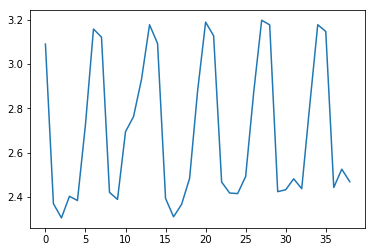

In [25]:
plt.plot(testpreds[129])

In [26]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [27]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.642619   
air_0164b9927d20bcc3_2017-04-23              1.371905   
air_0241aa3964b7f861_2017-04-23              2.237563   
air_0328696196e46f18_2017-04-23              2.182249   
air_034a3d5b40d5b1b1_2017-04-23              3.303375   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.168686  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.942854  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   8.370472  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.866225  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  26.204312

In [28]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [29]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [30]:
submission.to_csv("../submission/3001_lgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')